# OC IML Projet 5 : Catégorisez automatiquement des questions

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique
développez *un système de suggestion de tag* pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.


This notebook contains : 
- Data Exploration
- Features Preparation
- Models Optimizations
- Models Evaluations




## import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 25)

import string
from string import punctuation 

import re

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import scipy.stats as st

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from collections import defaultdict
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.externals import joblib
from skmultilearn.problem_transform import BinaryRelevance

import time
import datetime

import pickle

import math

[nltk_data] Downloading package punkt to /Users/gregory/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregory/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gregory/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Definitions

In [2]:
# source paths
PATH_SOURCE_QUESTIONS = '../../data/QueryResults.csv' 
# export path
PATH_EXPORT_FOLDER = '../../data/'

In [3]:
# init results table
df_results = None

## Useful functions

In [4]:
def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap

In [5]:
def display_missing(df):
    '''
    Display dataFrame missing values : barplots & numbers
    ouput : dataFrame containing missing numbers
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing

In [6]:
def find_tags_from_topic_first_top(iloc_topic, df_topics_tags, no_max=10):
    '''
    Find best no_max Tags from Topics by giving Topic number as input.
    (By default no_max = 10)
    Uses table linking Tags & Topics 
    
    inputs : 
    - iloc_topic
    - df_topics_tags : table linking Tags to Topics (By default df_topics_tags)
    - no_max : number of best Tags to output
    
    returns the list of no_max Topics numbers (int)
    '''
    return list(df_topics_tags.sort_values(by="Topic_{}".format(iloc_topic), 
                                           ascending=False).head(no_max).index)

In [7]:
def find_tags_from_dtopics(d_topics, df_topics_tags, no_max=10):
    '''
    Find best no_max Tags from Topics by giving Topic number as input.
    (By default no_max = 10)
    Uses table linking Tags & Topics 
    
    inputs : 
    - d_topics : topics distribution from LDA
    - df_topics_tags : table linking Tags to Topics (By default df_topics_tags)
    - no_max : number of best Tags to output
    
    returns the list of no_max Topics numbers (int)
    '''
    
    # multiply topics each columns of df_topics_tags by distrib dtopics vector:
    arr_tags = df_topics_tags.values*d_topics # table (tags(row)*Topics(col))
    # sum each row (by Tags)
    sum_distrib_tags = arr_tags.sum(axis=1) # vector (n Tags)
    # create dataframe to link with tags
    df_sum_tags = pd.DataFrame(data=sum_distrib_tags, columns=["d_sum"], 
                           index=df_topics_tags.index)
    # return no_max Tags with best score
    return list(df_sum_tags.sort_values(by="d_sum", 
                                        ascending=False).head(no_max).index)


In [8]:
def find_pred_tags_from_quest(quest_iloc,
                              df_topics_pred,
                              topic_dict,
                              df_topics_tags,
                              freq_min=0.1):
    '''
    Find predicted tags from the question number.
    
    inputs : 
    - quest_iloc : indice question (iloc)
    - df_topics_pred : table of Topics distribution by question 
    - topic_dict contains list of keywords for each topics
    - df_topics_tags : table linking Tags to Topics (By default df_topics_tags)
    '''

    list_topic_id = find_topics(quest_iloc=quest_iloc, freq_min=freq_min, 
                                df_topics_pred=df_topics_pred,
                                topic_dict=topic_dict)

    return find_tags_from_topic_first_top(iloc_topic=list_topic_id[0],
                                df_topics_tags=df_topics_tags)

In [9]:
# prepare dictionnary of translation to suppress ponctuation
replace_punctuation = str.maketrans(string.punctuation,
                                    ' '*len(string.punctuation))
def cleaning_text(questions_curr):

    # lower case
    questions_curr = ' '.join([w.lower() for w in \
                               nltk.word_tokenize(questions_curr) \
                              if not w.lower() in list(sw)])
    # delete newlines
    questions_curr = re.sub(r'\s+', ' ', questions_curr)
    # delete single quotes
    questions_curr = re.sub(r"\'", " ", questions_curr)
    # delete tags
    questions_curr = re.sub('<[^<]+?>',' ', questions_curr)
    # delete numbers (forming group = word with only numbers 
    # example : delete "123" but not "a123")
    questions_curr = re.sub(r'\b\d+\b','', questions_curr) 
    # delete ponctuation (replace by space)
    questions_curr = questions_curr.translate(replace_punctuation)

    return questions_curr

#[stemmer.stem(w) for w in tokens if not w in list(sw)]

In [10]:
def find_tags_from_text_first_top(text, tf_vectorizer, lda_model, 
                        df_topics_tags, no_max=10):
    '''
    Predict tags from text using tf, lda and tags2topic table
    
    tf vectorizer, lda and table must be input.
    '''
    # clean the text
    text_cleaned = cleaning_text(text)

    # calculate feature from text with tf already fitted
    feat_curr =  tf_vectorizer.transform([text_cleaned])

    # calculate topic distrib with lda model already fitted
    topic_distrib_pred = lda_model.transform(feat_curr)

    # find best topic from table df_topics_tags
    return find_tags_from_topic_first_top(topic_distrib_pred.argmax(), 
                                df_topics_tags=df_topics_tags, 
                                no_max=no_max)

In [11]:
def find_tags_from_text(text, tf_vectorizer, lda_model, 
                        df_topics_tags, no_max=10):
    '''
    Predict tags from text using tf, lda and tags2topic table
    
    tf vectorizer, lda and table must be input.
    '''
    # clean the text
    text_cleaned = cleaning_text(text)

    # calculate feature from text with tf already fitted
    feat_curr =  tf_vectorizer.transform([text_cleaned])

    # calculate topic distrib with lda model already fitted
    topic_distrib_pred = lda_model.transform(feat_curr)

    # find best topic from table df_topics_tags
    return find_tags_from_dtopics(topic_distrib_pred, df_topics_tags, 
                                  no_max=no_max)

In [12]:
stemmer = EnglishStemmer()

def stem_tokens(tokens, stemmer):
    '''
    Stem words in tokens.
    and suppress word < 3 characters
    '''
    stemmed = []
    for item in tokens:
        if re.match('[a-zA-Z0-9]{3,}',item):
            stemmed.append(stemmer.stem(item))
    return stemmed

def myTokenizer(text):
    '''
    Create tokens from text
    '''
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [13]:
def apply_extract_tag(text_raw, num=0):
    list_tags = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', text_raw)
    try:
        return list_tags[num]
    except:
        return np.nan

In [14]:
def find_topics(quest_iloc, df_topics_pred, topic_dict, freq_min=0.1):
    '''
    find & display topics about current question (indice loc to be specified)
    '''
    print("Cleaned question n°{}:".format(quest_iloc))
    print(token_dict[df_quest_cleaned.iloc[quest_iloc].name])
    print("\nTags : ", df_quest_cleaned.iloc[quest_iloc].Tags)
    print("")
    fig = plt.figure(figsize=(8, 6))
    df_topics_pred.iloc[quest_iloc].plot()
    #for topic_id_curr in np.nonzero(
    #    df_topics_pred.iloc[quest_iloc] > freq_min)[0]:
    list_topic_labels = df_topics_pred.\
        iloc[quest_iloc][df_topics_pred.iloc[quest_iloc] > freq_min].\
        sort_values(ascending=False).index
    print(list_topic_labels)
    list_topic_id =[]
    for label_curr in list_topic_labels:
        list_topic_id.append(int(re.findall(r"\d+", label_curr)[0]))
    print(list_topic_id)
    for topic_id_curr in list_topic_id:
        print("Topic {} : {}".format(topic_id_curr, 
                                     topic_dict[topic_id_curr]))
    return list(list_topic_id)

In [15]:
def display_topics(model, feature_names, no_top_words):
    '''
    function to create & display topic dictionnary from lda model 
    '''
    topic_dict = dict()
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        str_topic = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(str_topic)
        topic_dict[topic_idx] = str_topic
    return topic_dict 

In [16]:
def score_eval_tags(tags_real, tags_pred, nb_tags_eval_max=10):
    '''
    For a list of real tags, estimate the proportion of good predicted tags
    Example : 
    real : <java><php><sql>
    predicted : <sql><tag1><tag2><tag3> 
    => score = 1/3 = 0.333
    '''
    coeff_score = 1/len(tags_real)
    score = 0
    for tags_real_curr in tags_real:
        if tags_real_curr in tags_pred[:nb_tags_eval_max]:
            score += coeff_score
            continue
    return score

In [17]:
def find_nb_no_tags(my_array_binary):
    '''
    Counts number of no-Tags output
    '''
    nb_zeros = 0
    nb_rows = my_array_binary.shape[0]
    for idx in range(0, nb_rows):
        if sum(my_array_binary[idx,:]) == 0:
            #print('Error : row n°{} is empty!'.format(idx))
            nb_zeros += 1
    print("Nb. no Tags samples : {} over {} rows [{:.2f}%]".\
          format(nb_zeros, nb_rows, 100*nb_zeros/nb_rows))
    return nb_zeros

In [18]:
def find_nb_no_uniquetag(list_tags):
    '''
    Counts number of no-Tags output with list_tags strings as input
    '''
    nb_zeros = 0
    nb_rows = len(list_tags)
    for tag_curr in list_tags:
        if (tag_curr is None)|(tag_curr is np.nan)|(tag_curr == '')|(tag_curr == []):
            #print('Error : row n°{} is empty!'.format(idx))
            nb_zeros += 1
        #print(tag_curr)
    print("Nb. no Tags samples : {} over {} rows [{:.2f}%]".\
          format(nb_zeros, nb_rows, 100*nb_zeros/nb_rows))
    return nb_zeros

In [19]:
def create_tags_list_of_list(list_str_tags, list_tags_most_used=None):
    '''
    Create a list of list of tags from series/list of original strings of tags
    per questions 
    
    example : input : [<tag1><tag2><tag3>] output : [['tag1','tag2','tag3']]
    '''
    list_list_tags = []
    for idx, str_tags in enumerate(list_str_tags):
        list_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', str_tags)
        
        list_tags_ok = []
        
        for tag_curr in list_curr:
            if list_tags_most_used is None:
                list_tags_ok.append(tag_curr)
            else:
                if tag_curr in list_tags_most_used:
                    list_tags_ok.append(tag_curr)
                
        if list_tags_ok == []:
            print("Error iloc :  ", idx)
            
        list_list_tags.append(list_tags_ok)
    return list_list_tags

In [20]:
def predict_tags_from_list_texts(list_texts, tf_vectorizer,
                                    lda_model, 
                                    df_topics_tags,
                                    no_max):
    '''
    Predict a list of list of tags from list of text
    
    no_max determined the maximum number of tags predicted for each text in
    input.
    '''
    list_predicted_tags = []
    for text_curr in list_texts:
        # predict tags
        tags_pred = find_tags_from_text(text=text_curr, 
                                    tf_vectorizer=tf_vectorizer,
                                    lda_model=lda_model, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=no_max)
        list_predicted_tags.append(tags_pred)
        
    return list_predicted_tags

In [21]:
def evaluate_mdl_scorings(enc_lda_y_train, enc_lda_ypred_train,
                          enc_lda_y_test, enc_lda_ypred_test, 
                          timing_fit, timing_pred):
    dict_scores = dict()
    
    #calculate over same splits f1_micro mean & std
    #cv_lda
    f1_splits = []
    # on splits test
    for train_index, test_index in cv_lda.split(enc_lda_y_train):
        f1_splits.append(f1_score(enc_lda_y_train[test_index], 
                                  enc_lda_ypred_train[test_index], 
                                  average='micro'))  
    dict_scores["f1_splits_test"] = np.mean(f1_splits)
    dict_scores["f1_splits_test_std"] = np.std(f1_splits)
    
    
    dict_scores["acc_train"] = accuracy_score(enc_lda_y_train, 
                                              enc_lda_ypred_train)
    dict_scores["acc_test"] = accuracy_score(enc_lda_y_test, enc_lda_ypred_test)
    
    dict_scores["pre_train"] = precision_score(enc_lda_y_train, 
                                               enc_lda_ypred_train, 
                                               average='micro')
    dict_scores["pre_test"] = precision_score(enc_lda_y_test, 
                                              enc_lda_ypred_test, 
                                              average='micro')
    
    dict_scores["rec_train"] = recall_score(enc_lda_y_train, 
                                            enc_lda_ypred_train, 
                                            average='micro')
    dict_scores["rec_test"] = recall_score(enc_lda_y_test, 
                                           enc_lda_ypred_test, 
                                           average='micro')
    
    dict_scores["f1_train"] = f1_score(enc_lda_y_train, enc_lda_ypred_train, 
                                       average='micro')
    dict_scores["f1_test"] = f1_score(enc_lda_y_test, enc_lda_ypred_test, 
                                      average='micro')
    
    dict_scores["notags_train"] = find_nb_no_tags(enc_lda_ypred_train) / \
        enc_lda_ypred_train.shape[0]
    
    dict_scores["notags_test"] = find_nb_no_tags(enc_lda_ypred_test) / \
        enc_lda_ypred_test.shape[0]
    
    dict_scores["t_fit_train"] = timing_fit
    dict_scores["t_pred_test"] = timing_pred
    
    return pd.Series(data = dict_scores)

In [22]:
def add_score(df_results, series_scores, model_name):
    
    df_results_add = pd.DataFrame(data=series_scores, columns=[model_name]).T
    
    if df_results is None: # create table
        print('create df_results')
        df_results = df_results_add.copy()
    else: # update or add line
        try:
            # ligne existe alors on efface l'ancienne ligne  ?
            df_results = df_results.drop(index=model_name)                                
            print('update line')
        except:
            # n'existe pas
            print('add line')
            
        # on ajoute la ligne
        df_results = df_results.append(df_results_add)
        
    return df_results

In [23]:
def save_gridsearchcv_sup(g_clf_rf, df_res, name):
    '''
    Save GridSearchCV results & model for Supervised models into CSV file &
    .pkl file.
    Add best parameters into its file name
    name : string to differenciate RandomForest & KNN or other model
    
    ex : save_gridsearchcv_rf(g_clf_rf_multi_cv, df_res_rf_multi_cv,"RF")
    ../../data/df_res_RF_tags51_max_depth140_max_features31_min_samples_split4_n_estimators50.csv
    '''
    str_params = ""
    for param_curr, value_curr in g_clf_rf.best_params_.items():
        print(param_curr)
        print(value_curr)
        str_params += "_{}{}".format(param_curr, value_curr)

    path_save = PATH_EXPORT_FOLDER + "df_res_{}_tags{}{}.csv".\
        format(name, int(nb_most_used_tags), str_params)

    df_res.to_csv(path_or_buf=path_save, sep=',')
    print("Results Saved here:\n{}".format(path_save))
    
    # save model
    path_save_mdl = PATH_EXPORT_FOLDER + "model_{}_tags{}{}.pkl".\
        format(name, int(nb_most_used_tags), str_params)
    joblib.dump(g_clf_rf.best_estimator_, path_save_mdl, compress=True)
    print("Model Saved here:\n{}".format(path_save_mdl))

In [24]:
def plot_res_test_split(myDf, myScore, myX, myHue=None, y_min=None,
                       myFixedParam=None, myFixedValue=None, cv_eval=None):
    '''
    Create multiple batplot to compare scorings result over gridsearchcv for 
    Test splits
    - Add errorbar
    - choice for x axis & hue.
    
    example: 
        plot_res_test_split(df_res_rf_multi_cv, "accuracy", "param_max_depth", 
                            "param_min_samples_split",
                            y_min=0.15, 
                            myFixedParam="param_n_estimators",
                            myFixedValue=25)
    '''
    
    def plot_max_value():
        '''
        errorbar min plot
        '''
        return sns.barplot(hue=myHue, 
                y="mean_test_" + myScore + "_max",
                x=myX,
                data=df_cv_temp,
                 alpha=0.5)
    
    def plot_value():
        '''
        normal plot
        '''
        return sns.barplot(hue=myHue, 
            y="mean_test_" + myScore,
            x=myX,
            data=df_cv_temp)
            
    def plot_min_value():
        '''
        errorbar min plot
        '''
        return sns.barplot(hue=myHue, 
                y="mean_test_" + myScore + "_min",
                x=myX,
                data=df_cv_temp,
                 alpha=0.5)       
        
    if cv_eval is None:
        cv_eval = cv
        
    if myFixedParam is None:
        str_add_for_title=""
    else:
        str_add_for_title=" for " + myFixedParam + "={}".format(myFixedValue)
        
    myTitle = myScore + " on Test splits [%]" + str_add_for_title
    fig = plt.figure(figsize=(15, 8.5))
    plt.title(myTitle)
    
    # work on data
    df_cv_temp = myDf.copy()
    # correct data by zeros value if None:
    df_cv_temp.loc[df_cv_temp[myX].isna(), myX] = 0
    if myHue is not None:
        df_cv_temp.loc[df_cv_temp[myHue].isna(), myHue] = 0
    if myFixedParam is not None:
        df_cv_temp.loc[df_cv_temp[myFixedParam].isna(), myFixedParam] = 0
    # select data : if Fixed Param
    if myFixedParam is not None:
        df_cv_temp = df_cv_temp[df_cv_temp[myFixedParam] == myFixedValue]
    
    # errorbar max : Xmax = X + 1.96 * STD(X) / sqrt(n_samples)
    df_cv_temp["mean_test_" + myScore +"_max"] = \
        df_cv_temp["mean_test_" + myScore] + \
        1.96*df_cv_temp["std_test_" + myScore]/math.sqrt(cv_eval.n_splits)  

    # errorbar min : Xmin = X - 1.96 * STD(X) / sqrt(n_samples)
    df_cv_temp["mean_test_" + myScore + "_min"] = \
        df_cv_temp["mean_test_" + myScore] - \
        1.96*df_cv_temp["std_test_" + myScore]/math.sqrt(cv_eval.n_splits)
    
    # plots by order to show all min/normal/max values on barplot
    if df_cv_temp["mean_test_" + myScore].max() > 0:
        # errorbar max plot
        ax2 = plot_max_value()
        # normal plot
        ax = plot_value()
        # errorbar min plot
        ax3 = plot_min_value()
    else:
        # errorbar min plot
        ax3 = plot_min_value()
        # normal plot
        ax = plot_value()
        # errorbar max plot
        ax2 = plot_max_value()
        
    # correct ylabel 
    ax.set_ylabel("mean_test_" + myScore)
    
    # correct plot size
    nb_x_plot = df_cv_temp[myX].nunique()
    ax.set_xlim(right=nb_x_plot+1.5)
    if y_min is not None:
        if y_min >= 0:
            ax.set_ylim(bottom=y_min)
        else:
            ax.set_ylim(top=y_min)
    
    # correct legend
    if myHue is not None:
        leg = ax.get_legend()
        leg_title = leg.get_title().get_text()
        leg.remove()
        h,l = ax.get_legend_handles_labels()
        nb_leg_max = df_cv_temp[myHue].nunique()
        plt.legend(h[nb_leg_max:nb_leg_max*2], 
                   l[nb_leg_max:nb_leg_max*2], title=leg_title);
        
    # add maximum line
    plt.plot([-0.5, nb_x_plot], 
         np.array([1,1])*df_cv_temp["mean_test_" + myScore].max(),'r--')
    plt.text(nb_x_plot, df_cv_temp["mean_test_" + myScore].max(),
         "{:.4f}".format(df_cv_temp["mean_test_" + myScore].max()),
             fontsize=14, color="r")

    return ax

In [25]:
def save_gridsearchcv_unsup(g_lda, df_res, name):
    '''
    Save GridSearchCV results & model for UnSupervised models into CSV file &
    .pkl file.
    Add best parameters into its file name
    name : string to identify Model type
    
    ex : save_gridsearchcv_unsup(gcv_lda_1, df_res_1,"LDA")
    
        Results Saved here:
        ../../data/df_res_LDA_tags100_learning_decay0.7_max_iter5_n_components50.csv
        Model Saved here:
        ../../data/model_LDA__learning_decay0.7_max_iter5_n_components50.pkl
    '''
    str_params = ""
    for param_curr, value_curr in g_lda.best_params_.items():
        print(param_curr)
        print(value_curr)
        str_params += "_{}{}".format(param_curr, value_curr)

    path_save = PATH_EXPORT_FOLDER + "df_res_{}_{}.csv".\
        format(name, str_params)

    df_res.to_csv(path_or_buf=path_save, sep=',')
    print("Results Saved here:\n{}".format(path_save))
    
    # save model
    path_save_mdl = PATH_EXPORT_FOLDER + "model_{}_{}.pkl".\
        format(name, str_params)
    joblib.dump(g_lda.best_estimator_, path_save_mdl, compress=True)
    print("Model Saved here:\n{}".format(path_save_mdl))


## Loading

In [26]:
# loading each sources
df_quest = pd.read_csv(PATH_SOURCE_QUESTIONS, sep=',')

### Questions/Answers

In [27]:
df_quest.head()

Id  PostTypeId  AcceptedAnswerId    ParentId         CreationDate  \
0  50000002           2               NaN  49999948.0  2018-04-24 11:00:00   
1  50000003           2               NaN  49995279.0  2018-04-24 11:00:00   
2  50000004           2               NaN  49999911.0  2018-04-24 11:00:01   
3  50000005           1        50000164.0         NaN  2018-04-24 11:00:01   
4  50000006           1        50117317.0         NaN  2018-04-24 11:00:01   

   DeletionDate  Score  ViewCount  \
0           NaN      2        NaN   
1           NaN      1        NaN   
2           NaN      0        NaN   
3           NaN     -4       63.0   
4           NaN      0      199.0   

                                                Body  OwnerUserId  \
0  <p>You need to have a  pointer to the <code>ma...    1983495.0   
1  <p>The old state is discarded. If you want to ...     506441.0   
2  <p>If you are trying to achieve the above outp...    6155965.0   
3  <p>My table looks like this  on sql server</p>...    8217447.0   
4  <p>I have Ola Hallengren's excellent Maintenan...    9690333.0   

  OwnerDisplayName  LastEditorUserId LastEditorDisplayName  \
0              NaN         1983495.0                   NaN   
1              NaN               NaN                   NaN   
2              NaN               NaN                   NaN   
3              NaN         3876565.0                   NaN   
4              NaN               NaN                   NaN   

          LastEditDate     LastActivityDate  \
0  2018-04-24 12:14:36  2018-04-24 12:14:36   
1                  NaN  2018-04-24 11:00:00   
2                  NaN  2018-04-24 11:00:01   
3  2018-04-24 11:03:32  2018-04-24 13:15:50   
4                  NaN  2018-05-01 13:24:04   

                                               Title  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  How to insert an entry to a table only if it d...   
4  System DMV's missing from SQL Server 2017 mast...   

                                  Tags  AnswerCount  CommentCount  \
0                                  NaN          NaN             4   
1                                  NaN          NaN             3   
2                                  NaN          NaN             6   
3                <c#><sql><sql-server>          3.0             0   
4  <sql-server><sql-server-data-tools>          1.0             2   

   FavoriteCount ClosedDate CommunityOwnedDate  
0            NaN        NaN                NaN  
1            NaN        NaN                NaN  
2            NaN        NaN                NaN  
3            NaN        NaN                NaN  
4            NaN        NaN                NaN

In [28]:
df_quest["Id"].nunique()

50000

nb_missing    ratio
Id                              0    0.000
PostTypeId                      0    0.000
LastActivityDate                0    0.000
CommentCount                    0    0.000
CreationDate                    0    0.000
Score                           0    0.000
Body                           24    0.048
OwnerUserId                   508    1.016
ParentId                    21280   42.560
ViewCount                   28792   57.584
Tags                        28792   57.584
Title                       28792   57.584
AnswerCount                 28792   57.584
LastEditDate                29836   59.672
LastEditorUserId            30075   60.150
AcceptedAnswerId            40660   81.320
FavoriteCount               46675   93.350
ClosedDate                  49076   98.152
OwnerDisplayName            49482   98.964
LastEditorDisplayName       49755   99.510
CommunityOwnedDate          49970   99.940
DeletionDate                50000  100.000

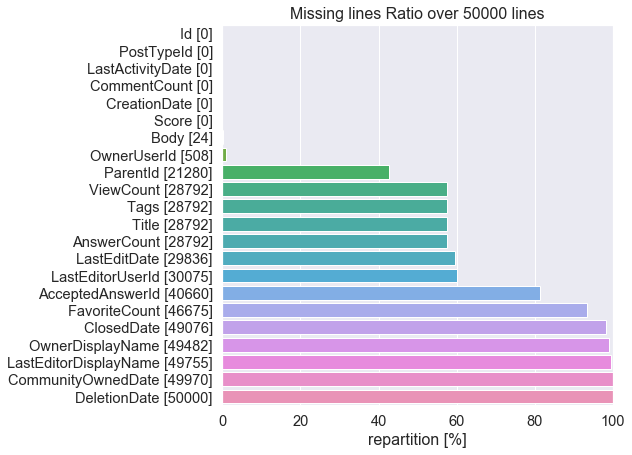

In [29]:
display_missing(df_quest)

### Filter questions

Only Questions don't have ParentId.

We filter questions with no ParentId and with non-Nan Body

In [30]:
df_quest_cleaned = df_quest[df_quest["ParentId"].isna()]
df_quest_cleaned = df_quest_cleaned[df_quest_cleaned["Body"].notna()]

nb_missing       ratio
Id                              0    0.000000
LastActivityDate                0    0.000000
Score                           0    0.000000
CommentCount                    0    0.000000
Body                            0    0.000000
PostTypeId                      0    0.000000
CreationDate                    0    0.000000
ViewCount                      48    0.225819
Title                          48    0.225819
AnswerCount                    48    0.225819
Tags                           48    0.225819
OwnerUserId                   325    1.528980
LastEditDate                 9520   44.787354
LastEditorUserId             9704   45.652992
AcceptedAnswerId            11916   56.059466
FavoriteCount               17931   84.357358
ClosedDate                  20332   95.652992
OwnerDisplayName            20924   98.438088
LastEditorDisplayName       21067   99.110839
DeletionDate                21256  100.000000
ParentId                    21256  100.000000
CommunityOwnedDate          21256  100.000000

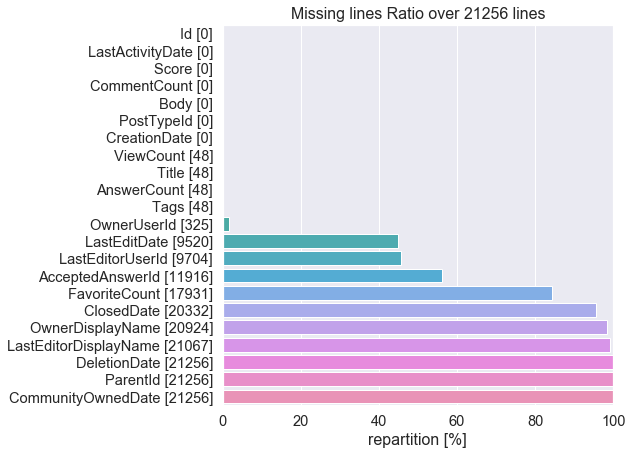

In [31]:
display_missing(df_quest_cleaned)

In [32]:
df_quest_cleaned[df_quest_cleaned.Title.isna()]

Id  PostTypeId  AcceptedAnswerId  ParentId         CreationDate  \
655    50000860           4               NaN       NaN  2018-04-24 11:44:34   
2576   50003399           5               NaN       NaN  2018-04-24 13:49:51   
2577   50003400           4               NaN       NaN  2018-04-24 13:49:51   
8467   50011191           4               NaN       NaN  2018-04-24 21:49:32   
9636   50012751           5               NaN       NaN  2018-04-25 01:22:51   
9637   50012752           4               NaN       NaN  2018-04-25 01:22:51   
12039  50015982           5               NaN       NaN  2018-04-25 07:02:19   
12040  50015983           4               NaN       NaN  2018-04-25 07:02:19   
17297  50022969           5               NaN       NaN  2018-04-25 12:55:35   
17298  50022970           4               NaN       NaN  2018-04-25 12:55:35   
18258  50024241           5               NaN       NaN  2018-04-25 13:59:16   
18259  50024242           4               NaN       NaN  2018-04-25 13:59:16   
18757  50024892           4               NaN       NaN  2018-04-25 14:29:42   
19660  50026085           4               NaN       NaN  2018-04-25 15:28:02   
21150  50028042           5               NaN       NaN  2018-04-25 17:21:55   
21151  50028043           4               NaN       NaN  2018-04-25 17:21:55   
21619  50028666           5               NaN       NaN  2018-04-25 18:01:52   
21620  50028667           4               NaN       NaN  2018-04-25 18:01:52   
26624  50035229           4               NaN       NaN  2018-04-26 05:09:07   
29301  50038749           4               NaN       NaN  2018-04-26 08:51:22   
30111  50039864           5               NaN       NaN  2018-04-26 09:47:52   
30112  50039865           4               NaN       NaN  2018-04-26 09:47:52   
32083  50042511           5               NaN       NaN  2018-04-26 12:03:01   
32084  50042512           4               NaN       NaN  2018-04-26 12:03:01   
35506  50046978           5               NaN       NaN  2018-04-26 15:36:33   
35507  50046979           4               NaN       NaN  2018-04-26 15:36:33   
35527  50047011           5               NaN       NaN  2018-04-26 15:37:48   
35528  50047012           4               NaN       NaN  2018-04-26 15:37:48   
36355  50048096           5               NaN       NaN  2018-04-26 16:39:00   
36356  50048097           4               NaN       NaN  2018-04-26 16:39:00   
39924  50052817           4               NaN       NaN  2018-04-26 22:39:09   
40624  50053746           4               NaN       NaN  2018-04-27 00:50:46   
40642  50053767           4               NaN       NaN  2018-04-27 00:55:59   
43948  50058044           5               NaN       NaN  2018-04-27 08:09:06   
43949  50058045           4               NaN       NaN  2018-04-27 08:09:06   
44066  50058195           5               NaN       NaN  2018-04-27 08:18:37   
44067  50058196           4               NaN       NaN  2018-04-27 08:18:37   
44382  50058585           5               NaN       NaN  2018-04-27 08:43:06   
44383  50058586           4               NaN       NaN  2018-04-27 08:43:06   
44635  50058917           5               NaN       NaN  2018-04-27 09:03:58   
44636  50058918           4               NaN       NaN  2018-04-27 09:03:58   
45689  50060292           5               NaN       NaN  2018-04-27 10:19:48   
45690  50060293           4               NaN       NaN  2018-04-27 10:19:48   
46092  50060798           5               NaN       NaN  2018-04-27 10:49:05   
46093  50060799           4               NaN       NaN  2018-04-27 10:49:05   
46125  50060848           5               NaN       NaN  2018-04-27 10:51:35   
46126  50060849           4               NaN       NaN  2018-04-27 10:51:35   
48403  50063895           4               NaN       NaN  2018-04-27 13:53:14   

       DeletionDate  Score  ViewCount  \
655             NaN      0        NaN   
2576      

In [33]:
df_quest_cleaned[df_quest_cleaned.Id == 50060292].Body.tolist()

['<p>This library is deprecated and is no longer being used. Use <a href="/questions/tagged/boost-log" class="post-tag" title="show questions tagged &#39;boost-log&#39;" rel="tag">boost-log</a> instead. </p>\n\n<p><a href="https://meta.stackoverflow.com/questions/298315/burninate-boost-logging">Burninate boost-logging</a> </p>\n']

In [34]:
df_quest_cleaned = df_quest_cleaned[df_quest_cleaned.Title.notna()]

nb_missing       ratio
Id                              0    0.000000
LastActivityDate                0    0.000000
AnswerCount                     0    0.000000
Title                           0    0.000000
ViewCount                       0    0.000000
Score                           0    0.000000
Body                            0    0.000000
CreationDate                    0    0.000000
PostTypeId                      0    0.000000
CommentCount                    0    0.000000
Tags                            0    0.000000
OwnerUserId                   324    1.527725
LastEditDate                 9520   44.888721
LastEditorUserId             9703   45.751603
AcceptedAnswerId            11868   55.960015
FavoriteCount               17883   84.321954
ClosedDate                  20284   95.643154
OwnerDisplayName            20877   98.439268
LastEditorDisplayName       21020   99.113542
DeletionDate                21208  100.000000
ParentId                    21208  100.000000
CommunityOwnedDate          21208  100.000000

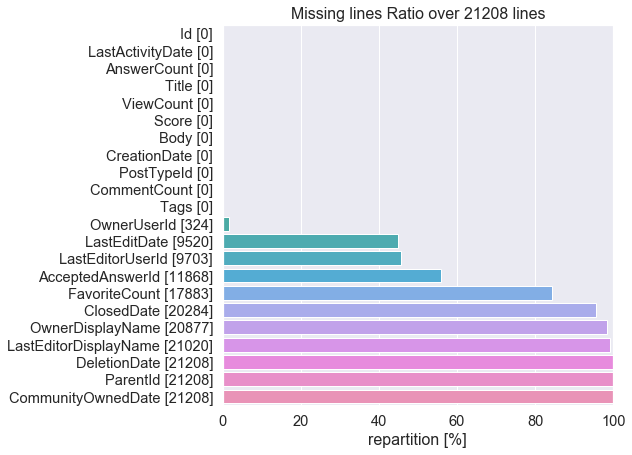

In [35]:
display_missing(df_quest_cleaned)

In [36]:
df_quest_cleaned[df_quest_cleaned["OwnerUserId"].isna()].head()

Id  PostTypeId  AcceptedAnswerId  ParentId         CreationDate  \
117   50000152           1        50000270.0       NaN  2018-04-24 11:07:30   
140   50000185           1        50000460.0       NaN  2018-04-24 11:09:32   
179   50000239           1        50003124.0       NaN  2018-04-24 11:12:02   
711   50000932           1               NaN       NaN  2018-04-24 11:48:21   
1291  50001710           1               NaN       NaN  2018-04-24 12:28:33   

      DeletionDate  Score  ViewCount  \
117            NaN      1       33.0   
140            NaN      1       95.0   
179            NaN      0       42.0   
711            NaN      0      882.0   
1291           NaN      0      340.0   

                                                   Body  OwnerUserId  \
117   <p>I'm working on a blog. On its first page I ...          NaN   
140   <p>I'm trying to write a PHP code that's a bit...          NaN   
179   <p>I'm trying to append into the html code a j...          NaN   
711   <p>I have some problems with 'entityManagerFac...          NaN   
1291  <p>i have a bottom navigation in main activity...          NaN   

     OwnerDisplayName  LastEditorUserId LastEditorDisplayName  \
117       user9690627         3848833.0                   NaN   
140       user9474945         4248328.0                   NaN   
179       user9557101               NaN           user9557101   
711       user7866438         3535298.0                   NaN   
1291      user9585742         7666442.0                   NaN   

             LastEditDate     LastActivityDate  \
117   2018-04-24 12:19:36  2018-04-24 12:19:36   
140   2018-04-24 11:10:22  2018-04-24 15:47:15   
179   2018-04-24 11:29:35  2018-04-24 13:37:33   
711   2018-04-24 12:49:52  2018-04-24 12:49:52   
1291  2018-04-24 12:36:36  2018-04-24 12:36:36   

                                                  Title  \
117               Django - Combining Multiple Variables   
140                         Php date move to next month   
179   how to append a javascript function with 2 var...   
711   Parameter 0 of constructor in com.springboot.D...   
1291      putting recycler view above bottom navigation   

                                                   Tags  AnswerCount  \
117                                    <python><django>          1.0   
140                                               <php>          4.0   
179                               <javascript><laravel>          1.0   
711   <java><hibernate><spring-boot><spring-data-jpa...          0.0   
1291                    <java><android><android-layout>          2.0   

      CommentCount  FavoriteCount ClosedDate CommunityOwnedDate  
117              0            NaN        NaN                NaN  
140              2            NaN        NaN                NaN  
179              3            NaN        NaN                NaN  
711              5            NaN        NaN                NaN  
1291             4            NaN        NaN                NaN

## Preparation data

### Tags

#### Nb Tags per Question

In [37]:
def apply_nb_tags(str_tags):
    return len(re.findall(r'(?<=\<)[^\<\>]+(?=\>)', str_tags))

df_quest_cleaned["nb_Tags"] = df_quest_cleaned["Tags"].apply(apply_nb_tags)


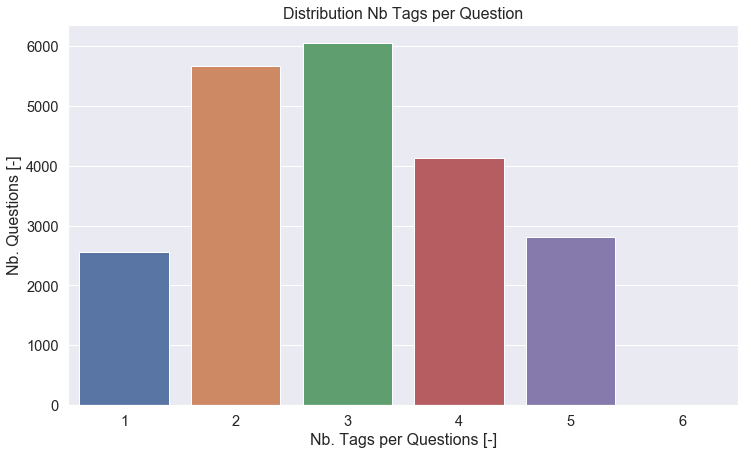

In [38]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution Nb Tags per Question")
#ax = sns.distplot(df_quest_cleaned["nb_Tags"], kde=False, bins=6);
ax = sns.countplot(data=df_quest_cleaned, x="nb_Tags");
#ax = sns.distplot(df_Tags);
ax.set_xlabel("Nb. Tags per Questions [-]")
ax.set_ylabel("Nb. Questions [-]");
#ax.set_xlim([0,25])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


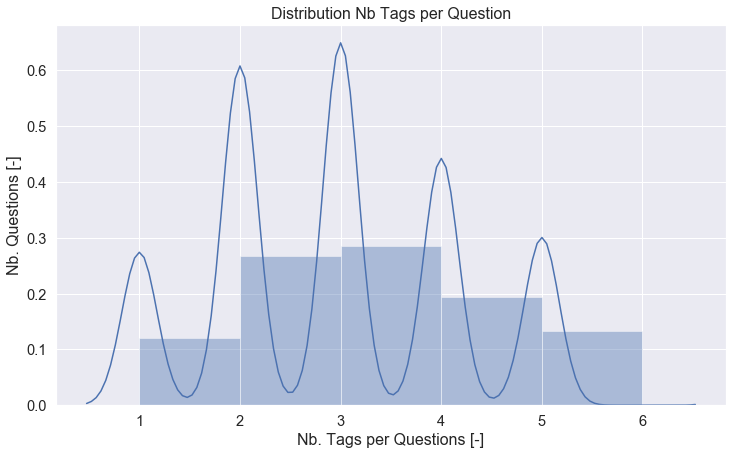

In [39]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution Nb Tags per Question")
ax = sns.distplot(df_quest_cleaned["nb_Tags"], bins=5);
#ax = sns.countplot(data=df_quest_cleaned, x="nb_Tags");
#ax = sns.distplot(df_Tags);
ax.set_xlabel("Nb. Tags per Questions [-]")
ax.set_ylabel("Nb. Questions [-]");
#ax.set_xlim([0,25])

Only 1 Question with 6 Tags : 

In [40]:
df_quest_cleaned[df_quest_cleaned["nb_Tags"] == 6].shape[0]

1

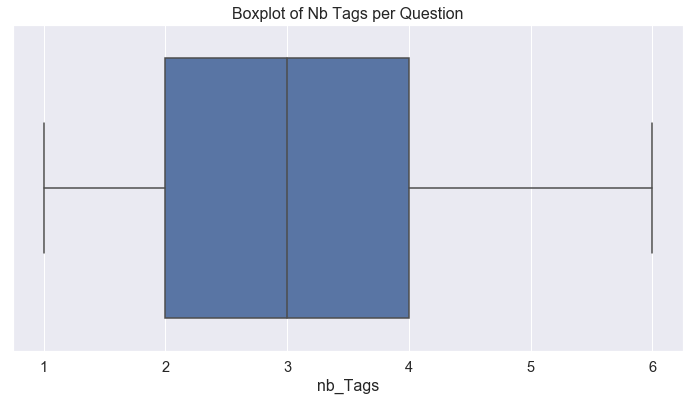

In [41]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot of Nb Tags per Question")
ax = sns.boxplot(df_quest_cleaned["nb_Tags"]);
#ax.set_xlim([0,20])
#ax.set_xlabel("nb. Occurences")

#### Unique Tags

In [42]:
# extract all tags
list_tags_raw=[]
for idx in range(0, df_quest_cleaned.shape[0]):
    #print("start...",idx)
    list_tags_raw = list_tags_raw+(re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_quest_cleaned.iloc[idx].Tags))
# list of unique tags over all questions (no limitation at most frequent tags)
list_unique_tags = list(np.unique(list_tags_raw)) 
print('Total Number of Tags:', len(list_tags_raw))
print("Number of Unique Tags:",len(list_unique_tags))
list_unique_tags[:10]

Total Number of Tags: 62572
Number of Unique Tags: 8765


['.app',
 '.htaccess',
 '.lib',
 '.net',
 '.net-1.1',
 '.net-4.0',
 '.net-4.5',
 '.net-4.6',
 '.net-4.6.1',
 '.net-4.6.2']

In [43]:
df_Tags = pd.DataFrame(list_tags_raw, columns=["Tag"])
df_Tags = pd.DataFrame(df_Tags.Tag.value_counts())
df_Tags.head(10)

Tag
javascript  2229
python      2180
java        1688
c#          1183
android     1137
php         1092
html         955
css          665
r            660
jquery       639

Text(0, 0.5, 'Normalized distribution [-]')

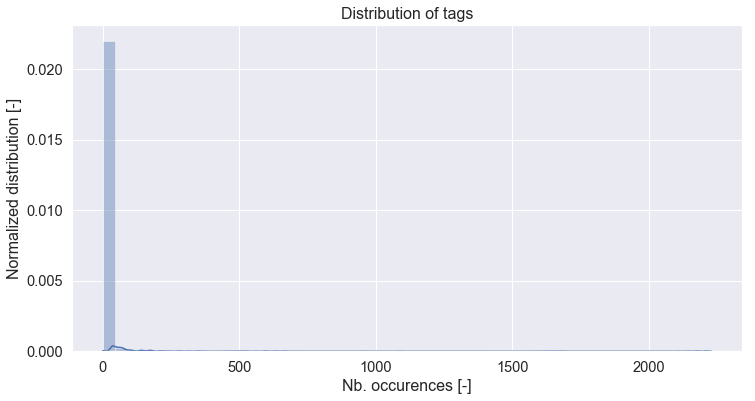

In [44]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of tags")
#ax = sns.distplot(df_Tags[df_Tags["Tag"] <= 100], kde=False);
ax = sns.distplot(df_Tags);
ax.set_xlabel("Nb. occurences [-]")
ax.set_ylabel("Normalized distribution [-]")

(0, 25)

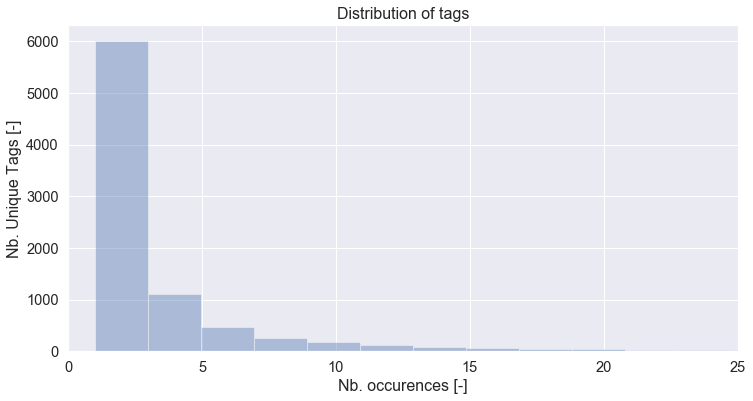

In [45]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of tags")
ax = sns.distplot(df_Tags[df_Tags["Tag"] <= 100], kde=False);
#ax = sns.distplot(df_Tags);
ax.set_xlabel("Nb. occurences [-]")
ax.set_ylabel("Nb. Unique Tags [-]")
ax.set_xlim([0,25])

(0.9, 1)

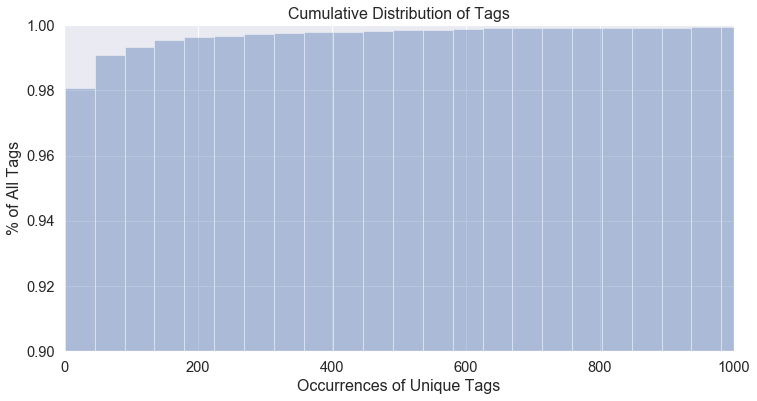

In [46]:
fig = plt.figure(figsize=(12, 6))
plt.title("Cumulative Distribution of Tags")
ax = sns.distplot(df_Tags["Tag"], kde=True,
                 hist_kws={'cumulative': True});
ax.set_xlabel("Occurrences of Unique Tags")
ax.set_ylabel("% of All Tags");
ax.set_xlim([0, 1000])
ax.set_ylim([0.9, 1])

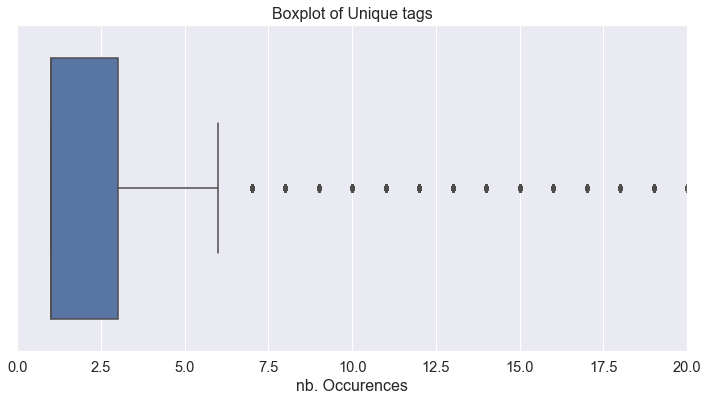

In [47]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot of Unique tags")
ax = sns.boxplot(df_Tags["Tag"]);
ax.set_xlim([0,20])
ax.set_xlabel("nb. Occurences");

#### Extract Tags

In [48]:
df_quest_cleaned["Tag_0"] = df_quest_cleaned.Tags.apply(apply_extract_tag)
df_quest_cleaned["Tag_1"] = df_quest_cleaned.Tags.apply(apply_extract_tag, 
                                                        args=(1,))
df_quest_cleaned["Tag_2"] = df_quest_cleaned.Tags.apply(apply_extract_tag, 
                                                        args=(2,))
df_quest_cleaned["Tag_3"] = df_quest_cleaned.Tags.apply(apply_extract_tag, 
                                                        args=(3,))
df_quest_cleaned["Tag_4"] = df_quest_cleaned.Tags.apply(apply_extract_tag, 
                                                        args=(4,))
df_quest_cleaned.head()

Id  PostTypeId  AcceptedAnswerId  ParentId         CreationDate  \
3   50000005           1        50000164.0       NaN  2018-04-24 11:00:01   
4   50000006           1        50117317.0       NaN  2018-04-24 11:00:01   
9   50000012           1               NaN       NaN  2018-04-24 11:00:25   
10  50000013           1               NaN       NaN  2018-04-24 11:00:27   
12  50000015           1        50000099.0       NaN  2018-04-24 11:00:31   

    DeletionDate  Score  ViewCount  \
3            NaN     -4       63.0   
4            NaN      0      199.0   
9            NaN     -3       37.0   
10           NaN     -1       42.0   
12           NaN      1      133.0   

                                                 Body  OwnerUserId  \
3   <p>My table looks like this  on sql server</p>...    8217447.0   
4   <p>I have Ola Hallengren's excellent Maintenan...    9690333.0   
9   <p>i want to insert data without page reload.\...    9690673.0   
10  <p>How to upload file in amazon s3 without cre...    5821228.0   
12  <p>I would like to output a table, transformed...    1570450.0   

   OwnerDisplayName  LastEditorUserId  ...   \
3               NaN         3876565.0  ...    
4               NaN               NaN  ...    
9               NaN         9690673.0  ...    
10              NaN               NaN  ...    
12              NaN               NaN  ...    

                                            Tags AnswerCount CommentCount  \
3                          <c#><sql><sql-server>         3.0            0   
4            <sql-server><sql-server-data-tools>         1.0            2   
9                        <javascript><php><ajax>         1.0            4   
10  <android><amazon-s3><file-upload><multipart>         1.0            0   
12                          <sql><db2><crosstab>         1.0            0   

   FavoriteCount ClosedDate  CommunityOwnedDate  nb_Tags       Tag_0  \
3            NaN        NaN                 NaN        3          c#   
4            NaN        NaN                 NaN        2  sql-server   
9            NaN        NaN                 NaN        3  javascript   
10           NaN        NaN                 NaN        4     android   
12           NaN        NaN                 NaN        3         sql   

                    Tag_1        Tag_2      Tag_3 Tag_4  
3                     sql   sql-server        NaN   NaN  
4   sql-server-data-tools          NaN        NaN   NaN  
9                     php         ajax        NaN   NaN  
10              amazon-s3  file-upload  multipart   NaN  
12                    db2     crosstab        NaN   NaN  

[5 rows x 28 columns]

#### Most used Tags

To have a balance between number of Tags to predict and their utilization 

In [49]:
list_nb_tags_used_min = [160, 100, 76, 40]

list_list_most_used =[]
list_nb_tags_unique_most_used = []
list_pc_tags =[]
for nb_tags_used_min in list_nb_tags_used_min:
    
    list_list_most_used.append(list(df_Tags[df_Tags["Tag"] >= \
                                            nb_tags_used_min].index))
    list_nb_tags_unique_most_used.append(
        df_Tags[df_Tags["Tag"]>=nb_tags_used_min].shape[0])
    
    list_pc_tags.append(100*df_Tags[df_Tags["Tag"]>=nb_tags_used_min].\
                 shape[0]/df_Tags.shape[0])
    
    print('Nb Tags used < {} times : {} over {} Tags [{:.2f}%]'.\
          format(nb_tags_used_min,
                 df_Tags[df_Tags["Tag"]<nb_tags_used_min].shape[0], 
                 df_Tags.shape[0],
                 100*df_Tags[df_Tags["Tag"]<nb_tags_used_min].\
                 shape[0]/df_Tags.shape[0]))

    print('Nb Tags used >= {} times : {} over {} Tags [{:.2f}%]'.\
          format(nb_tags_used_min,
                 df_Tags[df_Tags["Tag"]>=nb_tags_used_min].shape[0], 
                 df_Tags.shape[0],
                 100*df_Tags[df_Tags["Tag"]>=nb_tags_used_min].\
                 shape[0]/df_Tags.shape[0]))

df_most = pd.DataFrame(data=list_nb_tags_used_min, columns=["nb_min_used"])
df_most["nb_most_used_tags"] = list_nb_tags_unique_most_used
df_most["pc_of_unique_tags"] = list_pc_tags
df_most

Nb Tags used < 160 times : 8714 over 8765 Tags [99.42%]
Nb Tags used >= 160 times : 51 over 8765 Tags [0.58%]
Nb Tags used < 100 times : 8692 over 8765 Tags [99.17%]
Nb Tags used >= 100 times : 73 over 8765 Tags [0.83%]
Nb Tags used < 76 times : 8665 over 8765 Tags [98.86%]
Nb Tags used >= 76 times : 100 over 8765 Tags [1.14%]
Nb Tags used < 40 times : 8564 over 8765 Tags [97.71%]
Nb Tags used >= 40 times : 201 over 8765 Tags [2.29%]


nb_min_used  nb_most_used_tags  pc_of_unique_tags
0          160                 51           0.581860
1          100                 73           0.832858
2           76                100           1.140901
3           40                201           2.293212

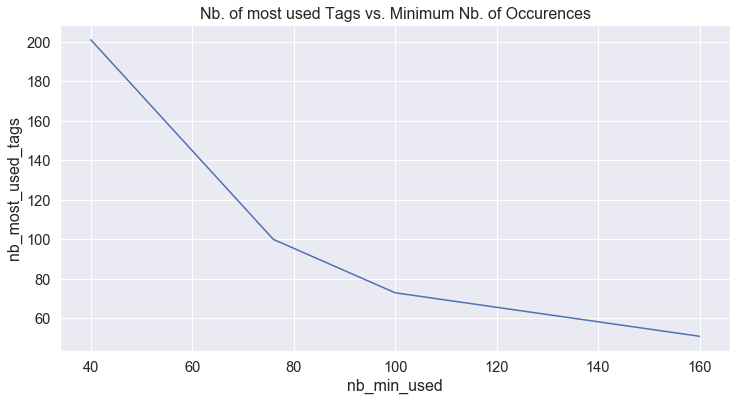

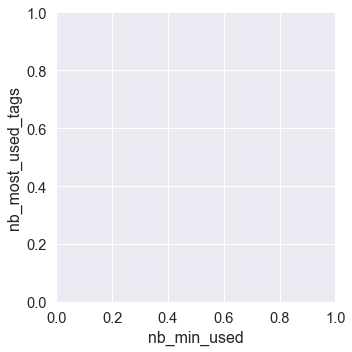

In [50]:
fig = plt.figure(figsize=(12, 6))
plt.title("Nb. of most used Tags vs. Minimum Nb. of Occurences")
ax = fig.gca()
sns.relplot(ax=ax, x="nb_min_used", y="nb_most_used_tags", data=df_most, 
            kind='line', markers=True)


#ax.set_xlim([0,20])
#ax.set_xlabel("nb. Occurences");

In [51]:
#list_tags_most_used = list(df_Tags[df_Tags["Tag"]>=nb_tags_used_min].index)
print("10 most used Tags:")
list_list_most_used[0][:10]

10 most used Tags:


['javascript',
 'python',
 'java',
 'c#',
 'android',
 'php',
 'html',
 'css',
 'r',
 'jquery']

In [52]:
len(list_list_most_used)

4

In [53]:
def check_Tags_most_used(text, list_most_used):
    '''
    Check if Tag string "text" is a most used Tag
    '''
    if text in list_most_used:
        return True
    return False


list_pc_quest=[]
for idx, list_most_used_curr in enumerate(list_list_most_used):
    df_quest_cleaned["flag_Tag_0"] = df_quest_cleaned["Tag_0"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_Tag_1"] = df_quest_cleaned["Tag_1"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_Tag_2"] = df_quest_cleaned["Tag_2"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_Tag_3"] = df_quest_cleaned["Tag_3"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_Tag_4"] = df_quest_cleaned["Tag_4"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_most_Tagged_{}"\
                     .format(list_nb_tags_used_min[idx])] = \
    df_quest_cleaned["flag_Tag_0"] | \
    df_quest_cleaned["flag_Tag_1"] | df_quest_cleaned["flag_Tag_2"] | \
    df_quest_cleaned["flag_Tag_3"] | df_quest_cleaned["flag_Tag_4"]
    
    list_pc_quest.append(100*df_quest_cleaned[\
        df_quest_cleaned["flag_most_Tagged_{}".\
        format(list_nb_tags_used_min[idx])] == True].shape[0] / \
        df_quest_cleaned.shape[0])
    

In [54]:
df_most["pc_of_quest"] = list_pc_quest
df_most

nb_min_used  nb_most_used_tags  pc_of_unique_tags  pc_of_quest
0          160                 51           0.581860    76.914372
1          100                 73           0.832858    80.879857
2           76                100           1.140901    83.666541
3           40                201           2.293212    88.494908

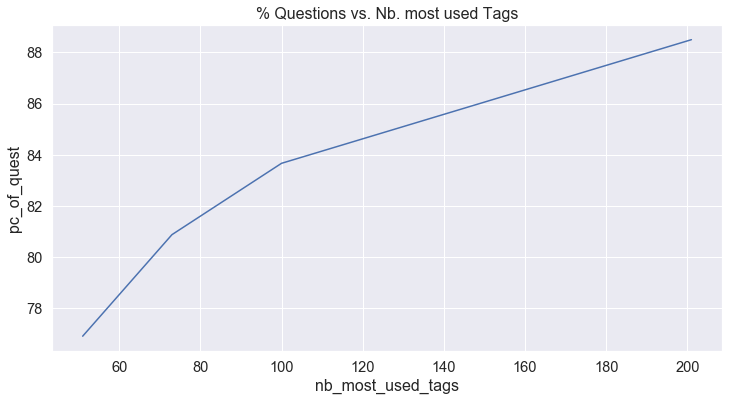

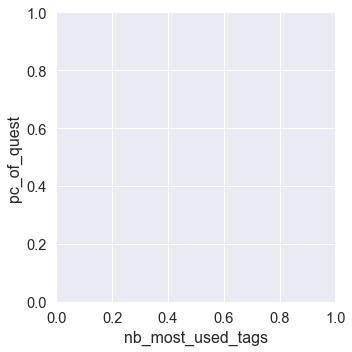

In [55]:
fig = plt.figure(figsize=(12, 6))
plt.title("% Questions vs. Nb. most used Tags")
ax = fig.gca()
sns.relplot(ax=ax, x="nb_most_used_tags", y="pc_of_quest", data=df_most, 
            kind='line', markers=True)

In [56]:
df_quest_cleaned.head()

Id  PostTypeId  AcceptedAnswerId  ParentId         CreationDate  \
3   50000005           1        50000164.0       NaN  2018-04-24 11:00:01   
4   50000006           1        50117317.0       NaN  2018-04-24 11:00:01   
9   50000012           1               NaN       NaN  2018-04-24 11:00:25   
10  50000013           1               NaN       NaN  2018-04-24 11:00:27   
12  50000015           1        50000099.0       NaN  2018-04-24 11:00:31   

    DeletionDate  Score  ViewCount  \
3            NaN     -4       63.0   
4            NaN      0      199.0   
9            NaN     -3       37.0   
10           NaN     -1       42.0   
12           NaN      1      133.0   

                                                 Body  OwnerUserId  \
3   <p>My table looks like this  on sql server</p>...    8217447.0   
4   <p>I have Ola Hallengren's excellent Maintenan...    9690333.0   
9   <p>i want to insert data without page reload.\...    9690673.0   
10  <p>How to upload file in amazon s3 without cre...    5821228.0   
12  <p>I would like to output a table, transformed...    1570450.0   

   OwnerDisplayName  LastEditorUserId         ...                Tag_2  \
3               NaN         3876565.0         ...           sql-server   
4               NaN               NaN         ...                  NaN   
9               NaN         9690673.0         ...                 ajax   
10              NaN               NaN         ...          file-upload   
12              NaN               NaN         ...             crosstab   

        Tag_3 Tag_4 flag_Tag_0 flag_Tag_1  flag_Tag_2  flag_Tag_3  flag_Tag_4  \
3         NaN   NaN       True       True        True       False       False   
4         NaN   NaN       True      False       False       False       False   
9         NaN   NaN       True       True        True       False       False   
10  multipart   NaN       True       True       False       False       False   
12        NaN   NaN       True      False       False       False       False   

   flag_most_Tagged_160 flag_most_Tagged_100  flag_most_Tagged_76  \
3                  True                 True                 True   
4                  True                 True                 True   
9                  True                 True                 True   
10                 True                 True                 True   
12                 True                 True                 True   

   flag_most_Tagged_40  
3                 True  
4                 True  
9                 True  
10                True  
12                True  

[5 rows x 37 columns]

In [57]:
df_quest_cleaned["flag_most_Tagged_40"].value_counts(dropna=False)

True     18768
False     2440
Name: flag_most_Tagged_40, dtype: int64

In [58]:
df_quest_cleaned["flag_most_Tagged_76"].value_counts(dropna=False)

True     17744
False     3464
Name: flag_most_Tagged_76, dtype: int64

In [59]:
df_quest_cleaned["flag_most_Tagged_160"].value_counts(dropna=False)

True     16312
False     4896
Name: flag_most_Tagged_160, dtype: int64

In [60]:
#df_quest_cleaned = df_quest_cleaned[df_quest_cleaned["flag_most_Tagged"] == 
#                                    True]

### Title & Body concatenation

In [61]:
df_quest_cleaned["Text"] = df_quest_cleaned["Title"] + " " + df_quest_cleaned["Body"]
df_quest_cleaned.head()

Id  PostTypeId  AcceptedAnswerId  ParentId         CreationDate  \
3   50000005           1        50000164.0       NaN  2018-04-24 11:00:01   
4   50000006           1        50117317.0       NaN  2018-04-24 11:00:01   
9   50000012           1               NaN       NaN  2018-04-24 11:00:25   
10  50000013           1               NaN       NaN  2018-04-24 11:00:27   
12  50000015           1        50000099.0       NaN  2018-04-24 11:00:31   

    DeletionDate  Score  ViewCount  \
3            NaN     -4       63.0   
4            NaN      0      199.0   
9            NaN     -3       37.0   
10           NaN     -1       42.0   
12           NaN      1      133.0   

                                                 Body  OwnerUserId  \
3   <p>My table looks like this  on sql server</p>...    8217447.0   
4   <p>I have Ola Hallengren's excellent Maintenan...    9690333.0   
9   <p>i want to insert data without page reload.\...    9690673.0   
10  <p>How to upload file in amazon s3 without cre...    5821228.0   
12  <p>I would like to output a table, transformed...    1570450.0   

   OwnerDisplayName  LastEditorUserId  \
3               NaN         3876565.0   
4               NaN               NaN   
9               NaN         9690673.0   
10              NaN               NaN   
12              NaN               NaN   

                          ...                              Tag_3 Tag_4  \
3                         ...                                NaN   NaN   
4                         ...                                NaN   NaN   
9                         ...                                NaN   NaN   
10                        ...                          multipart   NaN   
12                        ...                                NaN   NaN   

   flag_Tag_0 flag_Tag_1 flag_Tag_2  flag_Tag_3  flag_Tag_4  \
3        True       True       True       False       False   
4        True      False      False       False       False   
9        True       True       True       False       False   
10       True       True      False       False       False   
12       True      False      False       False       False   

    flag_most_Tagged_160 flag_most_Tagged_100 flag_most_Tagged_76  \
3                   True                 True                True   
4                   True                 True                True   
9                   True                 True                True   
10                  True                 True                True   
12                  True                 True                True   

    flag_most_Tagged_40                                               Text  
3                  True  How to insert an entry to a table only if it d...  
4                  True  System DMV's missing from SQL Server 2017 mast...  
9                  True  how to insert data in databse without page rel...  
10                 True  How to upload image using multipart in Amazon ...  
12                 True  DB2 SQL CROSSTAB <p>I would like to output a t...  

[5 rows x 38 columns]

In [62]:
df_quest_cleaned.head(1)

Id  PostTypeId  AcceptedAnswerId  ParentId         CreationDate  \
3  50000005           1        50000164.0       NaN  2018-04-24 11:00:01   

   DeletionDate  Score  ViewCount  \
3           NaN     -4       63.0   

                                                Body  OwnerUserId  \
3  <p>My table looks like this  on sql server</p>...    8217447.0   

  OwnerDisplayName  LastEditorUserId  \
3              NaN         3876565.0   

                         ...                         Tag_3 Tag_4 flag_Tag_0  \
3                        ...                           NaN   NaN       True   

  flag_Tag_1 flag_Tag_2  flag_Tag_3  flag_Tag_4  flag_most_Tagged_160  \
3       True       True       False       False                  True   

  flag_most_Tagged_100 flag_most_Tagged_76  flag_most_Tagged_40  \
3                 True                True                 True   

                                                Text  
3  How to insert an entry to a table only if it d...  

[1 rows x 38 columns]

In [63]:
df_quest_cleaned.head(1).Title.tolist()

['How to insert an entry to a table only if it does not exist']

In [64]:
df_quest_cleaned.head(1).Body.tolist()

["<p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"]

In [65]:
df_quest_cleaned.head(1).Text.tolist()

["How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"]

##### Create questions dictionnary

In [66]:
questions = df_quest_cleaned.filter(items=["Text"]).to_dict()
questions = questions["Text"]
print('{} questions'.format(len(questions)))

21208 questions


In [67]:
questions[4]

'System DMV\'s missing from SQL Server 2017 master.dacpac in SSDT 2015 <p>I have Ola Hallengren\'s excellent Maintenance Solution scripts incorporated in to a DBA tools database project.  This is maintained using SSDT 2015 with a target platform of SQL Server 2012.  The project includes references to the built-in system databases master &amp; msdb.  The project builds successfully.</p>\n\n<p>Ola has recently <a href="https://ola.hallengren.com/versions.html" rel="nofollow noreferrer">updated</a> his scripts and they now include references to new SQL Server 2017 DMV\'s, so incorporating the updated scripts into my database project generated unresolved reference errors for the new DMV\'s.  </p>\n\n<pre><code>SQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_os_host_info]\nSQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_db_log_stats]\n</code></pre>\n\n<p>Although I don\'t have SQL Server 2017 installed a

### Words in questions

In [68]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

def freq_stats_corpora():
    '''
    Statistics about words in questions
    '''
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par question
    for id_curr,questions_curr in questions.items():        
        try:
            corpora[id_curr] += tokenizer.tokenize(questions_curr.lower())
        except:
            print('Question {} : Error body empty'.format(id_curr))
            
    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

# Récupération des comptages
freq, stats, corpora = freq_stats_corpora()
df_stats = pd.DataFrame.from_dict(stats, orient='index')

# Affichage des fréquences
#df.sort(columns='total', ascending=False)
#df = df.sort_values(by=['total'], ascending=False)
#df.head(50).plot(kind='bar', color="#f56900", title='Top 50 Rappeurs par nombre de mots')

In [69]:
df_stats.head()

total  unique
3      82      49
4     424     192
9     355      89
10     31      24
12     70      39

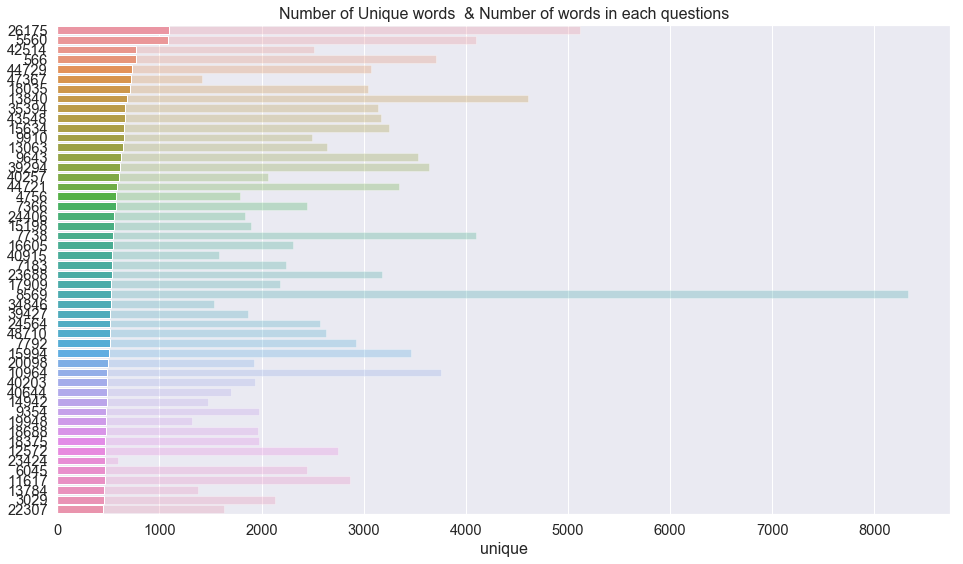

In [70]:
fig = plt.figure(figsize=(16, 9))
plt.title("Number of Unique words  & Number of words in each questions")
df_plot = df_stats.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [71]:
df_plot.T

26175  5560   42514  566    44729  47367  18035  13840  35394  43548  \
total    5119   4100   2515   3708   3076   1420   3042   4610   3139   3172   
unique   1096   1087    770    767    733    719    712    683    667    664   

        15634  9910   ...    14942  9354   19948  18688  18375  12572  23424  \
total    3243   2492  ...     1479   1974   1317   1964   1974   2753    595   
unique    649    648  ...      483    479    475    473    470    468    467   

        6045   11617  13784  3029   22307  
total    2447   2869   1381   2130   1633  
unique    467    465    455    453    451  

[2 rows x 50 columns]

In [72]:
len(df_quest_cleaned.loc[14942].Body)

9799

In [73]:
df_quest_cleaned.loc[14942].Body

"<p>My outer <code>RecyclerView</code> crashes either with</p>\n\n<pre><code>IllegalArgumentException: Scrapped or attached views may not be recycled. isScrap:false isAttached:true...\n</code></pre>\n\n<p>or</p>\n\n<pre><code>IllegalStateException: The specified child already has a parent. You must call removeView() on the child's parent first.\n</code></pre>\n\n<p>Like the title suggests I have an <code>RecyclerView</code> in the list item layout of the first <code>RecyclerView</code>. This layout is used to display messages and the \ninner <code>RecyclerView</code> to display attachments that come with the message. The inner <code>RecyclerViews</code> visibility is set to either <code>GONE</code> or <code>VISIBLE</code> depending whether the message has any attachments or not. The simplified outer list item layout looks like this</p>\n\n<pre><code>ConstraintLayout\n    TextView\n    TextView\n    TextView\n    RecyclerView\n</code></pre>\n\n<p>And the part of the adapter that handles

In [74]:
tokenizer.tokenize(df_quest_cleaned.loc[14942].Body)

['p',
 'My',
 'outer',
 'code',
 'RecyclerView',
 'code',
 'crashes',
 'either',
 'with',
 'p',
 'pre',
 'code',
 'IllegalArgumentException',
 'Scrapped',
 'or',
 'attached',
 'views',
 'may',
 'not',
 'be',
 'recycled',
 'isScrap',
 'false',
 'isAttached',
 'true',
 'code',
 'pre',
 'p',
 'or',
 'p',
 'pre',
 'code',
 'IllegalStateException',
 'The',
 'specified',
 'child',
 'already',
 'has',
 'a',
 'parent',
 'You',
 'must',
 'call',
 'removeView',
 'on',
 'the',
 'child',
 's',
 'parent',
 'first',
 'code',
 'pre',
 'p',
 'Like',
 'the',
 'title',
 'suggests',
 'I',
 'have',
 'an',
 'code',
 'RecyclerView',
 'code',
 'in',
 'the',
 'list',
 'item',
 'layout',
 'of',
 'the',
 'first',
 'code',
 'RecyclerView',
 'code',
 'This',
 'layout',
 'is',
 'used',
 'to',
 'display',
 'messages',
 'and',
 'the',
 'inner',
 'code',
 'RecyclerView',
 'code',
 'to',
 'display',
 'attachments',
 'that',
 'come',
 'with',
 'the',
 'message',
 'The',
 'inner',
 'code',
 'RecyclerViews',
 'code',
 'v

### Stops words

In [75]:
# Premièrement, on récupère la fréquence totale de chaque mot sur tout le corpus
# de questions
freq_totale = nltk.Counter()
for k, v in questions.items():
    freq_totale += freq[k]



In [76]:
freq_totale.most_common(50)

[('p', 202005),
 ('code', 131321),
 ('the', 121239),
 ('gt', 118769),
 ('i', 115208),
 ('lt', 106133),
 ('to', 86611),
 ('a', 82889),
 ('pre', 67216),
 ('in', 50576),
 ('is', 48381),
 ('0', 45769),
 ('and', 43771),
 ('this', 39396),
 ('1', 39346),
 ('of', 33180),
 ('it', 29148),
 ('for', 27661),
 ('if', 23332),
 ('class', 23294),
 ('that', 21850),
 ('with', 21757),
 ('2', 21554),
 ('my', 20638),
 ('data', 19884),
 ('com', 19661),
 ('have', 19599),
 ('from', 19443),
 ('on', 18727),
 ('but', 18357),
 ('not', 18253),
 ('as', 16884),
 ('at', 16517),
 ('div', 16493),
 ('strong', 15914),
 ('id', 15655),
 ('new', 15235),
 ('name', 15108),
 ('https', 14915),
 ('3', 14266),
 ('can', 14217),
 ('how', 14163),
 ('string', 14120),
 ('java', 14100),
 ('t', 13946),
 ('get', 13191),
 ('error', 13092),
 ('using', 12703),
 ('li', 12519),
 ('file', 12417)]

In [77]:
# Deuxièmement on décide manière un peu arbitraire du nombre de mots les plus 
# fréquents à supprimer. On pourrait afficher un graphe d'évolution du nombre 
# de mots pour se rendre compte et avoir une meilleure heuristique. 
# On créé notre set de stopwords final qui cumule ainsi les 100 mots les plus 
# fréquents du corpus ainsi que l'ensemble de stopwords par défaut présent 
# dans la librairie NLTK
most_freq = freq_totale.most_common(100)
sw = set()
for tuple_freq in most_freq:
    sw.add(tuple_freq[0])
    
sw.update(tuple(nltk.corpus.stopwords.words('english')))
sw

{'0',
 '1',
 '10',
 '2',
 '3',
 '4',
 '5',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'amp',
 'an',
 'and',
 'android',
 'any',
 'app',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'c',
 'can',
 'class',
 'code',
 'com',
 'couldn',
 "couldn't",
 'd',
 'data',
 'did',
 'didn',
 "didn't",
 'div',
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'error',
 'false',
 'few',
 'file',
 'for',
 'from',
 'function',
 'further',
 'get',
 'gt',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'href',
 'html',
 'https',
 'i',
 'id',
 'if',
 'image',
 'import',
 'in',
 'int',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'java',
 'js',
 'just',
 'li',
 'like',
 'll',
 'l

##### Save stop words

In [78]:
# save model
path_save_sw = PATH_EXPORT_FOLDER + "stop_words_sw.pkl"
joblib.dump(sw, path_save_sw)
print("Stop words Saved here:\n{}".format(path_save_sw))

Stop words Saved here:
../../data/stop_words_sw.pkl


In [79]:
nltk.corpus.stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [80]:
def freq_stats_corpora2():
    '''
    Statistics about significant words in questions
    '''
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par artiste
    for id_curr,questions_curr in questions.items():
        #print(id_curr)
        try:
            tokens = tokenizer.tokenize(questions_curr.lower())
            corpora[id_curr] += [w for w in tokens if not w in list(sw)]
        except:
            print('Question {} : Error body empty'.format(id_curr))
            

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

freq2, stats2, corpora2 = freq_stats_corpora2()

In [81]:
df_stats2 = pd.DataFrame.from_dict(stats2, orient='index')
df_stats2.head()

total  unique
3      35      24
4     211     119
9     141      50
10     12       9
12     34      23

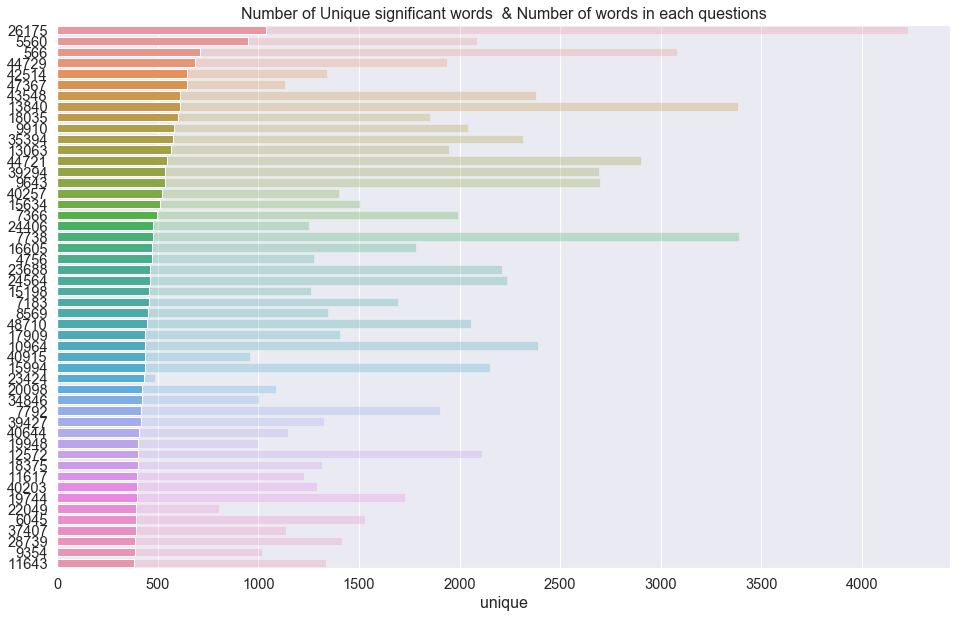

In [82]:
fig = plt.figure(figsize=(16, 10))
plt.title("Number of Unique significant words  & Number of words in each questions")
df_plot = df_stats2.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [83]:
df_plot.head()

total  unique
26175   4227    1035
5560    2087     949
566     3080     708
44729   1937     682
42514   1340     646

In [84]:
df_stats2.loc[26175]

total     4227
unique    1035
Name: 26175, dtype: int64

In [85]:
df_stats.loc[26175]

total     5119
unique    1096
Name: 26175, dtype: int64

### Stems of words in questions

In [86]:
def freq_stats_corpora3():
    '''
    Statistics about stems of words in questions
    '''
    corpora = defaultdict(list)
    stemmer = EnglishStemmer()
    # Création d'un corpus de tokens par artiste
    for id_curr,questions_curr in questions.items():
        try:
            tokens = tokenizer.tokenize(questions_curr.lower())
            corpora[id_curr] += \
                [stemmer.stem(w) for w in tokens if not w in list(sw)]
        except:
            print('Question {} : Error body empty'.format(id_curr))
            
    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

freq3, stats3, corpora3 = freq_stats_corpora3()

df_stats3 = pd.DataFrame.from_dict(stats3, orient='index')
df_stats3.head()

total  unique
3      35      23
4     211     108
9     141      50
10     12       9
12     34      23

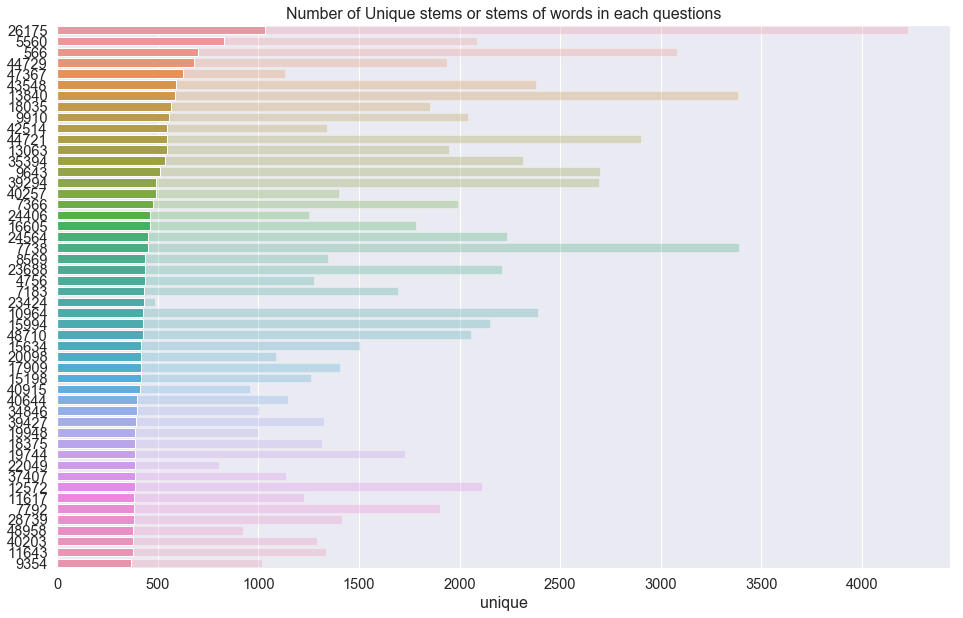

In [87]:
fig = plt.figure(figsize=(16, 10))
plt.title("Number of Unique stems or stems of words in each questions")
df_plot = df_stats3.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [88]:
df_plot.head()

total  unique
26175   4227    1030
5560    2087     829
566     3080     701
44729   1937     681
47367   1132     626

### Cleaning Text

In [89]:
token_dict = dict()
# for each questions, prepare token : lower, no ponctuation
for id_curr, questions_curr in questions.items():
    try:
        # save cleaned text into dict output
        token_dict[id_curr] = cleaning_text(questions_curr) 
    except:
        print('Question {} : Error body empty'.format(id_curr))

Cleaning Example : 

In [90]:
questions[3]

"How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"

In [91]:
token_dict[3]

'insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    '

In [92]:
#df_token = pd.DataFrame(token_dict)
df_token = pd.DataFrame.from_dict(token_dict, orient='index', columns=["token_text"])
df_token.head()

token_text
3   insert entry table exist   table looks sql ser...
4   system dmv  s missing sql server  master dacpa...
9   insert databse without page reload     insert ...
10  upload multipart amazon s3   upload amazon s3 ...
12  db2 sql crosstab   would output table   transf...

In [93]:
df_token.shape

(21208, 1)

In [94]:
df_quest_cleaned.shape

(21208, 38)

In [95]:
np.all(df_quest_cleaned.index == df_token.index)

True

In [96]:
df_quest_cleaned["token_text"] = df_token["token_text"]
df_quest_cleaned.head()

Id  PostTypeId  AcceptedAnswerId  ParentId         CreationDate  \
3   50000005           1        50000164.0       NaN  2018-04-24 11:00:01   
4   50000006           1        50117317.0       NaN  2018-04-24 11:00:01   
9   50000012           1               NaN       NaN  2018-04-24 11:00:25   
10  50000013           1               NaN       NaN  2018-04-24 11:00:27   
12  50000015           1        50000099.0       NaN  2018-04-24 11:00:31   

    DeletionDate  Score  ViewCount  \
3            NaN     -4       63.0   
4            NaN      0      199.0   
9            NaN     -3       37.0   
10           NaN     -1       42.0   
12           NaN      1      133.0   

                                                 Body  OwnerUserId  \
3   <p>My table looks like this  on sql server</p>...    8217447.0   
4   <p>I have Ola Hallengren's excellent Maintenan...    9690333.0   
9   <p>i want to insert data without page reload.\...    9690673.0   
10  <p>How to upload file in amazon s3 without cre...    5821228.0   
12  <p>I would like to output a table, transformed...    1570450.0   

   OwnerDisplayName  LastEditorUserId  \
3               NaN         3876565.0   
4               NaN               NaN   
9               NaN         9690673.0   
10              NaN               NaN   
12              NaN               NaN   

                          ...                         Tag_4 flag_Tag_0  \
3                         ...                           NaN       True   
4                         ...                           NaN       True   
9                         ...                           NaN       True   
10                        ...                           NaN       True   
12                        ...                           NaN       True   

   flag_Tag_1 flag_Tag_2 flag_Tag_3  flag_Tag_4  flag_most_Tagged_160  \
3        True       True      False       False                  True   
4       False      False      False       False                  True   
9        True       True      False       False                  True   
10       True      False      False       False                  True   
12      False      False      False       False                  True   

    flag_most_Tagged_100 flag_most_Tagged_76 flag_most_Tagged_40  \
3                   True                True                True   
4                   True                True                True   
9                   True                True                True   
10                  True                True                True   
12                  True                True                True   

                                                 Text  \
3   How to insert an entry to a table only if it d...   
4   System DMV's missing from SQL Server 2017 mast...   
9   how to insert data in databse without page rel...   
10  How to upload image using multipart in Amazon ...   
12  DB2 SQL CROSSTAB <p>I would like to output a t...   

                                           token_text  
3   insert entry table exist   table looks sql ser...  
4   system dmv  s missing sql server  master dacpa...  
9   insert databse without page reload     insert ...  
10  upload multipart amazon s3   upload amazon s3 ...  
12  db2 sql crosstab   would output table   transf...  

[5 rows x 39 columns]

### Separation train/test

In [97]:
train_percent = 0.8
np.random.seed(0)
indices_permut = np.random.permutation(df_quest_cleaned.shape[0])
df_quest_cleaned['Train'] = False
indices_permut_train = indices_permut[0:np.int(len(indices_permut)*train_percent)]
df_quest_cleaned['Train'].iloc[indices_permut_train] = True
df_quest_cleaned['Train'].value_counts()

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


True     16966
False     4242
Name: Train, dtype: int64

In [98]:
list_tags_raw_train=[]
for idx in range(0, 
                 df_quest_cleaned[df_quest_cleaned['Train'] == True].shape[0]):

    list_tags_raw_train = list_tags_raw_train + \
                            (re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                            df_quest_cleaned.iloc[idx].Tags))
list_tags_train = np.unique(list_tags_raw_train).tolist()

list_tags_raw_test=[]
for idx in range(0, 
                 df_quest_cleaned[df_quest_cleaned['Train'] == False].shape[0]):

    list_tags_raw_test = list_tags_raw_test + \
                            (re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                            df_quest_cleaned.iloc[idx].Tags))
list_tags_test = np.unique(list_tags_raw_test).tolist()

In [99]:
len(list_tags_train)

7820

In [100]:
len(list_tags_test)

3416

#### Check tags

##### For all  tags  :

In [101]:
print('Nb Tags in test but not in train :')
len(set(list(list_tags_test)).difference(set(list(list_tags_train))))

Nb Tags in test but not in train :


0

In [102]:
print('Nb Tags in train but not in test :')
len(set(list(list_tags_train)).difference(set(list(list_tags_test))))

Nb Tags in train but not in test :


4404

##### For most used Tags :

Check if some Tags, most used from Test set are not into most used from Train set

In [103]:
for idx, list_most_used_curr in enumerate(list_list_most_used):


    list_tags_most_test = set(list_tags_test).\
        intersection(set(list_most_used_curr))
    
    list_tags_most_train = set(list_tags_train).\
        intersection(set(list_most_used_curr))
    print("For {} most used Tags".\
          format(df_most["nb_most_used_tags"].iloc[idx]))
    print('Tags most used in Test not in Train set ?')
    print(list_tags_most_test.difference(list_tags_most_train))
    #list_tags_most_test.difference(list_tags_most_train)   

For 51 most used Tags
Tags most used in Test not in Train set ?
set()
For 73 most used Tags
Tags most used in Test not in Train set ?
set()
For 100 most used Tags
Tags most used in Test not in Train set ?
set()
For 201 most used Tags
Tags most used in Test not in Train set ?
set()


#### List of list of all Tags

In [104]:
# create list of list of Tags to be able to encode multi label outputs
print('\nFor train set...')  
list_list_all_tags_train = \
    create_tags_list_of_list(
    df_quest_cleaned[df_quest_cleaned.Train == True]["Tags"],
                            list_tags_most_used=None)
print(list_list_all_tags_train[:10])

print('\nFor test set...')  
list_list_all_tags_test = \
    create_tags_list_of_list(
    df_quest_cleaned[df_quest_cleaned.Train == False]["Tags"],
                            list_tags_most_used=None)
print(list_list_all_tags_test[:10])


For train set...
[['c#', 'sql', 'sql-server'], ['sql-server', 'sql-server-data-tools'], ['javascript', 'php', 'ajax'], ['android', 'amazon-s3', 'file-upload', 'multipart'], ['sql', 'db2', 'crosstab'], ['php', 'laravel'], ['python', 'anaconda', 'conda', 'spacy'], ['java', 'jackson'], ['javascript', 'json', 'reactjs', 'object'], ['android']]

For test set...
[['ios', 'objective-c'], ['ios', 'swift', 'storekit'], ['c++', 'qt', 'qt5', 'qchart', 'qchartview'], ['excel', 'vba', 'excel-vba'], ['android', 'gradle', 'fastlane'], ['sql-server', 'sql-server-2008'], ['c#', 'asp.net', 'bootstrap-4'], ['javascript', 'reactjs'], ['python', 'django'], ['javascript', 'angular', 'typescript', 'angular-routing', 'angular-router']]


#### Encode Multi label 
- First fit over all tags (train & test)
- Transform of list of list into encoded matrix  for :
    - Train real
    - Test real

In [105]:
mlb_lda = MultiLabelBinarizer()
mlb_lda.fit_transform(list_list_all_tags_train + list_list_all_tags_test)
# real
enc_lda_y_train = mlb_lda.transform(list_list_all_tags_train)
print("Train real shape:", enc_lda_y_train.shape)
enc_lda_y_test = mlb_lda.transform(list_list_all_tags_test)
print("Test real shape:", enc_lda_y_test.shape)

Train real shape: (16966, 8765)
Test real shape: (4242, 8765)


## Models unsupervised

In [153]:
nb_tags_eval_max = 10
no_top_words = 10

In [107]:
def find_doc_freq_word(word_curr, token_dict=token_dict):
    '''
    Calculate document frequency of a word into token_dict
    '''
    tf_vectorizer_special = CountVectorizer(vocabulary=[word_curr])
    tf_special = tf_vectorizer_special.fit_transform(token_dict.values())
    return tf_special.count_nonzero()/len(token_dict)

In [108]:
def find_doc_freq_list_words(list_words, token_dict=token_dict):
    '''
    Calculate document frequency of a list of words into token_dict
    '''
    nb_docs = len(token_dict)
    tf_vectorizer_special = CountVectorizer(vocabulary=list_words)
    tf_special = tf_vectorizer_special.fit_transform(token_dict.values())
    
    freqs_dict = []
    for id_list, word_curr in enumerate(list_words):
        freq_curr = np.nonzero(tf_special[:,id_list].todense())[0]\
            .shape[0]/nb_docs
        freqs_dict.append(freq_curr)
        print("{} = {}".format(word_curr, freq_curr))
    return freqs_dict

special_words = ["sql","c#","apple","ios","microsoft", "windows",
                 "android","google","javascript","php","css","html"]

print("Document Frequencies for")
doc_freqs = find_doc_freq_list_words(special_words)
print("max df = ",np.max(doc_freqs))

Document Frequencies for
sql = 0.05398906073179932
c# = 0.0
apple = 0.007167106752168993
ios = 0.016503206337231232
microsoft = 0.01952093549603923
windows = 0.03456242927197284
android = 0.023764617125612977
google = 0.041399471897397205
javascript = 0.04658619388909845
php = 0.04960392304790645
css = 0.04045643153526971
html = 0.06393813655224444
max df =  0.06393813655224444


#### Features
max_df=0.11, min_df=10

In [109]:
# init features
tf_vectorizer_1 = CountVectorizer(max_df=0.11, min_df=10, max_features=1000, 
                                tokenizer=myTokenizer)
tf_1 = tf_vectorizer_1.fit_transform(df_quest_cleaned[df_quest_cleaned.Train ==\
                                                 True]["token_text"])


#### Splits for CV optim

In [110]:
# Split parameters
random_state = 0
n_splits = 3
test_size = 0.3

# preparation des splits : choix de splits aléatoires de meme taille
cv_lda = model_selection.ShuffleSplit(n_splits=n_splits, test_size=test_size, 
                                  random_state=random_state)

### LDA 50 topics

#### Optim Fit



Train set used only

In [111]:
#Best Model's Params:  {'learning_decay': 0.7, 'max_iter': 30, 'n_components': 50}
#Best Log Likelihood Score:  -2332613.6264004773
#Model Perplexity:  362.02631743586585

# Define Search Param
search_params = {'n_components': [50], 
                 'learning_decay': [0.6, 0.7, 0.8],
                 'max_iter': [5, 10, 20]}# Init the Model

'''search_params = {'n_components': [50], 
                 'learning_decay': [0.7],
                 'max_iter': [20, 50, 100]}# Init the Model'''

"search_params = {'n_components': [50], \n                 'learning_decay': [0.7],\n                 'max_iter': [20, 50, 100]}# Init the Model"

In [112]:
# init model to optimize
lda_for_gcv_1 = LatentDirichletAllocation(learning_method='online',
                                          learning_offset=50., 
                                          random_state=0,
                                          n_jobs=-1)
# Init Grid Search Class
gcv_lda_1 = GridSearchCV(lda_for_gcv_1, param_grid=search_params, cv=cv_lda)

# Do the Grid Search
t_lda_0 = time.time()
gcv_lda_1.fit(tf_1)
t_lda_1 = time.time()
print("timing total: {} s".format(t_lda_1-t_lda_0))

timing total: 1629.18958902359 s


In [113]:
gcv_lda_1.best_params_

{'learning_decay': 0.7, 'max_iter': 20, 'n_components': 50}

In [114]:
# Best Model
best_lda_model_1 = gcv_lda_1.best_estimator_# Model Parameters
print("Best Model's Params: ", gcv_lda_1.best_params_)# Log Likelihood Score
print("Best Log Likelihood Score: ", gcv_lda_1.best_score_)# Perplexity
print("Model Perplexity: ", best_lda_model_1.perplexity(tf_1))

Best Model's Params:  {'learning_decay': 0.7, 'max_iter': 20, 'n_components': 50}
Best Log Likelihood Score:  -2106004.790329794
Model Perplexity:  362.96760265877276


In [115]:
df_res_1 = pd.DataFrame(data=gcv_lda_1.cv_results_)
df_res_1[df_res_1["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

1  \
mean_fit_time                                                   49.9811   
std_fit_time                                                    4.04928   
mean_score_time                                                 1.21495   
std_score_time                                                0.0894301   
param_learning_decay                                                0.6   
param_max_iter                                                       10   
param_n_components                                                   50   
params                {'learning_decay': 0.6, 'max_iter': 10, 'n_com...   
split0_test_score                                           -2.0668e+06   
split1_test_score                                          -2.10724e+06   
split2_test_score                                          -2.15496e+06   
mean_test_score                                            -2.10967e+06   
std_test_score                                                  36032.1   
rank_test_score                                                       3   
split0_train_score                                         -4.86943e+06   
split1_train_score                                         -4.85971e+06   
split2_train_score                                          -4.7962e+06   
mean_train_score                                           -4.84178e+06   
std_train_score                                                 32476.2   

                                                                      2  \
mean_fit_time                                                   81.7087   
std_fit_time                                                    1.36641   
mean_score_time                                                0.867426   
std_score_time                                                0.0305869   
param_learning_decay                                                0.6   
param_max_iter                                                       20   
param_n_components                                                   50   
params                {'learning_decay': 0.6, 'max_iter': 20, 'n_com...   
split0_test_score                                          -2.06523e+06   
split1_test_score                                           -2.1052e+06   
split2_test_score                                          -2.15272e+06   
mean_test_score                                            -2.10771e+06   
std_test_score                                                  35763.1   
rank_test_score                                                       2   
split0_train_score                                         -4.86727e+06   
split1_train_score                                         -4.85611e+06   
split2_train_score                                         -4.79223e+06   
mean_train_score                                           -4.83854e+06   
std_train_score                                                 33058.7   

                                                                      4  \
mean_fit_time                                                   44.6442   
std_fit_time                                                   0.331905   
mean_score_time                                                0.926887   
std_score_time                                                0.0452571   
param_learning_decay                                                0.7   
param_max_iter                                                       10   
param_n_components                                                   50   
params                {'learning_decay': 0.7, 'max_iter': 10, 'n_com...   
split0_test_score                                          -2.06742e+06   
split1_test_score                                           -2.1078e+06   
split2_test_score                                          -2.15793e+06   
mean_test_score                                            -2.11105e+06   
std_test_score                                                  37022.6   
rank_test_score   

##### Save

In [116]:
save_gridsearchcv_unsup(gcv_lda_1, df_res_1,"LDA")

learning_decay
0.7
max_iter
20
n_components
50
Results Saved here:
../../data/df_res_LDA__learning_decay0.7_max_iter20_n_components50.csv
Model Saved here:
../../data/model_LDA__learning_decay0.7_max_iter20_n_components50.pkl


#### Compare

In [117]:
df_res_lda50 = pd.read_csv(\
    '../../data/df_res_LDA__learning_decay0.7_max_iter20_n_components50.csv', 
    sep=',')

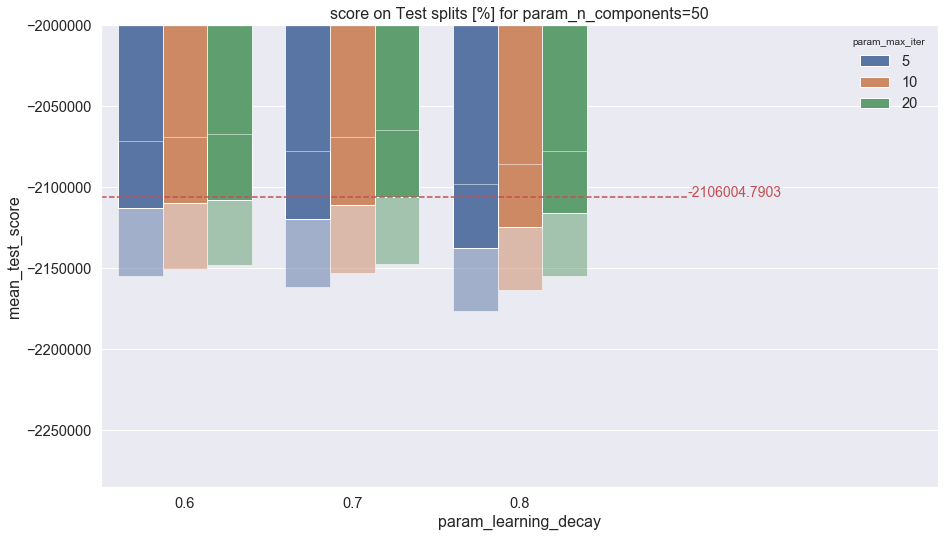

In [118]:
plot_res_test_split(df_res_lda50, "score", "param_learning_decay", 
                    "param_max_iter", y_min=-2000000,
                    myFixedParam="param_n_components",
                    myFixedValue=50, cv_eval=cv_lda)

#### Topics

In [119]:
# create & display topic dictionnary 
topic_dict_1 = display_topics(best_lda_model_1, 
                              tf_vectorizer_1.get_feature_names(), 
                              no_top_words)

Topic 0:
url page rout websit aw domain profil view load sign
Topic 1:
map let state convert func kafka nil locat share decod
Topic 2:
check video buffer mat arr edg durat camera media detect
Topic 3:
server connect client host port servic http resourc socket ssl
Topic 4:
system window generat applic net microsoft version project instal studio
Topic 5:
this compon react angular const consol state param export prop
Topic 6:
variabl question paramet pass someth possibl instanc answer function seem
Topic 7:
queri php databas sql echo mysql connect conn nbsp execut
Topic 8:
parent child play root tree children weight curl audio distanc
Topic 9:
input field custom control valid enter requir contact firstnam placehold
Topic 10:
java org apach lang spark util invok worker scala sun
Topic 11:
array access length pdf foreach push loop region token author
Topic 12:
item menu link action grid href nav temp toggl dropdown
Topic 13:
order product group price descript join amount role quantiti desc


#### Predict Topics for each documents

##### TF transform for all questions (Train & Test)

(TF vectoriser fitted already on Train set)

In [120]:
tf_all_1 = tf_vectorizer_1.transform(df_quest_cleaned["token_text"])

In [121]:
topics_pred_1 = best_lda_model_1.transform(tf_all_1)


In [122]:
topicNames_1 = []
for idx in range(0, gcv_lda_1.best_params_["n_components"]):
    topicNames_1.append("Topic_{}".format(idx))

df_topics_pred_1 = pd.DataFrame(data=topics_pred_1,
                                index=df_quest_cleaned.index,
                               columns=topicNames_1)
df_model_1 = df_quest_cleaned.join(
    df_topics_pred_1)

In [123]:
df_topics_pred_1.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
3   0.000833  0.000833  0.034823  0.045808  0.000833  0.000833  0.000833   
4   0.010288  0.000172  0.000172  0.085600  0.336001  0.000172  0.032023   
9   0.042956  0.000174  0.000174  0.000174  0.000174  0.000174  0.000174   
10  0.180700  0.002857  0.002857  0.002857  0.002857  0.002857  0.225171   
12  0.001818  0.001818  0.001818  0.001818  0.001818  0.001818  0.001818   

     Topic_7   Topic_8   Topic_9  Topic_10  Topic_11    ...     Topic_38  \
3   0.138528  0.000833  0.000833  0.000833  0.000833    ...     0.000833   
4   0.162703  0.000172  0.000172  0.000172  0.000172    ...     0.000172   
9   0.064933  0.000174  0.000174  0.000174  0.000174    ...     0.733647   
10  0.002857  0.002857  0.002857  0.002857  0.002857    ...     0.002857   
12  0.281558  0.001818  0.001818  0.001818  0.001818    ...     0.001818   

    Topic_39  Topic_40  Topic_41  Topic_42  Topic_43  Topic_44  Topic_45  \
3   0.000833  0.043158  0.000833  0.000833  0.000833  0.000833  0.000833   
4   0.000172  0.000172  0.000172  0.040887  0.000172  0.000172  0.000172   
9   0.000174  0.000174  0.021278  0.000174  0.000174  0.000174  0.000174   
10  0.002857  0.002857  0.002857  0.002857  0.002857  0.002857  0.002857   
12  0.001818  0.001818  0.001818  0.001818  0.001818  0.001818  0.001818   

    Topic_46  Topic_47  Topic_48  Topic_49  
3   0.000833  0.000833  0.000833  0.000833  
4   0.000172  0.015087  0.000172  0.000172  
9   0.000174  0.000174  0.000174  0.000174  
10  0.002857  0.002857  0.002857  0.002857  
12  0.092727  0.001818  0.001818  0.001818  

[5 rows x 50 columns]

In [124]:
df_topics_pred_1.shape

(21208, 50)

In [125]:
df_quest_cleaned.shape

(21208, 40)

In [126]:
df_model_1.shape

(21208, 90)

In [127]:
df_model_1.head()

Id  PostTypeId  AcceptedAnswerId  ParentId         CreationDate  \
3   50000005           1        50000164.0       NaN  2018-04-24 11:00:01   
4   50000006           1        50117317.0       NaN  2018-04-24 11:00:01   
9   50000012           1               NaN       NaN  2018-04-24 11:00:25   
10  50000013           1               NaN       NaN  2018-04-24 11:00:27   
12  50000015           1        50000099.0       NaN  2018-04-24 11:00:31   

    DeletionDate  Score  ViewCount  \
3            NaN     -4       63.0   
4            NaN      0      199.0   
9            NaN     -3       37.0   
10           NaN     -1       42.0   
12           NaN      1      133.0   

                                                 Body  OwnerUserId  \
3   <p>My table looks like this  on sql server</p>...    8217447.0   
4   <p>I have Ola Hallengren's excellent Maintenan...    9690333.0   
9   <p>i want to insert data without page reload.\...    9690673.0   
10  <p>How to upload file in amazon s3 without cre...    5821228.0   
12  <p>I would like to output a table, transformed...    1570450.0   

   OwnerDisplayName  LastEditorUserId    ...     Topic_38  Topic_39  Topic_40  \
3               NaN         3876565.0    ...     0.000833  0.000833  0.043158   
4               NaN               NaN    ...     0.000172  0.000172  0.000172   
9               NaN         9690673.0    ...     0.733647  0.000174  0.000174   
10              NaN               NaN    ...     0.002857  0.002857  0.002857   
12              NaN               NaN    ...     0.001818  0.001818  0.001818   

    Topic_41  Topic_42  Topic_43  Topic_44  Topic_45  Topic_46  Topic_47  \
3   0.000833  0.000833  0.000833  0.000833  0.000833  0.000833  0.000833   
4   0.000172  0.040887  0.000172  0.000172  0.000172  0.000172  0.015087   
9   0.021278  0.000174  0.000174  0.000174  0.000174  0.000174  0.000174   
10  0.002857  0.002857  0.002857  0.002857  0.002857  0.002857  0.002857   
12  0.001818  0.001818  0.001818  0.001818  0.001818  0.092727  0.001818   

    Topic_48  Topic_49  
3   0.000833  0.000833  
4   0.000172  0.000172  
9   0.000174  0.000174  
10  0.002857  0.002857  
12  0.001818  0.001818  

[5 rows x 90 columns]

Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_20', 'Topic_24', 'Topic_7', 'Topic_14'], dtype='object')
[20, 24, 7, 14]
Topic 20 : option git master branch merg featur commit append car procedur
Topic 24 : tabl row column insert entiti datafram book panda datat nan
Topic 7 : queri php databas sql echo mysql connect conn nbsp execut
Topic 14 : store header byte replac observ upload foo err pars subscrib


[20, 24, 7, 14]

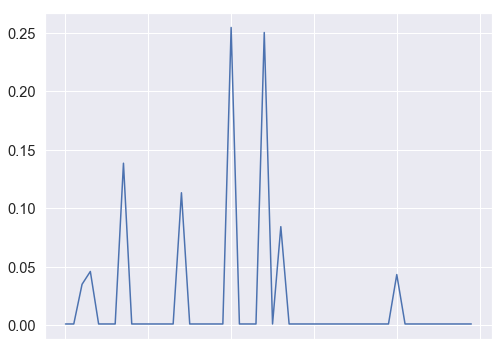

In [128]:
find_topics(0, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°123:
updating source second due output javascript eventlistener first page   scene  m figuring web development n t lot knowledge hope could help out      concept page choose due clicking change second page      linked first page   store source chosen variable result        result          document getelementbyid      choice1       addeventlistener      click            elem  document getelementbyid      choice1        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice2       addeventlistener      click            elem  document getelementbyid      choice2        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice3       addeventlistener      click            elem  document getelementbyid      choice3        result   window getcomputedstyle   elem   null    getpropertyvalue      backg

[21, 45]

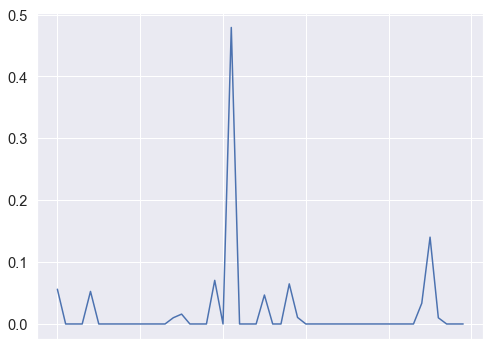

In [129]:
find_topics(123, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°132:
fabric wo n t let link firebase   firebase project  m trying link fabric      go fabric     firebase     integration select   says    already linked          go firebase console     project settings     integrations     fabric   n t see linked   see apps linked   one  m trying link right now      idea could happening   old firebase         fabric link   least see able remove    s nothing   fabric think already linked    s clearly    

Tags :  <firebase><google-fabric>

Index(['Topic_37', 'Topic_5', 'Topic_45', 'Topic_12', 'Topic_4'], dtype='object')
[37, 5, 45, 12, 4]
Topic 37 : set implement bind plot mode refer place interfac yes long
Topic 5 : this compon react angular const consol state param export prop
Topic 45 : differ two match output comment issu anoth current even condit
Topic 12 : item menu link action grid href nav temp toggl dropdown
Topic 4 : system window generat applic net microsoft version project instal studio


[37, 5, 45, 12, 4]

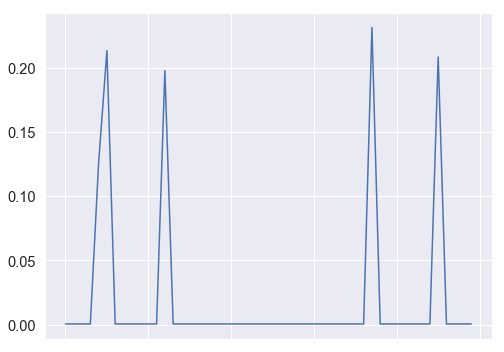

In [130]:
find_topics(132, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

#### Link Tags & Topics

##### Create table linking Tags & Topics :

Method :
- For each documents, and for each tags of the document : 
    - we add to its Tag line, its distribution by topics.
- So, Each tags line contains the sum of all topics distribution

In [131]:
# init dataFrame
df_topics_tags_raw = pd.DataFrame(index=list_unique_tags, columns=topicNames_1, 
                                  data=0)

df_model_1_topics = df_model_1[df_model_1["Train"] == True].filter(
    items=topicNames_1)

t_tags_topics_0 = time.time()
# for each docs, for each of its tags, add its topics distrib  
for idx in range(0, df_model_1_topics.shape[0]):
    list_tags_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_1[df_model_1["Train"] == True].\
                                iloc[idx].Tags)
    for tag_curr in list_tags_curr:
        if tag_curr in list_unique_tags:
            df_topics_tags_raw.loc[tag_curr] += df_model_1_topics.iloc[idx]
        #else:
            #print('Tag {} not into most frequent tags !', tag_curr)

t_tags_topics_1 = time.time()
print("timing total: {} s".format(t_tags_topics_1-t_tags_topics_0))


timing total: 210.68896794319153 s


In [132]:
df_topics_tags = df_topics_tags_raw.copy()

In [133]:
df_topics_tags.shape

(8765, 50)

In [134]:
df_topics_tags.head()

Topic_0   Topic_1   Topic_2   Topic_3    Topic_4   Topic_5  \
.app       0.000513  0.000513  0.000513  0.000513   0.109054  0.000513   
.htaccess  8.178083  0.393429  0.324689  1.597428   0.250720  0.073551   
.lib       0.000189  0.000189  0.000189  0.000189   0.052027  0.022203   
.net       1.825054  2.112060  1.292248  5.943302  15.867694  1.423031   
.net-1.1   0.001111  0.001111  0.001111  0.001111   0.458805  0.001111   

             Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  \
.app        0.252555  0.000513  0.000513  0.000513  0.000513  0.000513   
.htaccess   2.424008  2.513561  0.069231  0.192821  0.374836  0.606580   
.lib        0.000189  0.000189  0.000189  0.000189  0.000189  0.000189   
.net       16.463281  1.722198  0.317794  2.838427  0.256894  1.513227   
.net-1.1    0.001111  0.001111  0.001111  0.001111  0.001111  0.001111   

             ...     Topic_38  Topic_39  Topic_40  Topic_41  Topic_42  \
.app         ...     0.000513  0.000513  0.000513  0.000513  0.029108   
.htaccess    ...     0.161635  0.080537  0.290106  0.075546  0.137954   
.lib         ...     0.000189  0.000189  0.000189  0.000189  0.049841   
.net         ...     1.332603  1.277010  1.006914  0.885041  2.611520   
.net-1.1     ...     0.001111  0.001111  0.001111  0.056667  0.001111   

           Topic_43  Topic_44  Topic_45  Topic_46  Topic_47  Topic_48  \
.app       0.131755  0.000513  0.191745  0.000513  0.000513  0.000513   
.htaccess  0.558377  0.121340  1.726063  0.087984  0.325766  0.925721   
.lib       0.000189  0.000189  0.023148  0.000189  0.000189  0.000189   
.net       4.023922  3.338080  8.210594  0.592778  6.834209  1.765847   
.net-1.1   0.001111  0.001111  0.001111  0.001111  0.001111  0.001111   

           Topic_49  
.app       0.000513  
.htaccess  0.058560  
.lib       0.035141  
.net       3.345827  
.net-1.1   0.001111  

[5 rows x 50 columns]

In [135]:
df_model_1[df_model_1["Train"] == True].shape

(16966, 90)

In [136]:
df_model_1.head()

Id  PostTypeId  AcceptedAnswerId  ParentId         CreationDate  \
3   50000005           1        50000164.0       NaN  2018-04-24 11:00:01   
4   50000006           1        50117317.0       NaN  2018-04-24 11:00:01   
9   50000012           1               NaN       NaN  2018-04-24 11:00:25   
10  50000013           1               NaN       NaN  2018-04-24 11:00:27   
12  50000015           1        50000099.0       NaN  2018-04-24 11:00:31   

    DeletionDate  Score  ViewCount  \
3            NaN     -4       63.0   
4            NaN      0      199.0   
9            NaN     -3       37.0   
10           NaN     -1       42.0   
12           NaN      1      133.0   

                                                 Body  OwnerUserId  \
3   <p>My table looks like this  on sql server</p>...    8217447.0   
4   <p>I have Ola Hallengren's excellent Maintenan...    9690333.0   
9   <p>i want to insert data without page reload.\...    9690673.0   
10  <p>How to upload file in amazon s3 without cre...    5821228.0   
12  <p>I would like to output a table, transformed...    1570450.0   

   OwnerDisplayName  LastEditorUserId    ...     Topic_38  Topic_39  Topic_40  \
3               NaN         3876565.0    ...     0.000833  0.000833  0.043158   
4               NaN               NaN    ...     0.000172  0.000172  0.000172   
9               NaN         9690673.0    ...     0.733647  0.000174  0.000174   
10              NaN               NaN    ...     0.002857  0.002857  0.002857   
12              NaN               NaN    ...     0.001818  0.001818  0.001818   

    Topic_41  Topic_42  Topic_43  Topic_44  Topic_45  Topic_46  Topic_47  \
3   0.000833  0.000833  0.000833  0.000833  0.000833  0.000833  0.000833   
4   0.000172  0.040887  0.000172  0.000172  0.000172  0.000172  0.015087   
9   0.021278  0.000174  0.000174  0.000174  0.000174  0.000174  0.000174   
10  0.002857  0.002857  0.002857  0.002857  0.002857  0.002857  0.002857   
12  0.001818  0.001818  0.001818  0.001818  0.001818  0.092727  0.001818   

    Topic_48  Topic_49  
3   0.000833  0.000833  
4   0.000172  0.000172  
9   0.000174  0.000174  
10  0.002857  0.002857  
12  0.001818  0.001818  

[5 rows x 90 columns]

In [137]:
df_model_1_topics.shape

(16966, 50)

In [138]:
df_model_1_topics.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
3   0.000833  0.000833  0.034823  0.045808  0.000833  0.000833  0.000833   
4   0.010288  0.000172  0.000172  0.085600  0.336001  0.000172  0.032023   
9   0.042956  0.000174  0.000174  0.000174  0.000174  0.000174  0.000174   
10  0.180700  0.002857  0.002857  0.002857  0.002857  0.002857  0.225171   
12  0.001818  0.001818  0.001818  0.001818  0.001818  0.001818  0.001818   

     Topic_7   Topic_8   Topic_9  Topic_10  Topic_11    ...     Topic_38  \
3   0.138528  0.000833  0.000833  0.000833  0.000833    ...     0.000833   
4   0.162703  0.000172  0.000172  0.000172  0.000172    ...     0.000172   
9   0.064933  0.000174  0.000174  0.000174  0.000174    ...     0.733647   
10  0.002857  0.002857  0.002857  0.002857  0.002857    ...     0.002857   
12  0.281558  0.001818  0.001818  0.001818  0.001818    ...     0.001818   

    Topic_39  Topic_40  Topic_41  Topic_42  Topic_43  Topic_44  Topic_45  \
3   0.000833  0.043158  0.000833  0.000833  0.000833  0.000833  0.000833   
4   0.000172  0.000172  0.000172  0.040887  0.000172  0.000172  0.000172   
9   0.000174  0.000174  0.021278  0.000174  0.000174  0.000174  0.000174   
10  0.002857  0.002857  0.002857  0.002857  0.002857  0.002857  0.002857   
12  0.001818  0.001818  0.001818  0.001818  0.001818  0.001818  0.001818   

    Topic_46  Topic_47  Topic_48  Topic_49  
3   0.000833  0.000833  0.000833  0.000833  
4   0.000172  0.015087  0.000172  0.000172  
9   0.000174  0.000174  0.000174  0.000174  
10  0.002857  0.002857  0.002857  0.002857  
12  0.092727  0.001818  0.001818  0.001818  

[5 rows x 50 columns]

In [139]:
df_topics_tags.head()

Topic_0   Topic_1   Topic_2   Topic_3    Topic_4   Topic_5  \
.app       0.000513  0.000513  0.000513  0.000513   0.109054  0.000513   
.htaccess  8.178083  0.393429  0.324689  1.597428   0.250720  0.073551   
.lib       0.000189  0.000189  0.000189  0.000189   0.052027  0.022203   
.net       1.825054  2.112060  1.292248  5.943302  15.867694  1.423031   
.net-1.1   0.001111  0.001111  0.001111  0.001111   0.458805  0.001111   

             Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  \
.app        0.252555  0.000513  0.000513  0.000513  0.000513  0.000513   
.htaccess   2.424008  2.513561  0.069231  0.192821  0.374836  0.606580   
.lib        0.000189  0.000189  0.000189  0.000189  0.000189  0.000189   
.net       16.463281  1.722198  0.317794  2.838427  0.256894  1.513227   
.net-1.1    0.001111  0.001111  0.001111  0.001111  0.001111  0.001111   

             ...     Topic_38  Topic_39  Topic_40  Topic_41  Topic_42  \
.app         ...     0.000513  0.000513  0.000513  0.000513  0.029108   
.htaccess    ...     0.161635  0.080537  0.290106  0.075546  0.137954   
.lib         ...     0.000189  0.000189  0.000189  0.000189  0.049841   
.net         ...     1.332603  1.277010  1.006914  0.885041  2.611520   
.net-1.1     ...     0.001111  0.001111  0.001111  0.056667  0.001111   

           Topic_43  Topic_44  Topic_45  Topic_46  Topic_47  Topic_48  \
.app       0.131755  0.000513  0.191745  0.000513  0.000513  0.000513   
.htaccess  0.558377  0.121340  1.726063  0.087984  0.325766  0.925721   
.lib       0.000189  0.000189  0.023148  0.000189  0.000189  0.000189   
.net       4.023922  3.338080  8.210594  0.592778  6.834209  1.765847   
.net-1.1   0.001111  0.001111  0.001111  0.001111  0.001111  0.001111   

           Topic_49  
.app       0.000513  
.htaccess  0.058560  
.lib       0.035141  
.net       3.345827  
.net-1.1   0.001111  

[5 rows x 50 columns]

##### Normalisation by Topics

In [140]:
df_topics_tags_norm = df_topics_tags.copy()
#for label, content in df.items():
for topic_label, col_values in df_topics_tags_norm.items():
    #print(idx)
    df_topics_tags_norm[topic_label] = col_values/col_values.sum()
df_topics_tags_norm.head()

Topic_0       Topic_1       Topic_2       Topic_3   Topic_4  \
.app       4.509172e-07  6.065168e-07  1.276192e-06  3.535169e-07  0.000066   
.htaccess  7.190894e-03  4.653114e-04  8.080127e-04  1.101200e-03  0.000152   
.lib       1.659035e-07  2.231524e-07  4.695422e-07  1.300675e-07  0.000032   
.net       1.604749e-03  2.497949e-03  3.215853e-03  4.097062e-03  0.009638   
.net-1.1   9.769872e-07  1.314120e-06  2.765082e-06  7.659532e-07  0.000279   

                Topic_5       Topic_6       Topic_7       Topic_8  \
.app       3.781677e-07  6.228574e-05  4.948287e-07  1.514871e-06   
.htaccess  5.423854e-05  5.978144e-04  2.425375e-03  2.045080e-04   
.lib       1.637308e-05  4.653251e-08  1.820596e-07  5.573582e-07   
.net       1.049381e-03  4.060212e-03  1.661776e-03  9.387621e-04   
.net-1.1   8.193634e-07  2.740248e-07  1.072129e-06  3.282220e-06   

                Topic_9      Topic_10      Topic_11      ...       \
.app       6.047302e-07  8.290133e-07  6.766797e-07      ...        
.htaccess  2.273788e-04  6.059502e-04  8.003977e-04      ...        
.lib       2.224951e-07  3.050143e-07  2.489670e-07      ...        
.net       3.347141e-03  4.152886e-04  1.996742e-03      ...        
.net-1.1   1.310249e-06  1.796195e-06  1.466139e-06      ...        

               Topic_38      Topic_39      Topic_40      Topic_41  Topic_42  \
.app       5.062885e-07  8.774394e-07  8.924925e-07  1.037703e-06  0.000036   
.htaccess  1.595761e-04  1.377996e-04  5.048893e-04  1.528683e-04  0.000170   
.lib       1.862759e-07  3.228315e-07  3.283699e-07  3.817965e-07  0.000061   
.net       1.315629e-03  2.184972e-03  1.752393e-03  1.790899e-03  0.003222   
.net-1.1   1.096958e-06  1.901119e-06  1.933734e-06  1.146662e-04  0.000001   

               Topic_43      Topic_44      Topic_45      Topic_46  \
.app       1.092827e-04  6.568514e-07  5.977760e-05  1.945498e-06   
.htaccess  4.631401e-04  1.554196e-04  5.381091e-04  3.337850e-04   
.lib       1.564981e-07  2.416718e-07  7.216594e-06  7.157965e-07   
.net       3.337602e-03  4.275614e-03  2.559695e-03  2.248836e-03   
.net-1.1   9.216000e-07  1.423178e-06  3.463946e-07  4.215246e-06   

               Topic_47      Topic_48      Topic_49  
.app       5.658764e-07  8.301219e-07  4.064455e-07  
.htaccess  3.594690e-04  1.498500e-03  4.641314e-05  
.lib       2.081998e-07  3.054222e-07  2.785180e-05  
.net       7.541270e-03  2.858444e-03  2.651798e-03  
.net-1.1   1.226066e-06  1.798597e-06  8.806319e-07  

[5 rows x 50 columns]

In [141]:
np.sum(df_topics_tags_norm, axis=0)

Topic_0     1.0
Topic_1     1.0
Topic_2     1.0
Topic_3     1.0
Topic_4     1.0
Topic_5     1.0
Topic_6     1.0
Topic_7     1.0
Topic_8     1.0
Topic_9     1.0
Topic_10    1.0
Topic_11    1.0
Topic_12    1.0
Topic_13    1.0
Topic_14    1.0
Topic_15    1.0
Topic_16    1.0
Topic_17    1.0
Topic_18    1.0
Topic_19    1.0
Topic_20    1.0
Topic_21    1.0
Topic_22    1.0
Topic_23    1.0
Topic_24    1.0
Topic_25    1.0
Topic_26    1.0
Topic_27    1.0
Topic_28    1.0
Topic_29    1.0
Topic_30    1.0
Topic_31    1.0
Topic_32    1.0
Topic_33    1.0
Topic_34    1.0
Topic_35    1.0
Topic_36    1.0
Topic_37    1.0
Topic_38    1.0
Topic_39    1.0
Topic_40    1.0
Topic_41    1.0
Topic_42    1.0
Topic_43    1.0
Topic_44    1.0
Topic_45    1.0
Topic_46    1.0
Topic_47    1.0
Topic_48    1.0
Topic_49    1.0
dtype: float64

In [142]:
df_topics_tags = df_topics_tags_norm.copy()
df_topics_tags.shape

(8765, 50)

#### Predict tags : Topics Distrib method
Method : 
For each texts of document : 
    - evaluate Topics distrib from LDA
    - for each Topics, multiply by Tags distrib per Topics from table Tags & Topics
    - sum for each Tags to have a score per Tags
    - keeps the nth first ranking Tags 

In [143]:
# example 1st question
text_test = df_quest_cleaned.iloc[0]["Text"]
print(text_test)
# clean the text
text_cleaned = cleaning_text(text_test)

# calculate feature from text
feat_curr =  tf_vectorizer_1.transform([text_cleaned])

# calculate topic distrib
topic_distrib_pred = best_lda_model_1.transform(feat_curr)

How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>

<pre><code>wordId     word      
----------------
1214       pen           
1215       men    
1216       cat  
</code></pre>

<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>



In [144]:
arr_tags = df_topics_tags.values*topic_distrib_pred
arr_tags.shape

(8765, 50)

In [145]:
sum_distrib_tags = arr_tags.sum(axis=1)
sum_distrib_tags.shape

(8765,)

In [146]:
df_sum_tags = pd.DataFrame(data=sum_distrib_tags, columns=["d_sum"], 
                           index=df_topics_tags.index)
df_sum_tags.head()

d_sum
.app       0.000001
.htaccess  0.000715
.lib       0.000001
.net       0.002347
.net-1.1   0.000002

In [147]:
'''
['php',
 'javascript',
 'python',
 'mysql',
 'html',
 'laravel',
 'vue.js',
 'java',
 'wordpress',
 'sql']
'''
print("\nReal Tags: ", df_quest_cleaned.iloc[0]["Tags"])
print("\nPredicted Tags: ",df_sum_tags.sort_values(by="d_sum", 
                                                 ascending=False).head(10).index)


Real Tags:  <c#><sql><sql-server>

Predicted Tags:  Index(['python', 'php', 'javascript', 'sql', 'mysql', 'java', 'git', 'c#',
       'pandas', 'sql-server'],
      dtype='object')


In [148]:
find_tags_from_dtopics(topic_distrib_pred, df_topics_tags, no_max=10)

['python',
 'php',
 'javascript',
 'sql',
 'mysql',
 'java',
 'git',
 'c#',
 'pandas',
 'sql-server']

In [149]:
# example  question
text_test = df_quest_cleaned.iloc[0]["Text"]
print(text_test)
print("Tags : ", df_quest_cleaned.iloc[0]["Tags"])
# predicted tags
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_1,
                    lda_model = best_lda_model_1, df_topics_tags=df_topics_tags,
                    no_max=10)


How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>

<pre><code>wordId     word      
----------------
1214       pen           
1215       men    
1216       cat  
</code></pre>

<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>

Tags :  <c#><sql><sql-server>


['python',
 'php',
 'javascript',
 'sql',
 'mysql',
 'java',
 'git',
 'c#',
 'pandas',
 'sql-server']

In [150]:
# example  question
text_test = df_quest_cleaned.iloc[18]["Text"]
print(text_test)
print("Tags : ", df_quest_cleaned.iloc[18]["Tags"])
# predicted tags
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_1,
                    lda_model = best_lda_model_1, df_topics_tags=df_topics_tags,
                    no_max=10)


Display name of properties when looping through errors <p>I am new to Spring so bear with me!</p>

<p>I am trying to adjust the display name of properties of an entity in Spring boot.</p>

<p>I have a form with the following inside to display all errors:</p>

<pre><code>&lt;ul&gt;
    &lt;li th:each="e : ${#fields.detailedErrors()}" th:class="${e.global}? globalerr : fielderr"&gt;
        &lt;span th:text="${e.global}? '*' : ${e.fieldName}"&gt;The field name&lt;/span&gt;
        &lt;span th:text="${e.message}"&gt;The error message&lt;/span&gt;
    &lt;/li&gt;
&lt;/ul&gt;
</code></pre>

<p>That results in the following message upon invalid input:</p>

<blockquote>
  <p>Error Saving New User - Please Try Again
  lastName must not be empty <br>
  firstName size must be between 1 and 30<br>
  lastName size must be between 1 and 30<br>
  firstName must not be empty<br></p>
</blockquote>

<p>I have tried adjusting the property to accommodate a display name to no avail:</p>

<pre><code>@NotEm

['javascript',
 'python',
 'java',
 'html',
 'php',
 'c#',
 'jquery',
 'angular',
 'android',
 'css']

In [151]:
# example  question
text_test = df_quest_cleaned.iloc[123]["Text"]
print(text_test)
print("Tags : ", df_quest_cleaned.iloc[123]["Tags"])
# predicted tags
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_1,
                    lda_model = best_lda_model_1, df_topics_tags=df_topics_tags,
                    no_max=10)


Updating source of an image in a second html due to output of a JavaScript eventlistener of the first html page <p>just to set the scene I'm figuring out web development on my own so don't have a lot of knowledge and I hope you could help me out.</p>

<p>So the concept is on HTML page 1 I choose a image and due to the clicking I change it in the second html page.</p>

<p>This is the js file linked to the first html page. Here I store my source of the chosen image in the variable result.</p>

<pre><code>result="";

document.getElementById("choice1").addEventListener("click", function() { 
var elem =document.getElementById("choice1");
result = window.getComputedStyle(elem, null).getPropertyValue("background-image");
return result
});

document.getElementById("choice2").addEventListener("click", function() { 
var elem =document.getElementById("choice2");
result  = window.getComputedStyle(elem, null).getPropertyValue("background-image");
return result
});

document.getElementById("choice3"

['javascript',
 'html',
 'jquery',
 'python',
 'css',
 'php',
 'java',
 'c#',
 'android',
 'angular']

#### Evaluation Topics Distrib method



##### Create list of list with Predicted Tags for each Text Questions list

In [154]:
t_train_0 = time.time() 
list_tags_predicted_train = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == True]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)
t_train_1 = time.time()

t_pred_0 = time.time() 
list_tags_predicted_test = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == False]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_pred_1 = time.time() # time to predict test
print("timing total: {} s".format(t_pred_1-t_train_0))

print("\nFor Train:\n", list_tags_predicted_train[:10])
print("\nFor Test:\n", list_tags_predicted_test[:10])

timing total: 437.33974385261536 s

For Train:
 [['python', 'php', 'javascript', 'sql', 'mysql', 'java', 'git', 'c#', 'pandas', 'sql-server'], ['python', 'php', 'c#', 'javascript', 'java', 'android', 'mysql', 'sql', 'html', 'git'], ['javascript', 'html', 'jquery', 'php', 'css', 'python', 'angular', 'c#', 'java', 'ajax'], ['javascript', 'python', 'java', 'php', 'c#', 'android', 'angular', 'html', 'node.js', 'c++'], ['sql', 'php', 'python', 'mysql', 'pandas', 'sql-server', 'javascript', 'c#', 'r', 'java'], ['javascript', 'python', 'php', 'java', 'node.js', 'c#', 'angular', 'mysql', 'android', 'sql'], ['python', 'javascript', 'java', 'r', 'c#', 'android', 'php', 'python-3.x', 'c++', 'sql'], ['android', 'java', 'javascript', 'python', 'c#', 'php', 'ios', 'swift', 'json', 'sql'], ['javascript', 'python', 'java', 'php', 'c#', 'html', 'jquery', 'angular', 'android', 'reactjs'], ['python', 'javascript', 'java', 'c#', 'php', 'android', 'c++', 'html', 'excel', 'r']]

For Test:
 [['javascript', '

In [155]:
len(list_list_all_tags_train)

16966

In [156]:
len(list_tags_predicted_train)

16966

In [157]:
len(list_list_all_tags_test)

4242

In [158]:
len(list_tags_predicted_test)

4242

##### Encode predictions

For : 
    - Train predicted
    - Test predicted

In [159]:
# predicted
enc_lda_ypred_train = mlb_lda.transform(list_tags_predicted_train)
print("Train real shape:", enc_lda_ypred_train.shape)
enc_lda_ypred_test = mlb_lda.transform(list_tags_predicted_test)
print("Test real shape:", enc_lda_ypred_test.shape)

Train real shape: (16966, 8765)
Test real shape: (4242, 8765)


In [160]:
df_Tags.shape

(8765, 1)

##### Evaluate different scorings

In [161]:
accuracy_score(enc_lda_y_train, enc_lda_ypred_train)

0.0

In [162]:
accuracy_score(enc_lda_y_test, enc_lda_ypred_test)

0.0

In [163]:
precision_score(enc_lda_y_train, enc_lda_ypred_train, average='micro')

0.09159495461511258

In [164]:
precision_score(enc_lda_y_test, enc_lda_ypred_test, average='micro')

0.08932107496463933

In [165]:
recall_score(enc_lda_y_train, enc_lda_ypred_train, average='micro')

0.3107316390394113

In [166]:
recall_score(enc_lda_y_test, enc_lda_ypred_test, average='micro')

0.30164795796513016

In [167]:
f1_score(enc_lda_y_train, enc_lda_ypred_train, average='micro')

0.14148431062816666

In [168]:
f1_score(enc_lda_y_test, enc_lda_ypred_test, average='micro')

0.13782943198559502

In [169]:
2 * (0.09141223623718024 * 0.31011177540940993) / (0.09141223623718024 + 0.31011177540940993)

0.1412020703688698

In [170]:
find_nb_no_tags(enc_lda_ypred_train)
find_nb_no_tags(enc_lda_ypred_test)

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]


0

In [171]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_lda_ypred_train,
                          enc_lda_y_test, enc_lda_ypred_test, 
                          t_lda_1 - t_lda_0 + t_tags_topics_1 + t_tags_topics_0,
                          t_pred_1 - t_pred_0)

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]


In [172]:
df_results = add_score(df_results, series_scores, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     no_top_words))
df_results

create df_results


f1_splits_test  f1_splits_test_std  acc_train  acc_test  \
LDA_top50_tags10        0.141678            0.000771        0.0       0.0   

                  pre_train  pre_test  rec_train  rec_test  f1_train  \
LDA_top50_tags10   0.091595  0.089321   0.310732  0.301648  0.141484   

                   f1_test  notags_train  notags_test   t_fit_train  \
LDA_top50_tags10  0.137829           0.0          0.0  3.144184e+09   

                  t_pred_test  
LDA_top50_tags10     66.58734

##### Evaluate for each nb Tags max

In [173]:
for nb_tags_max in [1, 2, 3, 4, 5, 6]:
    # select max tags
    list_tags_predicted_train_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_train]
    list_tags_predicted_test_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_test]
    # predict
    enc_lda_ypred_train_curr = mlb_lda.transform(list_tags_predicted_train_curr)
    enc_lda_ypred_test_curr = mlb_lda.transform(list_tags_predicted_test_curr)
    # score
    series_scores_curr = evaluate_mdl_scorings(enc_lda_y_train, 
                          enc_lda_ypred_train_curr,
                          enc_lda_y_test, 
                          enc_lda_ypred_test_curr, 
                          t_lda_1 - t_lda_0 + t_tags_topics_1 - t_tags_topics_0, 
                          t_pred_1-t_pred_0)
    df_results = add_score(df_results, series_scores_curr, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     nb_tags_max))
df_results

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line


f1_splits_test  f1_splits_test_std  acc_train  acc_test  \
LDA_top50_tags10        0.141678            0.000771   0.000000  0.000000   
LDA_top50_tags1         0.139635            0.000250   0.016975  0.017445   
LDA_top50_tags2         0.162595            0.000955   0.006955  0.006129   
LDA_top50_tags3         0.171949            0.001617   0.002476  0.002357   
LDA_top50_tags4         0.173857            0.001200   0.000648  0.000236   
LDA_top50_tags5         0.172366            0.001016   0.000000  0.000000   
LDA_top50_tags6         0.165265            0.000587   0.000000  0.000000   

                  pre_train  pre_test  rec_train  rec_test  f1_train  \
LDA_top50_tags10   0.091595  0.089321   0.310732  0.301648  0.141484   
LDA_top50_tags1    0.278793  0.273692   0.094579  0.092429  0.141243   
LDA_top50_tags2    0.201963  0.189769   0.137030  0.128175  0.163277   
LDA_top50_tags3    0.170419  0.161245   0.173442  0.163363  0.171917   
LDA_top50_tags4    0.150802  0.144743   0.204635  0.195526  0.173642   
LDA_top50_tags5    0.136261  0.133145   0.231129  0.224823  0.171446   
LDA_top50_tags6    0.123364  0.121326   0.251105  0.245840  0.165447   

                   f1_test  notags_train  notags_test   t_fit_train  \
LDA_top50_tags10  0.137829           0.0          0.0  3.144184e+09   
LDA_top50_tags1   0.138190           0.0          0.0  3.144184e+09   
LDA_top50_tags2   0.153005           0.0          0.0  3.144184e+09   
LDA_top50_tags3   0.162297           0.0          0.0  3.144184e+09   
LDA_top50_tags4   0.166345           0.0          0.0  3.144184e+09   
LDA_top50_tags5   0.167244           0.0          0.0  3.144184e+09   
LDA_top50_tags6   0.162471           0.0          0.0  3.144184e+09   

                  t_pred_test  
LDA_top50_tags10     66.58734  
LDA_top50_tags1      66.58734  
LDA_top50_tags2      66.58734  
LDA_top50_tags3      66.58734  
LDA_top50_tags4      66.58734  
LDA_top50_tags5      66.58734  
LDA_top50_tags6      66.58734

### LDA 25 Topics

#### Optim Fit

Features same : max_df=0.11, min_df=10

Train set used only

In [174]:
#Best Model's Params:  {'learning_decay': 0.7, 'max_iter': 30, 'n_components': 50}
#Best Log Likelihood Score:  -2332613.6264004773
#Model Perplexity:  362.02631743586585

# Define Search Param
search_params = {'n_components': [25], 
                 'learning_decay': [0.6, 0.7, 0.8],
                 'max_iter': [5, 10, 20]}# Init the Model

In [175]:
# init model to optimize
lda_for_gcv_1 = LatentDirichletAllocation(learning_method='online',
                                          learning_offset=50., 
                                          random_state=0,
                                          n_jobs=-1)
# Init Grid Search Class
gcv_lda_1 = GridSearchCV(lda_for_gcv_1, param_grid=search_params, cv=cv_lda)

# Do the Grid Search
t_lda_0 = time.time()
gcv_lda_1.fit(tf_1)
t_lda_1 = time.time()
print("timing total: {} s".format(t_lda_1-t_lda_0))

timing total: 1470.0040400028229 s


In [176]:
gcv_lda_1.best_params_

{'learning_decay': 0.6, 'max_iter': 20, 'n_components': 25}

In [177]:
# Best Model
best_lda_model_1 = gcv_lda_1.best_estimator_# Model Parameters
print("Best Model's Params: ", gcv_lda_1.best_params_)# Log Likelihood Score
print("Best Log Likelihood Score: ", gcv_lda_1.best_score_)# Perplexity
print("Model Perplexity: ", best_lda_model_1.perplexity(tf_1))

Best Model's Params:  {'learning_decay': 0.6, 'max_iter': 20, 'n_components': 25}
Best Log Likelihood Score:  -2118742.807093353
Model Perplexity:  389.4917697545264


In [178]:
df_res_1 = pd.DataFrame(data=gcv_lda_1.cv_results_)
df_res_1[df_res_1["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

1  \
mean_fit_time                                                   37.8213   
std_fit_time                                                     1.9448   
mean_score_time                                                0.821709   
std_score_time                                               0.00148464   
param_learning_decay                                                0.6   
param_max_iter                                                       10   
param_n_components                                                   25   
params                {'learning_decay': 0.6, 'max_iter': 10, 'n_com...   
split0_test_score                                          -2.07999e+06   
split1_test_score                                          -2.11534e+06   
split2_test_score                                          -2.16618e+06   
mean_test_score                                             -2.1205e+06   
std_test_score                                                  35377.1   
rank_test_score                                                       3   
split0_train_score                                         -4.91559e+06   
split1_train_score                                         -4.87869e+06   
split2_train_score                                         -4.83443e+06   
mean_train_score                                           -4.87624e+06   
std_train_score                                                 33178.1   

                                                                      2  \
mean_fit_time                                                   68.7881   
std_fit_time                                                    1.81238   
mean_score_time                                                0.848525   
std_score_time                                                0.0864696   
param_learning_decay                                                0.6   
param_max_iter                                                       20   
param_n_components                                                   25   
params                {'learning_decay': 0.6, 'max_iter': 20, 'n_com...   
split0_test_score                                           -2.0785e+06   
split1_test_score                                          -2.11321e+06   
split2_test_score                                          -2.16452e+06   
mean_test_score                                            -2.11874e+06   
std_test_score                                                  35335.2   
rank_test_score                                                       1   
split0_train_score                                         -4.91247e+06   
split1_train_score                                         -4.87451e+06   
split2_train_score                                         -4.83144e+06   
mean_train_score                                           -4.87281e+06   
std_train_score                                                 33102.1   

                                                                      4  \
mean_fit_time                                                   38.5107   
std_fit_time                                                   0.898687   
mean_score_time                                                0.861244   
std_score_time                                                0.0300299   
param_learning_decay                                                0.7   
param_max_iter                                                       10   
param_n_components                                                   25   
params                {'learning_decay': 0.7, 'max_iter': 10, 'n_com...   
split0_test_score                                          -2.08199e+06   
split1_test_score                                           -2.1187e+06   
split2_test_score                                          -2.16824e+06   
mean_test_score                                            -2.12298e+06   
std_test_score                                                  35340.4   
rank_test_score   

##### Save

In [179]:
save_gridsearchcv_unsup(gcv_lda_1, df_res_1,"LDA")

learning_decay
0.6
max_iter
20
n_components
25
Results Saved here:
../../data/df_res_LDA__learning_decay0.6_max_iter20_n_components25.csv
Model Saved here:
../../data/model_LDA__learning_decay0.6_max_iter20_n_components25.pkl


#### Compare

In [180]:
df_res_lda25 = pd.read_csv(\
    '../../data/df_res_LDA__learning_decay0.6_max_iter20_n_components25.csv', 
    sep=',')

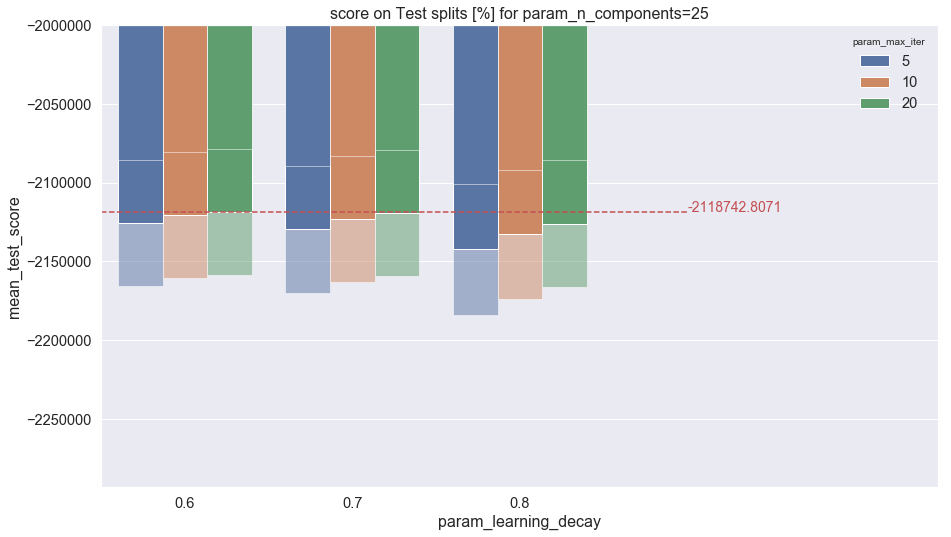

In [181]:
plot_res_test_split(df_res_lda25, "score", "param_learning_decay", 
                    "param_max_iter", y_min=-2000000,
                    myFixedParam="param_n_components",
                    myFixedValue=25, cv_eval=cv_lda)

#### Topics

In [182]:
# create & display topic dictionnary 

topic_dict_1 = display_topics(best_lda_model_1, 
                              tf_vectorizer_1.get_feature_names(), 
                              no_top_words)

Topic 0:
issu seem applic point someth project differ howev solut set
Topic 1:
self def python val print str django init video worker
Topic 2:
button form div label option input click control span btn
Topic 3:
server connect password client usernam session host port job authent
Topic 4:
system node generat out xml println net serial microsoft void
Topic 5:
map compon state event key consol react const angular export
Topic 6:
this privat param paramet bind observ attribut constructor student subscrib
Topic 7:
tabl queri sql databas row column null insert mysql echo
Topic 8:
row column data input csv train num output sum layer
Topic 9:
model field index custom valid spark entiti save max true
Topic 10:
start process thread command window long execut stream byte except
Topic 11:
array number variabl element length search loop question answer sort
Topic 12:
item data link menu word tab icon href templat nav
Topic 13:
date product group count filter order categori null day price
Topic 14:
e

#### Predict Topics for each documents

##### TF transform for all questions (Train & Test)

(TF vectoriser fitted already on Train set)

In [183]:
topics_pred_1 = best_lda_model_1.transform(tf_all_1)


In [184]:
topicNames_1 = []
for idx in range(0, gcv_lda_1.best_params_["n_components"]):
    topicNames_1.append("Topic_{}".format(idx))

df_topics_pred_1 = pd.DataFrame(data=topics_pred_1,
                                index=df_quest_cleaned.index,
                               columns=topicNames_1)
df_model_1 = df_quest_cleaned.join(
    df_topics_pred_1)

In [185]:
df_topics_pred_1.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
3   0.001667  0.001667  0.001667  0.047059  0.001667  0.001667  0.001667   
4   0.084940  0.037856  0.000345  0.100107  0.116375  0.000345  0.000345   
9   0.000348  0.000348  0.666516  0.000348  0.000348  0.000348  0.000348   
10  0.269552  0.005714  0.005714  0.162165  0.005714  0.005714  0.005714   
12  0.003636  0.003636  0.003636  0.003636  0.003636  0.003636  0.003636   

     Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  \
3   0.637301  0.001667  0.001667  0.001667  0.111523  0.169116  0.001667   
4   0.174523  0.000345  0.000345  0.000345  0.000345  0.021922  0.000345   
9   0.048587  0.000348  0.000348  0.000348  0.000348  0.000348  0.000348   
10  0.005714  0.005714  0.005714  0.005714  0.005714  0.005714  0.005714   
12  0.535946  0.380418  0.003636  0.003636  0.003636  0.003636  0.003636   

    Topic_14  Topic_15  Topic_16  Topic_17  Topic_18  Topic_19  Topic_20  \
3   0.001667  0.001667  0.001667  0.001667  0.001667  0.001667  0.001667   
4   0.038330  0.000345  0.000345  0.381849  0.000345  0.000345  0.000345   
9   0.000348  0.000348  0.000348  0.000348  0.000348  0.000348  0.000348   
10  0.005714  0.005714  0.005714  0.005714  0.005714  0.005714  0.005714   
12  0.003636  0.003636  0.003636  0.003636  0.003636  0.003636  0.003636   

    Topic_21  Topic_22  Topic_23  Topic_24  
3   0.001667  0.001667  0.001667  0.001667  
4   0.027288  0.000345  0.000345  0.011638  
9   0.052983  0.079321  0.000348  0.145637  
10  0.005714  0.005714  0.005714  0.442569  
12  0.003636  0.003636  0.003636  0.003636

In [186]:
df_topics_pred_1.shape

(21208, 25)

Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_7', 'Topic_12', 'Topic_11'], dtype='object')
[7, 12, 11]
Topic 7 : tabl queri sql databas row column null insert mysql echo
Topic 12 : item data link menu word tab icon href templat nav
Topic 11 : array number variabl element length search loop question answer sort


[7, 12, 11]

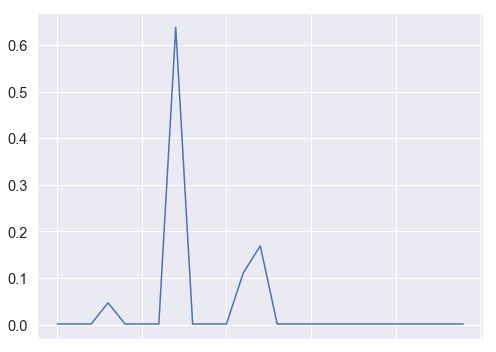

In [187]:
find_topics(0, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°123:
updating source second due output javascript eventlistener first page   scene  m figuring web development n t lot knowledge hope could help out      concept page choose due clicking change second page      linked first page   store source chosen variable result        result          document getelementbyid      choice1       addeventlistener      click            elem  document getelementbyid      choice1        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice2       addeventlistener      click            elem  document getelementbyid      choice2        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice3       addeventlistener      click            elem  document getelementbyid      choice3        result   window getcomputedstyle   elem   null    getpropertyvalue      backg

[21, 19, 4]

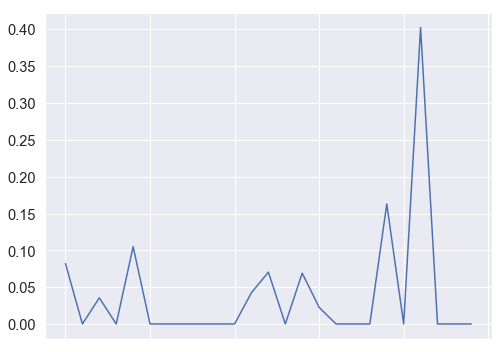

In [188]:
find_topics(123, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°132:
fabric wo n t let link firebase   firebase project  m trying link fabric      go fabric     firebase     integration select   says    already linked          go firebase console     project settings     integrations     fabric   n t see linked   see apps linked   one  m trying link right now      idea could happening   old firebase         fabric link   least see able remove    s nothing   fabric think already linked    s clearly    

Tags :  <firebase><google-fabric>

Index(['Topic_0', 'Topic_20', 'Topic_12', 'Topic_15'], dtype='object')
[0, 20, 12, 15]
Topic 0 : issu seem applic point someth project differ howev solut set
Topic 20 : springframework properti core releas spring web bean depend boot version
Topic 12 : item data link menu word tab icon href templat nav
Topic 15 : messag user servic api googl json status access token task


[0, 20, 12, 15]

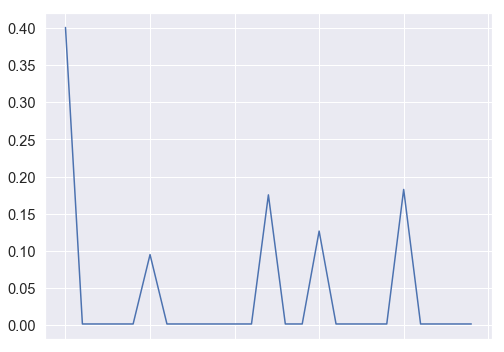

In [189]:
find_topics(132, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

#### Link Tags & Topics

##### Create table linking Tags & Topics :

Method :
- For each documents, and for each tags of the document : 
    - we add to its Tag line, its distribution by topics.
- So, Each tags line contains the sum of all topics distribution

In [190]:
# init dataFrame
df_topics_tags_raw = pd.DataFrame(index=list_unique_tags, columns=topicNames_1, 
                                  data=0)

df_model_1_topics = df_model_1[df_model_1["Train"] == True].filter(
    items=topicNames_1)

t_tags_topics_0 = time.time()
# for each docs, for each of its tags, add its topics distrib  
for idx in range(0, df_model_1_topics.shape[0]):
    list_tags_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_1[df_model_1["Train"] == True].\
                                iloc[idx].Tags)
    for tag_curr in list_tags_curr:
        if tag_curr in list_unique_tags:
            df_topics_tags_raw.loc[tag_curr] += df_model_1_topics.iloc[idx]
        #else:
            #print('Tag {} not into most frequent tags !', tag_curr)

t_tags_topics_1 = time.time()
print("timing total: {} s".format(t_tags_topics_1-t_tags_topics_0))


timing total: 326.1463129520416 s


In [191]:
df_topics_tags = df_topics_tags_raw.copy()

In [192]:
df_topics_tags.shape

(8765, 25)

In [193]:
df_topics_tags.head()

Topic_0   Topic_1   Topic_2   Topic_3    Topic_4   Topic_5  \
.app        0.373658  0.001026  0.001026  0.001026   0.058953  0.001026   
.htaccess   4.719133  0.284176  0.187200  1.231663   0.402984  0.215679   
.lib        0.000377  0.000377  0.000377  0.000377   0.063013  0.000377   
.net       17.885563  1.194747  2.933043  6.768866  13.774883  3.336514   
.net-1.1    0.123720  0.002222  0.002222  0.002222   0.347079  0.066890   

            Topic_6   Topic_7   Topic_8   Topic_9   Topic_10  Topic_11  \
.app       0.001026  0.001026  0.032588  0.001026   0.123235  0.154955   
.htaccess  0.212509  0.818004  0.170438  1.250646   0.317618  1.354384   
.lib       0.057779  0.000377  0.000377  0.000377   0.000377  0.000377   
.net       3.846401  4.479572  2.318702  4.053081  13.036099  9.627378   
.net-1.1   0.002222  0.002222  0.002222  0.002222   0.002222  0.002222   

           Topic_12  Topic_13  Topic_14  Topic_15  Topic_16  Topic_17  \
.app       0.080944  0.001026  0.001026  0.001026  0.001026  0.101988   
.htaccess  0.051524  0.839283  1.201438  1.447842  0.323493  3.354350   
.lib       0.000377  0.000377  0.000377  0.000377  0.656588  0.204616   
.net       1.705233  4.887964  9.685765  9.410184  4.126240  9.913639   
.net-1.1   0.002222  0.002222  0.002222  0.002222  0.002222  0.002222   

           Topic_18  Topic_19  Topic_20  Topic_21  Topic_22  Topic_23  \
.app       0.001026  0.001026  0.028173  0.029096  0.001026  0.001026   
.htaccess  0.420809  0.779750  0.168870  0.770513  0.413135  0.109928   
.lib       0.000377  0.010456  0.000377  0.000377  0.000377  0.000377   
.net       0.450964  2.161666  3.437085  4.898563  3.184652  1.884622   
.net-1.1   0.002222  0.255368  0.162499  0.002222  0.002222  0.002222   

            Topic_24  
.app        0.001026  
.htaccess  12.954631  
.lib        0.000377  
.net        3.998572  
.net-1.1    0.002222

In [194]:
df_model_1_topics.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
3   0.001667  0.001667  0.001667  0.047059  0.001667  0.001667  0.001667   
4   0.084940  0.037856  0.000345  0.100107  0.116375  0.000345  0.000345   
9   0.000348  0.000348  0.666516  0.000348  0.000348  0.000348  0.000348   
10  0.269552  0.005714  0.005714  0.162165  0.005714  0.005714  0.005714   
12  0.003636  0.003636  0.003636  0.003636  0.003636  0.003636  0.003636   

     Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  \
3   0.637301  0.001667  0.001667  0.001667  0.111523  0.169116  0.001667   
4   0.174523  0.000345  0.000345  0.000345  0.000345  0.021922  0.000345   
9   0.048587  0.000348  0.000348  0.000348  0.000348  0.000348  0.000348   
10  0.005714  0.005714  0.005714  0.005714  0.005714  0.005714  0.005714   
12  0.535946  0.380418  0.003636  0.003636  0.003636  0.003636  0.003636   

    Topic_14  Topic_15  Topic_16  Topic_17  Topic_18  Topic_19  Topic_20  \
3   0.001667  0.001667  0.001667  0.001667  0.001667  0.001667  0.001667   
4   0.038330  0.000345  0.000345  0.381849  0.000345  0.000345  0.000345   
9   0.000348  0.000348  0.000348  0.000348  0.000348  0.000348  0.000348   
10  0.005714  0.005714  0.005714  0.005714  0.005714  0.005714  0.005714   
12  0.003636  0.003636  0.003636  0.003636  0.003636  0.003636  0.003636   

    Topic_21  Topic_22  Topic_23  Topic_24  
3   0.001667  0.001667  0.001667  0.001667  
4   0.027288  0.000345  0.000345  0.011638  
9   0.052983  0.079321  0.000348  0.145637  
10  0.005714  0.005714  0.005714  0.442569  
12  0.003636  0.003636  0.003636  0.003636

##### Normalisation by Topics

In [195]:
df_topics_tags_norm = df_topics_tags.copy()
#for label, content in df.items():
for topic_label, col_values in df_topics_tags_norm.items():
    #print(idx)
    df_topics_tags_norm[topic_label] = col_values/col_values.sum()
df_topics_tags_norm.head()

Topic_0       Topic_1       Topic_2       Topic_3   Topic_4  \
.app       7.597173e-05  8.678326e-07  5.439125e-07  5.149632e-07  0.000038   
.htaccess  9.594880e-04  2.404517e-04  9.927508e-05  6.184044e-04  0.000260   
.lib       7.672403e-08  3.192969e-07  2.001188e-07  1.894676e-07  0.000041   
.net       3.636469e-03  1.010920e-03  1.555436e-03  3.398574e-03  0.008882   
.net-1.1   2.515459e-05  1.880304e-06  1.178477e-06  1.115754e-06  0.000224   

                Topic_5       Topic_6       Topic_7       Topic_8  \
.app       5.704095e-07  9.702187e-07  4.504697e-07  1.616586e-05   
.htaccess  1.199500e-04  2.010258e-04  3.592738e-04  8.454835e-05   
.lib       2.098677e-07  5.465718e-05  1.657388e-07  1.871946e-07   
.net       1.855600e-03  3.638554e-03  1.967464e-03  1.150228e-03   
.net-1.1   3.720091e-05  2.102141e-06  9.760176e-07  1.102368e-06   

                Topic_9      Topic_10      Topic_11      Topic_12  \
.app       8.791766e-07  6.337237e-05  4.277801e-05  7.817736e-05   
.htaccess  1.072050e-03  1.633316e-04  3.739014e-04  4.976281e-05   
.lib       3.234706e-07  1.940522e-07  1.041765e-07  3.644616e-07   
.net       3.474290e-03  6.703663e-03  2.657807e-03  1.646954e-03   
.net-1.1   1.904883e-06  1.142752e-06  6.134836e-07  2.146274e-06   

               Topic_13      Topic_14      Topic_15      Topic_16  \
.app       7.068347e-07  3.208570e-07  4.106891e-07  6.461454e-07   
.htaccess  5.784032e-04  3.758524e-04  5.797478e-04  2.037981e-04   
.lib       2.600618e-07  1.180512e-07  1.511026e-07  4.136453e-04   
.net       3.368608e-03  3.030052e-03  3.768044e-03  2.599497e-03   
.net-1.1   1.531475e-06  6.951901e-07  8.898264e-07  1.399982e-06   

               Topic_17      Topic_18      Topic_19      Topic_20  \
.app       3.023326e-05  1.154110e-06  4.070996e-07  3.327889e-05   
.htaccess  9.943630e-04  4.735181e-04  3.094999e-04  1.994771e-04   
.lib       6.065643e-05  4.246254e-07  4.150031e-06  4.457533e-07   
.net       2.938798e-03  5.074501e-04  8.580133e-04  4.060044e-03   
.net-1.1   6.587552e-07  2.500572e-06  1.013612e-04  1.919510e-04   

               Topic_21      Topic_22      Topic_23      Topic_24  
.app       1.990846e-05  5.989812e-07  7.314223e-07  3.900591e-07  
.htaccess  5.272144e-04  2.412737e-04  7.839372e-05  4.926745e-03  
.lib       2.582030e-07  2.203799e-07  2.691082e-07  1.435123e-07  
.net       3.351783e-03  1.859858e-03  1.343993e-03  1.520687e-03  
.net-1.1   1.520529e-06  1.297793e-06  1.584748e-06  8.451280e-07

In [196]:
df_topics_tags = df_topics_tags_norm.copy()
df_topics_tags.shape

(8765, 25)

#### Evaluation Topics Distrib method



##### Create list of list with Predicted Tags for each Text Questions list

In [197]:
       
t_train_0 = time.time() 
list_tags_predicted_train = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == True]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_train_1 = time.time()

t_pred_0 = time.time() 
list_tags_predicted_test = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == False]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_pred_1 = time.time() # time to predict test
print("timing total: {} s".format(t_pred_1-t_train_0))

print("\nFor Train:\n", list_tags_predicted_train[:10])
print("\nFor Test:\n", list_tags_predicted_test[:10])

timing total: 438.76724314689636 s

For Train:
 [['sql', 'mysql', 'php', 'javascript', 'sql-server', 'python', 'c#', 'java', 'html', 'oracle'], ['python', 'java', 'javascript', 'c#', 'php', 'sql', 'mysql', 'android', 'node.js', 'sql-server'], ['javascript', 'html', 'jquery', 'php', 'css', 'python', 'c#', 'angular', 'java', 'ajax'], ['javascript', 'php', 'python', 'java', 'c#', 'html', 'android', 'node.js', 'jquery', 'angular'], ['python', 'sql', 'mysql', 'php', 'r', 'sql-server', 'pandas', 'javascript', 'java', 'c#'], ['python', 'javascript', 'php', 'java', 'c#', 'android', 'node.js', 'html', 'angular', 'jquery'], ['python', 'javascript', 'java', 'c#', 'android', 'php', 'node.js', 'python-3.x', 'git', 'r'], ['android', 'java', 'javascript', 'python', 'c#', 'php', 'angular', 'sql', 'r', 'arrays'], ['javascript', 'python', 'php', 'java', 'c#', 'android', 'html', 'angular', 'jquery', 'node.js'], ['python', 'javascript', 'java', 'php', 'c#', 'sql', 'android', 'c++', 'html', 'r']]

For Test

##### Encode predictions

For : 
    - Train predicted
    - Test predicted

In [198]:
# predicted
enc_lda_ypred_train = mlb_lda.transform(list_tags_predicted_train)
print("Train real shape:", enc_lda_ypred_train.shape)
enc_lda_ypred_test = mlb_lda.transform(list_tags_predicted_test)
print("Test real shape:", enc_lda_ypred_test.shape)

Train real shape: (16966, 8765)
Test real shape: (4242, 8765)


##### Evaluate different scorings

In [200]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_lda_ypred_train,
                          enc_lda_y_test, enc_lda_ypred_test, 
                          t_lda_1 - t_lda_0 + t_tags_topics_1 + t_tags_topics_0,
                          t_pred_1 - t_pred_0)

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]


In [201]:
df_results = add_score(df_results, series_scores, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     no_top_words))
df_results

add line


f1_splits_test  f1_splits_test_std  acc_train  acc_test  \
LDA_top50_tags10        0.141678            0.000771   0.000000  0.000000   
LDA_top50_tags1         0.139635            0.000250   0.016975  0.017445   
LDA_top50_tags2         0.162595            0.000955   0.006955  0.006129   
LDA_top50_tags3         0.171949            0.001617   0.002476  0.002357   
LDA_top50_tags4         0.173857            0.001200   0.000648  0.000236   
LDA_top50_tags5         0.172366            0.001016   0.000000  0.000000   
LDA_top50_tags6         0.165265            0.000587   0.000000  0.000000   
LDA_top25_tags10        0.136579            0.000297   0.000000  0.000000   

                  pre_train  pre_test  rec_train  rec_test  f1_train  \
LDA_top50_tags10   0.091595  0.089321   0.310732  0.301648  0.141484   
LDA_top50_tags1    0.278793  0.273692   0.094579  0.092429  0.141243   
LDA_top50_tags2    0.201963  0.189769   0.137030  0.128175  0.163277   
LDA_top50_tags3    0.170419  0.161245   0.173442  0.163363  0.171917   
LDA_top50_tags4    0.150802  0.144743   0.204635  0.195526  0.173642   
LDA_top50_tags5    0.136261  0.133145   0.231129  0.224823  0.171446   
LDA_top50_tags6    0.123364  0.121326   0.251105  0.245840  0.165447   
LDA_top25_tags10   0.088023  0.085950   0.298614  0.290264  0.135967   

                   f1_test  notags_train  notags_test   t_fit_train  \
LDA_top50_tags10  0.137829           0.0          0.0  3.144184e+09   
LDA_top50_tags1   0.138190           0.0          0.0  3.144184e+09   
LDA_top50_tags2   0.153005           0.0          0.0  3.144184e+09   
LDA_top50_tags3   0.162297           0.0          0.0  3.144184e+09   
LDA_top50_tags4   0.166345           0.0          0.0  3.144184e+09   
LDA_top50_tags5   0.167244           0.0          0.0  3.144184e+09   
LDA_top50_tags6   0.162471           0.0          0.0  3.144184e+09   
LDA_top25_tags10  0.132628           0.0          0.0  3.144201e+09   

                  t_pred_test  
LDA_top50_tags10    66.587340  
LDA_top50_tags1     66.587340  
LDA_top50_tags2     66.587340  
LDA_top50_tags3     66.587340  
LDA_top50_tags4     66.587340  
LDA_top50_tags5     66.587340  
LDA_top50_tags6     66.587340  
LDA_top25_tags10    71.963846

##### Evaluate for each nb Tags max

In [202]:
for nb_tags_max in [1, 2, 3, 4, 5, 6]:
    # select max tags
    list_tags_predicted_train_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_train]
    list_tags_predicted_test_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_test]
    # predict
    enc_lda_ypred_train_curr = mlb_lda.transform(list_tags_predicted_train_curr)
    enc_lda_ypred_test_curr = mlb_lda.transform(list_tags_predicted_test_curr)
    # score
    series_scores_curr = evaluate_mdl_scorings(enc_lda_y_train, 
                          enc_lda_ypred_train_curr,
                          enc_lda_y_test, 
                          enc_lda_ypred_test_curr, 
                          t_lda_1 - t_lda_0 + t_tags_topics_1 - t_tags_topics_0, 
                          t_pred_1-t_pred_0)
    df_results = add_score(df_results, series_scores_curr, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     nb_tags_max))
df_results

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line


f1_splits_test  f1_splits_test_std  acc_train  acc_test  \
LDA_top50_tags10        0.141678            0.000771   0.000000  0.000000   
LDA_top50_tags1         0.139635            0.000250   0.016975  0.017445   
LDA_top50_tags2         0.162595            0.000955   0.006955  0.006129   
LDA_top50_tags3         0.171949            0.001617   0.002476  0.002357   
LDA_top50_tags4         0.173857            0.001200   0.000648  0.000236   
LDA_top50_tags5         0.172366            0.001016   0.000000  0.000000   
LDA_top50_tags6         0.165265            0.000587   0.000000  0.000000   
LDA_top25_tags10        0.136579            0.000297   0.000000  0.000000   
LDA_top25_tags1         0.137544            0.001813   0.015325  0.015559   
LDA_top25_tags2         0.161006            0.001770   0.006012  0.006129   
LDA_top25_tags3         0.169592            0.000736   0.002240  0.002593   
LDA_top25_tags4         0.168388            0.000125   0.000589  0.000471   
LDA_top25_tags5         0.164371            0.000361   0.000000  0.000000   
LDA_top25_tags6         0.157607            0.000213   0.000000  0.000000   

                  pre_train  pre_test  rec_train  rec_test  f1_train  \
LDA_top50_tags10   0.091595  0.089321   0.310732  0.301648  0.141484   
LDA_top50_tags1    0.278793  0.273692   0.094579  0.092429  0.141243   
LDA_top50_tags2    0.201963  0.189769   0.137030  0.128175  0.163277   
LDA_top50_tags3    0.170419  0.161245   0.173442  0.163363  0.171917   
LDA_top50_tags4    0.150802  0.144743   0.204635  0.195526  0.173642   
LDA_top50_tags5    0.136261  0.133145   0.231129  0.224823  0.171446   
LDA_top50_tags6    0.123364  0.121326   0.251105  0.245840  0.165447   
LDA_top25_tags10   0.088023  0.085950   0.298614  0.290264  0.135967   
LDA_top25_tags1    0.275551  0.269213   0.093479  0.090916  0.139600   
LDA_top25_tags2    0.200961  0.196605   0.136350  0.132792  0.162467   
LDA_top25_tags3    0.168160  0.159987   0.171142  0.162089  0.169638   
LDA_top25_tags4    0.145733  0.139026   0.197756  0.187804  0.167805   
LDA_top25_tags5    0.130013  0.124422   0.220531  0.210095  0.163585   
LDA_top25_tags6    0.116989  0.113272   0.238128  0.229520  0.156897   

                   f1_test  notags_train  notags_test   t_fit_train  \
LDA_top50_tags10  0.137829           0.0          0.0  3.144184e+09   
LDA_top50_tags1   0.138190           0.0          0.0  3.144184e+09   
LDA_top50_tags2   0.153005           0.0          0.0  3.144184e+09   
LDA_top50_tags3   0.162297           0.0          0.0  3.144184e+09   
LDA_top50_tags4   0.166345           0.0          0.0  3.144184e+09   
LDA_top50_tags5   0.167244           0.0          0.0  3.144184e+09   
LDA_top50_tags6   0.162471           0.0          0.0  3.144184e+09   
LDA_top25_tags10  0.132628           0.0          0.0  3.144201e+09   
LDA_top25_tags1   0.135928           0.0          0.0  3.144201e+09   
LDA_top25_tags2   0.158517           0.0          0.0  3.144201e+09   
LDA_top25_tags3   0.161031           0.0          0.0  3.144201e+09   
LDA_top25_tags4   0.159775           0.0          0.0  3.144201e+09   
LDA_top25_tags5   0.156288           0.0          0.0  3.144201e+09   
LDA_top25_tags6   0.151685           0.0          0.0  3.144201e+09   

                  t_pred_test  
LDA_top50_tags10    66.587340  
LDA_top50_tags1     66.587340  
LDA_top50_tags2     66.587340  
LDA_top50_tags3     66.587340  
LDA_top50_tags4     66.587340  
LDA_top50_tags5     66.587340  
LDA_top50_tags6     66.587340  
LDA_top25_tags10    71.963846  
LDA_top25_tags1     71.963846  
LDA_top25_tags2     71.963846  
LDA_top25_tags3     71.963846  
LDA_top25_tags4     71.963846  
LDA_top25_tags5     71.963846  
LDA_top25_tags6     71.963846

### LDA 100 Topics

#### Optim Fit

Features same : max_df=0.11, min_df=10

Train set used only

In [203]:
#Best Model's Params:  {'learning_decay': 0.7, 'max_iter': 30, 'n_components': 50}
#Best Log Likelihood Score:  -2332613.6264004773
#Model Perplexity:  362.02631743586585

# Define Search Param
search_params = {'n_components': [100], 
                 'learning_decay': [0.6, 0.7, 0.8],
                 'max_iter': [5, 10, 20]}# Init the Model

In [204]:
# init model to optimize
lda_for_gcv_1 = LatentDirichletAllocation(learning_method='online',
                                          learning_offset=50., 
                                          random_state=0,
                                          n_jobs=-1)
# Init Grid Search Class
gcv_lda_1 = GridSearchCV(lda_for_gcv_1, param_grid=search_params, cv=cv_lda)

# Do the Grid Search
t_lda_0 = time.time()
gcv_lda_1.fit(tf_1)
t_lda_1 = time.time()
print("timing total: {} s".format(t_lda_1-t_lda_0))

timing total: 2543.188785791397 s


In [205]:
gcv_lda_1.best_params_

{'learning_decay': 0.7, 'max_iter': 20, 'n_components': 100}

In [206]:
# Best Model
best_lda_model_1 = gcv_lda_1.best_estimator_# Model Parameters
print("Best Model's Params: ", gcv_lda_1.best_params_)# Log Likelihood Score
print("Best Log Likelihood Score: ", gcv_lda_1.best_score_)# Perplexity
print("Model Perplexity: ", best_lda_model_1.perplexity(tf_1))

Best Model's Params:  {'learning_decay': 0.7, 'max_iter': 20, 'n_components': 100}
Best Log Likelihood Score:  -2118153.8298210567
Model Perplexity:  368.8572202498595


In [207]:
df_res_1 = pd.DataFrame(data=gcv_lda_1.cv_results_)
df_res_1[df_res_1["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

1  \
mean_fit_time                                                   70.2723   
std_fit_time                                                    2.23043   
mean_score_time                                                 1.08893   
std_score_time                                                 0.100026   
param_learning_decay                                                0.6   
param_max_iter                                                       10   
param_n_components                                                  100   
params                {'learning_decay': 0.6, 'max_iter': 10, 'n_com...   
split0_test_score                                          -2.08648e+06   
split1_test_score                                          -2.11508e+06   
split2_test_score                                          -2.16739e+06   
mean_test_score                                            -2.12298e+06   
std_test_score                                                  33500.8   
rank_test_score                                                       4   
split0_train_score                                         -4.92064e+06   
split1_train_score                                         -4.87951e+06   
split2_train_score                                         -4.82344e+06   
mean_train_score                                           -4.87453e+06   
std_train_score                                                 39839.1   

                                                                      2  \
mean_fit_time                                                   133.059   
std_fit_time                                                    4.64374   
mean_score_time                                                  1.1108   
std_score_time                                                0.0437553   
param_learning_decay                                                0.6   
param_max_iter                                                       20   
param_n_components                                                  100   
params                {'learning_decay': 0.6, 'max_iter': 20, 'n_com...   
split0_test_score                                          -2.08515e+06   
split1_test_score                                          -2.11379e+06   
split2_test_score                                          -2.16623e+06   
mean_test_score                                            -2.12172e+06   
std_test_score                                                  33572.2   
rank_test_score                                                       2   
split0_train_score                                         -4.91706e+06   
split1_train_score                                         -4.87751e+06   
split2_train_score                                          -4.8215e+06   
mean_train_score                                           -4.87202e+06   
std_train_score                                                 39202.2   

                                                                      4  \
mean_fit_time                                                   71.9475   
std_fit_time                                                    3.90883   
mean_score_time                                                 1.10673   
std_score_time                                                0.0781771   
param_learning_decay                                                0.7   
param_max_iter                                                       10   
param_n_components                                                  100   
params                {'learning_decay': 0.7, 'max_iter': 10, 'n_com...   
split0_test_score                                          -2.08552e+06   
split1_test_score                                          -2.11395e+06   
split2_test_score                                           -2.1685e+06   
mean_test_score                                            -2.12266e+06   
std_test_score                                                  34432.5   
rank_test_score   

##### Save

In [208]:
save_gridsearchcv_unsup(gcv_lda_1, df_res_1,"LDA")

learning_decay
0.7
max_iter
20
n_components
100
Results Saved here:
../../data/df_res_LDA__learning_decay0.7_max_iter20_n_components100.csv
Model Saved here:
../../data/model_LDA__learning_decay0.7_max_iter20_n_components100.pkl


#### Compare

In [209]:
df_res_lda100 = pd.read_csv(\
    '../../data/df_res_LDA__learning_decay0.7_max_iter20_n_components100.csv', 
    sep=',')

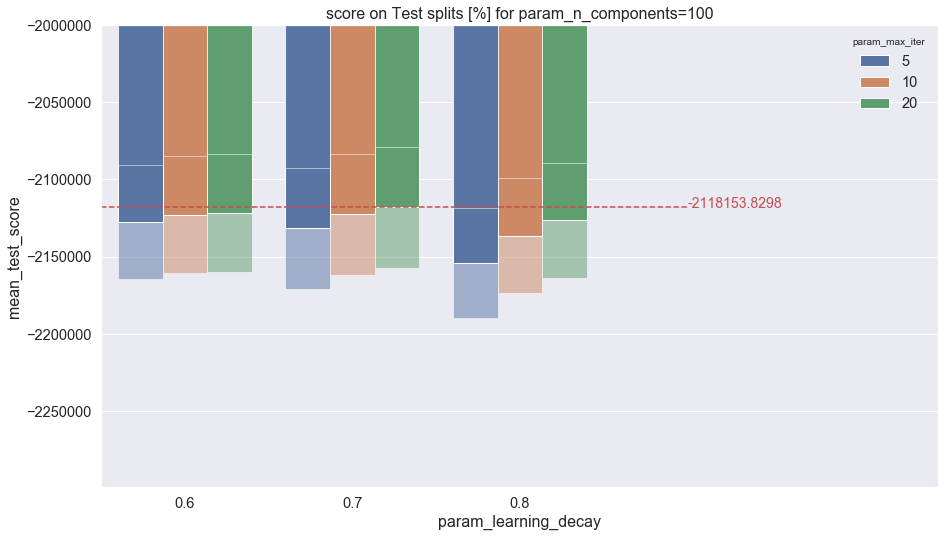

In [210]:
plot_res_test_split(df_res_lda100, "score", "param_learning_decay", 
                    "param_max_iter", y_min=-2000000,
                    myFixedParam="param_n_components",
                    myFixedValue=100, cv_eval=cv_lda)

##### Best model for n_components=100:
- max_iter: 20
- learning_decay: 0.7

#### Topics

In [211]:
# create & display topic dictionnary 

topic_dict_1 = display_topics(best_lda_model_1, 
                              tf_vectorizer_1.get_feature_names(), 
                              no_top_words)

Topic 0:
effect store timeout hour wonder sheet domain great manual combin
Topic 1:
web resourc secur ssl agent certif constraint ident verifi allow
Topic 2:
label length photo min month arr edit set sender yet
Topic 3:
void view overrid this price model context activ oncreat click
Topic 4:
match rout mode hello contact pattern laravel world free exact
Topic 5:
key right player handler left migrat asset press move current
Topic 6:
this word attribut student channel languag subscrib next constructor foreach
Topic 7:
tabl databas sql echo mysql queri insert book conn record
Topic 8:
index color posit modal asp section red blue pos squar
Topic 9:
singl sourc email filter phone subscrib iter back achiev anoth
Topic 10:
bar plot score chart axi panda point seri mean zero
Topic 11:
row column col datafram datat nan age uniqu drop base
Topic 12:
item link menu href grid nav temp dropdown navbar toggl
Topic 13:
order product price join inner quantiti desc left queri descript
Topic 14:
nav devi

#### Predict Topics for each documents

##### TF transform for all questions (Train & Test)

(TF vectoriser fitted already on Train set)

In [212]:
topics_pred_1 = best_lda_model_1.transform(tf_all_1)


In [213]:
topicNames_1 = []
for idx in range(0, gcv_lda_1.best_params_["n_components"]):
    topicNames_1.append("Topic_{}".format(idx))

df_topics_pred_1 = pd.DataFrame(data=topics_pred_1,
                                index=df_quest_cleaned.index,
                               columns=topicNames_1)
df_model_1 = df_quest_cleaned.join(
    df_topics_pred_1)

In [214]:
df_topics_pred_1.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
3   0.000417  0.000417  0.000417  0.000417  0.000417  0.000417  0.084731   
4   0.000086  0.000086  0.000086  0.000086  0.000086  0.000086  0.000086   
9   0.000087  0.000087  0.000087  0.000087  0.000087  0.000087  0.000087   
10  0.001429  0.001429  0.001429  0.001429  0.001429  0.001429  0.001429   
12  0.000909  0.000909  0.000909  0.000909  0.000909  0.000909  0.000909   

     Topic_7   Topic_8   Topic_9  Topic_10  Topic_11    ...     Topic_88  \
3   0.394752  0.000417  0.000417  0.000417  0.000417    ...     0.000417   
4   0.117589  0.000086  0.000086  0.000086  0.000086    ...     0.398352   
9   0.000087  0.000087  0.000087  0.000087  0.000087    ...     0.000087   
10  0.001429  0.001429  0.001429  0.001429  0.001429    ...     0.001429   
12  0.368838  0.000909  0.000909  0.000909  0.432387    ...     0.000909   

    Topic_89  Topic_90  Topic_91  Topic_92  Topic_93  Topic_94  Topic_95  \
3   0.000417  0.000417  0.000417  0.000417  0.000417  0.000417  0.000417   
4   0.094914  0.000086  0.011058  0.000086  0.000086  0.000086  0.000086   
9   0.000087  0.000087  0.054886  0.000087  0.000087  0.000087  0.026213   
10  0.001429  0.001429  0.001429  0.001429  0.001429  0.001429  0.001429   
12  0.000909  0.000909  0.000909  0.000909  0.000909  0.000909  0.000909   

    Topic_96  Topic_97  Topic_98  Topic_99  
3   0.000417  0.000417  0.000417  0.000417  
4   0.000086  0.000086  0.000086  0.000086  
9   0.000087  0.000087  0.000087  0.000087  
10  0.001429  0.001429  0.001429  0.001429  
12  0.000909  0.000909  0.000909  0.000909  

[5 rows x 100 columns]

In [215]:
df_topics_pred_1.shape

(21208, 100)

Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_7', 'Topic_18', 'Topic_34'], dtype='object')
[7, 18, 34]
Topic 7 : tabl databas sql echo mysql queri insert book conn record
Topic 18 : string folder copi docker driver remot exist selenium compos machin
Topic 34 : end sub entri dim begin card procedur next start topic


[7, 18, 34]

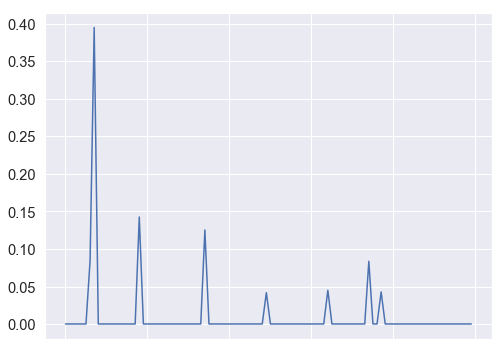

In [216]:
find_topics(0, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°123:
updating source second due output javascript eventlistener first page   scene  m figuring web development n t lot knowledge hope could help out      concept page choose due clicking change second page      linked first page   store source chosen variable result        result          document getelementbyid      choice1       addeventlistener      click            elem  document getelementbyid      choice1        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice2       addeventlistener      click            elem  document getelementbyid      choice2        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice3       addeventlistener      click            elem  document getelementbyid      choice3        result   window getcomputedstyle   elem   null    getpropertyvalue      backg

[21]

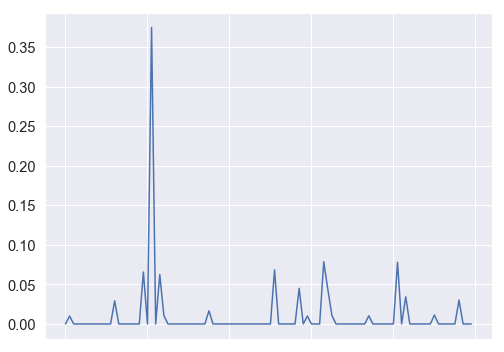

In [217]:
find_topics(123, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°132:
fabric wo n t let link firebase   firebase project  m trying link fabric      go fabric     firebase     integration select   says    already linked          go firebase console     project settings     integrations     fabric   n t see linked   see apps linked   one  m trying link right now      idea could happening   old firebase         fabric link   least see able remove    s nothing   fabric think already linked    s clearly    

Tags :  <firebase><google-fabric>

Index(['Topic_20', 'Topic_12', 'Topic_86', 'Topic_88', 'Topic_64'], dtype='object')
[20, 12, 86, 88, 64]
Topic 20 : command start process remov pdf exit exe termin output shell
Topic 12 : item link menu href grid nav temp dropdown navbar toggl
Topic 86 : android googl support gradl app play firebas tool implement sdk
Topic 88 : project microsoft framework refer librari visual studio develop cloud cmake
Topic 64 : question differ someth seem two possibl howev solut anoth answer


[20, 12, 86, 88, 64]

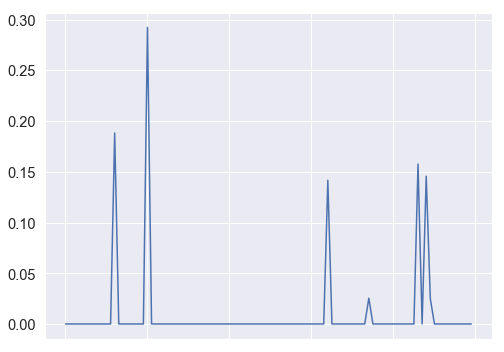

In [218]:
find_topics(132, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

#### Link Tags & Topics

##### Create table linking Tags & Topics :

Method :
- For each documents, and for each tags of the document : 
    - we add to its Tag line, its distribution by topics.
- So, Each tags line contains the sum of all topics distribution

In [219]:
# init dataFrame
df_topics_tags_raw = pd.DataFrame(index=list_unique_tags, columns=topicNames_1, 
                                  data=0)

df_model_1_topics = df_model_1[df_model_1["Train"] == True].filter(
    items=topicNames_1)

t_tags_topics_0 = time.time()
# for each docs, for each of its tags, add its topics distrib  
for idx in range(0, df_model_1_topics.shape[0]):
    list_tags_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_1[df_model_1["Train"] == True].\
                                iloc[idx].Tags)
    for tag_curr in list_tags_curr:
        if tag_curr in list_unique_tags:
            df_topics_tags_raw.loc[tag_curr] += df_model_1_topics.iloc[idx]
        #else:
            #print('Tag {} not into most frequent tags !', tag_curr)

t_tags_topics_1 = time.time()
print("timing total: {} s".format(t_tags_topics_1-t_tags_topics_0))


timing total: 308.21106576919556 s


In [220]:
df_topics_tags = df_topics_tags_raw.copy()

In [221]:
df_topics_tags.shape

(8765, 100)

In [222]:
df_topics_tags.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5  \
.app       0.000256  0.026014  0.000256  0.000256  0.000256  0.000256   
.htaccess  0.009201  0.239221  0.009201  0.009201  0.162547  0.056645   
.lib       0.000094  0.000094  0.000094  0.000094  0.000094  0.009723   
.net       0.034937  1.531847  0.034937  0.034937  0.625985  1.231911   
.net-1.1   0.000556  0.000556  0.000556  0.000556  0.000556  0.000556   

            Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  \
.app       0.000256  0.000256  0.000256  0.000256  0.000256  0.000256   
.htaccess  0.124464  0.190718  0.694184  0.009201  0.072988  0.085351   
.lib       0.000094  0.000094  0.000094  0.000094  0.000094  0.000094   
.net       0.886900  2.390397  0.944912  0.034937  0.165691  1.739440   
.net-1.1   0.000556  0.000556  0.000556  0.000556  0.000556  0.000556   

             ...     Topic_88  Topic_89  Topic_90  Topic_91  Topic_92  \
.app         ...     0.000256  0.077243  0.000256  0.000256  0.028869   
.htaccess    ...     0.111114  0.418477  0.206084  0.519097  0.067957   
.lib         ...     0.094438  0.041430  0.000094  0.000094  0.000094   
.net         ...     7.440581  1.059800  1.869520  1.103791  3.689143   
.net-1.1     ...     0.114726  0.055242  0.000556  0.000556  0.000556   

           Topic_93  Topic_94  Topic_95  Topic_96  Topic_97  Topic_98  \
.app       0.000256  0.061172  0.000256  0.000256  0.000256  0.000256   
.htaccess  0.009201  0.146101  2.062649  0.032980  0.105613  0.009201   
.lib       0.000094  0.000094  0.000094  0.000094  0.000094  0.007633   
.net       0.034937  0.906861  0.393307  1.835330  2.252455  1.833462   
.net-1.1   0.000556  0.000556  0.000556  0.000556  0.000556  0.174847   

           Topic_99  
.app       0.000256  
.htaccess  0.009201  
.lib       0.000094  
.net       0.034937  
.net-1.1   0.000556  

[5 rows x 100 columns]

In [223]:
df_model_1_topics.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
3   0.000417  0.000417  0.000417  0.000417  0.000417  0.000417  0.084731   
4   0.000086  0.000086  0.000086  0.000086  0.000086  0.000086  0.000086   
9   0.000087  0.000087  0.000087  0.000087  0.000087  0.000087  0.000087   
10  0.001429  0.001429  0.001429  0.001429  0.001429  0.001429  0.001429   
12  0.000909  0.000909  0.000909  0.000909  0.000909  0.000909  0.000909   

     Topic_7   Topic_8   Topic_9  Topic_10  Topic_11    ...     Topic_88  \
3   0.394752  0.000417  0.000417  0.000417  0.000417    ...     0.000417   
4   0.117589  0.000086  0.000086  0.000086  0.000086    ...     0.398352   
9   0.000087  0.000087  0.000087  0.000087  0.000087    ...     0.000087   
10  0.001429  0.001429  0.001429  0.001429  0.001429    ...     0.001429   
12  0.368838  0.000909  0.000909  0.000909  0.432387    ...     0.000909   

    Topic_89  Topic_90  Topic_91  Topic_92  Topic_93  Topic_94  Topic_95  \
3   0.000417  0.000417  0.000417  0.000417  0.000417  0.000417  0.000417   
4   0.094914  0.000086  0.011058  0.000086  0.000086  0.000086  0.000086   
9   0.000087  0.000087  0.054886  0.000087  0.000087  0.000087  0.026213   
10  0.001429  0.001429  0.001429  0.001429  0.001429  0.001429  0.001429   
12  0.000909  0.000909  0.000909  0.000909  0.000909  0.000909  0.000909   

    Topic_96  Topic_97  Topic_98  Topic_99  
3   0.000417  0.000417  0.000417  0.000417  
4   0.000086  0.000086  0.000086  0.000086  
9   0.000087  0.000087  0.000087  0.000087  
10  0.001429  0.001429  0.001429  0.001429  
12  0.000909  0.000909  0.000909  0.000909  

[5 rows x 100 columns]

##### Normalisation by Topics

In [224]:
df_topics_tags_norm = df_topics_tags.copy()
#for label, content in df.items():
for topic_label, col_values in df_topics_tags_norm.items():
    #print(idx)
    df_topics_tags_norm[topic_label] = col_values/col_values.sum()
df_topics_tags_norm.head()

Topic_0       Topic_1   Topic_2   Topic_3       Topic_4  \
.app       0.000019  7.811807e-05  0.000019  0.000019  6.797883e-07   
.htaccess  0.000667  7.183641e-04  0.000667  0.000667  4.309414e-04   
.lib       0.000007  2.832954e-07  0.000007  0.000007  2.501108e-07   
.net       0.002531  4.600031e-03  0.002531  0.002531  1.659596e-03   
.net-1.1   0.000040  1.668295e-06  0.000040  0.000040  1.472875e-06   

                Topic_5       Topic_6       Topic_7       Topic_8   Topic_9  \
.app       7.025448e-07  5.718895e-07  2.328874e-07  5.214930e-07  0.000019   
.htaccess  1.552040e-04  2.776001e-04  1.732212e-04  1.411847e-03  0.000667   
.lib       2.663969e-05  2.104122e-07  8.568497e-08  1.918701e-07  0.000007   
.net       3.375345e-03  1.978115e-03  2.171104e-03  1.921784e-03  0.002531   
.net-1.1   1.522180e-06  1.239094e-06  5.045893e-07  1.129901e-06  0.000040   

               Topic_10      Topic_11    ...         Topic_88  Topic_89  \
.app       5.401081e-07  2.888791e-07    ...     2.954593e-07  0.000144   
.htaccess  1.537438e-04  9.615872e-05    ...     1.280356e-04  0.000779   
.lib       1.987190e-07  1.062857e-07    ...     1.088206e-04  0.000077   
.net       3.490152e-04  1.959702e-03    ...     8.573718e-03  0.001972   
.net-1.1   1.170234e-06  6.259047e-07    ...     1.321982e-04  0.000103   

               Topic_90      Topic_91      Topic_92  Topic_93      Topic_94  \
.app       2.531465e-07  4.406306e-07  4.259378e-05  0.000019  1.741385e-04   
.htaccess  2.034607e-04  8.920471e-04  1.002653e-04  0.000667  4.159026e-04   
.lib       9.313881e-08  1.621188e-07  1.391904e-07  0.000007  2.685551e-07   
.net       1.845724e-03  1.896820e-03  5.443027e-03  0.002531  2.581547e-03   
.net-1.1   5.484841e-07  9.546996e-07  8.196766e-07  0.000040  1.581491e-06   

               Topic_95      Topic_96      Topic_97      Topic_98  Topic_99  
.app       6.723837e-07  4.450957e-07  3.974212e-07  4.479983e-07  0.000019  
.htaccess  5.408878e-03  5.724867e-05  1.636938e-04  1.607664e-05  0.000667  
.lib       2.473865e-07  1.637616e-07  1.462210e-07  1.333560e-05  0.000007  
.net       1.031366e-03  3.185901e-03  3.491176e-03  3.203413e-03  0.002531  
.net-1.1   1.456831e-06  9.643740e-07  8.610793e-07  3.054915e-04  0.000040  

[5 rows x 100 columns]

In [225]:
df_topics_tags = df_topics_tags_norm.copy()
df_topics_tags.shape

(8765, 100)

#### Evaluation Topics Distrib method



##### Create list of list with Predicted Tags for each Text Questions list

In [226]:
       
t_train_0 = time.time() 
list_tags_predicted_train = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == True]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_train_1 = time.time()

t_pred_0 = time.time() 
list_tags_predicted_test = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == False]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_pred_1 = time.time() # time to predict test
print("timing total: {} s".format(t_pred_1-t_train_0))

print("\nFor Train:\n", list_tags_predicted_train[:10])
print("\nFor Test:\n", list_tags_predicted_test[:10])

timing total: 420.2990667819977 s

For Train:
 [['sql', 'mysql', 'php', 'javascript', 'python', 'sql-server', 'java', 'c#', 'html', 'oracle'], ['c#', 'python', 'javascript', 'java', 'android', 'php', 'sql', 'mysql', 'c++', 'sql-server'], ['javascript', 'html', 'jquery', 'php', 'css', 'ajax', 'python', 'c#', 'angular', 'laravel'], ['javascript', 'python', 'php', 'html', 'java', 'android', 'c#', 'css', 'jquery', 'git'], ['sql', 'python', 'mysql', 'php', 'pandas', 'r', 'sql-server', 'javascript', 'c#', 'java'], ['php', 'python', 'javascript', 'java', 'android', 'c#', 'docker', 'node.js', 'html', 'ios'], ['python', 'javascript', 'java', 'android', 'c#', 'python-3.x', 'php', 'r', 'c++', 'ios'], ['java', 'c#', 'android', 'javascript', 'python', 'php', 'arrays', 'c++', 'angular', 'spring'], ['javascript', 'python', 'java', 'php', 'angular', 'c#', 'reactjs', 'json', 'android', 'html'], ['python', 'javascript', 'java', 'c#', 'r', 'android', 'php', 'c++', 'sql', 'python-3.x']]

For Test:
 [['pyt

##### Encode predictions

For : 
    - Train predicted
    - Test predicted

In [227]:
# predicted
enc_lda_ypred_train = mlb_lda.transform(list_tags_predicted_train)
print("Train real shape:", enc_lda_ypred_train.shape)
enc_lda_ypred_test = mlb_lda.transform(list_tags_predicted_test)
print("Test real shape:", enc_lda_ypred_test.shape)

Train real shape: (16966, 8765)
Test real shape: (4242, 8765)


##### Evaluate different scorings

In [229]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_lda_ypred_train,
                          enc_lda_y_test, enc_lda_ypred_test, 
                          t_lda_1 - t_lda_0 + t_tags_topics_1 + t_tags_topics_0,
                          t_pred_1 - t_pred_0)

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]


In [230]:
df_results = add_score(df_results, series_scores, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     no_top_words))
df_results

add line


f1_splits_test  f1_splits_test_std  acc_train  acc_test  \
LDA_top50_tags10         0.141678            0.000771   0.000000  0.000000   
LDA_top50_tags1          0.139635            0.000250   0.016975  0.017445   
LDA_top50_tags2          0.162595            0.000955   0.006955  0.006129   
LDA_top50_tags3          0.171949            0.001617   0.002476  0.002357   
LDA_top50_tags4          0.173857            0.001200   0.000648  0.000236   
LDA_top50_tags5          0.172366            0.001016   0.000000  0.000000   
LDA_top50_tags6          0.165265            0.000587   0.000000  0.000000   
LDA_top25_tags10         0.136579            0.000297   0.000000  0.000000   
LDA_top25_tags1          0.137544            0.001813   0.015325  0.015559   
LDA_top25_tags2          0.161006            0.001770   0.006012  0.006129   
LDA_top25_tags3          0.169592            0.000736   0.002240  0.002593   
LDA_top25_tags4          0.168388            0.000125   0.000589  0.000471   
LDA_top25_tags5          0.164371            0.000361   0.000000  0.000000   
LDA_top25_tags6          0.157607            0.000213   0.000000  0.000000   
LDA_top100_tags10        0.144906            0.000992   0.000000  0.000000   

                   pre_train  pre_test  rec_train  rec_test  f1_train  \
LDA_top50_tags10    0.091595  0.089321   0.310732  0.301648  0.141484   
LDA_top50_tags1     0.278793  0.273692   0.094579  0.092429  0.141243   
LDA_top50_tags2     0.201963  0.189769   0.137030  0.128175  0.163277   
LDA_top50_tags3     0.170419  0.161245   0.173442  0.163363  0.171917   
LDA_top50_tags4     0.150802  0.144743   0.204635  0.195526  0.173642   
LDA_top50_tags5     0.136261  0.133145   0.231129  0.224823  0.171446   
LDA_top50_tags6     0.123364  0.121326   0.251105  0.245840  0.165447   
LDA_top25_tags10    0.088023  0.085950   0.298614  0.290264  0.135967   
LDA_top25_tags1     0.275551  0.269213   0.093479  0.090916  0.139600   
LDA_top25_tags2     0.200961  0.196605   0.136350  0.132792  0.162467   
LDA_top25_tags3     0.168160  0.159987   0.171142  0.162089  0.169638   
LDA_top25_tags4     0.145733  0.139026   0.197756  0.187804  0.167805   
LDA_top25_tags5     0.130013  0.124422   0.220531  0.210095  0.163585   
LDA_top25_tags6     0.116989  0.113272   0.238128  0.229520  0.156897   
LDA_top100_tags10   0.093758  0.090806   0.318070  0.306663  0.144826   

                    f1_test  notags_train  notags_test   t_fit_train  \
LDA_top50_tags10   0.137829           0.0          0.0  3.144184e+09   
LDA_top50_tags1    0.138190           0.0          0.0  3.144184e+09   
LDA_top50_tags2    0.153005           0.0          0.0  3.144184e+09   
LDA_top50_tags3    0.162297           0.0          0.0  3.144184e+09   
LDA_top50_tags4    0.166345           0.0          0.0  3.144184e+09   
LDA_top50_tags5    0.167244           0.0          0.0  3.144184e+09   
LDA_top50_tags6    0.162471           0.0          0.0  3.144184e+09   
LDA_top25_tags10   0.132628           0.0          0.0  3.144201e+09   
LDA_top25_tags1    0.135928           0.0          0.0  3.144201e+09   
LDA_top25_tags2    0.158517           0.0          0.0  3.144201e+09   
LDA_top25_tags3    0.161031           0.0          0.0  3.144201e+09   
LDA_top25_tags4    0.159775           0.0          0.0  3.144201e+09   
LDA_top25_tags5    0.156288           0.0          0.0  3.144201e+09   
LDA_top25_tags6    0.151685           0.0          0.0  3.144201e+09   
LDA_top100_tags10  0.140121           0.0          0.0  3.144211e+09   

                   t_pred_test  
LDA_top50_tags10     66.587340  
LDA_top50_tags1      66.587340  
LDA_top50_tags2      66.587340  
LDA_top50_tags3      66.587340  
LDA_top50_tags4      66.587340  
LDA_top50_tags5      66.587340  
LDA_top50_tags6      66.587340  
LDA_top25_tags10     71.963846  
LDA_top25_tags1      71.963846  
LDA_top25_tags2      71.963846  
LDA_top25_tags3      71.963846  
LDA_top25_tags4      71.963846  
LDA_top25_tags5    

##### Evaluate for each nb Tags max

In [231]:
for nb_tags_max in [1, 2, 3, 4, 5, 6]:
    # select max tags
    list_tags_predicted_train_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_train]
    list_tags_predicted_test_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_test]
    # predict
    enc_lda_ypred_train_curr = mlb_lda.transform(list_tags_predicted_train_curr)
    enc_lda_ypred_test_curr = mlb_lda.transform(list_tags_predicted_test_curr)
    # score
    series_scores_curr = evaluate_mdl_scorings(enc_lda_y_train, 
                          enc_lda_ypred_train_curr,
                          enc_lda_y_test, 
                          enc_lda_ypred_test_curr, 
                          t_lda_1 - t_lda_0 + t_tags_topics_1 - t_tags_topics_0, 
                          t_pred_1-t_pred_0)
    df_results = add_score(df_results, series_scores_curr, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     nb_tags_max))
df_results

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line


f1_splits_test  f1_splits_test_std  acc_train  acc_test  \
LDA_top50_tags10         0.141678            0.000771   0.000000  0.000000   
LDA_top50_tags1          0.139635            0.000250   0.016975  0.017445   
LDA_top50_tags2          0.162595            0.000955   0.006955  0.006129   
LDA_top50_tags3          0.171949            0.001617   0.002476  0.002357   
LDA_top50_tags4          0.173857            0.001200   0.000648  0.000236   
LDA_top50_tags5          0.172366            0.001016   0.000000  0.000000   
LDA_top50_tags6          0.165265            0.000587   0.000000  0.000000   
LDA_top25_tags10         0.136579            0.000297   0.000000  0.000000   
LDA_top25_tags1          0.137544            0.001813   0.015325  0.015559   
LDA_top25_tags2          0.161006            0.001770   0.006012  0.006129   
LDA_top25_tags3          0.169592            0.000736   0.002240  0.002593   
LDA_top25_tags4          0.168388            0.000125   0.000589  0.000471   
LDA_top25_tags5          0.164371            0.000361   0.000000  0.000000   
LDA_top25_tags6          0.157607            0.000213   0.000000  0.000000   
LDA_top100_tags10        0.144906            0.000992   0.000000  0.000000   
LDA_top100_tags1         0.144714            0.000586   0.017623  0.017209   
LDA_top100_tags2         0.169057            0.001304   0.007721  0.008722   
LDA_top100_tags3         0.176685            0.000645   0.002358  0.002593   
LDA_top100_tags4         0.178590            0.000106   0.000648  0.000236   
LDA_top100_tags5         0.174328            0.000957   0.000000  0.000000   
LDA_top100_tags6         0.168984            0.000282   0.000000  0.000000   

                   pre_train  pre_test  rec_train  rec_test  f1_train  \
LDA_top50_tags10    0.091595  0.089321   0.310732  0.301648  0.141484   
LDA_top50_tags1     0.278793  0.273692   0.094579  0.092429  0.141243   
LDA_top50_tags2     0.201963  0.189769   0.137030  0.128175  0.163277   
LDA_top50_tags3     0.170419  0.161245   0.173442  0.163363  0.171917   
LDA_top50_tags4     0.150802  0.144743   0.204635  0.195526  0.173642   
LDA_top50_tags5     0.136261  0.133145   0.231129  0.224823  0.171446   
LDA_top50_tags6     0.123364  0.121326   0.251105  0.245840  0.165447   
LDA_top25_tags10    0.088023  0.085950   0.298614  0.290264  0.135967   
LDA_top25_tags1     0.275551  0.269213   0.093479  0.090916  0.139600   
LDA_top25_tags2     0.200961  0.196605   0.136350  0.132792  0.162467   
LDA_top25_tags3     0.168160  0.159987   0.171142  0.162089  0.169638   
LDA_top25_tags4     0.145733  0.139026   0.197756  0.187804  0.167805   
LDA_top25_tags5     0.130013  0.124422   0.220531  0.210095  0.163585   
LDA_top25_tags6     0.116989  0.113272   0.238128  0.229520  0.156897   
LDA_top100_tags10   0.093758  0.090806   0.318070  0.306663  0.144826   
LDA_top100_tags1    0.289579  0.279114   0.098238  0.094260  0.146707   
LDA_top100_tags2    0.209772  0.202381   0.142329  0.136693  0.169591   
LDA_top100_tags3    0.174918  0.166667   0.178021  0.168856  0.176456   
LDA_top100_tags4    0.154235  0.149104   0.209294  0.201417  0.177595   
LDA_top100_tags5    0.138112  0.135031   0.234268  0.228007  0.173775   
LDA_top100_tags6    0.125761  0.122819   0.255984  0.248866  0.168662   

                    f1_test  notags_train  notags_test   t_fit_train  \
LDA_top50_tags10   0.137829           0.0          0.0  3.144184e+09   
LDA_top50_tags1    0.138190           0.0          0.0  3.144184e+09   
LDA_top50_tags2    0.153005           0.0          0.0  3.144184e+09   
LDA_top50_tags3    0.162297           0.0          0.0  3.144184e+09   
LDA_top50_tags4    0.166345           0.0          0.0  3.144184e+09   
LDA_top50_tags5    0.167244           0.0          0.0  3.144184e+09   
LDA_top50_tags6    0.162471           0.0          0.0  3.144184e+09   
LDA_top25_tags10   0.132628           0.0          0.0  3.144201e+09   
LDA_top25_tags1    0.135928           0.0      

### LDA 200 Topics

#### Optim Fit

Features same : max_df=0.11, min_df=10

Train set used only

In [232]:
#Best Model's Params:  {'learning_decay': 0.7, 'max_iter': 30, 'n_components': 50}
#Best Log Likelihood Score:  -2332613.6264004773
#Model Perplexity:  362.02631743586585

# Define Search Param
search_params = {'n_components': [200], 
                 'learning_decay': [0.6, 0.7, 0.8],
                 'max_iter': [5, 10, 20]}# Init the Model

In [233]:
# init model to optimize
lda_for_gcv_1 = LatentDirichletAllocation(learning_method='online',
                                          learning_offset=50., 
                                          random_state=0,
                                          n_jobs=-1)
# Init Grid Search Class
gcv_lda_1 = GridSearchCV(lda_for_gcv_1, param_grid=search_params, cv=cv_lda)

# Do the Grid Search
t_lda_0 = time.time()
gcv_lda_1.fit(tf_1)
t_lda_1 = time.time()
print("timing total: {} s".format(t_lda_1-t_lda_0))

timing total: 5590.588871955872 s


In [234]:
gcv_lda_1.best_params_

{'learning_decay': 0.7, 'max_iter': 20, 'n_components': 200}

In [235]:
# Best Model
best_lda_model_1 = gcv_lda_1.best_estimator_# Model Parameters
print("Best Model's Params: ", gcv_lda_1.best_params_)# Log Likelihood Score
print("Best Log Likelihood Score: ", gcv_lda_1.best_score_)# Perplexity
print("Model Perplexity: ", best_lda_model_1.perplexity(tf_1))

Best Model's Params:  {'learning_decay': 0.7, 'max_iter': 20, 'n_components': 200}
Best Log Likelihood Score:  -2152586.429433519
Model Perplexity:  422.9327872120851


In [236]:
df_res_1 = pd.DataFrame(data=gcv_lda_1.cv_results_)
df_res_1[df_res_1["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

1  \
mean_fit_time                                                   173.431   
std_fit_time                                                    7.11827   
mean_score_time                                                 2.57602   
std_score_time                                                 0.184204   
param_learning_decay                                                0.6   
param_max_iter                                                       10   
param_n_components                                                  200   
params                {'learning_decay': 0.6, 'max_iter': 10, 'n_com...   
split0_test_score                                          -2.12495e+06   
split1_test_score                                          -2.15028e+06   
split2_test_score                                          -2.20579e+06   
mean_test_score                                            -2.16034e+06   
std_test_score                                                  33761.6   
rank_test_score                                                       4   
split0_train_score                                         -5.00317e+06   
split1_train_score                                         -4.96446e+06   
split2_train_score                                         -4.92142e+06   
mean_train_score                                           -4.96301e+06   
std_train_score                                                   33391   

                                                                      2  \
mean_fit_time                                                   330.791   
std_fit_time                                                    15.1276   
mean_score_time                                                 2.07706   
std_score_time                                                 0.476793   
param_learning_decay                                                0.6   
param_max_iter                                                       20   
param_n_components                                                  200   
params                {'learning_decay': 0.6, 'max_iter': 20, 'n_com...   
split0_test_score                                          -2.12333e+06   
split1_test_score                                            -2.149e+06   
split2_test_score                                          -2.20788e+06   
mean_test_score                                            -2.16007e+06   
std_test_score                                                  35393.8   
rank_test_score                                                       3   
split0_train_score                                         -5.00261e+06   
split1_train_score                                         -4.96381e+06   
split2_train_score                                         -4.92728e+06   
mean_train_score                                           -4.96457e+06   
std_train_score                                                 30758.4   

                                                                      4  \
mean_fit_time                                                   148.103   
std_fit_time                                                    8.32947   
mean_score_time                                                 1.59583   
std_score_time                                                0.0834948   
param_learning_decay                                                0.7   
param_max_iter                                                       10   
param_n_components                                                  200   
params                {'learning_decay': 0.7, 'max_iter': 10, 'n_com...   
split0_test_score                                          -2.12154e+06   
split1_test_score                                          -2.14578e+06   
split2_test_score                                          -2.20285e+06   
mean_test_score                                            -2.15672e+06   
std_test_score                                                  34086.6   
rank_test_score   

##### Save

In [237]:
save_gridsearchcv_unsup(gcv_lda_1, df_res_1,"LDA")

learning_decay
0.7
max_iter
20
n_components
200
Results Saved here:
../../data/df_res_LDA__learning_decay0.7_max_iter20_n_components200.csv
Model Saved here:
../../data/model_LDA__learning_decay0.7_max_iter20_n_components200.pkl


#### Compare

In [238]:
df_res_lda200 = pd.read_csv(\
    '../../data/df_res_LDA__learning_decay0.7_max_iter20_n_components200.csv', 
    sep=',')

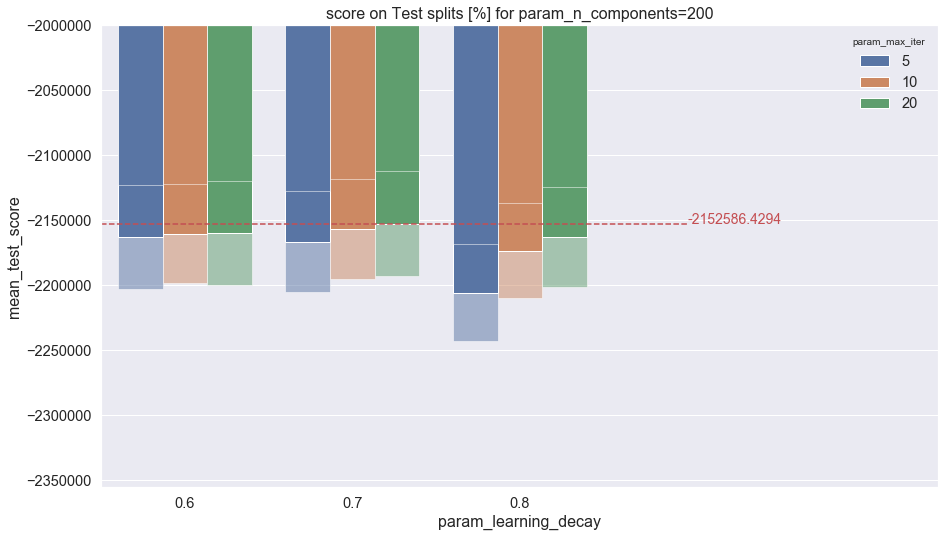

In [239]:
plot_res_test_split(df_res_lda200, "score", "param_learning_decay", 
                    "param_max_iter", y_min=-2000000,
                    myFixedParam="param_n_components",
                    myFixedValue=200, cv_eval=cv_lda)

#### Topics

In [240]:
# create & display topic dictionnary 

topic_dict_1 = display_topics(best_lda_model_1, 
                              tf_vectorizer_1.get_feature_names(), 
                              no_top_words)

Topic 0:
effect store timeout hour wonder sheet domain great manual combin
Topic 1:
loop quit choic pygam program mode random def put init
Topic 2:
store googl word begin declar place procedur varchar pleas everi
Topic 3:
upload content respons client server byte applic unabl data http
Topic 4:
match rout mode full includ from prefix avail specifi still
Topic 5:
bar socket foo merg car scale kind possibl two side
Topic 6:
jar springframework releas spring org bean boot factori core annot
Topic 7:
product mysqli null categori php div echo admin row key
Topic 8:
max sql javascript output audio rule tree usernam numpi extend
Topic 9:
messag thread except stream receiv catch throw queue async error
Topic 10:
email send contact mail for subject firstnam last lastnam sent
Topic 11:
releas data group localhost place auth multi subject branch cursor
Topic 12:
thread exec issu nav hold link local math str declar
Topic 13:
order product group descript new join desc inner quantiti number
Topic 14

#### Predict Topics for each documents

##### TF transform for all questions (Train & Test)

(TF vectoriser fitted already on Train set)

In [241]:
topics_pred_1 = best_lda_model_1.transform(tf_all_1)


In [242]:
topicNames_1 = []
for idx in range(0, gcv_lda_1.best_params_["n_components"]):
    topicNames_1.append("Topic_{}".format(idx))

df_topics_pred_1 = pd.DataFrame(data=topics_pred_1,
                                index=df_quest_cleaned.index,
                               columns=topicNames_1)
df_model_1 = df_quest_cleaned.join(
    df_topics_pred_1)

In [243]:
df_topics_pred_1.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
3   0.000208  0.000208  0.250494  0.000208  0.000208  0.000208  0.000208   
4   0.000043  0.000043  0.017397  0.000043  0.000043  0.000043  0.000043   
9   0.000043  0.000043  0.000043  0.000043  0.000043  0.000043  0.000043   
10  0.000714  0.000714  0.000714  0.000714  0.000714  0.000714  0.000714   
12  0.000455  0.000455  0.000455  0.000455  0.000455  0.000455  0.000455   

     Topic_7   Topic_8   Topic_9  Topic_10  Topic_11    ...      Topic_188  \
3   0.000208  0.000208  0.000208  0.000208  0.000208    ...       0.000208   
4   0.000043  0.000043  0.000043  0.000043  0.000043    ...       0.000043   
9   0.000043  0.000043  0.000043  0.043749  0.000043    ...       0.000043   
10  0.000714  0.000714  0.000714  0.000714  0.000714    ...       0.000714   
12  0.000455  0.000455  0.000455  0.000455  0.000455    ...       0.000455   

    Topic_189  Topic_190  Topic_191  Topic_192  Topic_193  Topic_194  \
3    0.000208   0.000208   0.000208   0.000208   0.000208   0.000208   
4    0.000043   0.000043   0.000043   0.000043   0.000043   0.055540   
9    0.000043   0.000043   0.000043   0.000043   0.000043   0.000043   
10   0.000714   0.000714   0.000714   0.000714   0.000714   0.000714   
12   0.000455   0.000455   0.000455   0.000455   0.000455   0.000455   

    Topic_195  Topic_196  Topic_197  Topic_198  Topic_199  
3    0.000208   0.000208   0.000208   0.000208   0.000208  
4    0.000043   0.000043   0.000043   0.000043   0.000043  
9    0.000043   0.000043   0.000043   0.000043   0.000043  
10   0.000714   0.000714   0.000714   0.000714   0.000714  
12   0.000455   0.000455   0.000455   0.000455   0.000455  

[5 rows x 200 columns]

In [244]:
df_topics_pred_1.shape

(21208, 200)

Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_2', 'Topic_174', 'Topic_120'], dtype='object')
[2, 174, 120]
Topic 2 : store googl word begin declar place procedur varchar pleas everi
Topic 174 : tabl queri insert databas transact lock cursor join exist commit
Topic 120 : execut sql statement junit xxx manag assum correct appear give


[2, 174, 120]

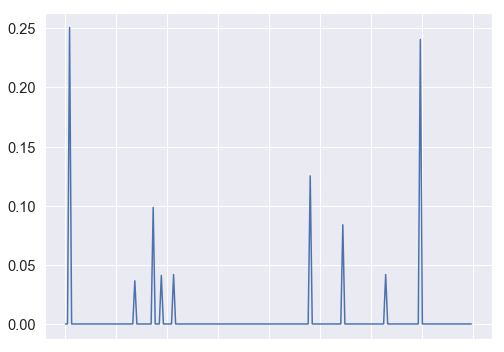

In [245]:
find_topics(0, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°123:
updating source second due output javascript eventlistener first page   scene  m figuring web development n t lot knowledge hope could help out      concept page choose due clicking change second page      linked first page   store source chosen variable result        result          document getelementbyid      choice1       addeventlistener      click            elem  document getelementbyid      choice1        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice2       addeventlistener      click            elem  document getelementbyid      choice2        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice3       addeventlistener      click            elem  document getelementbyid      choice3        result   window getcomputedstyle   elem   null    getpropertyvalue      backg

[165]

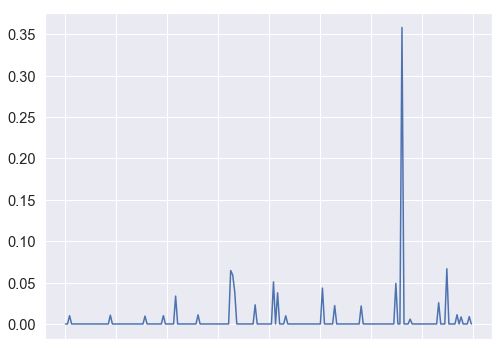

In [246]:
find_topics(123, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°132:
fabric wo n t let link firebase   firebase project  m trying link fabric      go fabric     firebase     integration select   says    already linked          go firebase console     project settings     integrations     fabric   n t see linked   see apps linked   one  m trying link right now      idea could happening   old firebase         fabric link   least see able remove    s nothing   fabric think already linked    s clearly    

Tags :  <firebase><google-fabric>

Index(['Topic_147', 'Topic_153', 'Topic_34', 'Topic_193'], dtype='object')
[147, 153, 34, 193]
Topic 147 : project remov issu ad microsoft develop visual studio fix integr
Topic 153 : content http link www xmlns callback schema canva html utf
Topic 34 : complet firebas alreadi attach ref snapshot databas push intern val
Topic 193 : network github compos ident fabric abl link sign due var


[147, 153, 34, 193]

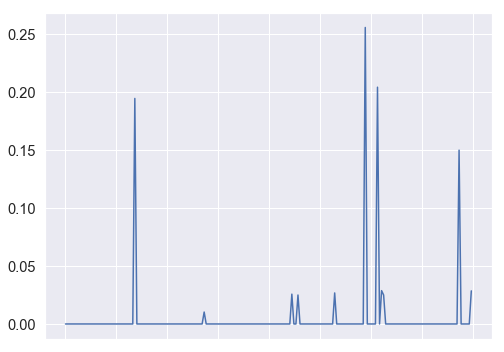

In [247]:
find_topics(132, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

#### Link Tags & Topics

##### Create table linking Tags & Topics :

Method :
- For each documents, and for each tags of the document : 
    - we add to its Tag line, its distribution by topics.
- So, Each tags line contains the sum of all topics distribution

In [248]:
# init dataFrame
df_topics_tags_raw = pd.DataFrame(index=list_unique_tags, columns=topicNames_1, 
                                  data=0)

df_model_1_topics = df_model_1[df_model_1["Train"] == True].filter(
    items=topicNames_1)

t_tags_topics_0 = time.time()
# for each docs, for each of its tags, add its topics distrib  
for idx in range(0, df_model_1_topics.shape[0]):
    list_tags_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_1[df_model_1["Train"] == True].\
                                iloc[idx].Tags)
    for tag_curr in list_tags_curr:
        if tag_curr in list_unique_tags:
            df_topics_tags_raw.loc[tag_curr] += df_model_1_topics.iloc[idx]
        #else:
            #print('Tag {} not into most frequent tags !', tag_curr)

t_tags_topics_1 = time.time()
print("timing total: {} s".format(t_tags_topics_1-t_tags_topics_0))


timing total: 486.1152319908142 s


In [249]:
df_topics_tags = df_topics_tags_raw.copy()

In [250]:
df_topics_tags.shape

(8765, 200)

In [251]:
df_topics_tags.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5  \
.app       0.000128  0.027203  0.000128  0.000128  0.000128  0.000128   
.htaccess  0.004601  0.037402  0.151950  0.004601  0.044933  0.090071   
.lib       0.000047  0.000047  0.000047  0.000047  0.000047  0.000047   
.net       0.017469  0.346074  1.370007  0.017469  0.445489  0.282726   
.net-1.1   0.000278  0.000278  0.000278  0.000278  0.000278  0.000278   

            Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  \
.app       0.000128  0.000128  0.000128  0.028521  0.000128  0.000128   
.htaccess  0.083032  0.004601  0.004601  0.126957  0.111522  0.004601   
.lib       0.000047  0.000047  0.000047  0.000047  0.000047  0.000047   
.net       0.322279  0.017469  0.017469  5.292493  0.547778  0.017469   
.net-1.1   0.000278  0.000278  0.000278  0.000278  0.000278  0.000278   

             ...      Topic_188  Topic_189  Topic_190  Topic_191  Topic_192  \
.app         ...       0.000128   0.000128   0.000128   0.000128   0.000128   
.htaccess    ...       0.152524   0.004601   0.004601   0.004601   0.108690   
.lib         ...       0.029884   0.000047   0.000047   0.000047   0.000047   
.net         ...       4.421391   0.017469   0.017469   0.017469   1.179457   
.net-1.1     ...       0.000278   0.000278   0.000278   0.000278   0.000278   

           Topic_193  Topic_194  Topic_195  Topic_196  Topic_197  Topic_198  \
.app        0.000128   0.000128   0.000128   0.000128   0.000128   0.000128   
.htaccess   0.015470   0.066856   0.330354   0.004601   0.004601   0.195005   
.lib        0.000047   0.074276   0.000047   0.000047   0.000047   0.000047   
.net        0.105822   0.866013   0.296297   0.017469   0.017469   1.782490   
.net-1.1    0.000278   0.000278   0.000278   0.000278   0.000278   0.000278   

           Topic_199  
.app        0.032038  
.htaccess   0.156317  
.lib        0.000047  
.net        0.710216  
.net-1.1    0.000278  

[5 rows x 200 columns]

In [252]:
df_model_1_topics.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
3   0.000208  0.000208  0.250494  0.000208  0.000208  0.000208  0.000208   
4   0.000043  0.000043  0.017397  0.000043  0.000043  0.000043  0.000043   
9   0.000043  0.000043  0.000043  0.000043  0.000043  0.000043  0.000043   
10  0.000714  0.000714  0.000714  0.000714  0.000714  0.000714  0.000714   
12  0.000455  0.000455  0.000455  0.000455  0.000455  0.000455  0.000455   

     Topic_7   Topic_8   Topic_9  Topic_10  Topic_11    ...      Topic_188  \
3   0.000208  0.000208  0.000208  0.000208  0.000208    ...       0.000208   
4   0.000043  0.000043  0.000043  0.000043  0.000043    ...       0.000043   
9   0.000043  0.000043  0.000043  0.043749  0.000043    ...       0.000043   
10  0.000714  0.000714  0.000714  0.000714  0.000714    ...       0.000714   
12  0.000455  0.000455  0.000455  0.000455  0.000455    ...       0.000455   

    Topic_189  Topic_190  Topic_191  Topic_192  Topic_193  Topic_194  \
3    0.000208   0.000208   0.000208   0.000208   0.000208   0.000208   
4    0.000043   0.000043   0.000043   0.000043   0.000043   0.055540   
9    0.000043   0.000043   0.000043   0.000043   0.000043   0.000043   
10   0.000714   0.000714   0.000714   0.000714   0.000714   0.000714   
12   0.000455   0.000455   0.000455   0.000455   0.000455   0.000455   

    Topic_195  Topic_196  Topic_197  Topic_198  Topic_199  
3    0.000208   0.000208   0.000208   0.000208   0.000208  
4    0.000043   0.000043   0.000043   0.000043   0.000043  
9    0.000043   0.000043   0.000043   0.000043   0.000043  
10   0.000714   0.000714   0.000714   0.000714   0.000714  
12   0.000455   0.000455   0.000455   0.000455   0.000455  

[5 rows x 200 columns]

##### Normalisation by Topics

In [253]:
df_topics_tags_norm = df_topics_tags.copy()
#for label, content in df.items():
for topic_label, col_values in df_topics_tags_norm.items():
    #print(idx)
    df_topics_tags_norm[topic_label] = col_values/col_values.sum()
df_topics_tags_norm.head()

Topic_0       Topic_1       Topic_2   Topic_3       Topic_4  \
.app       0.000019  2.056703e-04  3.220621e-07  0.000019  6.070058e-07   
.htaccess  0.000667  2.827786e-04  3.817103e-04  0.000667  2.127397e-04   
.lib       0.000007  3.566254e-07  1.184945e-07  0.000007  2.233323e-07   
.net       0.002531  2.616480e-03  3.441573e-03  0.002531  2.109233e-03   
.net-1.1   0.000040  2.100128e-06  6.978012e-07  0.000040  1.315179e-06   

                Topic_5       Topic_6   Topic_7   Topic_8       Topic_9  \
.app       5.743202e-07  4.126213e-07  0.000019  0.000019  3.897517e-05   
.htaccess  4.034899e-04  2.672343e-04  0.000667  0.000667  1.734948e-04   
.lib       2.113065e-07  1.518135e-07  0.000007  0.000007  6.446050e-08   
.net       1.266525e-03  1.037238e-03  0.002531  0.002531  7.232523e-03   
.net-1.1   1.244360e-06  8.940129e-07  0.000040  0.000040  3.796007e-07   

               Topic_10  Topic_11      ...          Topic_188  Topic_189  \
.app       4.309370e-07  0.000019      ...       2.329407e-07   0.000019   
.htaccess  3.748595e-04  0.000667      ...       2.771257e-04   0.000667   
.lib       1.585523e-07  0.000007      ...       5.429747e-05   0.000007   
.net       1.841250e-03  0.002531      ...       8.033390e-03   0.002531   
.net-1.1   9.336969e-07  0.000040      ...       5.047048e-07   0.000040   

           Topic_190  Topic_191     Topic_192     Topic_193     Topic_194  \
.app        0.000019   0.000019  3.742043e-07  1.043209e-06  2.346246e-07   
.htaccess   0.000667   0.000667  3.172430e-04  1.258821e-04  1.223522e-04   
.lib        0.000007   0.000007  1.376790e-07  3.838222e-07  1.359307e-04   
.net        0.002531   0.002531  3.442591e-03  8.610748e-04  1.584867e-03   
.net-1.1    0.000040   0.000040  8.107760e-07  2.260287e-06  5.083534e-07   

              Topic_195  Topic_196  Topic_197     Topic_198     Topic_199  
.app       7.081521e-07   0.000019   0.000019  3.603732e-07  6.707166e-05  
.htaccess  1.824738e-03   0.000667   0.000667  5.481422e-04  3.272454e-04  
.lib       2.605465e-07   0.000007   0.000007  1.325902e-07  9.874887e-08  
.net       1.636622e-03   0.002531   0.002531  5.010420e-03  1.486820e-03  
.net-1.1   1.534330e-06   0.000040   0.000040  7.808087e-07  5.815211e-07  

[5 rows x 200 columns]

In [254]:
df_topics_tags = df_topics_tags_norm.copy()
df_topics_tags.shape

(8765, 200)

#### Evaluation Topics Distrib method



##### Create list of list with Predicted Tags for each Text Questions list

In [255]:
       
t_train_0 = time.time() 
list_tags_predicted_train = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == True]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_train_1 = time.time()

t_pred_0 = time.time() 
list_tags_predicted_test = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == False]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_pred_1 = time.time() # time to predict test
print("timing total: {} s".format(t_pred_1-t_train_0))

print("\nFor Train:\n", list_tags_predicted_train[:10])
print("\nFor Test:\n", list_tags_predicted_test[:10])

timing total: 1038.9889750480652 s

For Train:
 [['sql', 'python', 'javascript', 'php', 'sql-server', 'java', 'mysql', 'c#', 'android', 'html'], ['python', 'javascript', 'java', 'c#', 'php', 'android', 'sql', 'html', 'c++', 'mysql'], ['javascript', 'html', 'php', 'jquery', 'css', 'python', 'c#', 'angular', 'ajax', 'java'], ['python', 'javascript', 'php', 'java', 'android', 'c#', 'html', 'django', 'node.js', 'jquery'], ['sql', 'python', 'sql-server', 'php', 'mysql', 'javascript', 'java', 'c#', 'r', 'pandas'], ['php', 'python', 'javascript', 'android', 'java', 'c#', 'html', 'laravel', 'angular', 'mysql'], ['python', 'java', 'javascript', 'c#', 'r', 'android', 'node.js', 'php', 'python-3.x', 'angular'], ['java', 'c#', 'python', 'javascript', 'android', 'php', 'sql', 'c++', 'r', 'angular'], ['javascript', 'python', 'java', 'json', 'php', 'c#', 'android', 'angular', 'jquery', 'reactjs'], ['python', 'java', 'javascript', 'c#', 'php', 'c++', 'r', 'android', 'html', 'pandas']]

For Test:
 [['p

##### Encode predictions

For : 
    - Train predicted
    - Test predicted

In [256]:
# predicted
enc_lda_ypred_train = mlb_lda.transform(list_tags_predicted_train)
print("Train real shape:", enc_lda_ypred_train.shape)
enc_lda_ypred_test = mlb_lda.transform(list_tags_predicted_test)
print("Test real shape:", enc_lda_ypred_test.shape)

Train real shape: (16966, 8765)
Test real shape: (4242, 8765)


##### Evaluate different scorings

In [258]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_lda_ypred_train,
                          enc_lda_y_test, enc_lda_ypred_test, 
                          t_lda_1 - t_lda_0 + t_tags_topics_1 + t_tags_topics_0,
                          t_pred_1 - t_pred_0)

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]


In [259]:
df_results = add_score(df_results, series_scores, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     no_top_words))
df_results

add line


f1_splits_test  f1_splits_test_std  acc_train  acc_test  \
LDA_top50_tags10         0.141678            0.000771   0.000000  0.000000   
LDA_top50_tags1          0.139635            0.000250   0.016975  0.017445   
LDA_top50_tags2          0.162595            0.000955   0.006955  0.006129   
LDA_top50_tags3          0.171949            0.001617   0.002476  0.002357   
LDA_top50_tags4          0.173857            0.001200   0.000648  0.000236   
LDA_top50_tags5          0.172366            0.001016   0.000000  0.000000   
LDA_top50_tags6          0.165265            0.000587   0.000000  0.000000   
LDA_top25_tags10         0.136579            0.000297   0.000000  0.000000   
LDA_top25_tags1          0.137544            0.001813   0.015325  0.015559   
LDA_top25_tags2          0.161006            0.001770   0.006012  0.006129   
LDA_top25_tags3          0.169592            0.000736   0.002240  0.002593   
LDA_top25_tags4          0.168388            0.000125   0.000589  0.000471   
LDA_top25_tags5          0.164371            0.000361   0.000000  0.000000   
LDA_top25_tags6          0.157607            0.000213   0.000000  0.000000   
LDA_top100_tags10        0.144906            0.000992   0.000000  0.000000   
LDA_top100_tags1         0.144714            0.000586   0.017623  0.017209   
LDA_top100_tags2         0.169057            0.001304   0.007721  0.008722   
LDA_top100_tags3         0.176685            0.000645   0.002358  0.002593   
LDA_top100_tags4         0.178590            0.000106   0.000648  0.000236   
LDA_top100_tags5         0.174328            0.000957   0.000000  0.000000   
LDA_top100_tags6         0.168984            0.000282   0.000000  0.000000   
LDA_top200_tags10        0.145331            0.000695   0.000000  0.000000   

                   pre_train  pre_test  rec_train  rec_test  f1_train  \
LDA_top50_tags10    0.091595  0.089321   0.310732  0.301648  0.141484   
LDA_top50_tags1     0.278793  0.273692   0.094579  0.092429  0.141243   
LDA_top50_tags2     0.201963  0.189769   0.137030  0.128175  0.163277   
LDA_top50_tags3     0.170419  0.161245   0.173442  0.163363  0.171917   
LDA_top50_tags4     0.150802  0.144743   0.204635  0.195526  0.173642   
LDA_top50_tags5     0.136261  0.133145   0.231129  0.224823  0.171446   
LDA_top50_tags6     0.123364  0.121326   0.251105  0.245840  0.165447   
LDA_top25_tags10    0.088023  0.085950   0.298614  0.290264  0.135967   
LDA_top25_tags1     0.275551  0.269213   0.093479  0.090916  0.139600   
LDA_top25_tags2     0.200961  0.196605   0.136350  0.132792  0.162467   
LDA_top25_tags3     0.168160  0.159987   0.171142  0.162089  0.169638   
LDA_top25_tags4     0.145733  0.139026   0.197756  0.187804  0.167805   
LDA_top25_tags5     0.130013  0.124422   0.220531  0.210095  0.163585   
LDA_top25_tags6     0.116989  0.113272   0.238128  0.229520  0.156897   
LDA_top100_tags10   0.093758  0.090806   0.318070  0.306663  0.144826   
LDA_top100_tags1    0.289579  0.279114   0.098238  0.094260  0.146707   
LDA_top100_tags2    0.209772  0.202381   0.142329  0.136693  0.169591   
LDA_top100_tags3    0.174918  0.166667   0.178021  0.168856  0.176456   
LDA_top100_tags4    0.154235  0.149104   0.209294  0.201417  0.177595   
LDA_top100_tags5    0.138112  0.135031   0.234268  0.228007  0.173775   
LDA_top100_tags6    0.125761  0.122819   0.255984  0.248866  0.168662   
LDA_top200_tags10   0.093911  0.091938   0.318590  0.310485  0.145062   

                    f1_test  notags_train  notags_test   t_fit_train  \
LDA_top50_tags10   0.137829           0.0          0.0  3.144184e+09   
LDA_top50_tags1    0.138190           0.0          0.0  3.144184e+09   
LDA_top50_tags2    0.153005           0.0          0.0  3.144184e+09   
LDA_top50_tags3    0.162297           0.0          0.0  3.144184e+09   
LDA_top50_tags4    0.166345           0.0          0.0  3.144184e+09   
LDA_top50_tags5    0.167244           0.0          0.0  3.144184e+09   
LDA_top50_tags6    0.162471           0.

##### Evaluate for each nb Tags max

In [260]:
for nb_tags_max in [1, 2, 3, 4, 5, 6]:
    # select max tags
    list_tags_predicted_train_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_train]
    list_tags_predicted_test_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_test]
    # predict
    enc_lda_ypred_train_curr = mlb_lda.transform(list_tags_predicted_train_curr)
    enc_lda_ypred_test_curr = mlb_lda.transform(list_tags_predicted_test_curr)
    # score
    series_scores_curr = evaluate_mdl_scorings(enc_lda_y_train, 
                          enc_lda_ypred_train_curr,
                          enc_lda_y_test, 
                          enc_lda_ypred_test_curr, 
                          t_lda_1 - t_lda_0 + t_tags_topics_1 - t_tags_topics_0, 
                          t_pred_1-t_pred_0)
    df_results = add_score(df_results, series_scores_curr, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     nb_tags_max))
df_results

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line


f1_splits_test  f1_splits_test_std  acc_train  acc_test  \
LDA_top50_tags10         0.141678            0.000771   0.000000  0.000000   
LDA_top50_tags1          0.139635            0.000250   0.016975  0.017445   
LDA_top50_tags2          0.162595            0.000955   0.006955  0.006129   
LDA_top50_tags3          0.171949            0.001617   0.002476  0.002357   
LDA_top50_tags4          0.173857            0.001200   0.000648  0.000236   
LDA_top50_tags5          0.172366            0.001016   0.000000  0.000000   
LDA_top50_tags6          0.165265            0.000587   0.000000  0.000000   
LDA_top25_tags10         0.136579            0.000297   0.000000  0.000000   
LDA_top25_tags1          0.137544            0.001813   0.015325  0.015559   
LDA_top25_tags2          0.161006            0.001770   0.006012  0.006129   
LDA_top25_tags3          0.169592            0.000736   0.002240  0.002593   
LDA_top25_tags4          0.168388            0.000125   0.000589  0.000471   
LDA_top25_tags5          0.164371            0.000361   0.000000  0.000000   
LDA_top25_tags6          0.157607            0.000213   0.000000  0.000000   
LDA_top100_tags10        0.144906            0.000992   0.000000  0.000000   
LDA_top100_tags1         0.144714            0.000586   0.017623  0.017209   
LDA_top100_tags2         0.169057            0.001304   0.007721  0.008722   
LDA_top100_tags3         0.176685            0.000645   0.002358  0.002593   
LDA_top100_tags4         0.178590            0.000106   0.000648  0.000236   
LDA_top100_tags5         0.174328            0.000957   0.000000  0.000000   
LDA_top100_tags6         0.168984            0.000282   0.000000  0.000000   
LDA_top200_tags10        0.145331            0.000695   0.000000  0.000000   
LDA_top200_tags1         0.143983            0.001266   0.018095  0.016502   
LDA_top200_tags2         0.166805            0.001331   0.008605  0.007779   
LDA_top200_tags3         0.173227            0.001203   0.002299  0.002122   
LDA_top200_tags4         0.176421            0.000314   0.000766  0.000471   
LDA_top200_tags5         0.172762            0.000399   0.000000  0.000000   
LDA_top200_tags6         0.167051            0.000280   0.000000  0.000000   

                   pre_train  pre_test  rec_train  rec_test  f1_train  \
LDA_top50_tags10    0.091595  0.089321   0.310732  0.301648  0.141484   
LDA_top50_tags1     0.278793  0.273692   0.094579  0.092429  0.141243   
LDA_top50_tags2     0.201963  0.189769   0.137030  0.128175  0.163277   
LDA_top50_tags3     0.170419  0.161245   0.173442  0.163363  0.171917   
LDA_top50_tags4     0.150802  0.144743   0.204635  0.195526  0.173642   
LDA_top50_tags5     0.136261  0.133145   0.231129  0.224823  0.171446   
LDA_top50_tags6     0.123364  0.121326   0.251105  0.245840  0.165447   
LDA_top25_tags10    0.088023  0.085950   0.298614  0.290264  0.135967   
LDA_top25_tags1     0.275551  0.269213   0.093479  0.090916  0.139600   
LDA_top25_tags2     0.200961  0.196605   0.136350  0.132792  0.162467   
LDA_top25_tags3     0.168160  0.159987   0.171142  0.162089  0.169638   
LDA_top25_tags4     0.145733  0.139026   0.197756  0.187804  0.167805   
LDA_top25_tags5     0.130013  0.124422   0.220531  0.210095  0.163585   
LDA_top25_tags6     0.116989  0.113272   0.238128  0.229520  0.156897   
LDA_top100_tags10   0.093758  0.090806   0.318070  0.306663  0.144826   
LDA_top100_tags1    0.289579  0.279114   0.098238  0.094260  0.146707   
LDA_top100_tags2    0.209772  0.202381   0.142329  0.136693  0.169591   
LDA_top100_tags3    0.174918  0.166667   0.178021  0.168856  0.176456   
LDA_top100_tags4    0.154235  0.149104   0.209294  0.201417  0.177595   
LDA_top100_tags5    0.138112  0.135031   0.234268  0.228007  0.173775   
LDA_top100_tags6    0.125761  0.122819   0.255984  0.248866  0.168662   
LDA_top200_tags10   0.093911  0.091938   0.318590  0.310485  0.145062   
LDA_top200_tags1    0.288165  0.282178   0.097758  0.095295  0.145990   
LDA_

### Compare on training Test splits

In [261]:
df_res_lda = df_res_lda25.append(df_res_lda50)
df_res_lda = df_res_lda.append(df_res_lda100)
df_res_lda = df_res_lda.append(df_res_lda200)

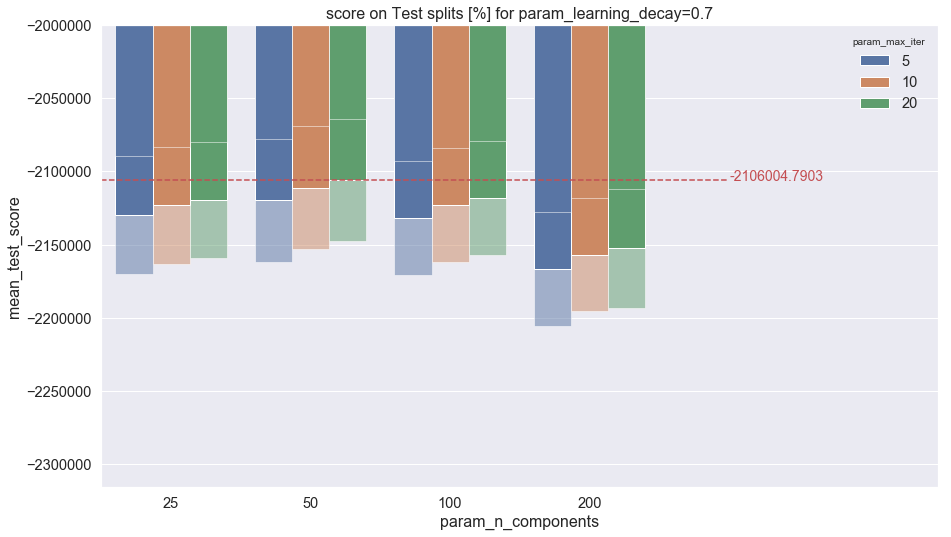

In [262]:
plot_res_test_split(df_res_lda, "score", "param_n_components", 
                    "param_max_iter", y_min=-2000000,
                    myFixedParam="param_learning_decay",
                    myFixedValue=0.7, cv_eval=cv_lda)

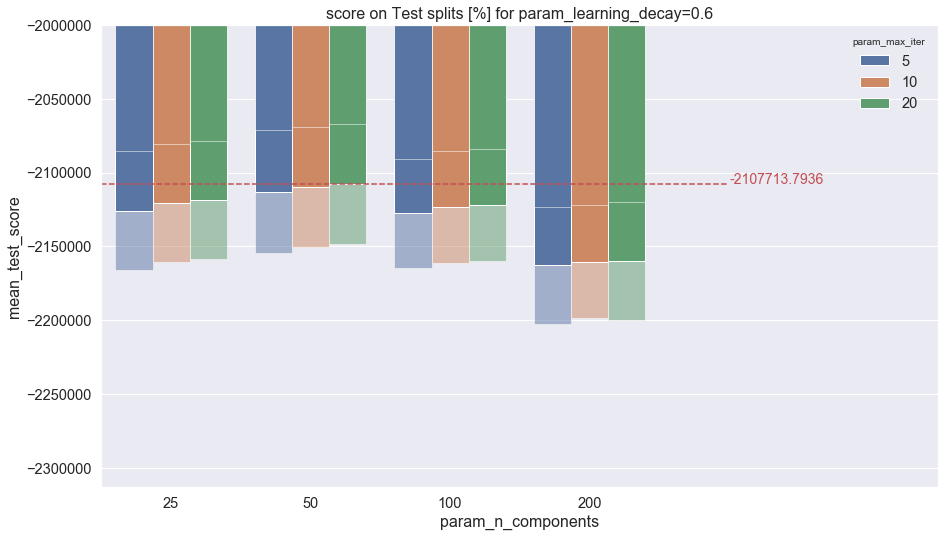

In [263]:
plot_res_test_split(df_res_lda, "score", "param_n_components", 
                    "param_max_iter", y_min=-2000000,
                    myFixedParam="param_learning_decay",
                    myFixedValue=0.6, cv_eval=cv_lda)

(10, 18.76456229350954)

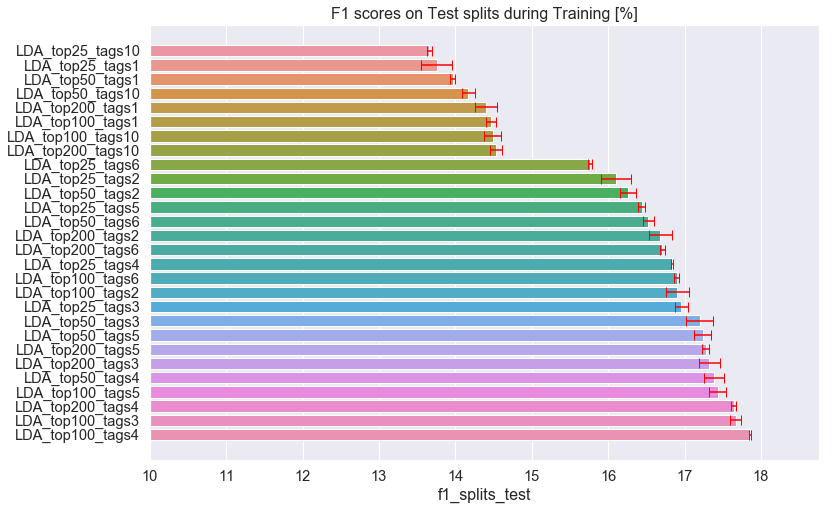

In [799]:
fig = plt.figure(figsize=(12, 8))
plt.title("F1 scores on Test splits during Training [%]")
ax = sns.barplot(
    y=df_results.filter(like='LDA', 
        axis=0).sort_values(by="f1_splits_test").index,
    x=100*df_results.filter(like='LDA', 
        axis=0).sort_values(by="f1_splits_test")["f1_splits_test"], orient="h")

plt.errorbar(x=100*df_results.filter(
    like='LDA', axis=0).sort_values(by="f1_splits_test")["f1_splits_test"],
    y=df_results.filter(like='LDA', 
    axis=0).sort_values(by="f1_splits_test").index, 
    xerr=100*1.96*df_results.filter(like='LDA', axis=0).sort_values(
        by="f1_splits_test")["f1_splits_test_std"]/math.sqrt(cv_lda.n_splits),
    fmt='none', errorevery=1, alpha=1,
    ecolor="red", capsize=5)

ax.set_xlim(left=10)

##### Best unsupervised model:
- LDA model
- n_components: 100
- nb tags predicted: 4
- learning_decay: 0.7 
- max_iter: 20 

### Compare on Test set

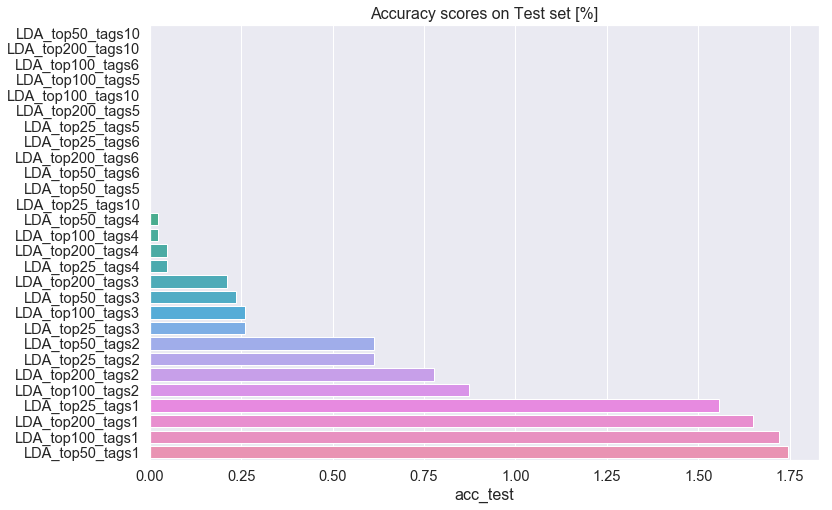

In [264]:
fig = plt.figure(figsize=(12, 8))
plt.title("Accuracy scores on Test set [%]")
sns.barplot(
    y=df_results.filter(like='LDA', axis=0).sort_values(by="acc_test").index,
    x=100*df_results.filter(like='LDA', axis=0).sort_values(by="acc_test")\
        ["acc_test"], orient="h")

(10, 17.992481966880014)

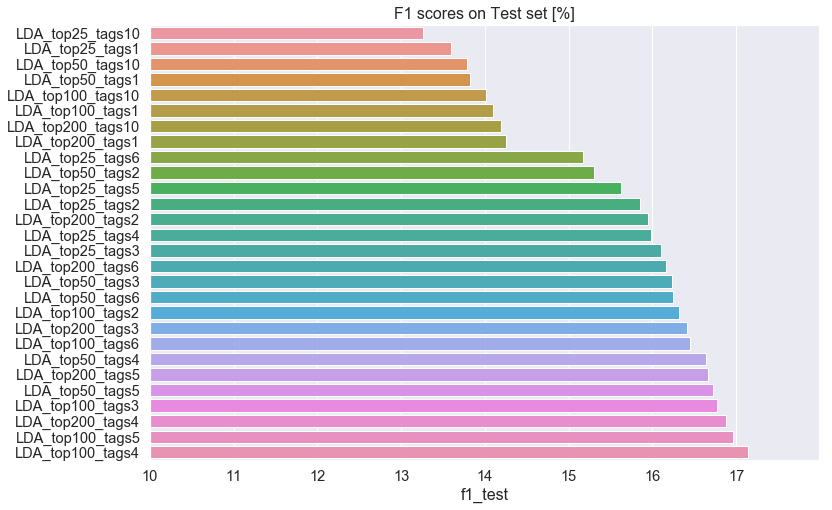

In [265]:
fig = plt.figure(figsize=(12, 8))
plt.title("F1 scores on Test set [%]")
ax = sns.barplot(
    y=df_results.filter(like='LDA', axis=0).sort_values(by="f1_test").index,
    x=100*df_results.filter(like='LDA', axis=0).sort_values(by="f1_test")\
        ["f1_test"], orient="h")
ax.set_xlim(left=10)

##### Generalization
- LDA with 100 topics and 4 tags predicted is the best generalizable model.
    - f1 score  = 17%

- It is also the best model trained on Test splits in trainings
    - f1 score almost 18%

So, Best unsupervised model  is LDA 100 topics with 4 Tags predicted.


## Models Supervised

### Extract n-th first tags from data

In [273]:
df_mdl_sup_1 = df_quest_cleaned.copy()
df_mdl_sup_1["Tag_0"] = df_mdl_sup_1.Tags.apply(apply_extract_tag)
df_mdl_sup_1["Tag_1"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(1,))
df_mdl_sup_1["Tag_2"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(2,))
df_mdl_sup_1["Tag_3"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(3,))
df_mdl_sup_1["Tag_4"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(4,))

df_mdl_sup_1.head()

Id  PostTypeId  AcceptedAnswerId  ParentId         CreationDate  \
3   50000005           1        50000164.0       NaN  2018-04-24 11:00:01   
4   50000006           1        50117317.0       NaN  2018-04-24 11:00:01   
9   50000012           1               NaN       NaN  2018-04-24 11:00:25   
10  50000013           1               NaN       NaN  2018-04-24 11:00:27   
12  50000015           1        50000099.0       NaN  2018-04-24 11:00:31   

    DeletionDate  Score  ViewCount  \
3            NaN     -4       63.0   
4            NaN      0      199.0   
9            NaN     -3       37.0   
10           NaN     -1       42.0   
12           NaN      1      133.0   

                                                 Body  OwnerUserId  \
3   <p>My table looks like this  on sql server</p>...    8217447.0   
4   <p>I have Ola Hallengren's excellent Maintenan...    9690333.0   
9   <p>i want to insert data without page reload.\...    9690673.0   
10  <p>How to upload file in amazon s3 without cre...    5821228.0   
12  <p>I would like to output a table, transformed...    1570450.0   

   OwnerDisplayName  LastEditorUserId  ...  flag_Tag_0 flag_Tag_1 flag_Tag_2  \
3               NaN         3876565.0  ...        True       True       True   
4               NaN               NaN  ...        True      False      False   
9               NaN         9690673.0  ...        True       True       True   
10              NaN               NaN  ...        True       True      False   
12              NaN               NaN  ...        True      False      False   

   flag_Tag_3 flag_Tag_4  flag_most_Tagged_160  flag_most_Tagged_100  \
3       False      False                  True                  True   
4       False      False                  True                  True   
9       False      False                  True                  True   
10      False      False                  True                  True   
12      False      False                  True                  True   

    flag_most_Tagged_76 flag_most_Tagged_40  \
3                  True                True   
4                  True                True   
9                  True                True   
10                 True                True   
12                 True                True   

                                                 Text  \
3   How to insert an entry to a table only if it d...   
4   System DMV's missing from SQL Server 2017 mast...   
9   how to insert data in databse without page rel...   
10  How to upload image using multipart in Amazon ...   
12  DB2 SQL CROSSTAB <p>I would like to output a t...   

                                           token_text Train  
3   insert entry table exist   table looks sql ser...  True  
4   system dmv  s missing sql server  master dacpa...  True  
9   insert databse without page reload     insert ...  True  
10  upload multipart amazon s3   upload amazon s3 ...  True  
12  db2 sql crosstab   would output table   transf...  True  

[5 rows x 40 columns]

### Extracting features from text files

#### Clean text

already done

#### Tokenizing text with scikit-learn

already done

#### TF occurrences

In [274]:
# init features
tf_vectorizer_sup_1 = CountVectorizer(max_df=0.11, min_df=10, max_features=1000,
                                      tokenizer=myTokenizer)

# train counts
tf_1 = tf_vectorizer_sup_1.\
    fit_transform(df_quest_cleaned[\
                                   df_quest_cleaned.Train\
                                   == True]["token_text"])
X_train_counts_sup_1 = tf_1
X_train_counts_sup_1.shape

(16966, 1000)

In [275]:
# test counts
X_test_counts_sup_1 = tf_vectorizer_sup_1.transform(
    df_mdl_sup_1[df_mdl_sup_1.Train == False]["token_text"])
X_test_counts_sup_1.shape

(4242, 1000)

#### From occurrences to frequencies

In [276]:
# calculate tf-idf
tfidf_transformer_sup_1 = TfidfTransformer().fit(X_train_counts_sup_1)

In [277]:
# train
X_train_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_train_counts_sup_1)
X_train_tfidf_sup_1.shape

(16966, 1000)

In [278]:
# test
X_test_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_test_counts_sup_1)
X_test_tfidf_sup_1.shape

(4242, 1000)

In [279]:
print("Nb unique tags in Train: ", df_mdl_sup_1[df_mdl_sup_1.Train == True].\
      Tag_0.nunique())

Nb unique tags in Train:  1236


In [280]:
print("Nb unique tags in Test: ", df_mdl_sup_1[df_mdl_sup_1.Train == False].\
      Tag_0.nunique())

Nb unique tags in Test:  557


### Dummy classifier 1st Tag

In [281]:
clf_dummy = DummyClassifier(strategy='stratified', random_state=0)
clf_dummy.fit(X_train_tfidf_sup_1, 
              df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0)
print("Train Score : ",
      clf_dummy.score(X_train_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0))
print("Test Score : ",
      clf_dummy.score(X_test_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == False].Tag_0))

Train Score :  0.03907815631262525
Test Score :  0.04408297972654408


In [282]:
predicted_train = clf_dummy.predict(X_train_tfidf_sup_1)
predicted_test  = clf_dummy.predict(X_test_tfidf_sup_1)

In [283]:
df_mdl_sup_1.loc[df_mdl_sup_1.Train == True ,"Tag_0_dummy_1"] = predicted_train
df_mdl_sup_1.loc[df_mdl_sup_1.Train == False ,"Tag_0_dummy_1"] = predicted_test
df_mdl_sup_1.filter(items=["token_text",'Tags',"Tag_0_dummy_1"]).head()

token_text  \
3   insert entry table exist   table looks sql ser...   
4   system dmv  s missing sql server  master dacpa...   
9   insert databse without page reload     insert ...   
10  upload multipart amazon s3   upload amazon s3 ...   
12  db2 sql crosstab   would output table   transf...   

                                            Tags Tag_0_dummy_1  
3                          <c#><sql><sql-server>       angular  
4            <sql-server><sql-server-data-tools>   asp.net-mvc  
9                        <javascript><php><ajax>        python  
10  <android><amazon-s3><file-upload><multipart>       node.js  
12                          <sql><db2><crosstab>          html

### MultinomialNB classifier 1st Tag

In [284]:
clf_mnb_1 = MultinomialNB().fit(X_train_tfidf_sup_1, 
                              df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0)

In [285]:
print("Train Score : ",
      clf_mnb_1.score(X_train_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0))
print("Test Score : ",
      clf_mnb_1.score(X_test_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == False].Tag_0))

Train Score :  0.4313332547447837
Test Score :  0.388024516737388


In [286]:
predicted_train = clf_mnb_1.predict(X_train_tfidf_sup_1)
predicted_test  = clf_mnb_1.predict(X_test_tfidf_sup_1)

In [287]:
df_mdl_sup_1.loc[df_mdl_sup_1.Train == True ,"Tag_0_mnb_1"] = predicted_train
df_mdl_sup_1.loc[df_mdl_sup_1.Train == False ,"Tag_0_mnb_1"] = predicted_test
df_mdl_sup_1.filter(items=["token_text",'Tags',"Tag_0_mnb_1"]).head()

token_text  \
3   insert entry table exist   table looks sql ser...   
4   system dmv  s missing sql server  master dacpa...   
9   insert databse without page reload     insert ...   
10  upload multipart amazon s3   upload amazon s3 ...   
12  db2 sql crosstab   would output table   transf...   

                                            Tags Tag_0_mnb_1  
3                          <c#><sql><sql-server>         sql  
4            <sql-server><sql-server-data-tools>          c#  
9                        <javascript><php><ajax>  javascript  
10  <android><amazon-s3><file-upload><multipart>  javascript  
12                          <sql><db2><crosstab>         sql

### SGDClassifier 

#### 1st Tag : Tag_0

In [288]:
print("For Tag_0:")
print('- Nb Tags in Test but not in Train :',
      len(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == False]["Tag_0"].\
                 unique())).\
        difference(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == True]\
                            ["Tag_0"].unique())))))

For Tag_0:
- Nb Tags in Test but not in Train : 143


In [289]:
# list of tags in Test set but not in Train set :
list_tags_test_no_train = set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] \
        == False]["Tag_0"].unique())).\
        difference(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == True]\
                            ["Tag_0"].unique())))
# creation of dataframe with these special tags
df_count = pd.DataFrame(data=list(list_tags_test_no_train), columns=["Tag_0"])
# add columns of count of every special tags into Test:
df_count["nb_tags"] = 0
def apply_fun_nb(tag_curr):
    return df_mdl_sup_1[(df_mdl_sup_1["Train"] == False) & \
                 (df_mdl_sup_1["Tag_0"] == tag_curr)].shape[0]
df_count["nb_tags"] = df_count["Tag_0"].apply(apply_fun_nb)
df_count

Tag_0  nb_tags
0       google-cloud-pubsub        1
1                quickbooks        1
2          bit-manipulation        1
3                   json-ld        1
4       castle-dynamicproxy        1
5                      mesh        1
6                     slurm        1
7     google-compute-engine        1
8             monaco-editor        1
9                      smtp        1
10                  cookies        1
11        ibm-cloud-private        1
12                      vtk        1
13                     grpc        1
14                  postgis        1
15              file-upload        1
16                  odoo-10        1
17                 cucumber        1
18                  default        1
19   google-cloud-datastore        1
20           caliburn.micro        1
21           poco-libraries        1
22                stargazer        1
23                     pyxb        1
24                    queue        1
25       azure-data-factory        1
26                  spotify        1
27                 git-bash        1
28                artoolkit        1
29                     cron        1
..                      ...      ...
113                  shader        1
114              salt-stack        1
115               clickonce        1
116   azure-web-app-service        1
117            ubuntu-14.04        1
118                isabelle        1
119          flask-oauthlib        1
120            ubuntu-16.04        1
121                    antd        1
122      javascript-objects        2
123           python-import        1
124                printing        1
125              namespaces        1
126             constructor        1
127             atom-editor        1
128                 protege        1
129                  mapbox        1
130           local-storage        1
131                 webhdfs        1
132         ruby-on-rails-3        1
133                    jaxb        1
134          android-intent        1
135                  redhat        1
136                   cplex        1
137                   tosca        1
138                ejabberd        2
139                      gf        1
140      automationanywhere        1
141                 java-10        1
142        asp.net-identity        1

[143 rows x 2 columns]

Text(0, 0.5, 'nb Tags 1 [-]')

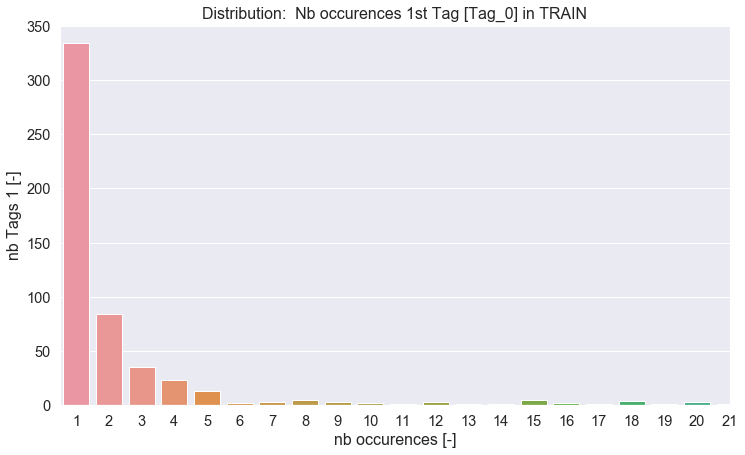

In [290]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution:  Nb occurences 1st Tag [Tag_0] in TRAIN")
ax = sns.countplot(df_mdl_sup_1[df_mdl_sup_1["Train"] == False]
                  ["Tag_0"].value_counts())
ax.set_xlim(right=20)
ax.set_xlabel("nb occurences [-]")
ax.set_ylabel("nb Tags 1 [-]")

Text(0, 0.5, 'nb Tags 1 [-]')

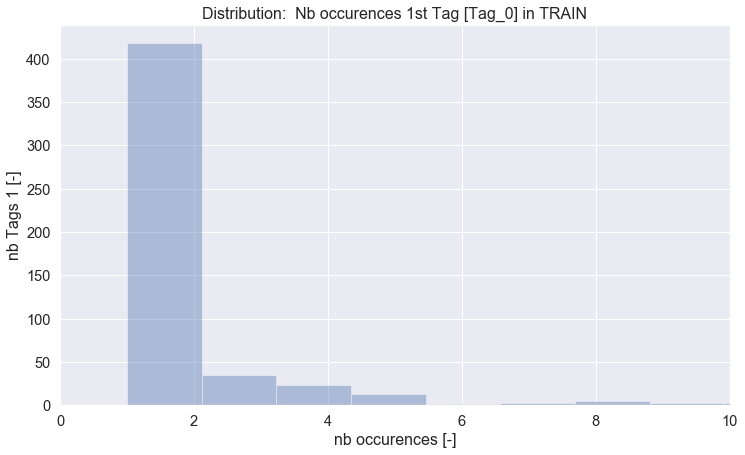

In [291]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution:  Nb occurences 1st Tag [Tag_0] in TRAIN")
ax = sns.distplot(df_mdl_sup_1[df_mdl_sup_1["Train"] == False]
                  ["Tag_0"].value_counts(), bins=400, kde=False)
ax.set_xlim([0, 10])
ax.set_xlabel("nb occurences [-]")
ax.set_ylabel("nb Tags 1 [-]")

Text(0.5, 0, 'count of 1st Tag  [-]')

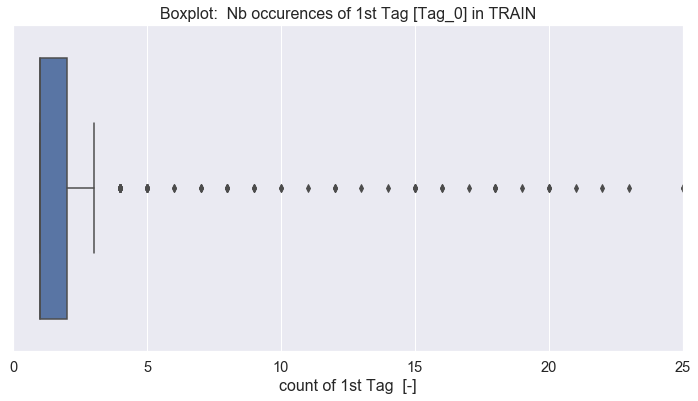

In [292]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot:  Nb occurences of 1st Tag [Tag_0] in TRAIN")
ax = sns.boxplot(df_mdl_sup_1[df_mdl_sup_1["Train"]
                              == False]["Tag_0"].value_counts())
ax.set_xlim([0, 25])
ax.set_xlabel("count of 1st Tag  [-]")

Text(0, 0.5, 'nb Tags 1 [-]')

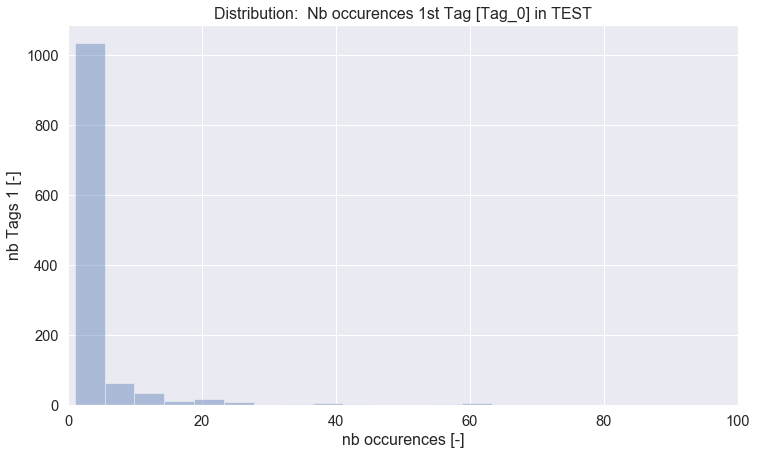

In [293]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution:  Nb occurences 1st Tag [Tag_0] in TEST")
ax = sns.distplot(df_mdl_sup_1[df_mdl_sup_1["Train"] == True]
                  ["Tag_0"].value_counts(), bins=400, kde=False)
ax.set_xlim([0, 100])
ax.set_xlabel("nb occurences [-]")
ax.set_ylabel("nb Tags 1 [-]")

Text(0.5, 0, 'count of 1st Tag  [-]')

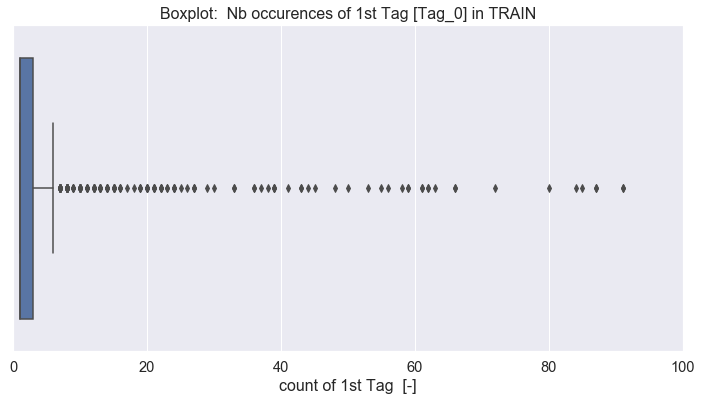

In [294]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot:  Nb occurences of 1st Tag [Tag_0] in TRAIN")
ax = sns.boxplot(df_mdl_sup_1[df_mdl_sup_1["Train"]
                              == True]["Tag_0"].value_counts())
ax.set_xlim([0, 100])
ax.set_xlabel("count of 1st Tag  [-]")

In [295]:
df_mdl_sup_1.Tag_0.nunique()

1379

In [296]:
clf_sgc_1 = SGDClassifier(loss='hinge', penalty='l2',
                        alpha=1e-3, random_state=0,
                        max_iter=5, tol=None)

clf_sgc_1.fit(X_train_tfidf_sup_1, 
              df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [297]:
print("Train Score : ",
      clf_sgc_1.score(X_train_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0))
print("Test Score : ",
      clf_sgc_1.score(X_test_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == False].Tag_0))

Train Score :  0.6551337970057762
Test Score :  0.44625176803394623


In [298]:
predicted_train = clf_sgc_1.predict(X_train_tfidf_sup_1) 
predicted_test = clf_sgc_1.predict(X_test_tfidf_sup_1)

In [299]:
find_nb_no_uniquetag(predicted_train)
find_nb_no_uniquetag(predicted_test)

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]


0

In [300]:
precision_score(df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0, predicted_train, average='micro')

0.6551337970057762

In [301]:
recall_score(df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0, predicted_train,
                average='micro')

0.6551337970057762

In [302]:
precision_score(df_mdl_sup_1[df_mdl_sup_1.Train == False].Tag_0, predicted_test, average='micro')

0.44625176803394623

In [303]:
predicted_train

array(['convex-hull', 'sql-server', 'javascript', ..., 'python', 'python',
       'vb.net'], dtype='<U25')

In [304]:
df_mdl_sup_1.loc[df_mdl_sup_1.Train == True ,"Tag_0_sgc_1"] = predicted_train
df_mdl_sup_1.loc[df_mdl_sup_1.Train == False ,"Tag_0_sgc_1"] = predicted_test
df_mdl_sup_1.filter(items=["token_text",'Tags',"Tag_0_sgc_1"]).head()

token_text  \
3   insert entry table exist   table looks sql ser...   
4   system dmv  s missing sql server  master dacpa...   
9   insert databse without page reload     insert ...   
10  upload multipart amazon s3   upload amazon s3 ...   
12  db2 sql crosstab   would output table   transf...   

                                            Tags  Tag_0_sgc_1  
3                          <c#><sql><sql-server>  convex-hull  
4            <sql-server><sql-server-data-tools>   sql-server  
9                        <javascript><php><ajax>   javascript  
10  <android><amazon-s3><file-upload><multipart>      powerbi  
12                          <sql><db2><crosstab>          sql

In [305]:
df_mdl_sup_1[df_mdl_sup_1["Tag_0_sgc_1"].isna()]

Empty DataFrame
Columns: [Id, PostTypeId, AcceptedAnswerId, ParentId, CreationDate, DeletionDate, Score, ViewCount, Body, OwnerUserId, OwnerDisplayName, LastEditorUserId, LastEditorDisplayName, LastEditDate, LastActivityDate, Title, Tags, AnswerCount, CommentCount, FavoriteCount, ClosedDate, CommunityOwnedDate, nb_Tags, Tag_0, Tag_1, Tag_2, Tag_3, Tag_4, flag_Tag_0, flag_Tag_1, flag_Tag_2, flag_Tag_3, flag_Tag_4, flag_most_Tagged_160, flag_most_Tagged_100, flag_most_Tagged_76, flag_most_Tagged_40, Text, token_text, Train, Tag_0_dummy_1, Tag_0_mnb_1, Tag_0_sgc_1]
Index: []

[0 rows x 43 columns]

#### 2nd Tag : Tag_1

In [306]:
print("For Tag_1:")
print('- Nb Tags in Test but not in Train :',
      len(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == False]["Tag_1"].\
                 unique())).\
        difference(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == True]\
                            ["Tag_1"].unique())))))

For Tag_1:
- Nb Tags in Test but not in Train : 434


##### 2nd Tag  : Train part

In [307]:
df_train = df_mdl_sup_1[df_mdl_sup_1.Train == True].filter(items=["Tag_1"])
df_train = df_train.reset_index()
print(df_train.shape)
df_train.head()

(16966, 2)


index                  Tag_1
0      3                    sql
1      4  sql-server-data-tools
2      9                    php
3     10              amazon-s3
4     12                    db2

In [308]:
df_train = df_train[df_train["Tag_1"].notna()]
df_train.head() 

index                  Tag_1
0      3                    sql
1      4  sql-server-data-tools
2      9                    php
3     10              amazon-s3
4     12                    db2

In [309]:
df_train.shape

(14924, 2)

In [310]:
list_idx_xtrain = df_train.index.tolist()
print(list_idx_xtrain[:10])
print("...")
print(list_idx_xtrain[-10:])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]
...
[16953, 16954, 16957, 16959, 16960, 16961, 16962, 16963, 16964, 16965]


In [311]:
X_train_tfidf_sup_1.shape

(16966, 1000)

In [312]:
len(list_idx_xtrain)

14924

In [313]:
X_train_tfidf_sup_tag_1 = X_train_tfidf_sup_1[list_idx_xtrain,:]
X_train_tfidf_sup_tag_1.shape

(14924, 1000)

##### 2nd Tag:  Test part

In [314]:
df_test = df_mdl_sup_1[df_mdl_sup_1.Train == False].filter(items=["Tag_1"])
df_test = df_test.reset_index()
print(df_test.shape)
df_test.head()

(4242, 2)


index        Tag_1
0     21  objective-c
1     31        swift
2     54           qt
3     68          vba
4     94       gradle

In [315]:
df_test = df_test[df_test["Tag_1"].notna()]
df_test.head() 

index        Tag_1
0     21  objective-c
1     31        swift
2     54           qt
3     68          vba
4     94       gradle

In [316]:
df_test.shape

(3727, 2)

In [317]:
list_idx_xtest = df_test.index.tolist()
print(list_idx_xtest[:10])
print("...")
print(list_idx_xtest[-10:])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
...
[4227, 4229, 4230, 4232, 4233, 4236, 4238, 4239, 4240, 4241]


In [318]:
X_test_tfidf_sup_1.shape

(4242, 1000)

In [319]:
len(list_idx_xtest)

3727

In [320]:
X_test_tfidf_sup_tag_1 = X_test_tfidf_sup_1[list_idx_xtest,:]
X_test_tfidf_sup_tag_1.shape

(3727, 1000)

##### Fitting

In [321]:
clf_sgc_2 = SGDClassifier(loss='hinge', penalty='l2',
                        alpha=1e-3, random_state=0,
                        max_iter=5, tol=None)

clf_sgc_2.fit(X_train_tfidf_sup_tag_1, df_train["Tag_1"])

SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

##### Scores

In [322]:
print("Train Score : ",
      clf_sgc_2.score(X_train_tfidf_sup_tag_1, df_train["Tag_1"]))
print("Test Score : ",
      clf_sgc_2.score(X_test_tfidf_sup_tag_1, df_test["Tag_1"]))

Train Score :  0.8204904851246315
Test Score :  0.19586799034075664


In [323]:
df_train["Tag_1"].nunique()

3129

In [324]:
df_train.shape

(14924, 2)

Text(0.5, 0, 'count of 2nd Tag  [-]')

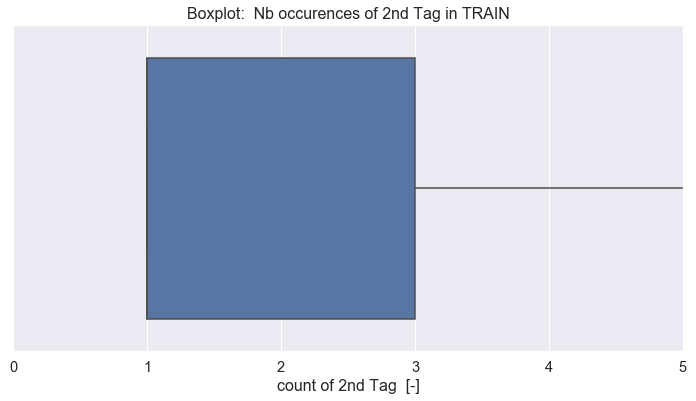

In [325]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot:  Nb occurences of 2nd Tag in TRAIN")
ax = sns.boxplot(df_train["Tag_1"].value_counts())
ax.set_xlim([0,5])
ax.set_xlabel("count of 2nd Tag  [-]")

Text(0, 0.5, 'nb Tags 1 [-]')

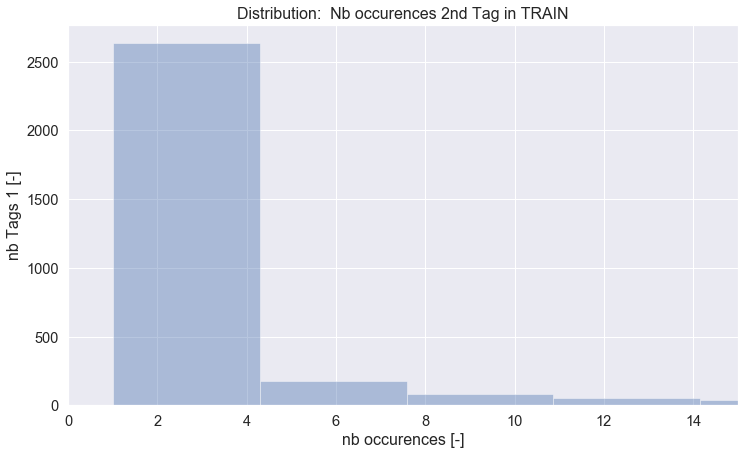

In [326]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution:  Nb occurences 2nd Tag in TRAIN")
ax = sns.distplot(df_train["Tag_1"].value_counts(), bins=100, kde=False)
ax.set_xlim([0,15])
ax.set_xlabel("nb occurences [-]")
ax.set_ylabel("nb Tags 1 [-]")

###  RandomForest Multi-Tags : 51 Most Used Tags

#### Splits for Optim

In [327]:
# Split parameters
random_state = 0
n_splits = 3
test_size=0.2

# preparation des splits : choix de splits aléatoires de meme taille
cv = model_selection.ShuffleSplit(n_splits=n_splits, test_size=test_size, 
                                  random_state=random_state)

In [328]:
df_most

nb_min_used  nb_most_used_tags  pc_of_unique_tags  pc_of_quest
0          160                 51           0.581860    76.914372
1          100                 73           0.832858    80.879857
2           76                100           1.140901    83.666541
3           40                201           2.293212    88.494908

#### Choose Most Used Tags

In [329]:
idx_most = 0

In [330]:
list_tags_most_used = list_list_most_used[idx_most]
col_flag = "flag_most_Tagged_{:.0f}".format(df_most.iloc[idx_most]["nb_min_used"])
print(col_flag)
nb_most_used_tags = df_most.iloc[idx_most]["nb_most_used_tags"]
len(list_tags_most_used)

flag_most_Tagged_160


51

#### Multi-label encoding

##### For output to predict, extract only most used Tags

In [331]:
# create list of list of Tags to be able to encode multi label outputs
print('\nFor train set...')  
list_list_tags_train = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == True) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_train[:10])

print('\nFor test set...')  
list_list_tags_test = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_test[:10])


For train set...
[['c#', 'sql', 'sql-server'], ['sql-server'], ['javascript', 'php', 'ajax'], ['android'], ['sql'], ['php', 'laravel'], ['python'], ['java'], ['javascript', 'json', 'reactjs'], ['android']]

For test set...
[['ios'], ['ios', 'swift'], ['c++'], ['excel', 'vba', 'excel-vba'], ['android'], ['sql-server'], ['c#', 'asp.net'], ['javascript', 'reactjs'], ['python', 'django'], ['javascript', 'angular', 'typescript']]


##### Encoding output to predict

In [332]:
#y = [['tag3','tag1'],['tag1','tag0','tag2']]
mlb = MultiLabelBinarizer()
encoded_y_train = mlb.fit_transform(list_list_tags_train)
encoded_y_test = mlb.transform(list_list_tags_test)

In [333]:
encoded_y_train.shape

(13024, 51)

In [334]:
encoded_y_test.shape

(3288, 51)

In [335]:
encoded_y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

##### Check if enough sample for each most used Tags (important for Training) :

In [336]:
#for idx in range(0, encoded_y_train.shape[1]):
print('For less used tag:')
print("- For train: ")
nb_used_tags_train = np.sum(encoded_y_train, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_train))
print("\n- For test : ")
nb_used_tags_test = np.sum(encoded_y_test, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_test))

For less used tag:
- For train: 
  - Number of use:  122

- For test : 
  - Number of use:  31


In [337]:
# for idx in range(0, encoded_y_train.shape[1]):
print('For each sample:')
print("- For train: ")
nb_tags_per_sample_train = np.sum(encoded_y_train, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_train))
print("\n- For test : ")
nb_tags_per_sample_test = np.sum(encoded_y_test, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_test))

For each sample:
- For train: 
  - Minimum Number of Tags:  1

- For test : 
  - Minimum Number of Tags:  1


In [338]:
find_nb_no_tags(encoded_y_train)
find_nb_no_tags(encoded_y_test)

Nb. no Tags samples : 0 over 13024 rows [0.00%]
Nb. no Tags samples : 0 over 3288 rows [0.00%]


0

In [339]:
df_mdl_sup_1[df_mdl_sup_1.Train == False].iloc[8]["Tags"]

'<python><django>'

In [340]:
mlb.classes_

array(['.net', 'ajax', 'amazon-web-services', 'android', 'angular',
       'angularjs', 'apache-spark', 'arrays', 'asp.net', 'c', 'c#', 'c++',
       'css', 'database', 'django', 'docker', 'excel', 'excel-vba',
       'firebase', 'html', 'ios', 'java', 'javascript', 'jquery', 'json',
       'laravel', 'linux', 'mongodb', 'mysql', 'node.js', 'oracle',
       'pandas', 'php', 'postgresql', 'python', 'python-3.x', 'r',
       'react-native', 'reactjs', 'regex', 'ruby-on-rails', 'spring',
       'spring-boot', 'sql', 'sql-server', 'swift', 'tensorflow',
       'typescript', 'vba', 'wordpress', 'xml'], dtype=object)

#### Distribution of Tags

(0, 1000)

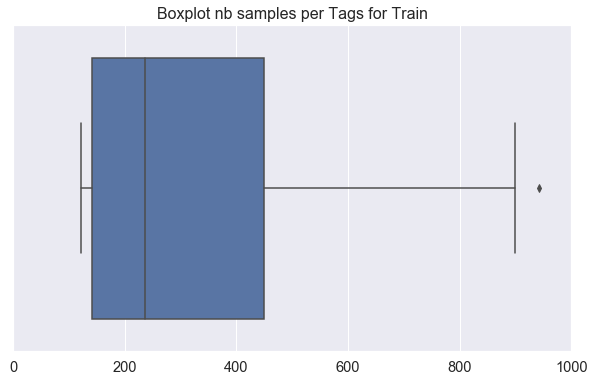

In [341]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb samples per Tags for Train")
ax = sns.boxplot(encoded_y_train.sum(axis=0))
ax.set_xlim([0,1000])

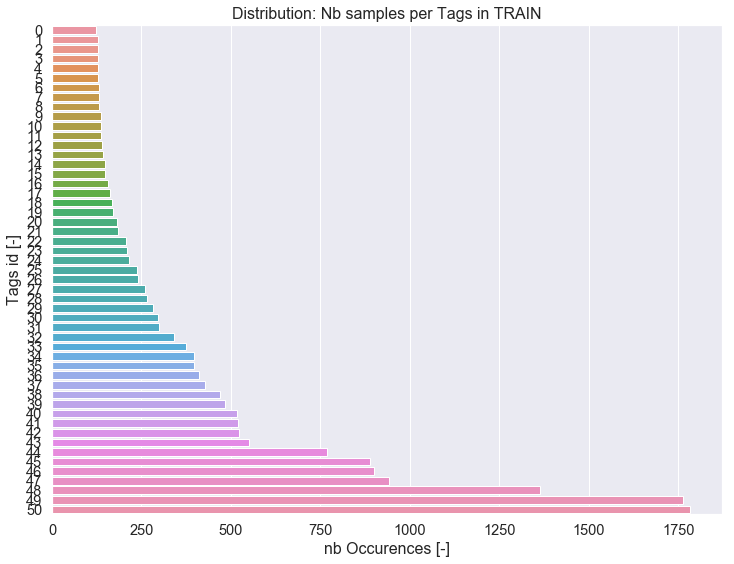

In [342]:
fig = plt.figure(figsize=(12, 9))
plt.title("Distribution: Nb samples per Tags in TRAIN")
df_count = pd.DataFrame(data=encoded_y_train.sum(axis=0), columns=['nb_samples'])
ax = sns.barplot(y=df_count.index, x=sorted(df_count["nb_samples"]), orient='h')
#ax.set_xlim(right=90)
#ax.set_ylim([0, 20])
ax.set_xlabel("nb Occurences [-]")
ax.set_ylabel("Tags id [-]");

In [343]:
df_count[df_count["nb_samples"] < df_most.iloc[idx_most]["nb_min_used"]]

nb_samples
0          143
1          149
2          131
5          130
6          128
8          156
13         131
15         130
17         140
26         132
27         129
30         136
33         137
37         137
40         147
46         122
50         129

Text(0, 0.5, 'nb [-]')

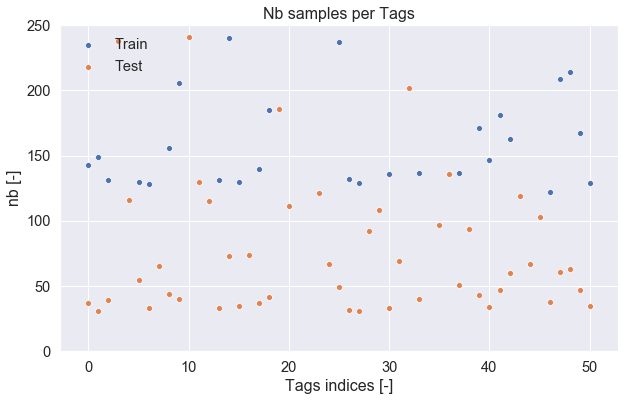

In [344]:
fig = plt.figure(figsize=(10, 6))
plt.title("Nb samples per Tags")
ax = sns.scatterplot(data=encoded_y_train.sum(axis=0), label='Train')
ax1 = sns.scatterplot(data=encoded_y_test.sum(axis=0), label='Test')
#ax1.set_xlim([0,250])
ax.set_xlabel('Tags indices [-]')
ax1.set_ylim([0,250])
ax.set_ylabel('nb [-]')

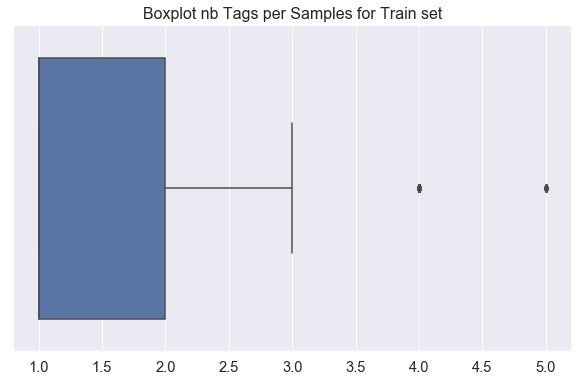

In [345]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Train set")
ax = sns.boxplot(encoded_y_train.sum(axis=1))
#ax.set_xlim([0,250])

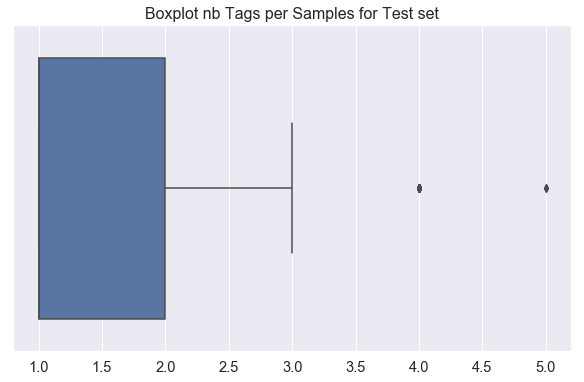

In [346]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Test set")
ax = sns.boxplot(encoded_y_test.sum(axis=1))

#### Features preparation

In [347]:
# init features
tf_vectorizer_sup_1 = CountVectorizer(max_df=0.11, min_df=10, max_features=1000,
                                      tokenizer=myTokenizer)
# train counts
tf_1 = tf_vectorizer_sup_1.\
    fit_transform(df_quest_cleaned[(df_quest_cleaned.Train== True) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_train_counts_sup_1 = tf_1
X_train_counts_sup_1.shape

(13024, 1000)

In [348]:
# test counts
X_test_counts_sup_1 = tf_vectorizer_sup_1.transform(
    df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_test_counts_sup_1.shape

(3288, 1000)

In [349]:
# calculate tf-idf
tfidf_transformer_sup_1 = TfidfTransformer().fit(X_train_counts_sup_1)

In [350]:
# train
X_train_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_train_counts_sup_1)
X_train_tfidf_sup_1.shape

(13024, 1000)

In [351]:
# test
X_test_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_test_counts_sup_1)
X_test_tfidf_sup_1.shape

(3288, 1000)

##### Save

In [352]:
# MultiLabelBinarizer : mlb
str_save_mlb = PATH_EXPORT_FOLDER + \
    "mlb_tags{}.pkl".format(int(nb_most_used_tags))
joblib.dump(mlb, str_save_mlb)
print("mdl Saved here: {}".format(str_save_mlb))
#joblib_mlb = open(str_save_mlb,'rb')
#mlb_test = joblib.load(joblib_mlb)

mdl Saved here: ../../data/mlb_tags51.pkl


In [353]:
# CountVectorizer : tf_vectorizer_sup_1
str_save_cvect = PATH_EXPORT_FOLDER + \
    "cvect_tags{}.pkl".format(int(nb_most_used_tags))
joblib.dump(tf_vectorizer_sup_1, str_save_cvect)
print("CountVectorizer Saved here: {}".format(str_save_cvect))

'''joblib_mdl = open(str_save_cvect,'rb')
mdl_test_import = joblib.load(joblib_mdl)
mdl_test_import.transform(
    df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])'''

CountVectorizer Saved here: ../../data/cvect_tags51.pkl


'joblib_mdl = open(str_save_cvect,\'rb\')\nmdl_test_import = joblib.load(joblib_mdl)\nmdl_test_import.transform(\n    df_mdl_sup_1[(df_mdl_sup_1.Train == False) &     (df_mdl_sup_1[col_flag] == True)]["token_text"])'

In [354]:
# TfidfTransformer : tfidf_transformer_sup_1
str_save_tfidf = PATH_EXPORT_FOLDER + \
    "tfidf_tags{}.pkl".format(int(nb_most_used_tags))
joblib.dump(tfidf_transformer_sup_1, str_save_tfidf)
print("TfidfTransformer Saved here: {}".format(str_save_tfidf))

'''joblib_mdl = open(str_save_tfidf,'rb')
mdl_test_import = joblib.load(joblib_mdl)
mdl_test_import.transform(X_test_counts_sup_1)'''

TfidfTransformer Saved here: ../../data/tfidf_tags51.pkl


"joblib_mdl = open(str_save_tfidf,'rb')\nmdl_test_import = joblib.load(joblib_mdl)\nmdl_test_import.transform(X_test_counts_sup_1)"

#### Fit

In [355]:
X_train_tfidf_sup_1.shape

(13024, 1000)

In [356]:
encoded_y_train.shape

(13024, 51)

In [357]:
encoded_y_train[:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0

In [358]:
encoded_y_test[:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [359]:
for idx in range(0, encoded_y_train.shape[0]):
    if sum(encoded_y_train[idx,:]) == 0:
        print('Error : row n°{} is empty!'.format(idx))

In [360]:
for idx in range(0, encoded_y_test.shape[0]):
    if sum(encoded_y_test[idx,:]) == 0:
        print('Error : row n°{} is empty!'.format(idx))
    

In [361]:
#n_estimators=100 Train Score :  0.9991341414679632 Test Score :  0.17448055407565263
#

clf_rfc_multi_1 = RandomForestClassifier(n_estimators=10, random_state=0, 
                                         n_jobs=-1)

# fitting
t_0 = time.time()
clf_rfc_multi_1.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print(clf_rfc_multi_1)
print("timing total: {} s".format(t_1-t_0))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
timing total: 4.255975246429443 s


In [362]:
print("Train Score : ", 
      clf_rfc_multi_1.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      clf_rfc_multi_1.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score :  0.8958845208845209
Test Score :  0.2840632603406326


Hamming loss : for one tag not well predicted, add  1 / (number of labels * n samples) to total losses

In [363]:
predicted_train = clf_rfc_multi_1.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
    
predicted_test = clf_rfc_multi_1.predict(X_test_tfidf_sup_1)
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

#predicted_train = clf_rfc_multi_1.predict(X_train_tfidf_sup_1)
#predicted_test = clf_rfc_multi_1.predict(X_test_tfidf_sup_1)
predicted_train
#df_mdl_sup_1["Tag_0_sgc_1"] = np.nan

#df_mdl_sup_1.loc[df_mdl_sup_1.Train == True ,"Tag_0_sgc_1"] = predicted_train
#df_mdl_sup_1.loc[df_mdl_sup_1.Train == False ,"Tag_0_sgc_1"] = predicted_test
#df_mdl_sup_1.head()

Train hamming loss : 0.0024585079732138554
Test hamming loss : 0.020675301750870664


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [364]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 675 over 13024 rows [5.18%]
Nb. no Tags samples : 1324 over 3288 rows [40.27%]


1324

#### Optim 1

In [365]:
clf_rf_multi_cv = RandomForestClassifier(random_state=0, n_jobs=-1)

In [366]:
# Fixer les valeurs des hyperparamètres à tester
# 5th try OVR
# {'estimator__n_estimators': [25], 'estimator__max_features': [155]} 0.192585
# Train Score : 0.961302784068203
# Test Score :  0.20671283963771978
# Nb. no Tags samples : 232 over 15014 rows [1.55%]
# Nb. no Tags samples : 1158 over 3754 rows [30.85%]

# 1st try {'n_estimators': [10, 20, 30], 'max_features': [24, 31, 37]}
# - best : {'max_features': 37, 'n_estimators': 30}
#   Train Score : 0.9697780908770693
#   Test Score :  0.24260355029585798
#   Nb. no Tags samples : 173 over 14195 rows [1.22%]
#   Nb. no Tags samples : 1486 over 3549 rows [41.87%] 

#2nd Try : {'n_estimators': [30, 40], 'max_features': [37, 43, 49]}
#{'max_features': 49, 'n_estimators': 40}
#Train Score : 0.9844311377245509
#Test Score :  0.25725556494787266
#Nb. no Tags samples : 87 over 14195 rows [0.61%]
#Nb. no Tags samples : 1342 over 3549 rows [37.81%]

#{'n_estimators': [50, 60], 'max_features': [55, 62, 68]}
#{'max_features': 68, 'n_estimators': 60}
#Train Score : 0.994082423388517
#Test Score :  0.2702169625246548
#Nb. no Tags samples : 27 over 14195 rows [0.19%]
#Nb. no Tags samples : 1223 over 3549 rows [34.46%]

#{'n_estimators': [60, 70], 'max_features': [68, 93, 124]} 0.266408
#{'max_features': 124, 'n_estimators': 70}
#Train Score : 0.994082423388517
#Test Score :  0.2702169625246548
#Nb. no Tags samples : 27 over 14195 rows [0.19%]
#Nb. no Tags samples : 1223 over 3549 rows [34.46%]

#{'n_estimators': [80], 'max_features': [124, 155, 186]}    
# {'max_features': 186, 'n_estimators': 80}
#Train Score : 0.9970412116942585
#Test Score :  0.2879684418145957
#Nb. no Tags samples : 13 over 14195 rows [0.09%]
#Nb. no Tags samples : 1008 over 3549 rows [28.40%]

#{'n_estimators': [25], 'max_features': [31], 'min_samples_split': [3]}
#Train Score : 0.9301289926289926
#Test Score :  0.3223844282238443
#Nb. no Tags samples : 415 over 13024 rows [3.19%]
#Nb. no Tags samples : 1195 over 3288 rows [36.34%]
'''
{'n_estimators': [10],
 'max_features': [31],
 'min_samples_split': [5, 6, 7, 8, 9, 10, 11],
 'max_depth': [5, 10, 50, 100, 200, 210, 250, 300, 350, 400 ]}
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 210, 'max_features': 31, 'min_samples_split': 9, 'n_estimators': 10}
accuracy 0.309021
Train Score : 0.6880374692874693
Test Score :  0.31295620437956206
Nb. no Tags samples : 2074 over 13024 rows [15.92%]
Nb. no Tags samples : 1212 over 3288 rows [36.86%]
'''

#{'max_depth': 210, 'max_features': 31, 'min_samples_split': 5, 'n_estimators': 50}
#Train Score : 0.829161547911548
#Test Score :  0.32025547445255476
#Nb. no Tags samples : 1554 over 13024 rows [11.93%]
#Nb. no Tags samples : 1277 over 3288 rows [38.84%]    

#{'max_depth': 140, 'max_features': 31, 'min_samples_split': 4, 'n_estimators': 50}
#Train Score : 0.8472051597051597
#Test Score :  0.31873479318734793
#Nb. no Tags samples : 1365 over 13024 rows [10.48%]
#Nb. no Tags samples : 1268 over 3288 rows [38.56%]
    
max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))
n_estimators_range = [50]
max_depth_range = [None, 25, 50, 100, 150, 200]
max_features_range = [max_features_ideal]
min_samples_split_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]

score = ['accuracy', 'f1_micro', 'precision_micro', 'recall_micro']
#score = 'accuracy'
# grille de paramètres
param_grid = {'n_estimators': n_estimators_range, 
              'max_features': max_features_range,
             'min_samples_split': min_samples_split_range,
             'max_depth': max_depth_range}
param_grid


'''max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))
n_estimators_range = [25]
max_features_range = [max_features_ideal]
min_samples_split_range = [3]
score = 'f1_micro'
#score = 'accuracy'
# grille de paramètres
param_grid = {'n_estimators': n_estimators_range, 
              'max_features': max_features_range,
             'min_samples_split': min_samples_split_range}
param_grid'''

"max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))\nn_estimators_range = [25]\nmax_features_range = [max_features_ideal]\nmin_samples_split_range = [3]\nscore = 'f1_micro'\n#score = 'accuracy'\n# grille de paramètres\nparam_grid = {'n_estimators': n_estimators_range, \n              'max_features': max_features_range,\n             'min_samples_split': min_samples_split_range}\nparam_grid"

In [367]:
# Créer  avec recherche d'hyperparamètre par validation croisée
g_clf_rf_multi_cv = model_selection.GridSearchCV(clf_rf_multi_cv,
param_grid, # hyperparamètres à tester
cv=cv,# nombre de folds de validation croisée
scoring=score, refit="f1_micro") # score à optimiser

# Optimiser ce classifieur sur le jeu d'entraînement
t_0 = time.time()
g_clf_rf_multi_cv.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_clf_rf_multi_cv.best_params_)

timing total: 3223.6114168167114 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 150, 'max_features': 31, 'min_samples_split': 4, 'n_estimators': 50}


In [368]:
df_res_rf_multi_cv = pd.DataFrame(data=g_clf_rf_multi_cv.cv_results_)
#df_res_rf_multi_cv[df_res_rf_multi_cv["rank_test_score"]<5].T
df_res_rf_multi_cv.sort_values(by="rank_test_f1_micro").T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/depre

38  \
mean_fit_time                                                           9.26193   
std_fit_time                                                          0.0689236   
mean_score_time                                                         2.55738   
std_score_time                                                        0.0424367   
param_max_depth                                                             150   
param_max_features                                                           31   
param_min_samples_split                                                       4   
param_n_estimators                                                           50   
params                        {'max_depth': 150, 'max_features': 31, 'min_sa...   
split0_test_accuracy                                                   0.305566   
split1_test_accuracy                                                   0.320537   
split2_test_accuracy                                                   0.310173   
mean_test_accuracy                                                     0.312092   
std_test_accuracy                                                    0.00626085   
rank_test_accuracy                                                            1   
split0_train_accuracy                                                  0.843555   
split1_train_accuracy                                                  0.845571   
split2_train_accuracy                                                   0.84797   
mean_train_accuracy                                                    0.845699   
std_train_accuracy                                                   0.00180469   
split0_test_f1_micro                                                   0.545675   
split1_test_f1_micro                                                   0.563151   
split2_test_f1_micro                                                   0.557089   
mean_test_f1_micro                                                     0.555305   
std_test_f1_micro                                                    0.00724515   
rank_test_f1_micro                                                            1   
split0_train_f1_micro                                                   0.93773   
split1_train_f1_micro                                                  0.939308   
split2_train_f1_micro                                                  0.939819   
mean_train_f1_micro                                                    0.938952   
std_train_f1_micro                                                  0.000888794   
split0_test_precision_micro                                            0.864583   
split1_test_precision_micro                                            0.866987   
split2_test_precision_micro                                            0.850448   
mean_test_precision_micro                                              0.860673   
std_test_precision_micro                                             0.00729654   
rank_test_precision_micro                                                    37   
split0_train_precision_micro                                           0.999272   
split1_train_precision_micro                                           0.999133   
split2_train_precision_micro                                           0.999134   
mean_train_precision_micro                                              0.99918   
std_train_precision_micro                                           6.53892e-05   
split0_test_recall_micro                                               0.398635   
split1_test_recall_micro                                               0.417009   
split2_test_recall_micro                                               0.414209   
mean_test_recall_micro                                                 0.409951   
std_test_recall_micro                                                 0.0080829   
rank_test_recall_micro                                                        3   
split0_tra

##### Save

In [369]:
save_gridsearchcv_sup(g_clf_rf_multi_cv, df_res_rf_multi_cv,"RF")

max_depth
150
max_features
31
min_samples_split
4
n_estimators
50
Results Saved here:
../../data/df_res_RF_tags51_max_depth150_max_features31_min_samples_split4_n_estimators50.csv
Model Saved here:
../../data/model_RF_tags51_max_depth150_max_features31_min_samples_split4_n_estimators50.pkl


##### Scores of optimization

In [370]:
g_clf_rf_multi_cv.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 150,
 'max_features': 31,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

##### Eval best estimator :

In [371]:
print("Train Score :", 
      g_clf_rf_multi_cv.best_estimator_.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      g_clf_rf_multi_cv.best_estimator_.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.8508138820638821
Test Score :  0.3220802919708029


In [372]:
predicted_train = g_clf_rf_multi_cv.best_estimator_.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
t_pred_0 = time.time()
predicted_test = g_clf_rf_multi_cv.best_estimator_.predict(X_test_tfidf_sup_1)
t_pred_1 = time.time()
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.003254926049043696
Test hamming loss : 0.01939315872334335


In [373]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 1290 over 13024 rows [9.90%]
Nb. no Tags samples : 1264 over 3288 rows [38.44%]


1264

#### Optim 2

In [374]:
#{'n_estimators': [25], 'max_features': [31], 'min_samples_split': [3]}
#Train Score : 0.9301289926289926
#Test Score :  0.3223844282238443
#Nb. no Tags samples : 415 over 13024 rows [3.19%]
#Nb. no Tags samples : 1195 over 3288 rows [36.34%]


#{'max_depth': 210, 'max_features': 31, 'min_samples_split': 5, 'n_estimators': 50}
#Train Score : 0.829161547911548
#Test Score :  0.32025547445255476
#Nb. no Tags samples : 1554 over 13024 rows [11.93%]
#Nb. no Tags samples : 1277 over 3288 rows [38.84%]    

#{'max_depth': 140, 'max_features': 31, 'min_samples_split': 4, 'n_estimators': 50}
#Train Score : 0.8472051597051597
#Test Score :  0.31873479318734793
#Nb. no Tags samples : 1365 over 13024 rows [10.48%]
#Nb. no Tags samples : 1268 over 3288 rows [38.56%]

#Train Score : 0.8753071253071253
#Test Score :  0.3214720194647202

max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))
n_estimators_range = [25]
max_depth_range = [None, 25, 50, 100, 150, 200]
max_features_range = [max_features_ideal]
min_samples_split_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]
score = ['accuracy', 'f1_micro', 'precision_micro', 'recall_micro']
#score = 'accuracy'
# grille de paramètres
param_grid = {'n_estimators': n_estimators_range, 
              'max_features': max_features_range,
             'min_samples_split': min_samples_split_range,
             'max_depth': max_depth_range}
param_grid


'''max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))
n_estimators_range = [25]
max_features_range = [max_features_ideal]
min_samples_split_range = [3]
score = 'f1_micro'
#score = 'accuracy'
# grille de paramètres
param_grid = {'n_estimators': n_estimators_range, 
              'max_features': max_features_range,
             'min_samples_split': min_samples_split_range}
param_grid'''

"max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))\nn_estimators_range = [25]\nmax_features_range = [max_features_ideal]\nmin_samples_split_range = [3]\nscore = 'f1_micro'\n#score = 'accuracy'\n# grille de paramètres\nparam_grid = {'n_estimators': n_estimators_range, \n              'max_features': max_features_range,\n             'min_samples_split': min_samples_split_range}\nparam_grid"

In [375]:
# Créer  avec recherche d'hyperparamètre par validation croisée
g_clf_rf_multi_cv = model_selection.GridSearchCV(clf_rf_multi_cv,
param_grid, # hyperparamètres à tester
cv=cv,# nombre de folds de validation croisée
scoring=score, refit="f1_micro") # score à optimiser

# Optimiser ce classifieur sur le jeu d'entraînement
t_0 = time.time()
g_clf_rf_multi_cv.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_clf_rf_multi_cv.best_params_)

timing total: 1626.8722150325775 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': None, 'max_features': 31, 'min_samples_split': 2, 'n_estimators': 25}


In [376]:
df_res_rf_multi_cv = pd.DataFrame(data=g_clf_rf_multi_cv.cv_results_)
#df_res_rf_multi_cv[df_res_rf_multi_cv["rank_test_score"]<5].T
df_res_rf_multi_cv.sort_values(by="rank_test_f1_micro").T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/depre

0   \
mean_fit_time                                                           5.41777   
std_fit_time                                                           0.125344   
mean_score_time                                                          1.3229   
std_score_time                                                       0.00541054   
param_max_depth                                                            None   
param_max_features                                                           31   
param_min_samples_split                                                       2   
param_n_estimators                                                           25   
params                        {'max_depth': None, 'max_features': 31, 'min_s...   
split0_test_accuracy                                                   0.311324   
split1_test_accuracy                                                   0.317466   
split2_test_accuracy                                                   0.314395   
mean_test_accuracy                                                     0.314395   
std_test_accuracy                                                    0.00250748   
rank_test_accuracy                                                            1   
split0_train_accuracy                                                  0.979845   
split1_train_accuracy                                                  0.980996   
split2_train_accuracy                                                  0.978981   
mean_train_accuracy                                                     0.97994   
std_train_accuracy                                                  0.000825638   
split0_test_f1_micro                                                   0.552798   
split1_test_f1_micro                                                   0.561929   
split2_test_f1_micro                                                   0.563097   
mean_test_f1_micro                                                     0.559275   
std_test_f1_micro                                                    0.00460438   
rank_test_f1_micro                                                            1   
split0_train_f1_micro                                                  0.992256   
split1_train_f1_micro                                                  0.992484   
split2_train_f1_micro                                                  0.991861   
mean_train_f1_micro                                                      0.9922   
std_train_f1_micro                                                  0.000257241   
split0_test_precision_micro                                            0.855856   
split1_test_precision_micro                                            0.852588   
split2_test_precision_micro                                            0.840204   
mean_test_precision_micro                                              0.849549   
std_test_precision_micro                                             0.00674157   
rank_test_precision_micro                                                    49   
split0_train_precision_micro                                           0.999804   
split1_train_precision_micro                                            0.99974   
split2_train_precision_micro                                            0.99987   
mean_train_precision_micro                                             0.999805   
std_train_precision_micro                                           5.29617e-05   
split0_test_recall_micro                                               0.408241   
split1_test_recall_micro                                               0.419065   
split2_test_recall_micro                                               0.423442   
mean_test_recall_micro                                                 0.416916   
std_test_recall_micro                                                0.00638922   
rank_test_recall_micro                                                        1   
split0_tra

##### Save

In [377]:
# results
save_gridsearchcv_sup(g_clf_rf_multi_cv, df_res_rf_multi_cv,"RF")

max_depth
None
max_features
31
min_samples_split
2
n_estimators
25
Results Saved here:
../../data/df_res_RF_tags51_max_depthNone_max_features31_min_samples_split2_n_estimators25.csv
Model Saved here:
../../data/model_RF_tags51_max_depthNone_max_features31_min_samples_split2_n_estimators25.pkl


In [378]:
g_clf_rf_multi_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=31, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

##### Scores of optimization

In [379]:
g_clf_rf_multi_cv.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 31,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 25,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

##### Eval best estimator :

In [380]:
print("Train Score :", 
      g_clf_rf_multi_cv.best_estimator_.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      g_clf_rf_multi_cv.best_estimator_.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.9799600737100738
Test Score :  0.3172141119221411


In [381]:
predicted_train = g_clf_rf_multi_cv.best_estimator_.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
t_pred_0 = time.time()
predicted_test = g_clf_rf_multi_cv.best_estimator_.predict(X_test_tfidf_sup_1)
t_pred_1 = time.time()
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.00044412728236257646
Test hamming loss : 0.019560135489719


In [382]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 106 over 13024 rows [0.81%]
Nb. no Tags samples : 1203 over 3288 rows [36.59%]


1203

#### Compare

##### For n_estimators = 25

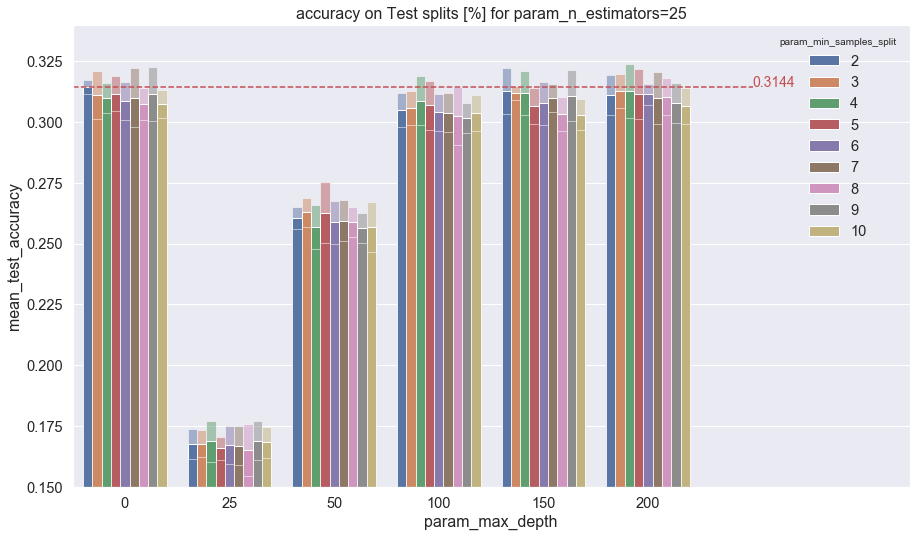

In [383]:
plot_res_test_split(df_res_rf_multi_cv, "accuracy", "param_max_depth", 
                    "param_min_samples_split",
                    y_min=0.15, 
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

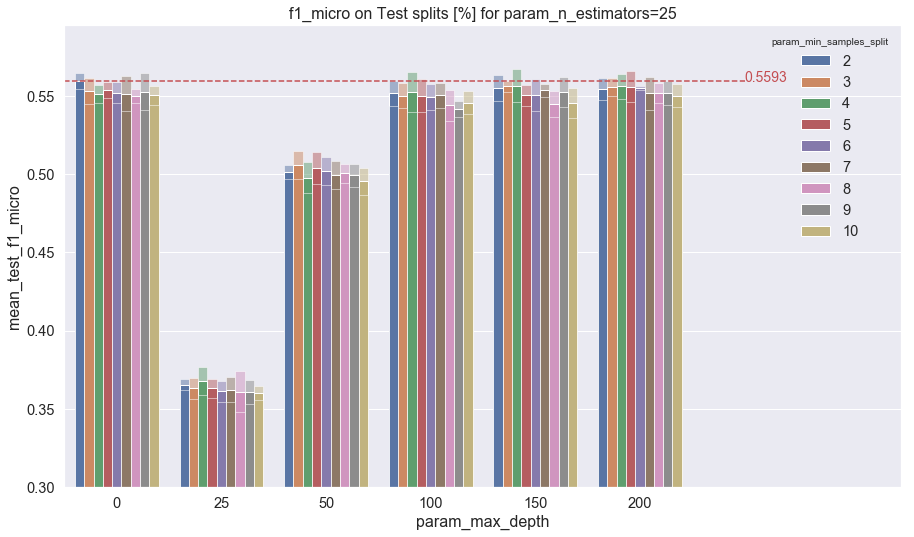

In [384]:
plot_res_test_split(df_res_rf_multi_cv, "f1_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.3,
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

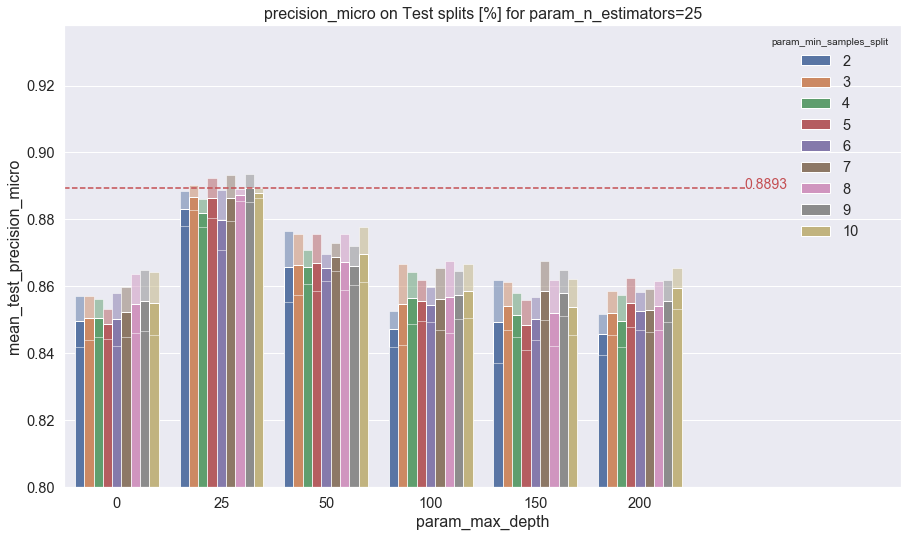

In [385]:
plot_res_test_split(df_res_rf_multi_cv, "precision_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.8,
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

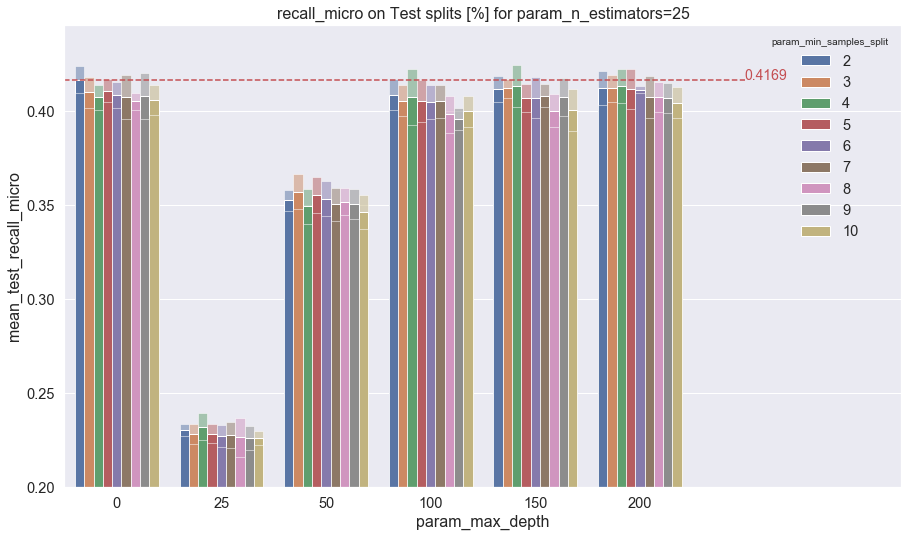

In [386]:
plot_res_test_split(df_res_rf_multi_cv, "recall_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.2,
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

##### For n_estimators = 50

In [387]:
str_path = PATH_EXPORT_FOLDER + \
    'df_res_RF_tags51_max_depth150_max_features31_min_samples_split4_n_estimators50.csv'
df_res_rf_multi_cv_2 = pd.read_csv(str_path, sep=',')
#df_res_rf_multi_cv_2.loc[df_res_rf_multi_cv_2["param_max_depth"].isna(),
#                         "param_max_depth"] = 0
df_res_rf_multi_cv_2.sort_values(by="rank_test_f1_micro").T

38  \
Unnamed: 0                                                                   38   
mean_fit_time                                                           9.26193   
std_fit_time                                                          0.0689236   
mean_score_time                                                         2.55738   
std_score_time                                                        0.0424367   
param_max_depth                                                             150   
param_max_features                                                           31   
param_min_samples_split                                                       4   
param_n_estimators                                                           50   
params                        {'max_depth': 150, 'max_features': 31, 'min_sa...   
split0_test_accuracy                                                   0.305566   
split1_test_accuracy                                                   0.320537   
split2_test_accuracy                                                   0.310173   
mean_test_accuracy                                                     0.312092   
std_test_accuracy                                                    0.00626085   
rank_test_accuracy                                                            1   
split0_train_accuracy                                                  0.843555   
split1_train_accuracy                                                  0.845571   
split2_train_accuracy                                                   0.84797   
mean_train_accuracy                                                    0.845699   
std_train_accuracy                                                   0.00180469   
split0_test_f1_micro                                                   0.545675   
split1_test_f1_micro                                                   0.563151   
split2_test_f1_micro                                                   0.557089   
mean_test_f1_micro                                                     0.555305   
std_test_f1_micro                                                    0.00724515   
rank_test_f1_micro                                                            1   
split0_train_f1_micro                                                   0.93773   
split1_train_f1_micro                                                  0.939308   
split2_train_f1_micro                                                  0.939819   
mean_train_f1_micro                                                    0.938952   
std_train_f1_micro                                                  0.000888794   
split0_test_precision_micro                                            0.864583   
split1_test_precision_micro                                            0.866987   
split2_test_precision_micro                                            0.850448   
mean_test_precision_micro                                              0.860673   
std_test_precision_micro                                             0.00729654   
rank_test_precision_micro                                                    37   
split0_train_precision_micro                                           0.999272   
split1_train_precision_micro                                           0.999133   
split2_train_precision_micro                                           0.999134   
mean_train_precision_micro                                              0.99918   
std_train_precision_micro                                           6.53892e-05   
split0_test_recall_micro                                               0.398635   
split1_test_recall_micro                                               0.417009   
split2_test_recall_micro                                               0.414209   
mean_test_recall_micro                                                 0.409951   
std_test_recall_micro                                                 0.0080829   
rank_test_

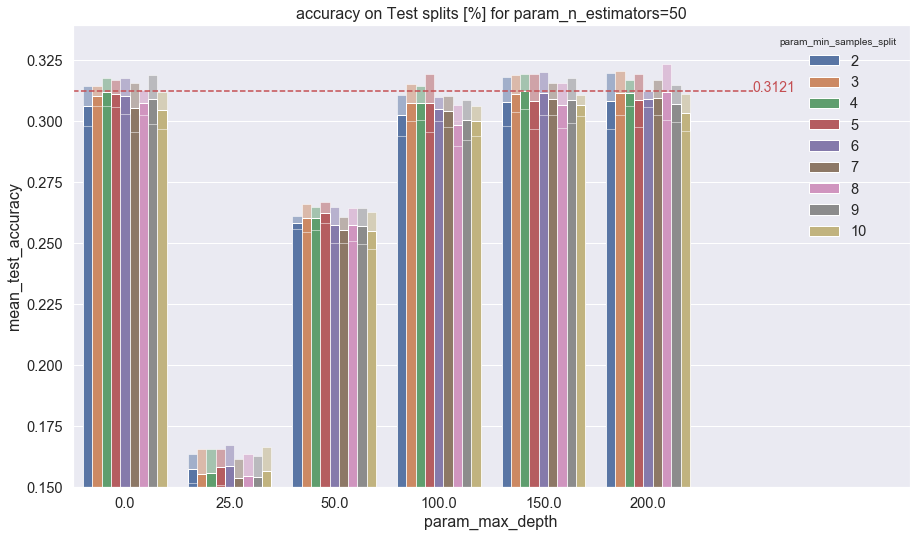

In [388]:
plot_res_test_split(df_res_rf_multi_cv_2, "accuracy", "param_max_depth", 
                    "param_min_samples_split",
                    y_min=0.15, 
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

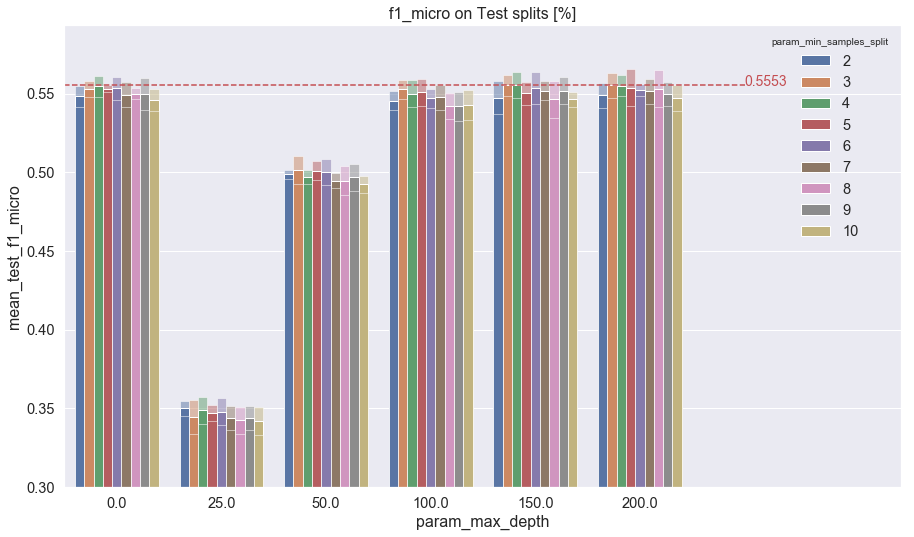

In [389]:
plot_res_test_split(df_res_rf_multi_cv_2, "f1_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.3)

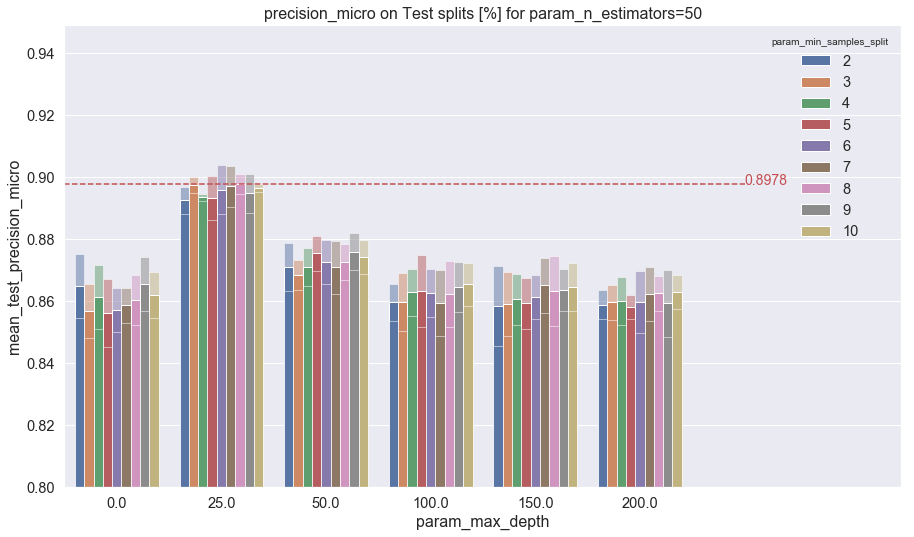

In [390]:
plot_res_test_split(df_res_rf_multi_cv_2, "precision_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.8,
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

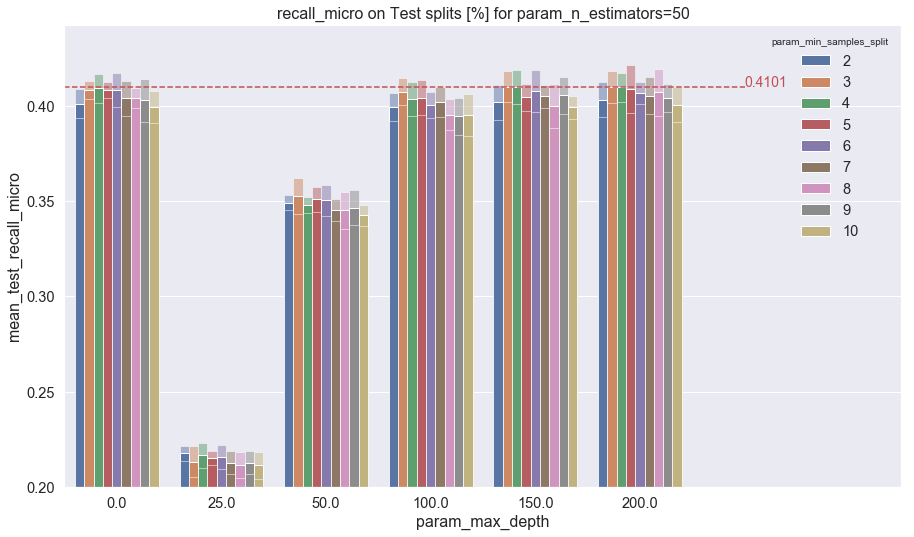

In [391]:
plot_res_test_split(df_res_rf_multi_cv_2, "recall_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.2,
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

##### Final comparison

In [392]:
df_res_rf_multi_cv_all = df_res_rf_multi_cv.append(df_res_rf_multi_cv_2)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [393]:
df_res_rf_multi_cv.shape

(54, 53)

In [394]:
df_res_rf_multi_cv_2.shape

(54, 54)

In [395]:
df_res_rf_multi_cv_all.shape

(108, 54)

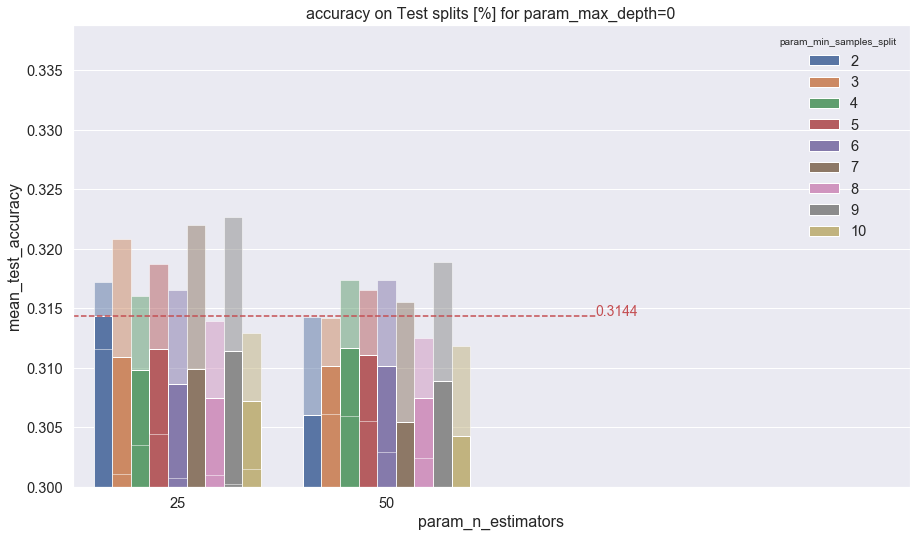

In [396]:
plot_res_test_split(df_res_rf_multi_cv_all, "accuracy", "param_n_estimators", 
                    "param_min_samples_split", y_min=0.3,
                    myFixedParam="param_max_depth",
                    myFixedValue=0)

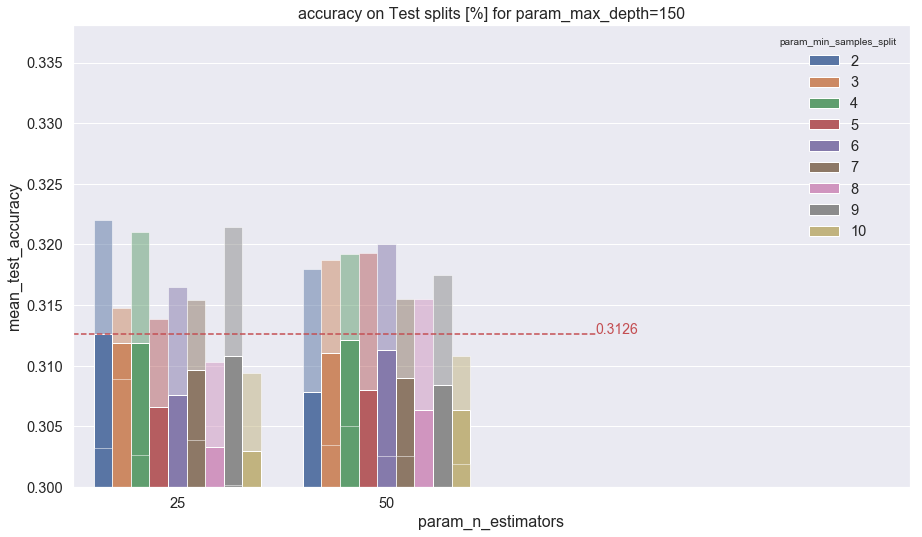

In [397]:
plot_res_test_split(df_res_rf_multi_cv_all, "accuracy", "param_n_estimators", 
                    "param_min_samples_split", y_min=0.3,
                    myFixedParam="param_max_depth",
                    myFixedValue=150)

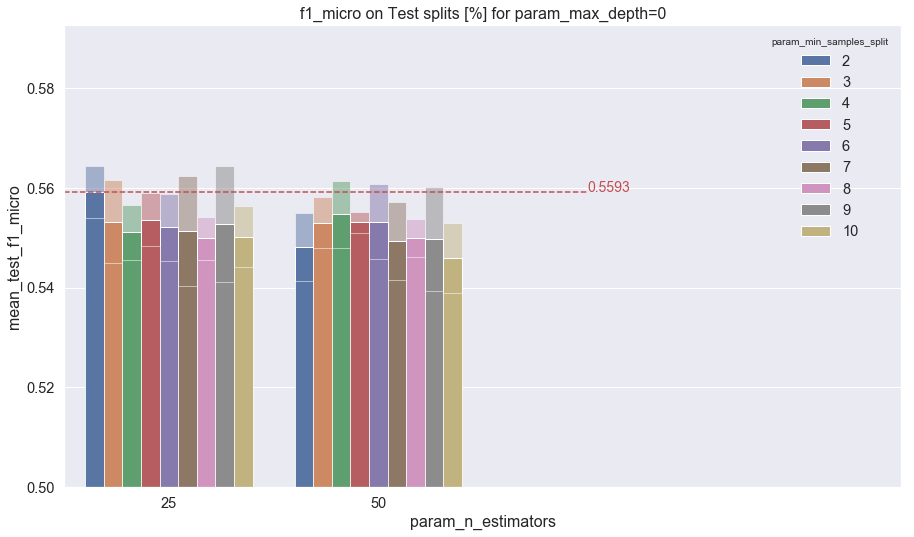

In [398]:
plot_res_test_split(df_res_rf_multi_cv_all, "f1_micro", "param_n_estimators", 
                    "param_min_samples_split", y_min=0.5,
                    myFixedParam="param_max_depth",
                    myFixedValue=0)

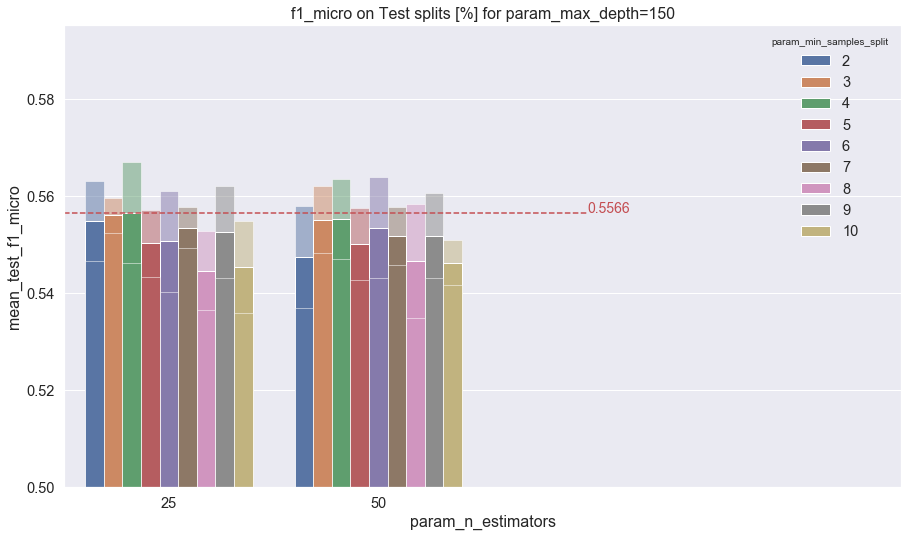

In [399]:
plot_res_test_split(df_res_rf_multi_cv_all, "f1_micro", "param_n_estimators", 
                    "param_min_samples_split", y_min=0.5,
                    myFixedParam="param_max_depth",
                    myFixedValue=150)

##### Best model
Best F1 & Accuracy for Splits Test

- n_estimators: 25
- min_samples_split: 2
- max_depth: None


In [400]:
g_clf_rf_multi_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=31, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Evaluation

In [401]:
accuracy_score(encoded_y_train, predicted_train)

0.9799600737100738

In [402]:
accuracy_score(encoded_y_test, predicted_test)

0.3172141119221411

In [403]:
precision_score(encoded_y_train, predicted_train, average='micro')

0.9994799521555983

In [404]:
precision_score(encoded_y_test, predicted_test, average='micro')

0.8267526188557615

In [405]:
recall_score(encoded_y_train, predicted_train, average='micro')

0.9853876127973749

In [406]:
recall_score(encoded_y_test, predicted_test, average='micro')

0.4186046511627907

In [407]:
f1_score(encoded_y_train, predicted_train, average='micro')

0.9923837554540056

In [408]:
f1_score(encoded_y_test, predicted_test, average='micro')

0.5557963163596966

##### Get the list of list predicted

In [409]:
list_tuple_ypred_train = mlb.inverse_transform(predicted_train)
list_tuple_ypred_test = mlb.inverse_transform(predicted_test)

In [410]:
len(list_tuple_ypred_train)

13024

In [411]:
predicted_train.shape

(13024, 51)

In [412]:
len(list_tuple_ypred_test)

3288

In [413]:
predicted_test.shape

(3288, 51)

##### Re-encode y pred lists

In [414]:
enc_sup_ypred_train = mlb_lda.transform(list_tuple_ypred_train)
enc_sup_ypred_test = mlb_lda.transform(list_tuple_ypred_test)

##### Create DafaFrames Train and Test using encoded y pred data using index of big dataFrame

Same index reference : 
    df_quest_cleaned.INDEX -> 2 encoded data y pred Dataframes.INDEX


In [415]:
enc_sup_ypred_train.shape

(13024, 8765)

In [416]:
df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(13024, 40)

In [417]:
df_enc_sup_ypred_train = pd.DataFrame(data=enc_sup_ypred_train,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_train.shape)

(13024, 8765)


In [418]:
enc_sup_ypred_test.shape

(3288, 8765)

In [419]:
df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(3288, 40)

In [420]:
df_enc_sup_ypred_test = pd.DataFrame(data=enc_sup_ypred_test,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_test.shape)

(3288, 8765)


##### Extract only flag most used & Train columns 

In [421]:
df_test = df_quest_cleaned.filter(items=[col_flag, "Train"])
print(df_test.shape)

(21208, 2)


##### Add y pred Train encoded data

In [422]:
df_test2 = df_test.join(df_enc_sup_ypred_train)
print(df_test2.shape)

(21208, 8767)


##### Add y pred Test data

In [423]:
df_test2.update(df_enc_sup_ypred_test)
print(df_test2.shape)

(21208, 8767)


##### Assign no Tags to samples/rows without most used tags

In [424]:
df_test2.isnull().sum().sum()

42913440

In [425]:
df_test2[df_test2.isna()] = 0

In [426]:
df_test2.isnull().sum().sum()

0

In [427]:
df_test2[df_test2[0].isna()].shape[0]

0

##### Extract encoded binarized array for y pred Train & Test to be evaluated

In [428]:
enc_sup_all_ypred_train = df_test2.loc[df_quest_cleaned["Train"] == True,
             range(0, enc_sup_ypred_train.shape[1])].values
enc_sup_all_ypred_train.shape

(16966, 8765)

In [429]:
enc_lda_y_train.shape

(16966, 8765)

In [430]:
enc_sup_all_ypred_test = df_test2.loc[df_quest_cleaned["Train"] == False,
             range(0, enc_sup_ypred_test.shape[1])].values
enc_sup_all_ypred_test.shape

(4242, 8765)

In [431]:
enc_lda_y_test.shape

(4242, 8765)

##### Evaluate on all data

In [432]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_sup_all_ypred_train,
                          enc_lda_y_test, enc_sup_all_ypred_test, 
                          t_1-t_0, t_pred_1-t_pred_0)

Nb. no Tags samples : 4048 over 16966 rows [23.86%]
Nb. no Tags samples : 2157 over 4242 rows [50.85%]


In [433]:
df_results = add_score(df_results, series_scores, 
          "RF_tags{}".format(int(nb_most_used_tags)))
df_results

add line


f1_splits_test  f1_splits_test_std  acc_train  acc_test  \
LDA_top50_tags10         0.141678            0.000771   0.000000  0.000000   
LDA_top50_tags1          0.139635            0.000250   0.016975  0.017445   
LDA_top50_tags2          0.162595            0.000955   0.006955  0.006129   
LDA_top50_tags3          0.171949            0.001617   0.002476  0.002357   
LDA_top50_tags4          0.173857            0.001200   0.000648  0.000236   
LDA_top50_tags5          0.172366            0.001016   0.000000  0.000000   
LDA_top50_tags6          0.165265            0.000587   0.000000  0.000000   
LDA_top25_tags10         0.136579            0.000297   0.000000  0.000000   
LDA_top25_tags1          0.137544            0.001813   0.015325  0.015559   
LDA_top25_tags2          0.161006            0.001770   0.006012  0.006129   
LDA_top25_tags3          0.169592            0.000736   0.002240  0.002593   
LDA_top25_tags4          0.168388            0.000125   0.000589  0.000471   
LDA_top25_tags5          0.164371            0.000361   0.000000  0.000000   
LDA_top25_tags6          0.157607            0.000213   0.000000  0.000000   
LDA_top100_tags10        0.144906            0.000992   0.000000  0.000000   
LDA_top100_tags1         0.144714            0.000586   0.017623  0.017209   
LDA_top100_tags2         0.169057            0.001304   0.007721  0.008722   
LDA_top100_tags3         0.176685            0.000645   0.002358  0.002593   
LDA_top100_tags4         0.178590            0.000106   0.000648  0.000236   
LDA_top100_tags5         0.174328            0.000957   0.000000  0.000000   
LDA_top100_tags6         0.168984            0.000282   0.000000  0.000000   
LDA_top200_tags10        0.145331            0.000695   0.000000  0.000000   
LDA_top200_tags1         0.143983            0.001266   0.018095  0.016502   
LDA_top200_tags2         0.166805            0.001331   0.008605  0.007779   
LDA_top200_tags3         0.173227            0.001203   0.002299  0.002122   
LDA_top200_tags4         0.176421            0.000314   0.000766  0.000471   
LDA_top200_tags5         0.172762            0.000399   0.000000  0.000000   
LDA_top200_tags6         0.167051            0.000280   0.000000  0.000000   
RF_tags51                0.555416            0.001766   0.142344  0.044319   

                   pre_train  pre_test  rec_train  rec_test  f1_train  \
LDA_top50_tags10    0.091595  0.089321   0.310732  0.301648  0.141484   
LDA_top50_tags1     0.278793  0.273692   0.094579  0.092429  0.141243   
LDA_top50_tags2     0.201963  0.189769   0.137030  0.128175  0.163277   
LDA_top50_tags3     0.170419  0.161245   0.173442  0.163363  0.171917   
LDA_top50_tags4     0.150802  0.144743   0.204635  0.195526  0.173642   
LDA_top50_tags5     0.136261  0.133145   0.231129  0.224823  0.171446   
LDA_top50_tags6     0.123364  0.121326   0.251105  0.245840  0.165447   
LDA_top25_tags10    0.088023  0.085950   0.298614  0.290264  0.135967   
LDA_top25_tags1     0.275551  0.269213   0.093479  0.090916  0.139600   
LDA_top25_tags2     0.200961  0.196605   0.136350  0.132792  0.162467   
LDA_top25_tags3     0.168160  0.159987   0.171142  0.162089  0.169638   
LDA_top25_tags4     0.145733  0.139026   0.197756  0.187804  0.167805   
LDA_top25_tags5     0.130013  0.124422   0.220531  0.210095  0.163585   
LDA_top25_tags6     0.116989  0.113272   0.238128  0.229520  0.156897   
LDA_top100_tags10   0.093758  0.090806   0.318070  0.306663  0.144826   
LDA_top100_tags1    0.289579  0.279114   0.098238  0.094260  0.146707   
LDA_top100_tags2    0.209772  0.202381   0.142329  0.136693  0.169591   
LDA_top100_tags3    0.174918  0.166667   0.178021  0.168856  0.176456   
LDA_top100_tags4    0.154235  0.149104   0.209294  0.201417  0.177595   
LDA_top100_tags5    0.138112  0.135031   0.234268  0.228007  0.173775   
LDA_top100_tags6    0.125761  0.122819   0.255984  0.248866  0.168662   
LDA_top200_tags10   0.093911  0.091938   0.318590  0.310485  0.145062   

##### Save

In [707]:
path_save = PATH_EXPORT_FOLDER + "df_results.csv"
df_results.to_csv(path_or_buf=path_save, sep=',')
print("All Results Saved here:\n{}".format(path_save))

All Results Saved here:
../../data/df_results.csv


###  RandomForest Multi-Tags : 73 Most Used Tags

#### Choose Most Used Tags

In [437]:
idx_most = 1

In [438]:
list_tags_most_used = list_list_most_used[idx_most]
col_flag = "flag_most_Tagged_{:.0f}".format(df_most.iloc[idx_most]["nb_min_used"])
print(col_flag)
nb_most_used_tags = df_most.iloc[idx_most]["nb_most_used_tags"]
len(list_tags_most_used)

flag_most_Tagged_100


73

#### Multi-label encoding

##### For output to predict, extract only most used Tags

In [439]:
# create list of list of Tags to be able to encode multi label outputs
print('\nFor train set...')  
list_list_tags_train = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == True) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_train[:10])

print('\nFor test set...')  
list_list_tags_test = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_test[:10])


For train set...
[['c#', 'sql', 'sql-server'], ['sql-server'], ['javascript', 'php', 'ajax'], ['android'], ['sql'], ['php', 'laravel'], ['python'], ['java'], ['javascript', 'json', 'reactjs'], ['android']]

For test set...
[['ios'], ['ios', 'swift'], ['c++'], ['excel', 'vba', 'excel-vba'], ['android'], ['sql-server'], ['c#', 'asp.net'], ['javascript', 'reactjs'], ['python', 'django'], ['javascript', 'angular', 'typescript']]


##### Encoding output to predict

In [440]:
#y = [['tag3','tag1'],['tag1','tag0','tag2']]
mlb = MultiLabelBinarizer()
encoded_y_train = mlb.fit_transform(list_list_tags_train)
encoded_y_test = mlb.transform(list_list_tags_test)

In [441]:
encoded_y_train.shape

(13710, 73)

In [442]:
encoded_y_test.shape

(3443, 73)

##### Check if enough sample for each most used Tags (important for Training) :

In [443]:
#for idx in range(0, encoded_y_train.shape[1]):
print('For less used tag:')
print("- For train: ")
nb_used_tags_train = np.sum(encoded_y_train, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_train))
print("\n- For test : ")
nb_used_tags_test = np.sum(encoded_y_test, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_test))

For less used tag:
- For train: 
  - Number of use:  82

- For test : 
  - Number of use:  18


In [444]:
# for idx in range(0, encoded_y_train.shape[1]):
print('For each sample:')
print("- For train: ")
nb_tags_per_sample_train = np.sum(encoded_y_train, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_train))
print("\n- For test : ")
nb_tags_per_sample_test = np.sum(encoded_y_test, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_test))

For each sample:
- For train: 
  - Minimum Number of Tags:  1

- For test : 
  - Minimum Number of Tags:  1


In [445]:
find_nb_no_tags(encoded_y_train)
find_nb_no_tags(encoded_y_test)

Nb. no Tags samples : 0 over 13710 rows [0.00%]
Nb. no Tags samples : 0 over 3443 rows [0.00%]


0

#### Distribution of Tags

(0, 1000)

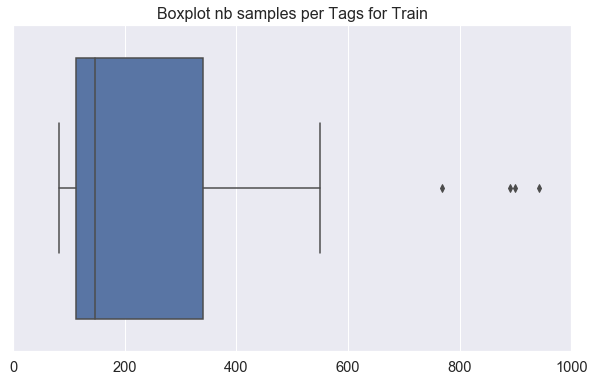

In [446]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb samples per Tags for Train")
ax = sns.boxplot(encoded_y_train.sum(axis=0))
ax.set_xlim([0,1000])

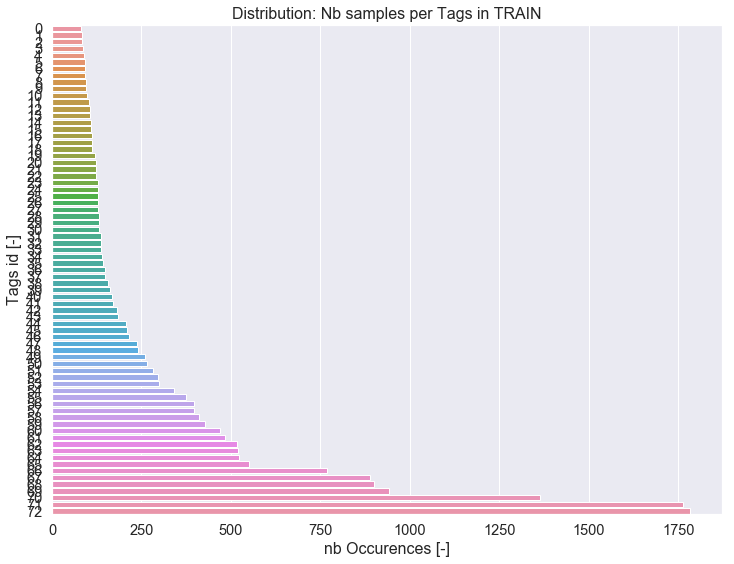

In [447]:
fig = plt.figure(figsize=(12, 9))
plt.title("Distribution: Nb samples per Tags in TRAIN")
df_count = pd.DataFrame(data=encoded_y_train.sum(axis=0), 
                        columns=['nb_samples'])
ax = sns.barplot(y=df_count.index, x=sorted(df_count["nb_samples"]), orient='h')
#ax.set_xlim(right=90)
#ax.set_ylim([0, 20])
ax.set_xlabel("nb Occurences [-]")
ax.set_ylabel("Tags id [-]");

In [448]:
print("Table of Tag id with min used of Tags")
df_count[df_count["nb_samples"] < df_most.iloc[idx_most]["nb_min_used"]]

Table of Tag id with min used of Tags


nb_samples
4           89
6           92
25          85
28          93
34          83
37          97
54          92
57          88
67          82
70          95
71          96

Text(0, 0.5, 'nb [-]')

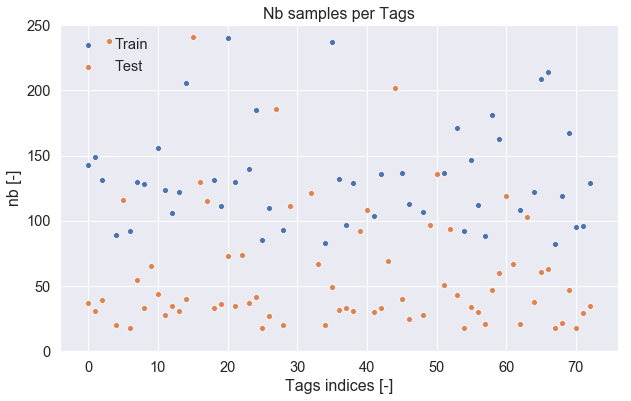

In [449]:
fig = plt.figure(figsize=(10, 6))
plt.title("Nb samples per Tags")
ax = sns.scatterplot(data=encoded_y_train.sum(axis=0), label='Train')
ax1 = sns.scatterplot(data=encoded_y_test.sum(axis=0), label='Test')
#ax1.set_xlim([0,250])
ax.set_xlabel('Tags indices [-]')
ax1.set_ylim([0,250])
ax.set_ylabel('nb [-]')

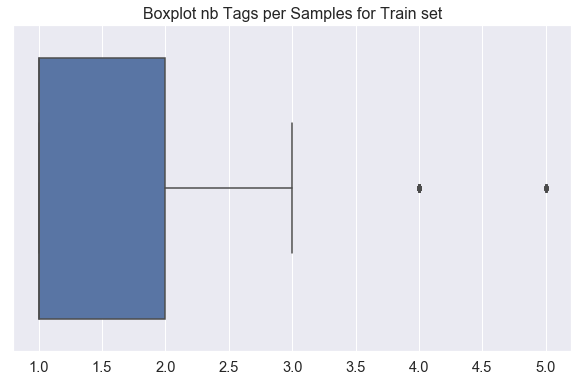

In [450]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Train set")
ax = sns.boxplot(encoded_y_train.sum(axis=1))
#ax.set_xlim([0,250])

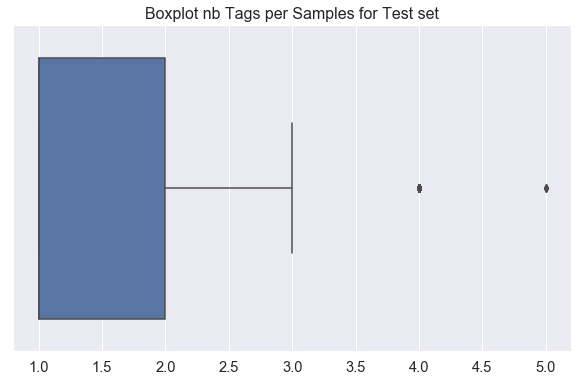

In [451]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Test set")
ax = sns.boxplot(encoded_y_test.sum(axis=1))

#### Features preparation

In [452]:
# train counts
tf_1 = tf_vectorizer_sup_1.\
    fit_transform(df_quest_cleaned[(df_quest_cleaned.Train== True) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_train_counts_sup_1 = tf_1
X_train_counts_sup_1.shape

(13710, 1000)

In [453]:
# test counts
X_test_counts_sup_1 = tf_vectorizer_sup_1.transform(
    df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_test_counts_sup_1.shape

(3443, 1000)

In [454]:
# calculate tf-idf
tfidf_transformer_sup_1 = TfidfTransformer().fit(X_train_counts_sup_1)

In [455]:
# train
X_train_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_train_counts_sup_1)
X_train_tfidf_sup_1.shape

(13710, 1000)

In [456]:
# test
X_test_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_test_counts_sup_1)
X_test_tfidf_sup_1.shape

(3443, 1000)

#### Optim

In [457]:
clf_rf_multi_cv = RandomForestClassifier(random_state=0, n_jobs=-1)

In [458]:
# Fixer les valeurs des hyperparamètres à tester
# 5th try OVR
# {'estimator__n_estimators': [25], 'estimator__max_features': [155]} 0.192585
# Train Score : 0.961302784068203
# Test Score :  0.20671283963771978
# Nb. no Tags samples : 232 over 15014 rows [1.55%]
# Nb. no Tags samples : 1158 over 3754 rows [30.85%]

# 1st try {'n_estimators': [10, 20, 30], 'max_features': [24, 31, 37]}
# - best : {'max_features': 37, 'n_estimators': 30}
#   Train Score : 0.9697780908770693
#   Test Score :  0.24260355029585798
#   Nb. no Tags samples : 173 over 14195 rows [1.22%]
#   Nb. no Tags samples : 1486 over 3549 rows [41.87%] 

#2nd Try : {'n_estimators': [30, 40], 'max_features': [37, 43, 49]}
#{'max_features': 49, 'n_estimators': 40}
#Train Score : 0.9844311377245509
#Test Score :  0.25725556494787266
#Nb. no Tags samples : 87 over 14195 rows [0.61%]
#Nb. no Tags samples : 1342 over 3549 rows [37.81%]

#{'n_estimators': [50, 60], 'max_features': [55, 62, 68]}
#{'max_features': 68, 'n_estimators': 60}
#Train Score : 0.994082423388517
#Test Score :  0.2702169625246548
#Nb. no Tags samples : 27 over 14195 rows [0.19%]
#Nb. no Tags samples : 1223 over 3549 rows [34.46%]

#{'n_estimators': [60, 70], 'max_features': [68, 93, 124]} 0.266408
#{'max_features': 124, 'n_estimators': 70}
#Train Score : 0.994082423388517
#Test Score :  0.2702169625246548
#Nb. no Tags samples : 27 over 14195 rows [0.19%]
#Nb. no Tags samples : 1223 over 3549 rows [34.46%]

#{'n_estimators': [80], 'max_features': [124, 155, 186]}    
# {'max_features': 186, 'n_estimators': 80}
#Train Score : 0.9970412116942585
#Test Score :  0.2879684418145957
#Nb. no Tags samples : 13 over 14195 rows [0.09%]
#Nb. no Tags samples : 1008 over 3549 rows [28.40%]

'''#{'max_features': 31, 'min_samples_split': 3, 'n_estimators': 50}
max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))
n_estimators_range = [50]
max_features_range = [max_features_ideal]
min_samples_split_range = [3]
score = 'f1_micro'
# grille de paramètres
param_grid = {'n_estimators': n_estimators_range, 
              'max_features': max_features_range,
             'min_samples_split': min_samples_split_range}
param_grid'''


max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))
n_estimators_range = [25, 50]
max_depth_range = [None, 25, 50, 100, 150, 200]
max_features_range = [max_features_ideal]
min_samples_split_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]

score = ['accuracy', 'f1_micro', 'precision_micro', 'recall_micro']

param_grid = {'n_estimators': n_estimators_range, 
              'max_features': max_features_range,
             'min_samples_split': min_samples_split_range,
             'max_depth': max_depth_range}
param_grid

{'n_estimators': [25, 50],
 'max_features': [31],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'max_depth': [None, 25, 50, 100, 150, 200]}

In [459]:
# Créer  avec recherche d'hyperparamètre par validation croisée
g_clf_rf_multi_cv = model_selection.GridSearchCV(clf_rf_multi_cv,
param_grid, # hyperparamètres à tester
cv=cv,# nombre de folds de validation croisée
scoring=score, refit="f1_micro") # score à optimiser
# Optimiser ce classifieur sur le jeu d'entraînement
t_0 = time.time()
g_clf_rf_multi_cv.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_clf_rf_multi_cv.best_params_)

timing total: 6896.686184167862 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': None, 'max_features': 31, 'min_samples_split': 3, 'n_estimators': 50}


In [460]:
df_res_rf_multi_cv = pd.DataFrame(data=g_clf_rf_multi_cv.cv_results_)
df_res_rf_multi_cv.sort_values(by="rank_test_f1_micro").T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/depre

3   \
mean_fit_time                                                           14.0448   
std_fit_time                                                           0.187359   
mean_score_time                                                         3.86044   
std_score_time                                                        0.0133753   
param_max_depth                                                            None   
param_max_features                                                           31   
param_min_samples_split                                                       3   
param_n_estimators                                                           50   
params                        {'max_depth': None, 'max_features': 31, 'min_s...   
split0_test_accuracy                                                   0.282276   
split1_test_accuracy                                                   0.268417   
split2_test_accuracy                                                     0.2531   
mean_test_accuracy                                                     0.267931   
std_test_accuracy                                                     0.0119159   
rank_test_accuracy                                                            6   
split0_train_accuracy                                                  0.946389   
split1_train_accuracy                                                  0.944292   
split2_train_accuracy                                                  0.943654   
mean_train_accuracy                                                    0.944779   
std_train_accuracy                                                   0.00116839   
split0_test_f1_micro                                                   0.517415   
split1_test_f1_micro                                                   0.520552   
split2_test_f1_micro                                                   0.508853   
mean_test_f1_micro                                                     0.515607   
std_test_f1_micro                                                    0.00494431   
rank_test_f1_micro                                                            1   
split0_train_f1_micro                                                  0.980994   
split1_train_f1_micro                                                  0.979982   
split2_train_f1_micro                                                  0.980018   
mean_train_f1_micro                                                    0.980332   
std_train_f1_micro                                                  0.000468727   
split0_test_precision_micro                                             0.85722   
split1_test_precision_micro                                            0.846233   
split2_test_precision_micro                                            0.856606   
mean_test_precision_micro                                              0.853353   
std_test_precision_micro                                             0.00504057   
rank_test_precision_micro                                                    66   
split0_train_precision_micro                                           0.999881   
split1_train_precision_micro                                           0.999581   
split2_train_precision_micro                                             0.9997   
mean_train_precision_micro                                              0.99972   
std_train_precision_micro                                           0.000123313   
split0_test_recall_micro                                                0.37062   
split1_test_recall_micro                                               0.375888   
split2_test_recall_micro                                               0.361924   
mean_test_recall_micro                                                 0.369477   
std_test_recall_micro                                                0.00575769   
rank_test_recall_micro                                                        1   
split0_tra

In [461]:
g_clf_rf_multi_cv.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 31,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

##### Save

In [462]:
save_gridsearchcv_sup(g_clf_rf_multi_cv, df_res_rf_multi_cv,"RF")

max_depth
None
max_features
31
min_samples_split
3
n_estimators
50
Results Saved here:
../../data/df_res_RF_tags73_max_depthNone_max_features31_min_samples_split3_n_estimators50.csv
Model Saved here:
../../data/model_RF_tags73_max_depthNone_max_features31_min_samples_split3_n_estimators50.pkl


##### Eval best estimator :

In [463]:
print("Train Score :", 
      g_clf_rf_multi_cv.best_estimator_.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      g_clf_rf_multi_cv.best_estimator_.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.9480671043034281
Test Score :  0.25907638687191403


In [464]:
predicted_train = g_clf_rf_multi_cv.best_estimator_.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
t_pred_0 = time.time()
predicted_test = g_clf_rf_multi_cv.best_estimator_.predict(X_test_tfidf_sup_1)
t_pred_1 = time.time()
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.0007743572834547326
Test hamming loss : 0.015421402965715626


In [465]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 299 over 13710 rows [2.18%]
Nb. no Tags samples : 1411 over 3443 rows [40.98%]


1411

#### Compare

##### For n_estimators = 25

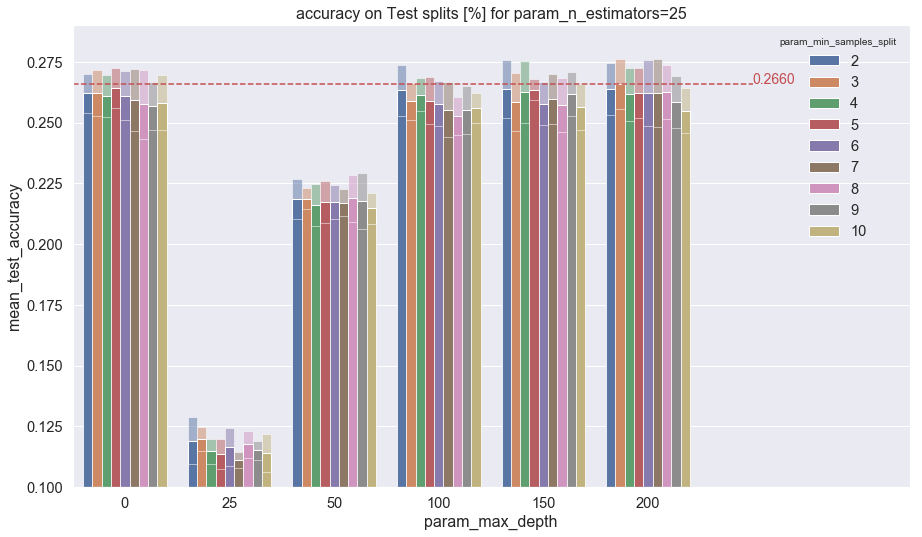

In [466]:
plot_res_test_split(df_res_rf_multi_cv, "accuracy", "param_max_depth", 
                    "param_min_samples_split",
                    y_min=0.1, 
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

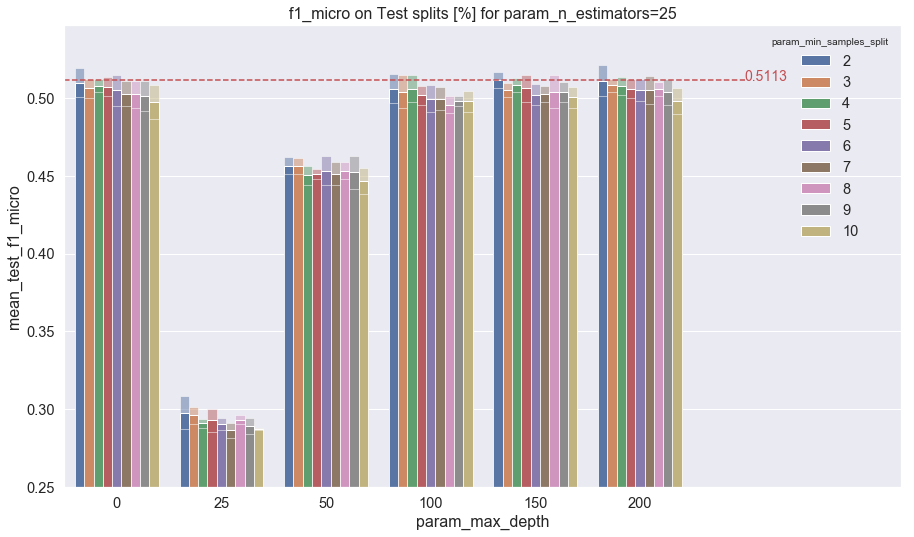

In [467]:
plot_res_test_split(df_res_rf_multi_cv, "f1_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.25,
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

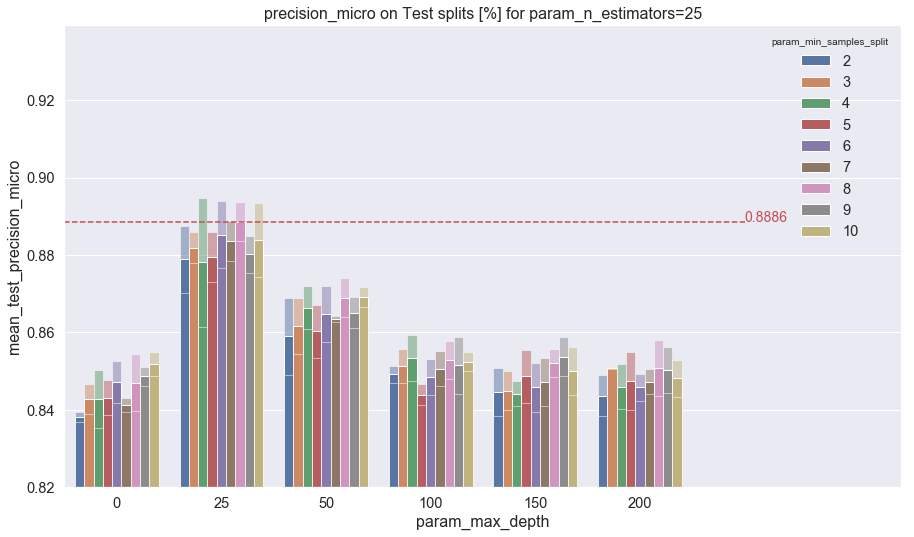

In [468]:
plot_res_test_split(df_res_rf_multi_cv, "precision_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.82,
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

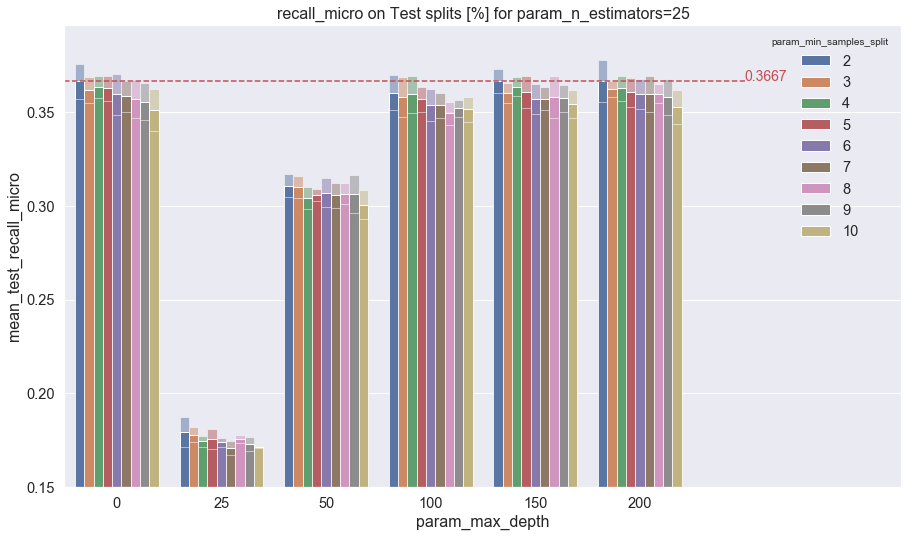

In [469]:
plot_res_test_split(df_res_rf_multi_cv, "recall_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.15,
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

##### For n_estimators = 50

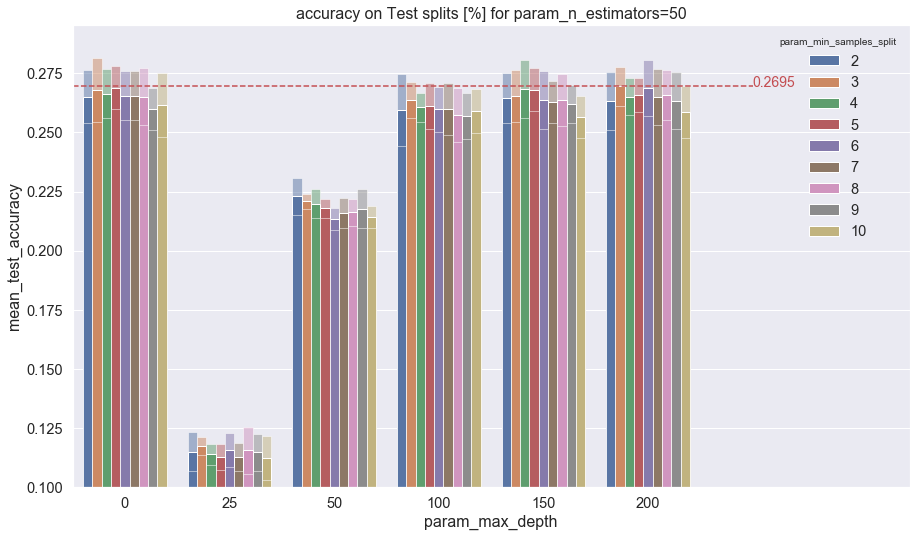

In [470]:
plot_res_test_split(df_res_rf_multi_cv, "accuracy", "param_max_depth", 
                    "param_min_samples_split",
                    y_min=0.1, 
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

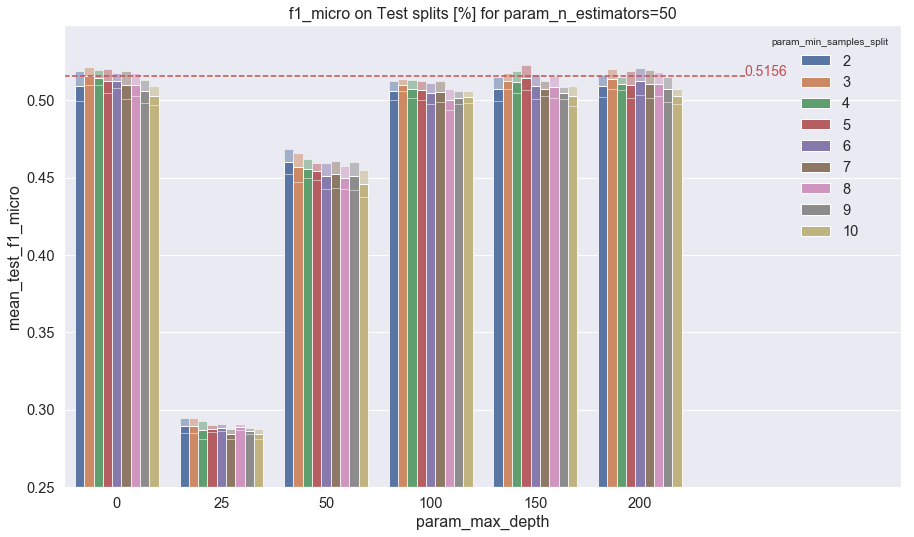

In [471]:
plot_res_test_split(df_res_rf_multi_cv, "f1_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.25,
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

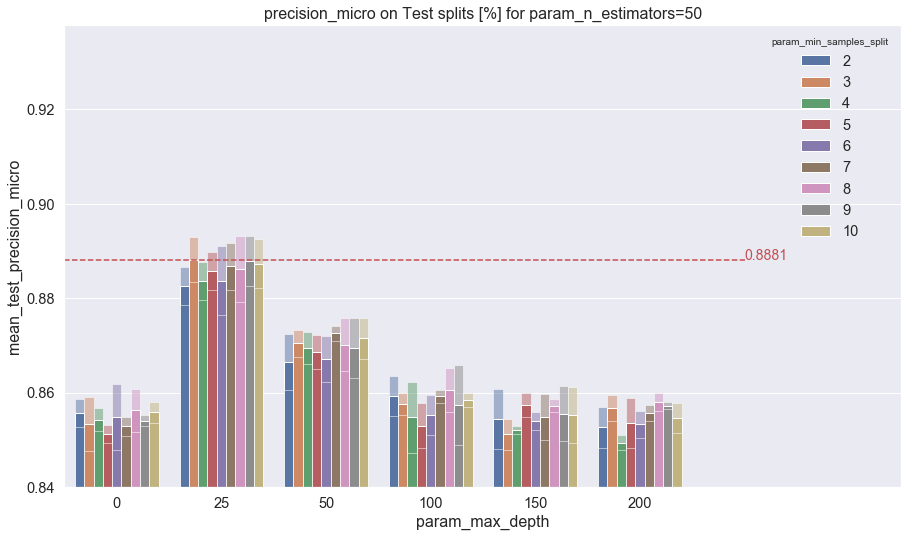

In [472]:
plot_res_test_split(df_res_rf_multi_cv, "precision_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.84,
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

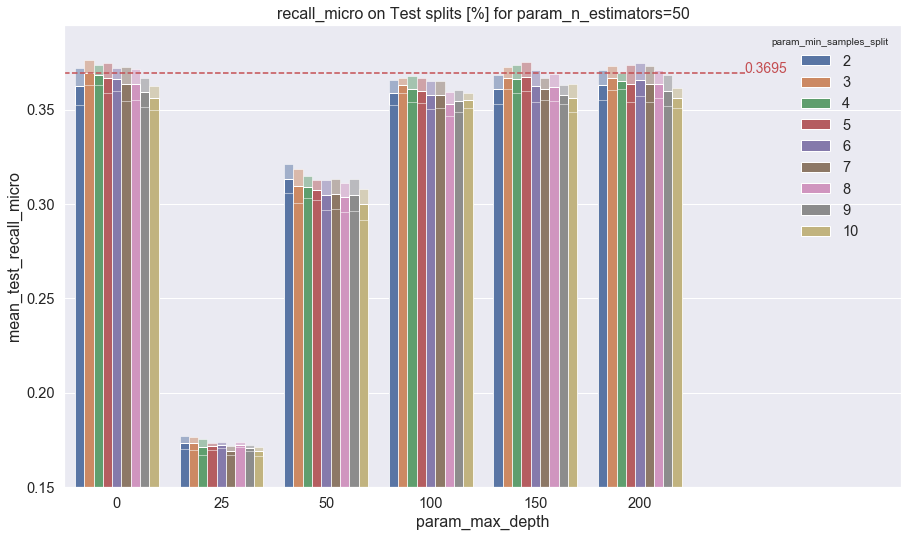

In [473]:
plot_res_test_split(df_res_rf_multi_cv, "recall_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.15,
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

##### Final comparison

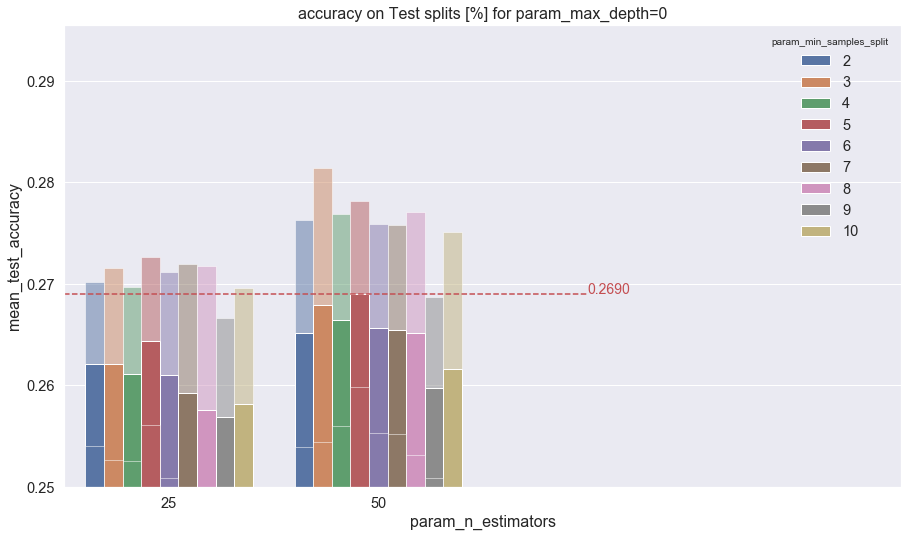

In [474]:
plot_res_test_split(df_res_rf_multi_cv, "accuracy", "param_n_estimators", 
                    "param_min_samples_split", y_min=0.25,
                    myFixedParam="param_max_depth",
                    myFixedValue=0)

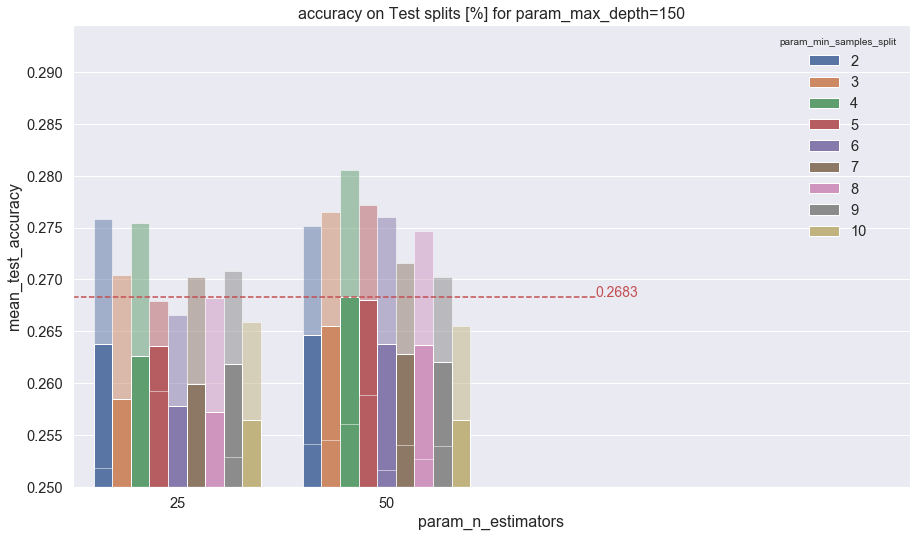

In [475]:
plot_res_test_split(df_res_rf_multi_cv, "accuracy", "param_n_estimators", 
                    "param_min_samples_split", y_min=0.25,
                    myFixedParam="param_max_depth",
                    myFixedValue=150)

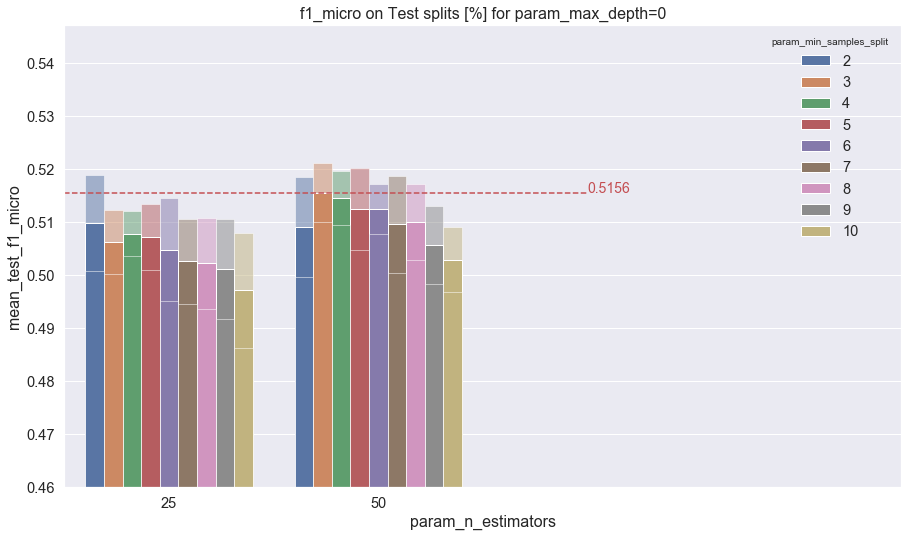

In [476]:
plot_res_test_split(df_res_rf_multi_cv, "f1_micro", "param_n_estimators", 
                    "param_min_samples_split", y_min=0.46,
                    myFixedParam="param_max_depth",
                    myFixedValue=0)

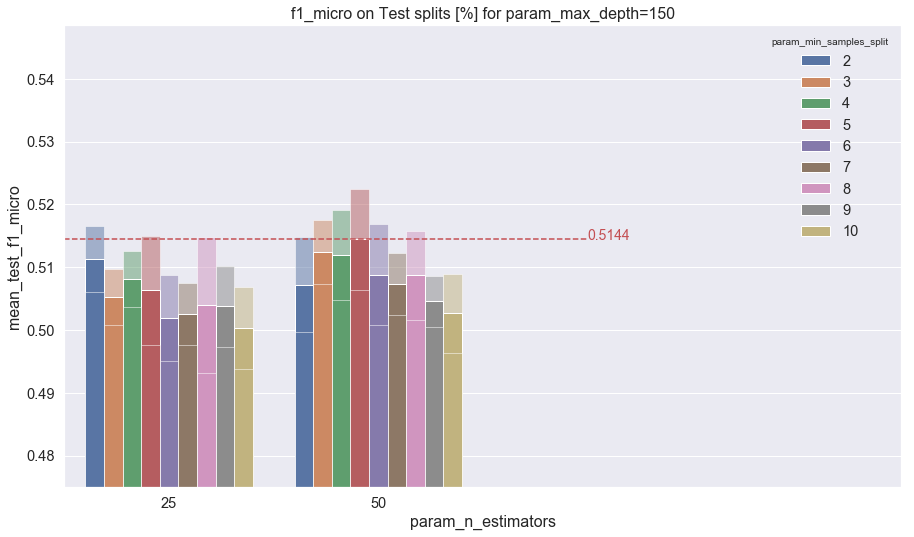

In [477]:
plot_res_test_split(df_res_rf_multi_cv, "f1_micro", "param_n_estimators", 
                    "param_min_samples_split", y_min=0.475,
                    myFixedParam="param_max_depth",
                    myFixedValue=150)

##### Best model
Best F1 score for Splits Test

- n_estimators: 50
- min_samples_split: 3
- max_depth: None


In [478]:
g_clf_rf_multi_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=31, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Evaluation

In [479]:
precision_score(encoded_y_train, predicted_train, average='micro')

0.9997138633220468

In [480]:
precision_score(encoded_y_test, predicted_test, average='micro')

0.8277731442869057

In [481]:
recall_score(encoded_y_train, predicted_train, average='micro')

0.9646143935210749

In [482]:
recall_score(encoded_y_test, predicted_test, average='micro')

0.36435389133627016

In [483]:
f1_score(encoded_y_train, predicted_train, average='micro')

0.9818505421418702

In [484]:
f1_score(encoded_y_test, predicted_test, average='micro')

0.5059903135355595

##### Get the list of list predicted

In [485]:
list_tuple_ypred_train = mlb.inverse_transform(predicted_train)
list_tuple_ypred_test = mlb.inverse_transform(predicted_test)

In [486]:
len(list_tuple_ypred_train)

13710

In [487]:
predicted_train.shape

(13710, 73)

In [488]:
len(list_tuple_ypred_test)

3443

In [489]:
predicted_test.shape

(3443, 73)

##### Re-encode y pred lists

In [490]:
enc_sup_ypred_train = mlb_lda.transform(list_tuple_ypred_train)
enc_sup_ypred_test = mlb_lda.transform(list_tuple_ypred_test)

##### Create DafaFrames Train and Test using encoded y pred data using index of big dataFrame

Same index reference : 
    df_quest_cleaned.INDEX -> 2 encoded data y pred Dataframes.INDEX


In [491]:
enc_sup_ypred_train.shape

(13710, 8765)

In [492]:
df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(13710, 40)

In [493]:
df_enc_sup_ypred_train = pd.DataFrame(data=enc_sup_ypred_train,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_train.shape)

(13710, 8765)


In [494]:
enc_sup_ypred_test.shape

(3443, 8765)

In [495]:
df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(3443, 40)

In [496]:
df_enc_sup_ypred_test = pd.DataFrame(data=enc_sup_ypred_test,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_test.shape)

(3443, 8765)


##### Extract only flag most used & Train columns 

In [497]:
df_test = df_quest_cleaned.filter(items=[col_flag, "Train"])
print(df_test.shape)

(21208, 2)


##### Add y pred Train encoded data

In [498]:
df_test2 = df_test.join(df_enc_sup_ypred_train)
print(df_test2.shape)

(21208, 8767)


##### Add y pred Test data

In [499]:
df_test2.update(df_enc_sup_ypred_test)
print(df_test2.shape)

(21208, 8767)


##### Assign no Tags to samples/rows without most used tags

In [500]:
df_test2.isnull().sum().sum()

35542075

In [501]:
df_test2[df_test2.isna()] = 0

In [502]:
df_test2.isnull().sum().sum()

0

In [503]:
df_test2[df_test2[0].isna()].shape[0]

0

##### Extract encoded binarized array for y pred Train & Test to be evaluated

In [504]:
enc_sup_all_ypred_train = df_test2.loc[df_quest_cleaned["Train"] == True,
             range(0, enc_sup_ypred_train.shape[1])].values
enc_sup_all_ypred_train.shape

(16966, 8765)

In [505]:
enc_lda_y_train.shape

(16966, 8765)

In [506]:
enc_sup_all_ypred_test = df_test2.loc[df_quest_cleaned["Train"] == False,
             range(0, enc_sup_ypred_test.shape[1])].values
enc_sup_all_ypred_test.shape

(4242, 8765)

In [507]:
enc_lda_y_test.shape

(4242, 8765)

##### Evaluate on all data

In [508]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_sup_all_ypred_train,
                          enc_lda_y_test, enc_sup_all_ypred_test, 
                          t_1-t_0, t_pred_1-t_pred_0)

Nb. no Tags samples : 3555 over 16966 rows [20.95%]
Nb. no Tags samples : 2210 over 4242 rows [52.10%]


In [509]:
df_results = add_score(df_results, series_scores, 
          "RF_tags{}".format(int(nb_most_used_tags)))
df_results

add line


f1_splits_test  f1_splits_test_std  acc_train  acc_test  \
LDA_top50_tags10         0.141678            0.000771   0.000000  0.000000   
LDA_top50_tags1          0.139635            0.000250   0.016975  0.017445   
LDA_top50_tags2          0.162595            0.000955   0.006955  0.006129   
LDA_top50_tags3          0.171949            0.001617   0.002476  0.002357   
LDA_top50_tags4          0.173857            0.001200   0.000648  0.000236   
LDA_top50_tags5          0.172366            0.001016   0.000000  0.000000   
LDA_top50_tags6          0.165265            0.000587   0.000000  0.000000   
LDA_top25_tags10         0.136579            0.000297   0.000000  0.000000   
LDA_top25_tags1          0.137544            0.001813   0.015325  0.015559   
LDA_top25_tags2          0.161006            0.001770   0.006012  0.006129   
LDA_top25_tags3          0.169592            0.000736   0.002240  0.002593   
LDA_top25_tags4          0.168388            0.000125   0.000589  0.000471   
LDA_top25_tags5          0.164371            0.000361   0.000000  0.000000   
LDA_top25_tags6          0.157607            0.000213   0.000000  0.000000   
LDA_top100_tags10        0.144906            0.000992   0.000000  0.000000   
LDA_top100_tags1         0.144714            0.000586   0.017623  0.017209   
LDA_top100_tags2         0.169057            0.001304   0.007721  0.008722   
LDA_top100_tags3         0.176685            0.000645   0.002358  0.002593   
LDA_top100_tags4         0.178590            0.000106   0.000648  0.000236   
LDA_top100_tags5         0.174328            0.000957   0.000000  0.000000   
LDA_top100_tags6         0.168984            0.000282   0.000000  0.000000   
LDA_top200_tags10        0.145331            0.000695   0.000000  0.000000   
LDA_top200_tags1         0.143983            0.001266   0.018095  0.016502   
LDA_top200_tags2         0.166805            0.001331   0.008605  0.007779   
LDA_top200_tags3         0.173227            0.001203   0.002299  0.002122   
LDA_top200_tags4         0.176421            0.000314   0.000766  0.000471   
LDA_top200_tags5         0.172762            0.000399   0.000000  0.000000   
LDA_top200_tags6         0.167051            0.000280   0.000000  0.000000   
RF_tags51                0.555416            0.001766   0.142344  0.044319   
RF_tags73                0.589274            0.001212   0.163503  0.044790   

                   pre_train  pre_test  rec_train  rec_test  f1_train  \
LDA_top50_tags10    0.091595  0.089321   0.310732  0.301648  0.141484   
LDA_top50_tags1     0.278793  0.273692   0.094579  0.092429  0.141243   
LDA_top50_tags2     0.201963  0.189769   0.137030  0.128175  0.163277   
LDA_top50_tags3     0.170419  0.161245   0.173442  0.163363  0.171917   
LDA_top50_tags4     0.150802  0.144743   0.204635  0.195526  0.173642   
LDA_top50_tags5     0.136261  0.133145   0.231129  0.224823  0.171446   
LDA_top50_tags6     0.123364  0.121326   0.251105  0.245840  0.165447   
LDA_top25_tags10    0.088023  0.085950   0.298614  0.290264  0.135967   
LDA_top25_tags1     0.275551  0.269213   0.093479  0.090916  0.139600   
LDA_top25_tags2     0.200961  0.196605   0.136350  0.132792  0.162467   
LDA_top25_tags3     0.168160  0.159987   0.171142  0.162089  0.169638   
LDA_top25_tags4     0.145733  0.139026   0.197756  0.187804  0.167805   
LDA_top25_tags5     0.130013  0.124422   0.220531  0.210095  0.163585   
LDA_top25_tags6     0.116989  0.113272   0.238128  0.229520  0.156897   
LDA_top100_tags10   0.093758  0.090806   0.318070  0.306663  0.144826   
LDA_top100_tags1    0.289579  0.279114   0.098238  0.094260  0.146707   
LDA_top100_tags2    0.209772  0.202381   0.142329  0.136693  0.169591   
LDA_top100_tags3    0.174918  0.166667   0.178021  0.168856  0.176456   
LDA_top100_tags4    0.154235  0.149104   0.209294  0.201417  0.177595   
LDA_top100_tags5    0.138112  0.135031   0.234268  0.228007  0.173775   
LDA_top100_tags6    0.125761  0.122819   0.255984  0.248866  0.1686

##### Save

In [707]:
path_save = PATH_EXPORT_FOLDER + "df_results.csv"
df_results.to_csv(path_or_buf=path_save, sep=',')
print("All Results Saved here:\n{}".format(path_save))

All Results Saved here:
../../data/df_results.csv


###  RandomForest Multi-Tags : 100 Most Used Tags

#### Choose Most Used Tags

In [510]:
idx_most = 2

In [511]:
list_tags_most_used = list_list_most_used[idx_most]
col_flag = "flag_most_Tagged_{:.0f}".format(df_most.iloc[idx_most]["nb_min_used"])
print(col_flag)
nb_most_used_tags = df_most.iloc[idx_most]["nb_most_used_tags"]
len(list_tags_most_used)

flag_most_Tagged_76


100

#### Multi-label encoding

##### For output to predict, extract only most used Tags

In [512]:
# create list of list of Tags to be able to encode multi label outputs
print('\nFor train set...')  
list_list_tags_train = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == True) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_train[:10])

print('\nFor test set...')  
list_list_tags_test = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_test[:10])


For train set...
[['c#', 'sql', 'sql-server'], ['sql-server'], ['javascript', 'php', 'ajax'], ['android'], ['sql'], ['php', 'laravel'], ['python'], ['java'], ['javascript', 'json', 'reactjs'], ['android']]

For test set...
[['ios'], ['ios', 'swift'], ['c++'], ['excel', 'vba', 'excel-vba'], ['android', 'gradle'], ['sql-server'], ['c#', 'asp.net', 'bootstrap-4'], ['javascript', 'reactjs'], ['python', 'django'], ['javascript', 'angular', 'typescript']]


##### Encoding output to predict

In [513]:
#y = [['tag3','tag1'],['tag1','tag0','tag2']]
mlb = MultiLabelBinarizer()
encoded_y_train = mlb.fit_transform(list_list_tags_train)
encoded_y_test = mlb.transform(list_list_tags_test)

In [514]:
encoded_y_train.shape

(14195, 100)

In [515]:
encoded_y_test.shape

(3549, 100)

##### Check if enough sample for each most used Tags (important for Training) :

In [516]:
#for idx in range(0, encoded_y_train.shape[1]):
print('For less used tag:')
print("- For train: ")
nb_used_tags_train = np.sum(encoded_y_train, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_train))
print("\n- For test : ")
nb_used_tags_test = np.sum(encoded_y_test, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_test))

For less used tag:
- For train: 
  - Number of use:  56

- For test : 
  - Number of use:  11


In [517]:
# for idx in range(0, encoded_y_train.shape[1]):
print('For each sample:')
print("- For train: ")
nb_tags_per_sample_train = np.sum(encoded_y_train, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_train))
print("\n- For test : ")
nb_tags_per_sample_test = np.sum(encoded_y_test, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_test))

For each sample:
- For train: 
  - Minimum Number of Tags:  1

- For test : 
  - Minimum Number of Tags:  1


In [518]:
find_nb_no_tags(encoded_y_train)
find_nb_no_tags(encoded_y_test)

Nb. no Tags samples : 0 over 14195 rows [0.00%]
Nb. no Tags samples : 0 over 3549 rows [0.00%]


0

#### Distribution of Tags

(0, 1000)

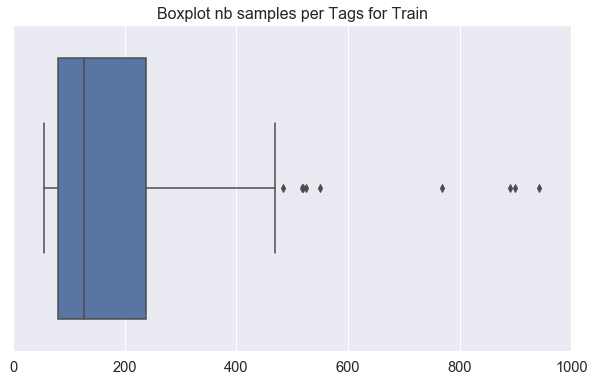

In [519]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb samples per Tags for Train")
ax = sns.boxplot(encoded_y_train.sum(axis=0))
ax.set_xlim([0,1000])

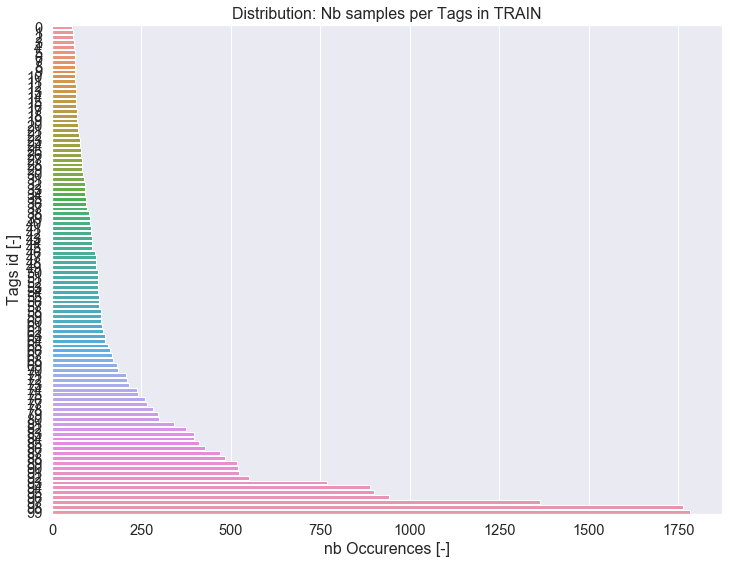

In [520]:
fig = plt.figure(figsize=(12, 9))
plt.title("Distribution: Nb samples per Tags in TRAIN")
df_count = pd.DataFrame(data=encoded_y_train.sum(axis=0), 
                        columns=['nb_samples'])
ax = sns.barplot(y=df_count.index, x=sorted(df_count["nb_samples"]), orient='h')
#ax.set_xlim(right=90)
#ax.set_ylim([0, 20])
ax.set_xlabel("nb Occurences [-]")
ax.set_ylabel("Tags id [-]");

In [521]:
print("Table of Tag id with min used of Tags")
df_count[df_count["nb_samples"] < df_most.iloc[idx_most]["nb_min_used"]]

Table of Tag id with min used of Tags


nb_samples
12          64
16          67
26          61
29          64
31          61
33          67
35          65
36          68
37          70
40          56
45          65
48          60
53          65
54          60
55          71
73          73
78          66
86          71
88          65
89          68
93          64
97          74

Text(0, 0.5, 'nb [-]')

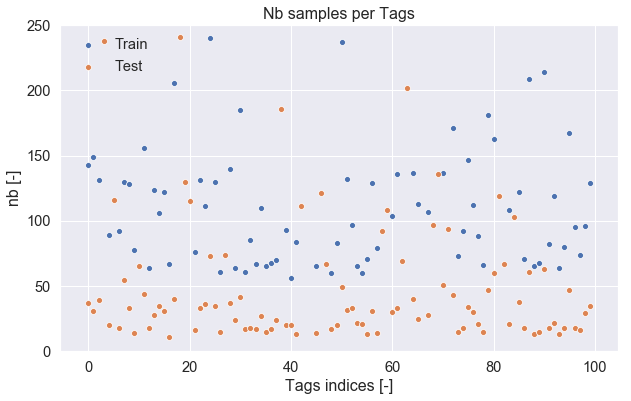

In [522]:
fig = plt.figure(figsize=(10, 6))
plt.title("Nb samples per Tags")
ax = sns.scatterplot(data=encoded_y_train.sum(axis=0), label='Train')
ax1 = sns.scatterplot(data=encoded_y_test.sum(axis=0), label='Test')
#ax1.set_xlim([0,250])
ax.set_xlabel('Tags indices [-]')
ax1.set_ylim([0,250])
ax.set_ylabel('nb [-]')

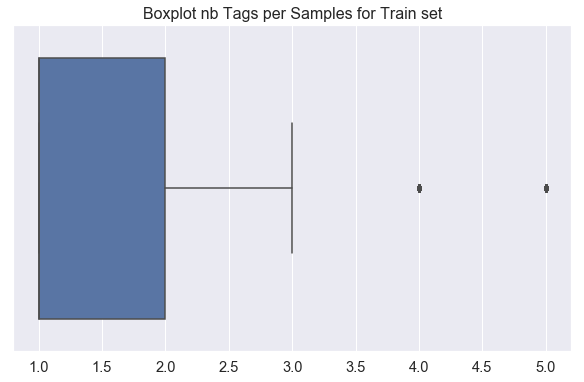

In [523]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Train set")
ax = sns.boxplot(encoded_y_train.sum(axis=1))
#ax.set_xlim([0,250])

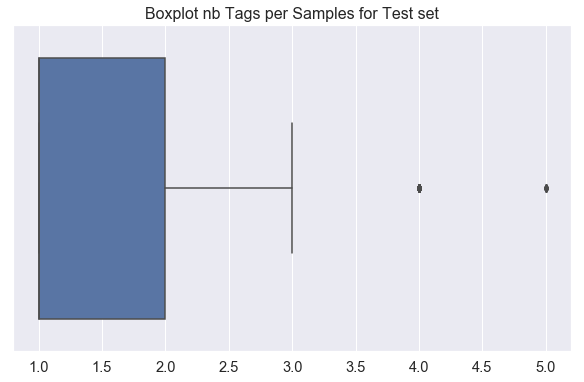

In [524]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Test set")
ax = sns.boxplot(encoded_y_test.sum(axis=1))

#### Features preparation

In [525]:
# train counts
tf_1 = tf_vectorizer_sup_1.\
    fit_transform(df_quest_cleaned[(df_quest_cleaned.Train== True) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_train_counts_sup_1 = tf_1
X_train_counts_sup_1.shape

(14195, 1000)

In [526]:
# test counts
X_test_counts_sup_1 = tf_vectorizer_sup_1.transform(
    df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_test_counts_sup_1.shape

(3549, 1000)

In [527]:
# calculate tf-idf
tfidf_transformer_sup_1 = TfidfTransformer().fit(X_train_counts_sup_1)

In [528]:
# train
X_train_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_train_counts_sup_1)
X_train_tfidf_sup_1.shape

(14195, 1000)

In [529]:
# test
X_test_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_test_counts_sup_1)
X_test_tfidf_sup_1.shape

(3549, 1000)

#### Optim

In [530]:
clf_rf_multi_cv = RandomForestClassifier(random_state=0, n_jobs=-1)

In [531]:
# Fixer les valeurs des hyperparamètres à tester
# 5th try OVR
# {'estimator__n_estimators': [25], 'estimator__max_features': [155]} 0.192585
# Train Score : 0.961302784068203
# Test Score :  0.20671283963771978
# Nb. no Tags samples : 232 over 15014 rows [1.55%]
# Nb. no Tags samples : 1158 over 3754 rows [30.85%]

# 1st try {'n_estimators': [10, 20, 30], 'max_features': [24, 31, 37]}
# - best : {'max_features': 37, 'n_estimators': 30}
#   Train Score : 0.9697780908770693
#   Test Score :  0.24260355029585798
#   Nb. no Tags samples : 173 over 14195 rows [1.22%]
#   Nb. no Tags samples : 1486 over 3549 rows [41.87%] 

#2nd Try : {'n_estimators': [30, 40], 'max_features': [37, 43, 49]}
#{'max_features': 49, 'n_estimators': 40}
#Train Score : 0.9844311377245509
#Test Score :  0.25725556494787266
#Nb. no Tags samples : 87 over 14195 rows [0.61%]
#Nb. no Tags samples : 1342 over 3549 rows [37.81%]

#{'n_estimators': [50, 60], 'max_features': [55, 62, 68]}
#{'max_features': 68, 'n_estimators': 60}
#Train Score : 0.994082423388517
#Test Score :  0.2702169625246548
#Nb. no Tags samples : 27 over 14195 rows [0.19%]
#Nb. no Tags samples : 1223 over 3549 rows [34.46%]

#{'n_estimators': [60, 70], 'max_features': [68, 93, 124]} 0.266408
#{'max_features': 124, 'n_estimators': 70}
#Train Score : 0.994082423388517
#Test Score :  0.2702169625246548
#Nb. no Tags samples : 27 over 14195 rows [0.19%]
#Nb. no Tags samples : 1223 over 3549 rows [34.46%]

#{'n_estimators': [80], 'max_features': [124, 155, 186]}    
# {'max_features': 186, 'n_estimators': 80}
#Train Score : 0.9970412116942585
#Test Score :  0.2879684418145957
#Nb. no Tags samples : 13 over 14195 rows [0.09%]
#Nb. no Tags samples : 1008 over 3549 rows [28.40%]
#{'max_features': 31, 'min_samples_split': 3, 'n_estimators': 50}

#Train Score : 0.9355406833392039
#Test Score :  0.2361228515074669
#Nb. no Tags samples : 366 over 14195 rows [2.58%]
#Nb. no Tags samples : 1524 over 3549 rows [42.94%]


'''Train Score : 0.6211342021838676
Test Score :  0.2231614539306847
Nb. no Tags samples : 2599 over 14195 rows [18.31%]
Nb. no Tags samples : 1507 over 3549 rows [42.46%]
'''


'''
max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))
n_estimators_range = [10]
max_depth_range = [5, 10, 50, 100, 200, 210, 250, 300, 350, 400 ]
max_features_range = [max_features_ideal]
min_samples_split_range = [5, 6, 7, 8, 9, 10, 11]
'''

'''max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))
n_estimators_range = [50]
max_features_range = [max_features_ideal]
min_samples_split_range = [3]
score = 'f1_micro'
# grille de paramètres
param_grid = {'n_estimators': n_estimators_range, 
              'max_features': max_features_range,
             'min_samples_split': min_samples_split_range}
param_grid
'''

max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))
n_estimators_range = [25, 50]
max_depth_range = [None, 25, 50, 100, 150, 200]
max_features_range = [max_features_ideal]
min_samples_split_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]

score = ['accuracy', 'f1_micro', 'precision_micro', 'recall_micro']

param_grid = {'n_estimators': n_estimators_range, 
              'max_features': max_features_range,
             'min_samples_split': min_samples_split_range,
             'max_depth': max_depth_range}
param_grid

{'n_estimators': [25, 50],
 'max_features': [31],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'max_depth': [None, 25, 50, 100, 150, 200]}

In [532]:
# Créer  avec recherche d'hyperparamètre par validation croisée
g_clf_rf_multi_cv = model_selection.GridSearchCV(clf_rf_multi_cv,
param_grid, # hyperparamètres à tester
cv=cv,# nombre de folds de validation croisée
scoring=score, refit="f1_micro") # score à optimiser
# Optimiser ce classifieur sur le jeu d'entraînement
t_0 = time.time()
g_clf_rf_multi_cv.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_clf_rf_multi_cv.best_params_)

timing total: 9512.991389274597 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 150, 'max_features': 31, 'min_samples_split': 2, 'n_estimators': 25}


In [533]:
df_res_rf_multi_cv = pd.DataFrame(data=g_clf_rf_multi_cv.cv_results_)
df_res_rf_multi_cv.sort_values(by="rank_test_f1_micro").T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/depre

72  \
mean_fit_time                                                           9.79152   
std_fit_time                                                           0.132987   
mean_score_time                                                         2.87765   
std_score_time                                                        0.0899082   
param_max_depth                                                             150   
param_max_features                                                           31   
param_min_samples_split                                                       2   
param_n_estimators                                                           25   
params                        {'max_depth': 150, 'max_features': 31, 'min_sa...   
split0_test_accuracy                                                   0.236703   
split1_test_accuracy                                                   0.237408   
split2_test_accuracy                                                   0.237055   
mean_test_accuracy                                                     0.237055   
std_test_accuracy                                                     0.0002876   
rank_test_accuracy                                                            1   
split0_train_accuracy                                                  0.890366   
split1_train_accuracy                                                  0.894593   
split2_train_accuracy                                                  0.895914   
mean_train_accuracy                                                    0.893625   
std_train_accuracy                                                   0.00236616   
split0_test_f1_micro                                                   0.482967   
split1_test_f1_micro                                                   0.484511   
split2_test_f1_micro                                                   0.485607   
mean_test_f1_micro                                                     0.484362   
std_test_f1_micro                                                    0.00108261   
rank_test_f1_micro                                                            1   
split0_train_f1_micro                                                  0.958164   
split1_train_f1_micro                                                  0.959437   
split2_train_f1_micro                                                  0.960702   
mean_train_f1_micro                                                    0.959435   
std_train_f1_micro                                                   0.00103618   
split0_test_precision_micro                                            0.843469   
split1_test_precision_micro                                            0.835581   
split2_test_precision_micro                                            0.830841   
mean_test_precision_micro                                               0.83663   
std_test_precision_micro                                             0.00520865   
rank_test_precision_micro                                                   105   
split0_train_precision_micro                                           0.999769   
split1_train_precision_micro                                           0.999827   
split2_train_precision_micro                                           0.999714   
mean_train_precision_micro                                              0.99977   
std_train_precision_micro                                            4.6476e-05   
split0_test_recall_micro                                               0.338354   
split1_test_recall_micro                                               0.341169   
split2_test_recall_micro                                               0.343058   
mean_test_recall_micro                                                  0.34086   
std_test_recall_micro                                                 0.0019328   
rank_test_recall_micro                                                        1   
split0_tra

In [534]:
g_clf_rf_multi_cv.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 150,
 'max_features': 31,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 25,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

##### Save

In [535]:
save_gridsearchcv_sup(g_clf_rf_multi_cv, df_res_rf_multi_cv,"RF")

max_depth
150
max_features
31
min_samples_split
2
n_estimators
25
Results Saved here:
../../data/df_res_RF_tags100_max_depth150_max_features31_min_samples_split2_n_estimators25.csv
Model Saved here:
../../data/model_RF_tags100_max_depth150_max_features31_min_samples_split2_n_estimators25.pkl


##### Eval best estimator :

In [536]:
print("Train Score :", 
      g_clf_rf_multi_cv.best_estimator_.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      g_clf_rf_multi_cv.best_estimator_.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.8936245156745333
Test Score :  0.2296421527190758


In [537]:
predicted_train = g_clf_rf_multi_cv.best_estimator_.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
t_pred_0 = time.time()
predicted_test = g_clf_rf_multi_cv.best_estimator_.predict(X_test_tfidf_sup_1)
t_pred_1 = time.time()
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.0012920042268404369
Test hamming loss : 0.012225979149056073


In [538]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 1182 over 14195 rows [8.33%]
Nb. no Tags samples : 1529 over 3549 rows [43.08%]


1529

#### Compare

##### For n_estimators = 25

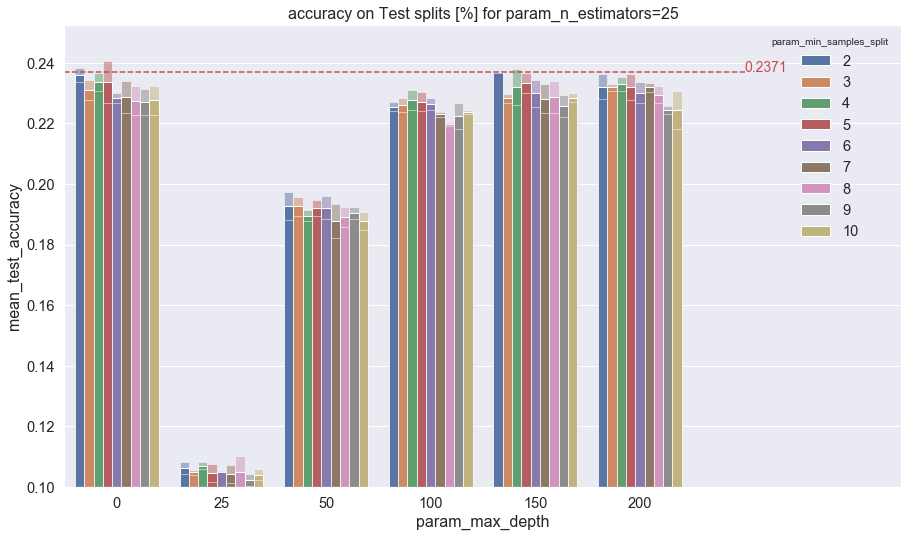

In [539]:
plot_res_test_split(df_res_rf_multi_cv, "accuracy", "param_max_depth", 
                    "param_min_samples_split",
                    y_min=0.1, 
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

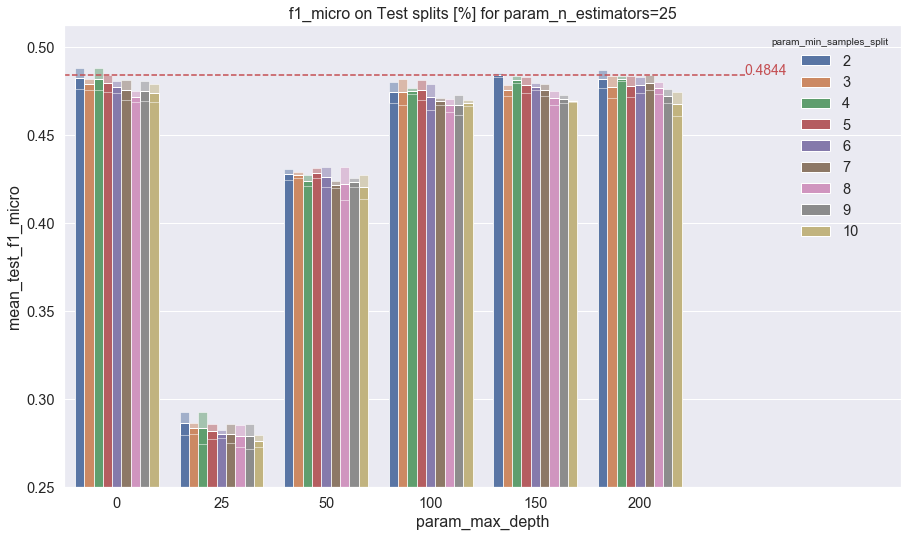

In [540]:
plot_res_test_split(df_res_rf_multi_cv, "f1_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.25,
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

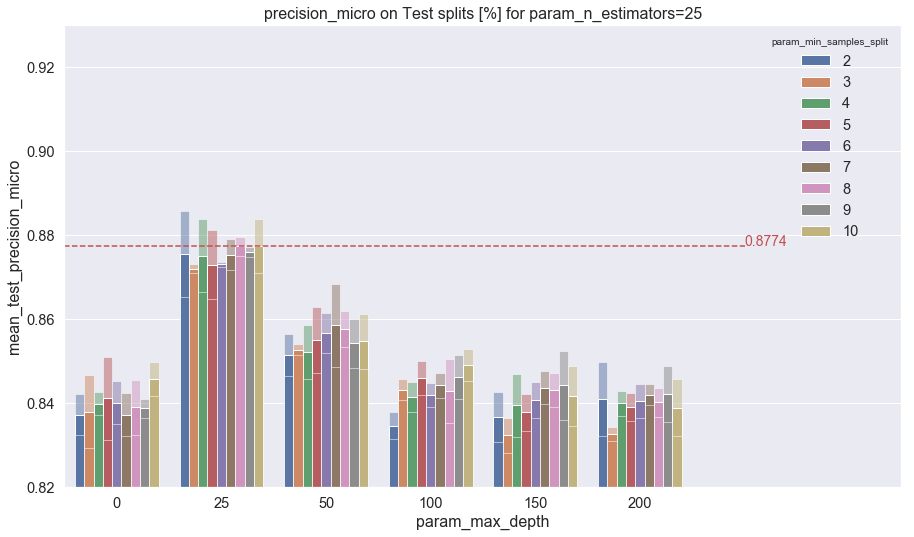

In [541]:
plot_res_test_split(df_res_rf_multi_cv, "precision_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.82,
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

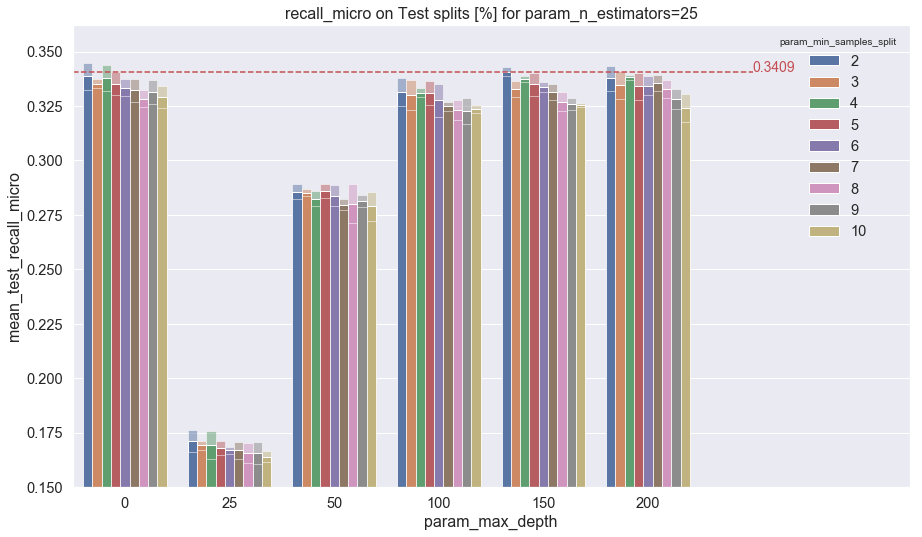

In [542]:
plot_res_test_split(df_res_rf_multi_cv, "recall_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.15,
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

##### For n_estimators = 50

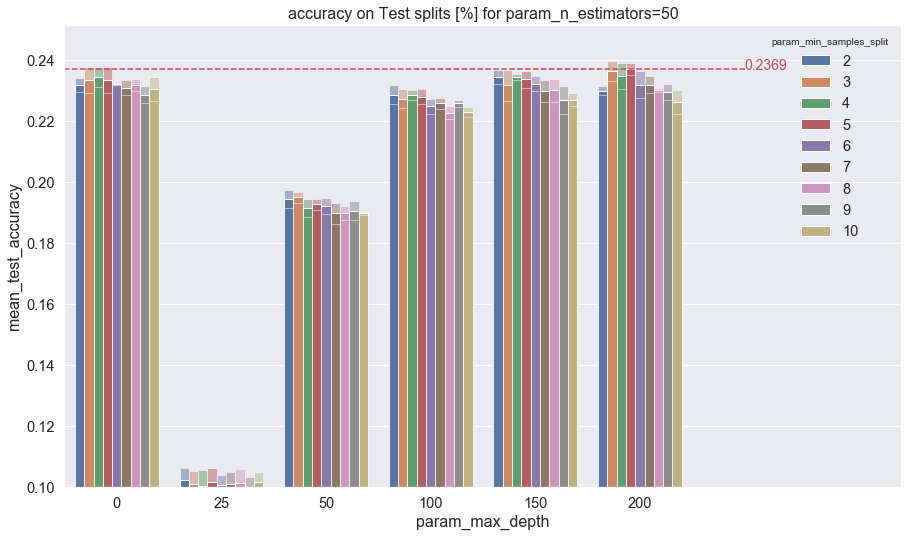

In [543]:
plot_res_test_split(df_res_rf_multi_cv, "accuracy", "param_max_depth", 
                    "param_min_samples_split",
                    y_min=0.1, 
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

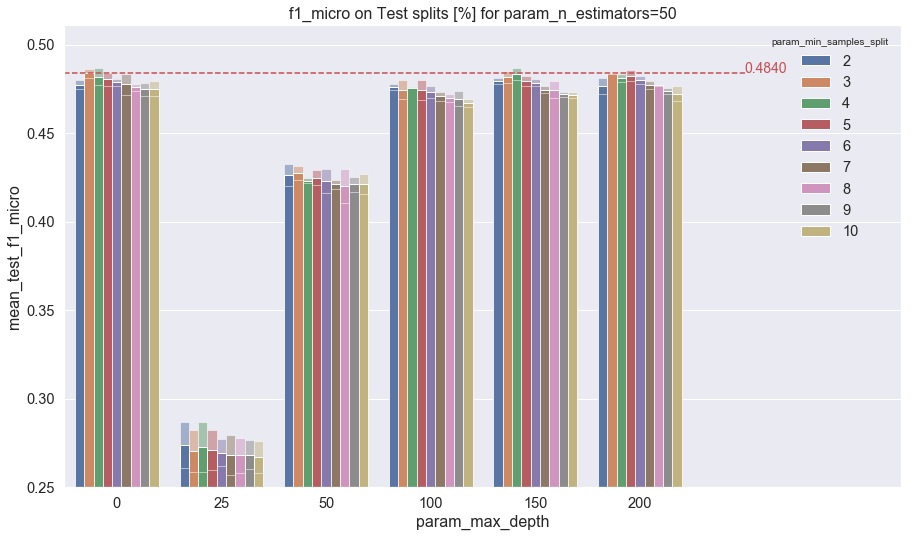

In [544]:
plot_res_test_split(df_res_rf_multi_cv, "f1_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.25,
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

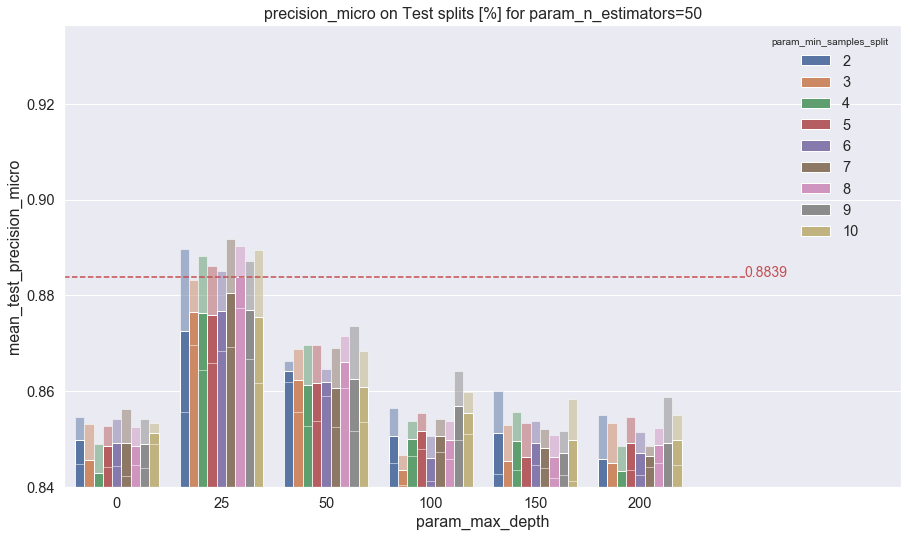

In [545]:
plot_res_test_split(df_res_rf_multi_cv, "precision_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.84,
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

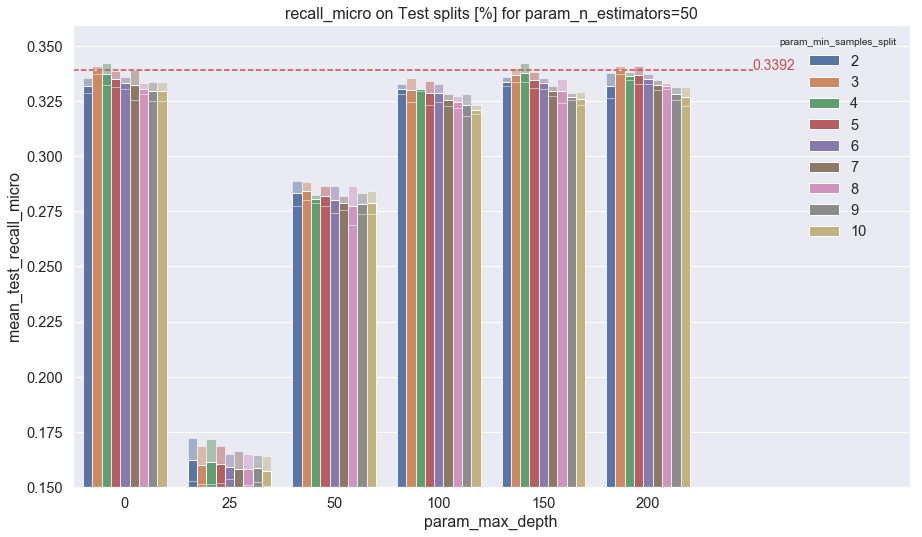

In [546]:
plot_res_test_split(df_res_rf_multi_cv, "recall_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.15,
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

##### Final comparison

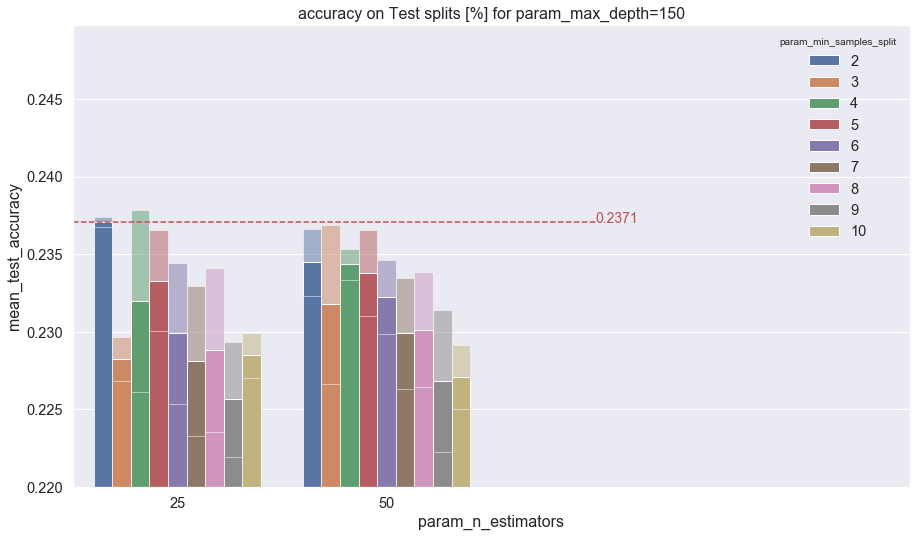

In [547]:
plot_res_test_split(df_res_rf_multi_cv, "accuracy", "param_n_estimators", 
                    "param_min_samples_split", y_min=0.22,
                    myFixedParam="param_max_depth",
                    myFixedValue=150)

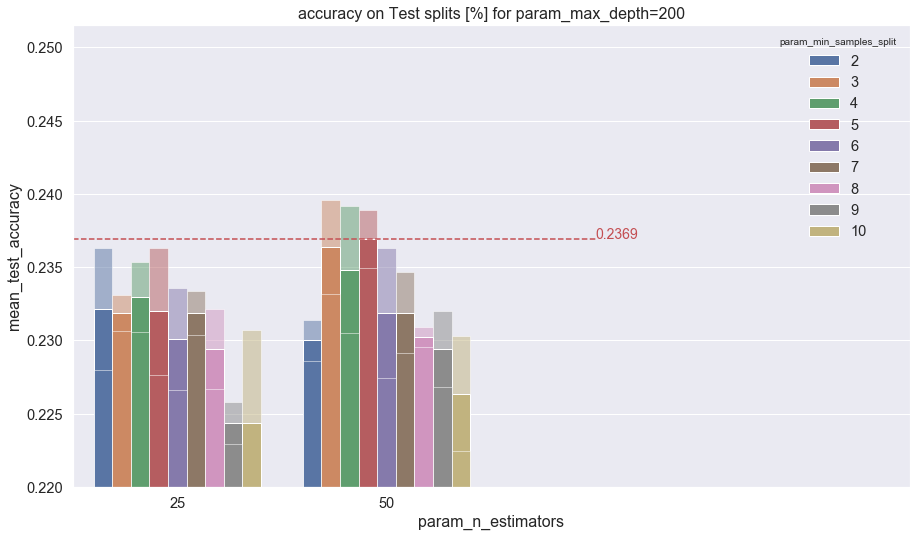

In [548]:
plot_res_test_split(df_res_rf_multi_cv, "accuracy", "param_n_estimators", 
                    "param_min_samples_split", y_min=0.22,
                    myFixedParam="param_max_depth",
                    myFixedValue=200)

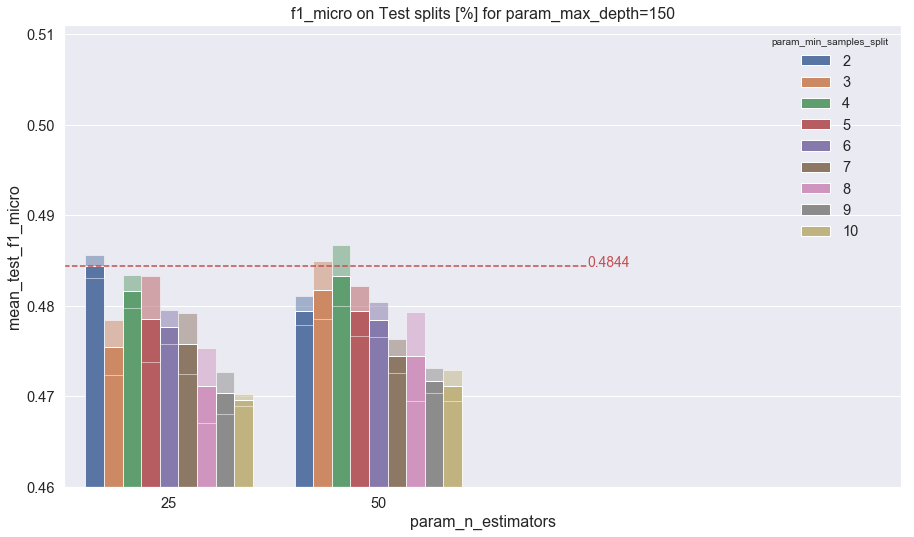

In [549]:
plot_res_test_split(df_res_rf_multi_cv, "f1_micro", "param_n_estimators", 
                    "param_min_samples_split", y_min=0.46,
                    myFixedParam="param_max_depth",
                    myFixedValue=150)

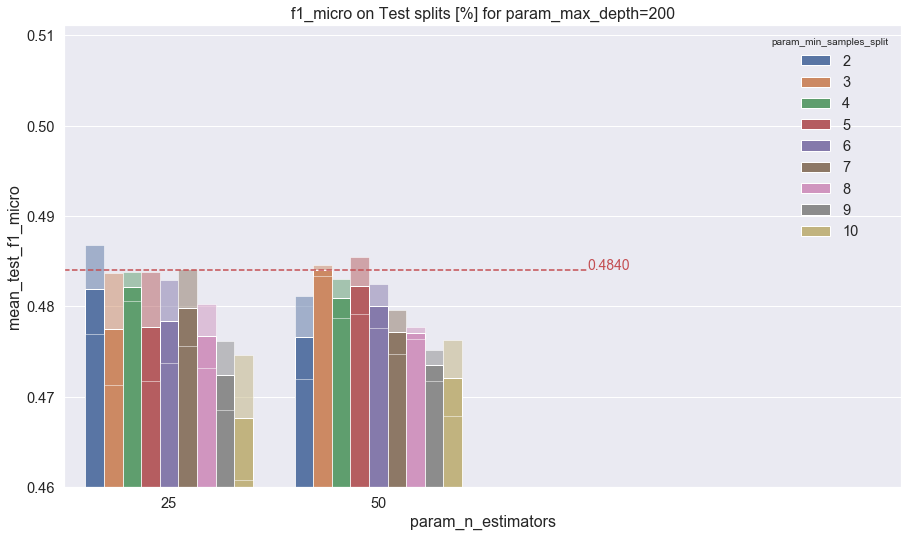

In [550]:
plot_res_test_split(df_res_rf_multi_cv, "f1_micro", "param_n_estimators", 
                    "param_min_samples_split", y_min=0.46,
                    myFixedParam="param_max_depth",
                    myFixedValue=200)

##### Best model
Best F1 score for Splits Test

- n_estimators: 25
- min_samples_split: 2
- max_depth: 150


In [551]:
g_clf_rf_multi_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=150, max_features=31, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Evaluation

In [552]:
precision_score(encoded_y_train, predicted_train, average='micro')

0.9996322853465711

In [553]:
precision_score(encoded_y_test, predicted_test, average='micro')

0.8224066390041493

In [554]:
recall_score(encoded_y_train, predicted_train, average='micro')

0.9225417833206074

In [555]:
recall_score(encoded_y_test, predicted_test, average='micro')

0.33633124045477686

In [556]:
f1_score(encoded_y_train, predicted_train, average='micro')

0.9595411427310832

In [557]:
f1_score(encoded_y_test, predicted_test, average='micro')

0.47741780079489343

##### Get the list of list predicted

In [558]:
list_tuple_ypred_train = mlb.inverse_transform(predicted_train)
list_tuple_ypred_test = mlb.inverse_transform(predicted_test)

In [559]:
len(list_tuple_ypred_train)

14195

In [560]:
predicted_train.shape

(14195, 100)

In [561]:
len(list_tuple_ypred_test)

3549

In [562]:
predicted_test.shape

(3549, 100)

##### Re-encode y pred lists

In [563]:
enc_sup_ypred_train = mlb_lda.transform(list_tuple_ypred_train)
enc_sup_ypred_test = mlb_lda.transform(list_tuple_ypred_test)

##### Create DafaFrames Train and Test using encoded y pred data using index of big dataFrame

Same index reference : 
    df_quest_cleaned.INDEX -> 2 encoded data y pred Dataframes.INDEX


In [564]:
enc_sup_ypred_train.shape

(14195, 8765)

In [565]:
df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(14195, 40)

In [566]:
df_enc_sup_ypred_train = pd.DataFrame(data=enc_sup_ypred_train,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_train.shape)
df_enc_sup_ypred_train.head()

(14195, 8765)


0     1     2     3     4     5     6     7     8     9     10    11    \
3      0     0     0     0     0     0     0     0     0     0     0     0   
4      0     0     0     0     0     0     0     0     0     0     0     0   
9      0     0     0     0     0     0     0     0     0     0     0     0   
10     0     0     0     0     0     0     0     0     0     0     0     0   
12     0     0     0     0     0     0     0     0     0     0     0     0   

    ...   8753  8754  8755  8756  8757  8758  8759  8760  8761  8762  8763  \
3   ...      0     0     0     0     0     0     0     0     0     0     0   
4   ...      0     0     0     0     0     0     0     0     0     0     0   
9   ...      0     0     0     0     0     0     0     0     0     0     0   
10  ...      0     0     0     0     0     0     0     0     0     0     0   
12  ...      0     0     0     0     0     0     0     0     0     0     0   

    8764  
3      0  
4      0  
9      0  
10     0  
12     0  

[5 rows x 8765 columns]

In [567]:
enc_sup_ypred_test.shape

(3549, 8765)

In [568]:
df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(3549, 40)

In [569]:
df_enc_sup_ypred_test = pd.DataFrame(data=enc_sup_ypred_test,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_test.shape)
df_enc_sup_ypred_test.head()

(3549, 8765)


0     1     2     3     4     5     6     7     8     9     10    11    \
21     0     0     0     0     0     0     0     0     0     0     0     0   
31     0     0     0     0     0     0     0     0     0     0     0     0   
54     0     0     0     0     0     0     0     0     0     0     0     0   
68     0     0     0     0     0     0     0     0     0     0     0     0   
94     0     0     0     0     0     0     0     0     0     0     0     0   

    ...   8753  8754  8755  8756  8757  8758  8759  8760  8761  8762  8763  \
21  ...      0     0     0     0     0     0     0     0     0     0     0   
31  ...      0     0     0     0     0     0     0     0     0     0     0   
54  ...      0     0     0     0     0     0     0     0     0     0     0   
68  ...      0     0     0     0     0     0     0     0     0     0     0   
94  ...      0     0     0     0     0     0     0     0     0     0     0   

    8764  
21     0  
31     0  
54     0  
68     0  
94     0  

[5 rows x 8765 columns]

In [570]:
# extraction example : 
df_enc_sup_ypred_test.loc[:,range(0,5)].head()

0  1  2  3  4
21  0  0  0  0  0
31  0  0  0  0  0
54  0  0  0  0  0
68  0  0  0  0  0
94  0  0  0  0  0

##### Extract only flag most used & Train columns 

In [571]:
df_test = df_quest_cleaned.filter(items=[col_flag, "Train"])
print(df_test.shape)
df_test.head()

(21208, 2)


flag_most_Tagged_76  Train
3                  True   True
4                  True   True
9                  True   True
10                 True   True
12                 True   True

##### Add y pred Train encoded data

In [572]:
df_test2 = df_test.join(df_enc_sup_ypred_train)
print(df_test2.shape)

(21208, 8767)


##### Add y pred Test data

In [573]:
df_test2.update(df_enc_sup_ypred_test)
print(df_test2.shape)

(21208, 8767)


##### Assign no Tags to samples/rows without most used tags

In [574]:
df_test2.isnull().sum().sum()

30361960

In [575]:
df_test2[df_test2.isna()] = 0

In [576]:
df_test2.isnull().sum().sum()

0

In [577]:
df_test2[df_test2[0].isna()].shape[0]

0

##### Extract encoded binarized array for y pred Train & Test to be evaluated

In [578]:
enc_sup_all_ypred_train = df_test2.loc[df_quest_cleaned["Train"] == True,
             range(0, enc_sup_ypred_train.shape[1])].values
enc_sup_all_ypred_train.shape

(16966, 8765)

In [579]:
enc_lda_y_train.shape

(16966, 8765)

In [580]:
enc_sup_all_ypred_test = df_test2.loc[df_quest_cleaned["Train"] == False,
             range(0, enc_sup_ypred_test.shape[1])].values
enc_sup_all_ypred_test.shape

(4242, 8765)

In [581]:
enc_lda_y_test.shape

(4242, 8765)

##### Evaluate on all data

In [582]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_sup_all_ypred_train,
                          enc_lda_y_test, enc_sup_all_ypred_test, 
                          t_1-t_0, t_pred_1-t_pred_0)

Nb. no Tags samples : 3953 over 16966 rows [23.30%]
Nb. no Tags samples : 2222 over 4242 rows [52.38%]


In [583]:
df_results = add_score(df_results, series_scores, 
          "RF_tags{}".format(int(nb_most_used_tags)))
df_results

add line


f1_splits_test  f1_splits_test_std  acc_train  acc_test  \
LDA_top50_tags10         0.141678            0.000771   0.000000  0.000000   
LDA_top50_tags1          0.139635            0.000250   0.016975  0.017445   
LDA_top50_tags2          0.162595            0.000955   0.006955  0.006129   
LDA_top50_tags3          0.171949            0.001617   0.002476  0.002357   
LDA_top50_tags4          0.173857            0.001200   0.000648  0.000236   
LDA_top50_tags5          0.172366            0.001016   0.000000  0.000000   
LDA_top50_tags6          0.165265            0.000587   0.000000  0.000000   
LDA_top25_tags10         0.136579            0.000297   0.000000  0.000000   
LDA_top25_tags1          0.137544            0.001813   0.015325  0.015559   
LDA_top25_tags2          0.161006            0.001770   0.006012  0.006129   
LDA_top25_tags3          0.169592            0.000736   0.002240  0.002593   
LDA_top25_tags4          0.168388            0.000125   0.000589  0.000471   
LDA_top25_tags5          0.164371            0.000361   0.000000  0.000000   
LDA_top25_tags6          0.157607            0.000213   0.000000  0.000000   
LDA_top100_tags10        0.144906            0.000992   0.000000  0.000000   
LDA_top100_tags1         0.144714            0.000586   0.017623  0.017209   
LDA_top100_tags2         0.169057            0.001304   0.007721  0.008722   
LDA_top100_tags3         0.176685            0.000645   0.002358  0.002593   
LDA_top100_tags4         0.178590            0.000106   0.000648  0.000236   
LDA_top100_tags5         0.174328            0.000957   0.000000  0.000000   
LDA_top100_tags6         0.168984            0.000282   0.000000  0.000000   
LDA_top200_tags10        0.145331            0.000695   0.000000  0.000000   
LDA_top200_tags1         0.143983            0.001266   0.018095  0.016502   
LDA_top200_tags2         0.166805            0.001331   0.008605  0.007779   
LDA_top200_tags3         0.173227            0.001203   0.002299  0.002122   
LDA_top200_tags4         0.176421            0.000314   0.000766  0.000471   
LDA_top200_tags5         0.172762            0.000399   0.000000  0.000000   
LDA_top200_tags6         0.167051            0.000280   0.000000  0.000000   
RF_tags51                0.555416            0.001766   0.142344  0.044319   
RF_tags73                0.589274            0.001212   0.163503  0.044790   
RF_tags100               0.603715            0.000460   0.184369  0.045026   

                   pre_train  pre_test  rec_train  rec_test  f1_train  \
LDA_top50_tags10    0.091595  0.089321   0.310732  0.301648  0.141484   
LDA_top50_tags1     0.278793  0.273692   0.094579  0.092429  0.141243   
LDA_top50_tags2     0.201963  0.189769   0.137030  0.128175  0.163277   
LDA_top50_tags3     0.170419  0.161245   0.173442  0.163363  0.171917   
LDA_top50_tags4     0.150802  0.144743   0.204635  0.195526  0.173642   
LDA_top50_tags5     0.136261  0.133145   0.231129  0.224823  0.171446   
LDA_top50_tags6     0.123364  0.121326   0.251105  0.245840  0.165447   
LDA_top25_tags10    0.088023  0.085950   0.298614  0.290264  0.135967   
LDA_top25_tags1     0.275551  0.269213   0.093479  0.090916  0.139600   
LDA_top25_tags2     0.200961  0.196605   0.136350  0.132792  0.162467   
LDA_top25_tags3     0.168160  0.159987   0.171142  0.162089  0.169638   
LDA_top25_tags4     0.145733  0.139026   0.197756  0.187804  0.167805   
LDA_top25_tags5     0.130013  0.124422   0.220531  0.210095  0.163585   
LDA_top25_tags6     0.116989  0.113272   0.238128  0.229520  0.156897   
LDA_top100_tags10   0.093758  0.090806   0.318070  0.306663  0.144826   
LDA_top100_tags1    0.289579  0.279114   0.098238  0.094260  0.146707   
LDA_top100_tags2    0.209772  0.202381   0.142329  0.136693  0.169591   
LDA_top100_tags3    0.174918  0.166667   0.178021  0.168856  0.176456   
LDA_top100_tags4    0.154235  0.149104   0.209294  0.201417  0.177595   
LDA_top100_tags5    0.138112  0.135031   0.234268  0.228007  0

##### Save

In [707]:
path_save = PATH_EXPORT_FOLDER + "df_results.csv"
df_results.to_csv(path_or_buf=path_save, sep=',')
print("All Results Saved here:\n{}".format(path_save))

All Results Saved here:
../../data/df_results.csv


###  RandomForest Multi-Tags : 201 Most Used Tags

#### Choose Most Used Tags

In [705]:
idx_most = 3

In [706]:
list_tags_most_used = list_list_most_used[idx_most]
col_flag = "flag_most_Tagged_{:.0f}".format(df_most.iloc[idx_most]["nb_min_used"])
print(col_flag)
nb_most_used_tags = df_most.iloc[idx_most]["nb_most_used_tags"]
len(list_tags_most_used)

flag_most_Tagged_40


201

#### Multi-label encoding

##### For output to predict, extract only most used Tags

In [708]:
# create list of list of Tags to be able to encode multi label outputs
print('\nFor train set...')  
list_list_tags_train = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == True) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_train[:10])

print('\nFor test set...')  
list_list_tags_test = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_test[:10])


For train set...
[['c#', 'sql', 'sql-server'], ['sql-server'], ['javascript', 'php', 'ajax'], ['android', 'amazon-s3'], ['sql'], ['php', 'laravel'], ['python'], ['java'], ['javascript', 'json', 'reactjs', 'object'], ['android']]

For test set...
[['ios', 'objective-c'], ['ios', 'swift'], ['c++', 'qt'], ['excel', 'vba', 'excel-vba'], ['android', 'gradle'], ['sql-server'], ['c#', 'asp.net', 'bootstrap-4'], ['javascript', 'reactjs'], ['python', 'django'], ['javascript', 'angular', 'typescript']]


##### Encoding output to predict

In [709]:
#y = [['tag3','tag1'],['tag1','tag0','tag2']]
mlb = MultiLabelBinarizer()
encoded_y_train = mlb.fit_transform(list_list_tags_train)
encoded_y_test = mlb.transform(list_list_tags_test)

In [710]:
encoded_y_train.shape

(15032, 201)

In [711]:
encoded_y_test.shape

(3736, 201)

##### Check if enough sample for each most used Tags (important for Training) :

In [712]:
#for idx in range(0, encoded_y_train.shape[1]):
print('For less used tag:')
print("- For train: ")
nb_used_tags_train = np.sum(encoded_y_train, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_train))
print("\n- For test : ")
nb_used_tags_test = np.sum(encoded_y_test, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_test))

For less used tag:
- For train: 
  - Number of use:  25

- For test : 
  - Number of use:  3


In [713]:
# for idx in range(0, encoded_y_train.shape[1]):
print('For each sample:')
print("- For train: ")
nb_tags_per_sample_train = np.sum(encoded_y_train, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_train))
print("\n- For test : ")
nb_tags_per_sample_test = np.sum(encoded_y_test, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_test))

For each sample:
- For train: 
  - Minimum Number of Tags:  1

- For test : 
  - Minimum Number of Tags:  1


In [714]:
find_nb_no_tags(encoded_y_train)
find_nb_no_tags(encoded_y_test)

Nb. no Tags samples : 0 over 15032 rows [0.00%]
Nb. no Tags samples : 0 over 3736 rows [0.00%]


0

#### Distribution of Tags

(0, 1000)

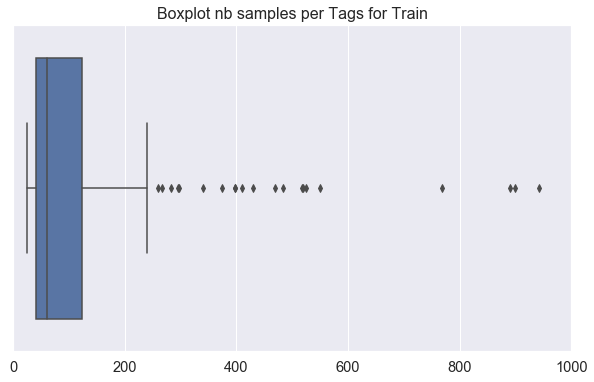

In [715]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb samples per Tags for Train")
ax = sns.boxplot(encoded_y_train.sum(axis=0))
ax.set_xlim([0,1000])

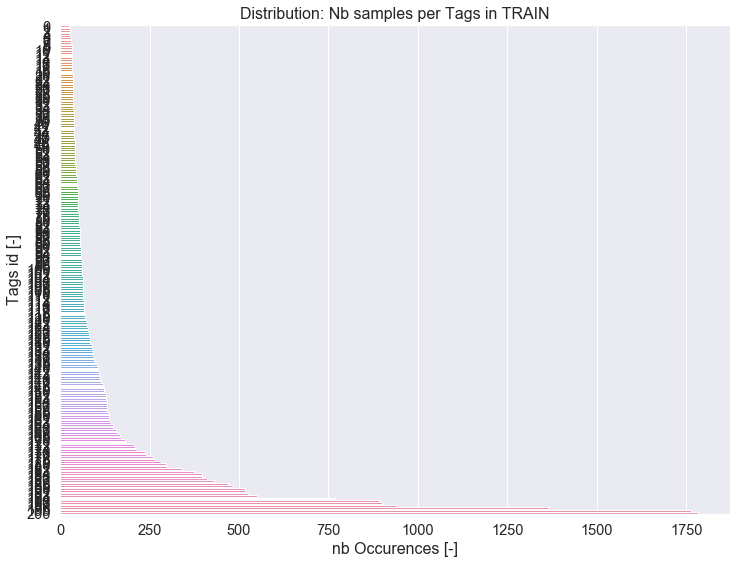

In [716]:
fig = plt.figure(figsize=(12, 9))
plt.title("Distribution: Nb samples per Tags in TRAIN")
df_count = pd.DataFrame(data=encoded_y_train.sum(axis=0), 
                        columns=['nb_samples'])
ax = sns.barplot(y=df_count.index, x=sorted(df_count["nb_samples"]), orient='h')
#ax.set_xlim(right=90)
#ax.set_ylim([0, 20])
ax.set_xlabel("nb Occurences [-]")
ax.set_ylabel("Tags id [-]");

In [717]:
print("Table of Tag id with min used of Tags")
df_count[df_count["nb_samples"] < df_most.iloc[idx_most]["nb_min_used"]]

Table of Tag id with min used of Tags


nb_samples
0            34
5            37
9            29
22           35
23           39
32           39
34           36
39           32
40           31
45           31
48           36
51           35
54           32
56           31
59           34
70           35
82           29
84           34
94           36
98           37
106          38
114          34
117          34
122          39
126          35
131          33
133          38
143          34
149          34
155          36
159          35
165          34
170          35
171          38
172          27
176          37
177          38
180          35
185          38
188          29
189          25
193          35
197          38
200          32

Text(0, 0.5, 'nb [-]')

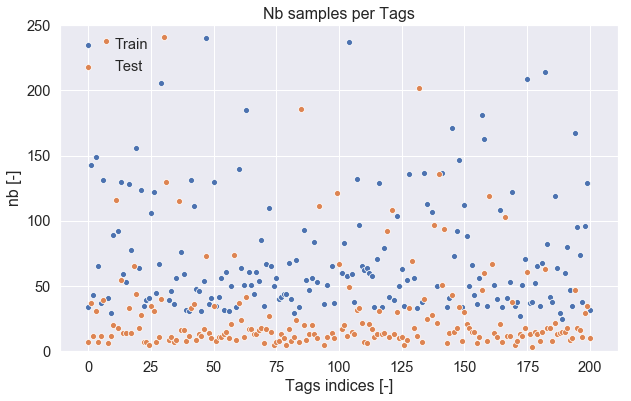

In [718]:
fig = plt.figure(figsize=(10, 6))
plt.title("Nb samples per Tags")
ax = sns.scatterplot(data=encoded_y_train.sum(axis=0), label='Train')
ax1 = sns.scatterplot(data=encoded_y_test.sum(axis=0), label='Test')
#ax1.set_xlim([0,250])
ax.set_xlabel('Tags indices [-]')
ax1.set_ylim([0,250])
ax.set_ylabel('nb [-]')

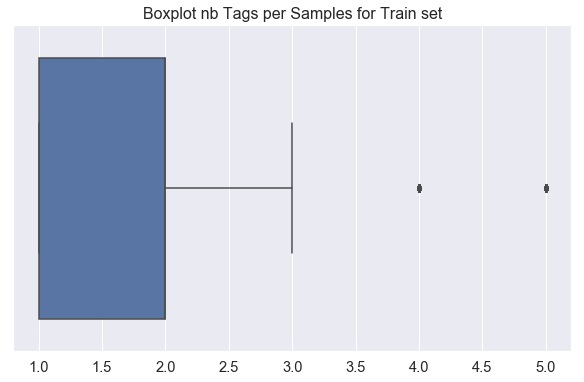

In [719]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Train set")
ax = sns.boxplot(encoded_y_train.sum(axis=1))
#ax.set_xlim([0,250])

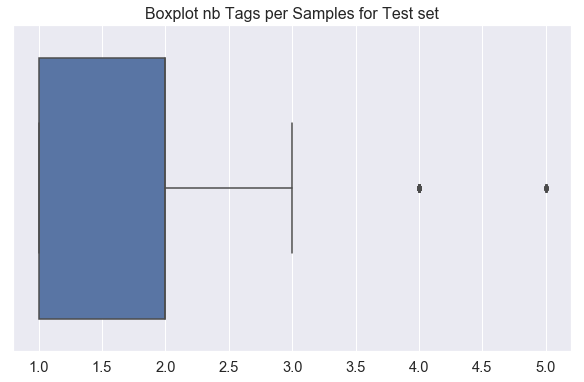

In [720]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Test set")
ax = sns.boxplot(encoded_y_test.sum(axis=1))

#### Features preparation

In [721]:
# train counts
tf_1 = tf_vectorizer_sup_1.\
    fit_transform(df_quest_cleaned[(df_quest_cleaned.Train== True) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_train_counts_sup_1 = tf_1
X_train_counts_sup_1.shape

(15032, 1000)

In [722]:
# test counts
t_count_vect_0 = time.time()
X_test_counts_sup_1 = tf_vectorizer_sup_1.transform(
    df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
t_count_vect_1 = time.time()
X_test_counts_sup_1.shape

(3736, 1000)

In [723]:
# calculate tf-idf
tfidf_transformer_sup_1 = TfidfTransformer().fit(X_train_counts_sup_1)

In [724]:
# train
X_train_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_train_counts_sup_1)
X_train_tfidf_sup_1.shape

(15032, 1000)

In [725]:
# test
t_tfidf_0 = time.time()
X_test_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_test_counts_sup_1)
t_tfidf_1 = time.time()
X_test_tfidf_sup_1.shape

(3736, 1000)

#### Optim

In [726]:
clf_rf_multi_cv = RandomForestClassifier(random_state=0, n_jobs=-1)

In [727]:
max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))
n_estimators_range = [25, 50]
max_depth_range = [None, 25, 50, 100, 150, 200]
max_features_range = [max_features_ideal]
min_samples_split_range = [2, 3, 4, 5, 6, 10]

score = ['accuracy', 'f1_micro', 'precision_micro', 'recall_micro']

param_grid = {'n_estimators': n_estimators_range, 
              'max_features': max_features_range,
             'min_samples_split': min_samples_split_range,
             'max_depth': max_depth_range}
param_grid

{'n_estimators': [25, 50],
 'max_features': [31],
 'min_samples_split': [2, 3, 4, 5, 6, 10],
 'max_depth': [None, 25, 50, 100, 150, 200]}

In [728]:
# Créer  avec recherche d'hyperparamètre par validation croisée
g_clf_rf_multi_cv = model_selection.GridSearchCV(clf_rf_multi_cv,
param_grid, # hyperparamètres à tester
cv=cv,# nombre de folds de validation croisée
scoring=score, refit="f1_micro") # score à optimiser
# Optimiser ce classifieur sur le jeu d'entraînement
t_0 = time.time()
g_clf_rf_multi_cv.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_clf_rf_multi_cv.best_params_)

timing total: 17133.396526813507 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': None, 'max_features': 31, 'min_samples_split': 4, 'n_estimators': 50}


In [729]:
df_res_rf_multi_cv = pd.DataFrame(data=g_clf_rf_multi_cv.cv_results_)
df_res_rf_multi_cv.sort_values(by="rank_test_f1_micro").T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/depre

5   \
mean_fit_time                                                            44.815   
std_fit_time                                                            3.91564   
mean_score_time                                                         15.4733   
std_score_time                                                         0.759948   
param_max_depth                                                            None   
param_max_features                                                           31   
param_min_samples_split                                                       4   
param_n_estimators                                                           50   
params                        {'max_depth': None, 'max_features': 31, 'min_s...   
split0_test_accuracy                                                   0.169604   
split1_test_accuracy                                                   0.168274   
split2_test_accuracy                                                   0.163951   
mean_test_accuracy                                                     0.167276   
std_test_accuracy                                                    0.00241343   
rank_test_accuracy                                                            9   
split0_train_accuracy                                                  0.764324   
split1_train_accuracy                                                  0.765405   
split2_train_accuracy                                                  0.762827   
mean_train_accuracy                                                    0.764186   
std_train_accuracy                                                     0.001057   
split0_test_f1_micro                                                   0.417365   
split1_test_f1_micro                                                   0.417216   
split2_test_f1_micro                                                   0.417629   
mean_test_f1_micro                                                     0.417403   
std_test_f1_micro                                                    0.00017083   
rank_test_f1_micro                                                            1   
split0_train_f1_micro                                                  0.919944   
split1_train_f1_micro                                                  0.920119   
split2_train_f1_micro                                                  0.919787   
mean_train_f1_micro                                                     0.91995   
std_train_f1_micro                                                  0.000135425   
split0_test_precision_micro                                            0.833603   
split1_test_precision_micro                                            0.843393   
split2_test_precision_micro                                            0.833157   
mean_test_precision_micro                                              0.836718   
std_test_precision_micro                                             0.00472371   
rank_test_precision_micro                                                    33   
split0_train_precision_micro                                           0.998955   
split1_train_precision_micro                                           0.999109   
split2_train_precision_micro                                           0.999264   
mean_train_precision_micro                                             0.999109   
std_train_precision_micro                                           0.000126411   
split0_test_recall_micro                                               0.278369   
split1_test_recall_micro                                               0.277162   
split2_test_recall_micro                                               0.278654   
mean_test_recall_micro                                                 0.278062   
std_test_recall_micro                                               0.000646512   
rank_test_recall_micro                                                        1   
split0_tra

In [730]:
g_clf_rf_multi_cv.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 31,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

##### Save

In [731]:
save_gridsearchcv_sup(g_clf_rf_multi_cv, df_res_rf_multi_cv,"RF")

max_depth
None
max_features
31
min_samples_split
4
n_estimators
50
Results Saved here:
../../data/df_res_RF_tags201_max_depthNone_max_features31_min_samples_split4_n_estimators50.csv
Model Saved here:
../../data/model_RF_tags201_max_depthNone_max_features31_min_samples_split4_n_estimators50.pkl


##### Eval best estimator :

In [732]:
print("Train Score :", 
      g_clf_rf_multi_cv.best_estimator_.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      g_clf_rf_multi_cv.best_estimator_.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.7713544438531134
Test Score :  0.17210920770877944


In [733]:
predicted_train = g_clf_rf_multi_cv.best_estimator_.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
t_pred_0 = time.time()
predicted_test = g_clf_rf_multi_cv.best_estimator_.predict(X_test_tfidf_sup_1)
t_pred_1 = time.time()
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.0013351285086012196
Test hamming loss : 0.007277584241533233


In [734]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 1204 over 15032 rows [8.01%]
Nb. no Tags samples : 1719 over 3736 rows [46.01%]


1719

#### Compare

##### For n_estimators = 25

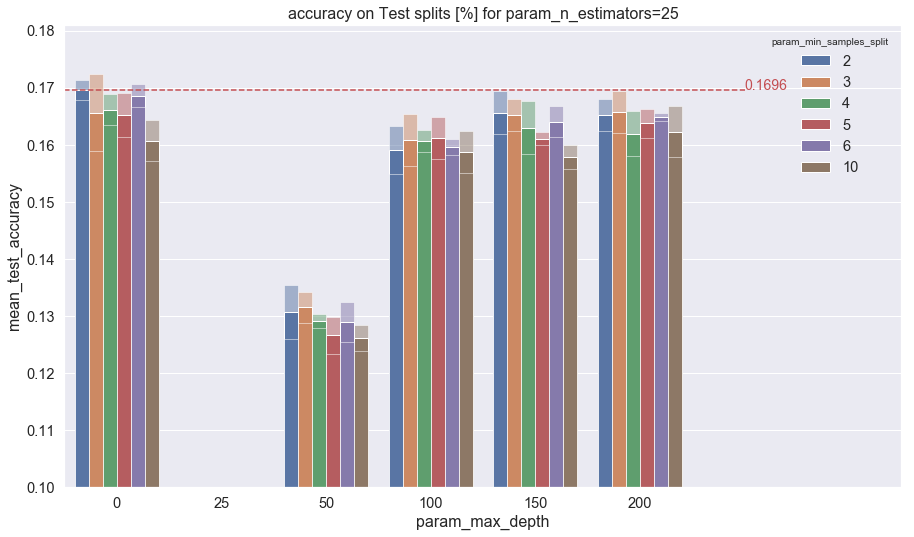

In [735]:
plot_res_test_split(df_res_rf_multi_cv, "accuracy", "param_max_depth", 
                    "param_min_samples_split",
                    y_min=0.1, 
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

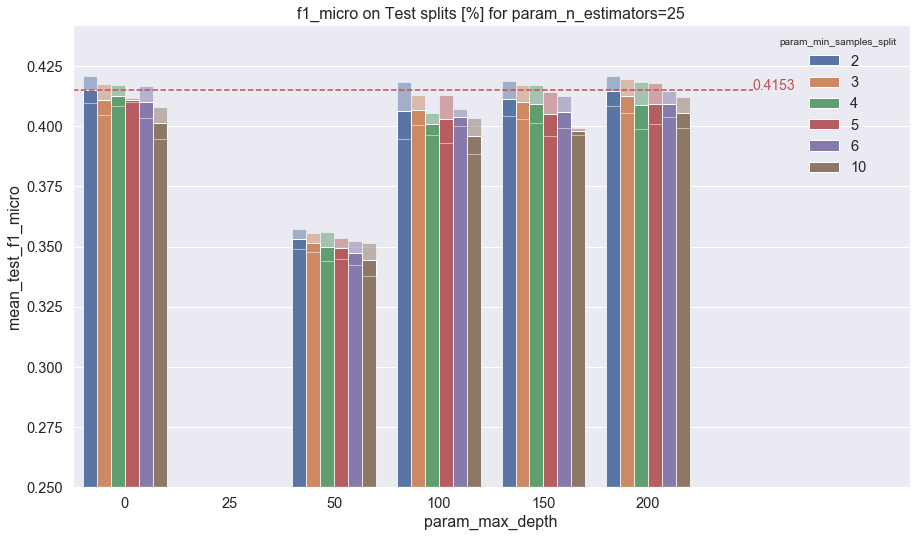

In [736]:
plot_res_test_split(df_res_rf_multi_cv, "f1_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.25,
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

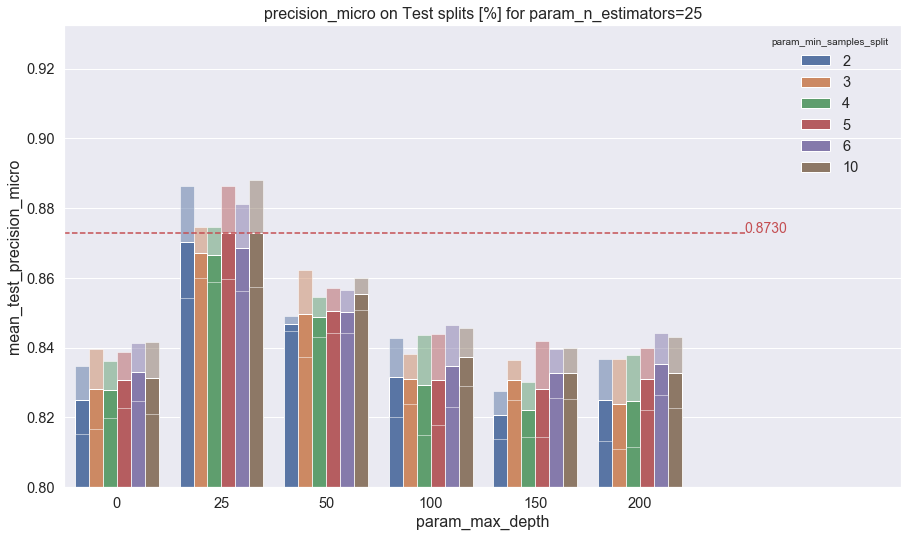

In [781]:
plot_res_test_split(df_res_rf_multi_cv, "precision_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.8,
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

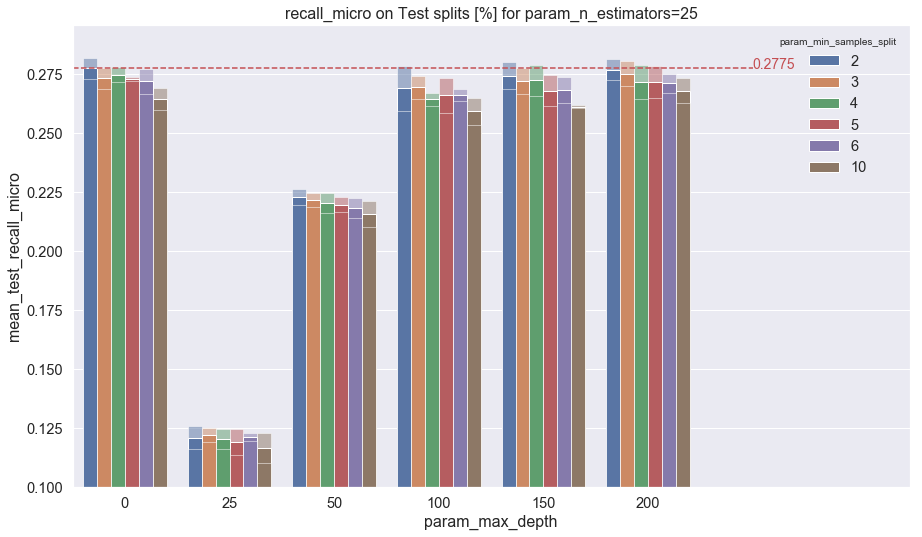

In [782]:
plot_res_test_split(df_res_rf_multi_cv, "recall_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.1,
                    myFixedParam="param_n_estimators",
                    myFixedValue=25)

##### For n_estimators = 50

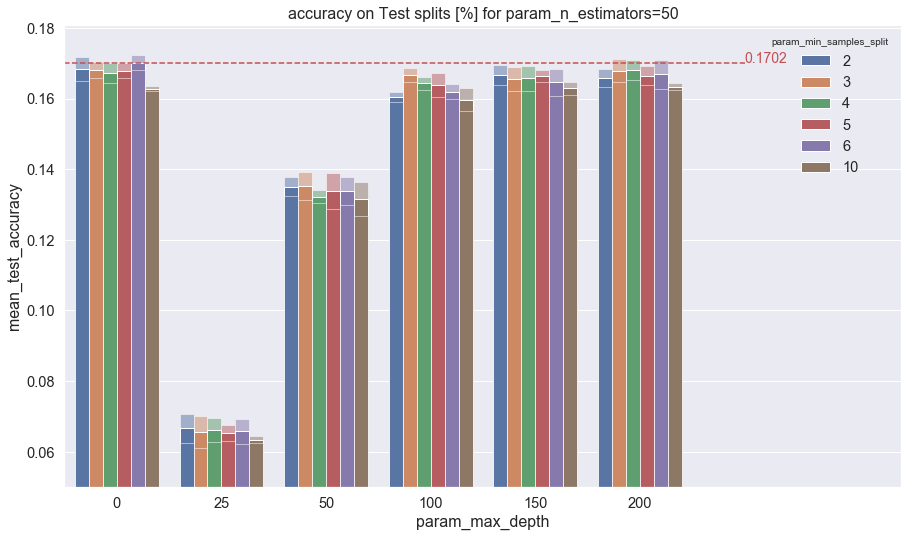

In [784]:
plot_res_test_split(df_res_rf_multi_cv, "accuracy", "param_max_depth", 
                    "param_min_samples_split",
                    y_min=0.05, 
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

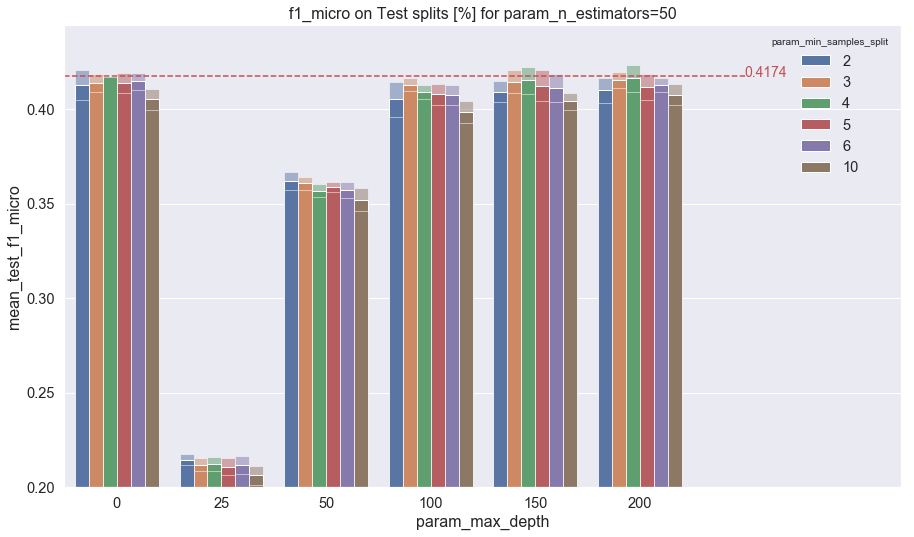

In [786]:
plot_res_test_split(df_res_rf_multi_cv, "f1_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.2,
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

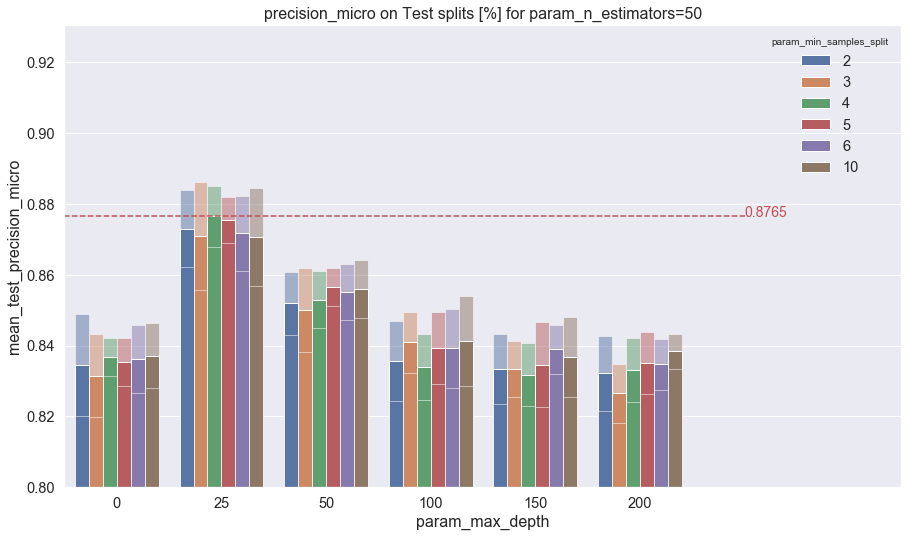

In [785]:
plot_res_test_split(df_res_rf_multi_cv, "precision_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.8,
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

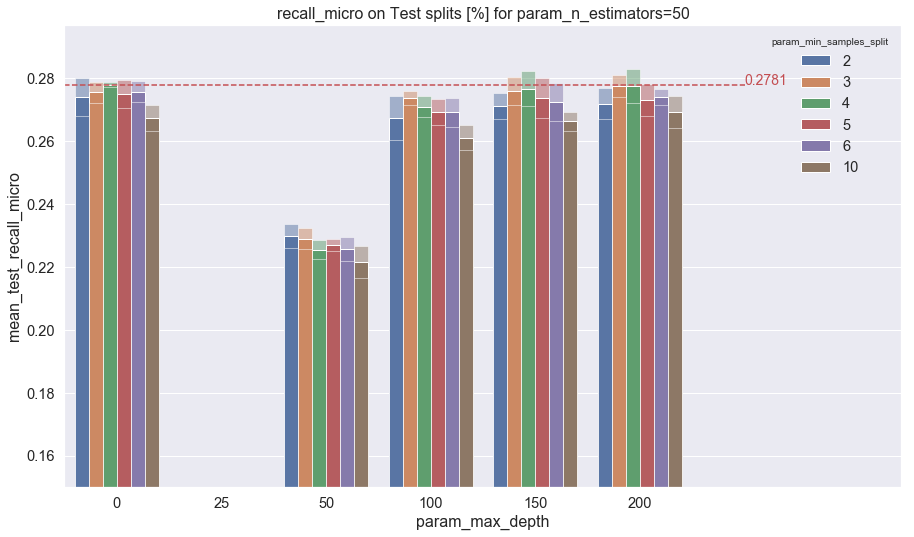

In [742]:
plot_res_test_split(df_res_rf_multi_cv, "recall_micro", "param_max_depth", 
                    "param_min_samples_split", y_min=0.15,
                    myFixedParam="param_n_estimators",
                    myFixedValue=50)

##### Final comparison

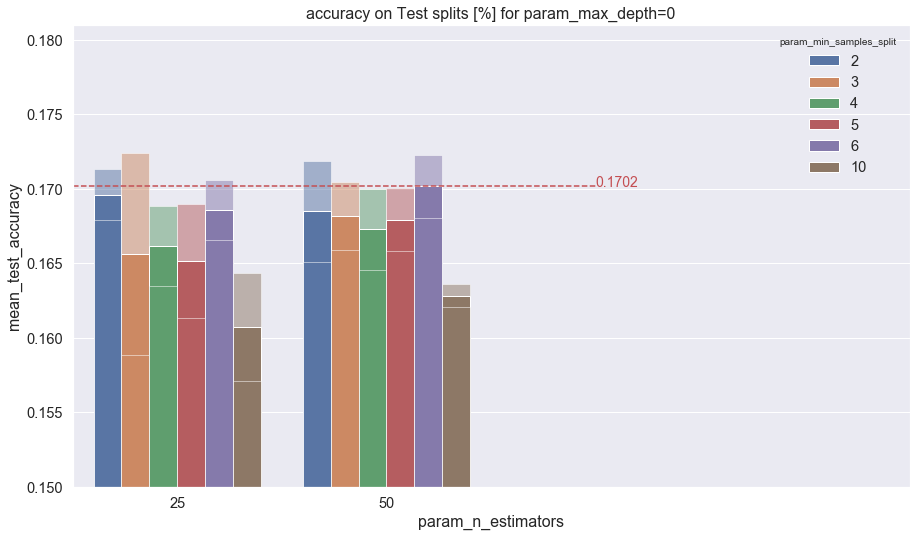

In [788]:
plot_res_test_split(df_res_rf_multi_cv, "accuracy", "param_n_estimators", 
                    "param_min_samples_split", y_min=0.15,
                    myFixedParam="param_max_depth",
                    myFixedValue=0)

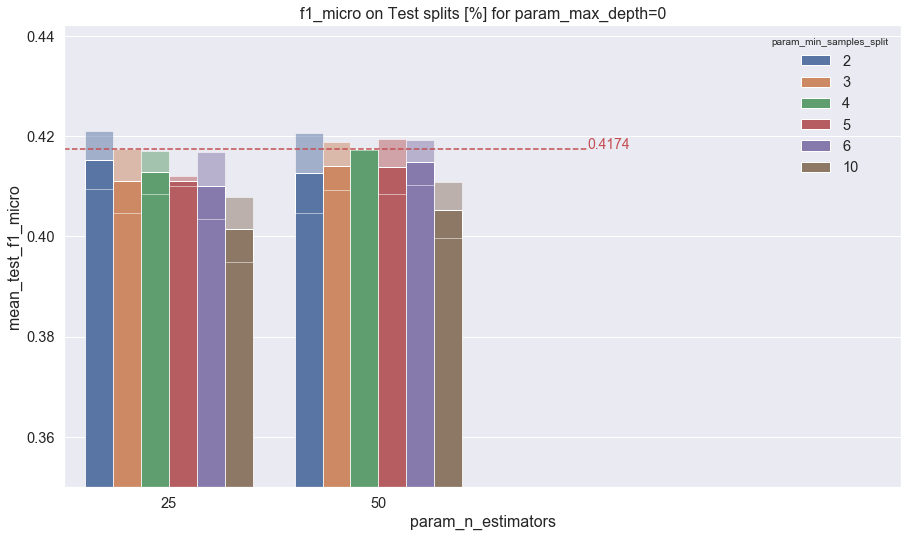

In [791]:
plot_res_test_split(df_res_rf_multi_cv, "f1_micro", "param_n_estimators", 
                    "param_min_samples_split", y_min=0.35,
                    myFixedParam="param_max_depth",
                    myFixedValue=0)

##### Best model
Best F1 score for Splits Test

- n_estimators: 50
- min_samples_split: 4
- max_depth: 0


In [747]:
g_clf_rf_multi_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=31, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Evaluation

In [748]:
precision_score(encoded_y_train, predicted_train, average='micro')

0.9994989352373794

In [749]:
precision_score(encoded_y_test, predicted_test, average='micro')

0.8218073822655918

In [750]:
recall_score(encoded_y_train, predicted_train, average='micro')

0.8561465002324833

In [751]:
recall_score(encoded_y_test, predicted_test, average='micro')

0.27742767115439704

In [752]:
f1_score(encoded_y_train, predicted_train, average='micro')

0.9222855821838637

In [753]:
f1_score(encoded_y_test, predicted_test, average='micro')

0.41481957383017454

##### Get the list of list predicted

In [754]:
list_tuple_ypred_train = mlb.inverse_transform(predicted_train)
list_tuple_ypred_test = mlb.inverse_transform(predicted_test)

In [755]:
len(list_tuple_ypred_train)

15032

In [756]:
predicted_train.shape

(15032, 201)

In [757]:
len(list_tuple_ypred_test)

3736

In [758]:
predicted_test.shape

(3736, 201)

##### Re-encode y pred lists

In [759]:
enc_sup_ypred_train = mlb_lda.transform(list_tuple_ypred_train)
enc_sup_ypred_test = mlb_lda.transform(list_tuple_ypred_test)

##### Create DafaFrames Train and Test using encoded y pred data using index of big dataFrame

Same index reference : 
    df_quest_cleaned.INDEX -> 2 encoded data y pred Dataframes.INDEX


In [760]:
enc_sup_ypred_train.shape

(15032, 8765)

In [761]:
df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(15032, 40)

In [762]:
df_enc_sup_ypred_train = pd.DataFrame(data=enc_sup_ypred_train,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_train.shape)

(15032, 8765)


In [763]:
enc_sup_ypred_test.shape

(3736, 8765)

In [764]:
df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(3736, 40)

In [765]:
df_enc_sup_ypred_test = pd.DataFrame(data=enc_sup_ypred_test,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_test.shape)

(3736, 8765)


##### Extract only flag most used & Train columns 

In [766]:
df_test = df_quest_cleaned.filter(items=[col_flag, "Train"])
print(df_test.shape)

(21208, 2)


##### Add y pred Train encoded data

In [767]:
df_test2 = df_test.join(df_enc_sup_ypred_train)
print(df_test2.shape)

(21208, 8767)


##### Add y pred Test data

In [768]:
df_test2.update(df_enc_sup_ypred_test)
print(df_test2.shape)

(21208, 8767)


##### Assign no Tags to samples/rows without most used tags

In [769]:
df_test2.isnull().sum().sum()

21386600

In [770]:
df_test2[df_test2.isna()] = 0

In [771]:
df_test2.isnull().sum().sum()

0

In [772]:
df_test2[df_test2[0].isna()].shape[0]

0

##### Extract encoded binarized array for y pred Train & Test to be evaluated

In [773]:
enc_sup_all_ypred_train = df_test2.loc[df_quest_cleaned["Train"] == True,
             range(0, enc_sup_ypred_train.shape[1])].values
enc_sup_all_ypred_train.shape

(16966, 8765)

In [774]:
enc_lda_y_train.shape

(16966, 8765)

In [775]:
enc_sup_all_ypred_test = df_test2.loc[df_quest_cleaned["Train"] == False,
             range(0, enc_sup_ypred_test.shape[1])].values
enc_sup_all_ypred_test.shape

(4242, 8765)

In [776]:
enc_lda_y_test.shape

(4242, 8765)

##### Evaluate on all data

In [777]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_sup_all_ypred_train,
    enc_lda_y_test, enc_sup_all_ypred_test, 
    t_1 - t_0, 
    t_count_vect_1 - t_count_vect_0 + t_tfidf_1 - t_tfidf_0 \
        + t_pred_1 - t_pred_0)

Nb. no Tags samples : 3138 over 16966 rows [18.50%]
Nb. no Tags samples : 2225 over 4242 rows [52.45%]


In [778]:
df_results = add_score(df_results, series_scores, 
          "RF_tags{}".format(int(nb_most_used_tags)))
df_results

add line


f1_splits_test  f1_splits_test_std  acc_train  acc_test  \
LDA_top50_tags10         0.141678            0.000771   0.000000  0.000000   
LDA_top50_tags1          0.139635            0.000250   0.016975  0.017445   
LDA_top50_tags2          0.162595            0.000955   0.006955  0.006129   
LDA_top50_tags3          0.171949            0.001617   0.002476  0.002357   
LDA_top50_tags4          0.173857            0.001200   0.000648  0.000236   
LDA_top50_tags5          0.172366            0.001016   0.000000  0.000000   
LDA_top50_tags6          0.165265            0.000587   0.000000  0.000000   
LDA_top25_tags10         0.136579            0.000297   0.000000  0.000000   
LDA_top25_tags1          0.137544            0.001813   0.015325  0.015559   
LDA_top25_tags2          0.161006            0.001770   0.006012  0.006129   
LDA_top25_tags3          0.169592            0.000736   0.002240  0.002593   
LDA_top25_tags4          0.168388            0.000125   0.000589  0.000471   
LDA_top25_tags5          0.164371            0.000361   0.000000  0.000000   
LDA_top25_tags6          0.157607            0.000213   0.000000  0.000000   
LDA_top100_tags10        0.144906            0.000992   0.000000  0.000000   
LDA_top100_tags1         0.144714            0.000586   0.017623  0.017209   
LDA_top100_tags2         0.169057            0.001304   0.007721  0.008722   
LDA_top100_tags3         0.176685            0.000645   0.002358  0.002593   
LDA_top100_tags4         0.178590            0.000106   0.000648  0.000236   
LDA_top100_tags5         0.174328            0.000957   0.000000  0.000000   
LDA_top100_tags6         0.168984            0.000282   0.000000  0.000000   
LDA_top200_tags10        0.145331            0.000695   0.000000  0.000000   
LDA_top200_tags1         0.143983            0.001266   0.018095  0.016502   
LDA_top200_tags2         0.166805            0.001331   0.008605  0.007779   
LDA_top200_tags3         0.173227            0.001203   0.002299  0.002122   
LDA_top200_tags4         0.176421            0.000314   0.000766  0.000471   
LDA_top200_tags5         0.172762            0.000399   0.000000  0.000000   
LDA_top200_tags6         0.167051            0.000280   0.000000  0.000000   
RF_tags51                0.555416            0.001766   0.142344  0.044319   
RF_tags73                0.589274            0.001212   0.163503  0.044790   
RF_tags100               0.603715            0.000460   0.184369  0.045026   
KNN_tags51               0.242916            0.002891   0.036367  0.025695   
RF_tags201               0.645616            0.002047   0.213604  0.043612   

                   pre_train  pre_test  rec_train  rec_test  f1_train  \
LDA_top50_tags10    0.091595  0.089321   0.310732  0.301648  0.141484   
LDA_top50_tags1     0.278793  0.273692   0.094579  0.092429  0.141243   
LDA_top50_tags2     0.201963  0.189769   0.137030  0.128175  0.163277   
LDA_top50_tags3     0.170419  0.161245   0.173442  0.163363  0.171917   
LDA_top50_tags4     0.150802  0.144743   0.204635  0.195526  0.173642   
LDA_top50_tags5     0.136261  0.133145   0.231129  0.224823  0.171446   
LDA_top50_tags6     0.123364  0.121326   0.251105  0.245840  0.165447   
LDA_top25_tags10    0.088023  0.085950   0.298614  0.290264  0.135967   
LDA_top25_tags1     0.275551  0.269213   0.093479  0.090916  0.139600   
LDA_top25_tags2     0.200961  0.196605   0.136350  0.132792  0.162467   
LDA_top25_tags3     0.168160  0.159987   0.171142  0.162089  0.169638   
LDA_top25_tags4     0.145733  0.139026   0.197756  0.187804  0.167805   
LDA_top25_tags5     0.130013  0.124422   0.220531  0.210095  0.163585   
LDA_top25_tags6     0.116989  0.113272   0.238128  0.229520  0.156897   
LDA_top100_tags10   0.093758  0.090806   0.318070  0.306663  0.144826   
LDA_top100_tags1    0.289579  0.279114   0.098238  0.094260  0.146707   
LDA_top100_tags2    0.209772  0.202381   0.142329  0.136693  0.169591   
LDA_top100_tags3    0.174918  0.166667   0.178021  0

##### Save

In [779]:
path_save = PATH_EXPORT_FOLDER + "df_results.csv"
df_results.to_csv(path_or_buf=path_save, sep=',')
print("All Results Saved here:\n{}".format(path_save))

All Results Saved here:
../../data/df_results.csv


###  KNN Multi-Tags : 201 Most Used Tags

#### Choose Most Used Tags

In [801]:
idx_most = 3

In [802]:
list_tags_most_used = list_list_most_used[idx_most]
col_flag = "flag_most_Tagged_{:.0f}".format(df_most.iloc[idx_most]["nb_min_used"])
print(col_flag)
nb_most_used_tags = df_most.iloc[idx_most]["nb_most_used_tags"]
len(list_tags_most_used)

flag_most_Tagged_40


201

#### Multi-label encoding

##### For output to predict, extract only most used Tags

In [803]:
# create list of list of Tags to be able to encode multi label outputs
print('\nFor train set...')  
list_list_tags_train = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == True) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_train[:10])

print('\nFor test set...')  
list_list_tags_test = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_test[:10])


For train set...
[['c#', 'sql', 'sql-server'], ['sql-server'], ['javascript', 'php', 'ajax'], ['android', 'amazon-s3'], ['sql'], ['php', 'laravel'], ['python'], ['java'], ['javascript', 'json', 'reactjs', 'object'], ['android']]

For test set...
[['ios', 'objective-c'], ['ios', 'swift'], ['c++', 'qt'], ['excel', 'vba', 'excel-vba'], ['android', 'gradle'], ['sql-server'], ['c#', 'asp.net', 'bootstrap-4'], ['javascript', 'reactjs'], ['python', 'django'], ['javascript', 'angular', 'typescript']]


##### Encoding output to predict

In [804]:
#y = [['tag3','tag1'],['tag1','tag0','tag2']]
mlb = MultiLabelBinarizer()
encoded_y_train = mlb.fit_transform(list_list_tags_train)
encoded_y_test = mlb.transform(list_list_tags_test)

In [805]:
encoded_y_train.shape

(15032, 201)

In [806]:
encoded_y_test.shape

(3736, 201)

#### Features preparation

In [678]:
# train counts
tf_1 = tf_vectorizer_sup_1.\
    fit_transform(df_quest_cleaned[(df_quest_cleaned.Train== True) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_train_counts_sup_1 = tf_1
X_train_counts_sup_1.shape

(13024, 1000)

In [807]:
# test counts
t_count_vect_0 = time.time()
X_test_counts_sup_1 = tf_vectorizer_sup_1.transform(
    df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
t_count_vect_1 = time.time()
X_test_counts_sup_1.shape

(3736, 1000)

In [808]:
# calculate tf-idf
tfidf_transformer_sup_1 = TfidfTransformer().fit(X_train_counts_sup_1)

In [809]:
# train
X_train_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_train_counts_sup_1)
X_train_tfidf_sup_1.shape

(15032, 1000)

In [810]:
# test
X_test_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_test_counts_sup_1)
X_test_tfidf_sup_1.shape

(3736, 1000)

#### Optim

In [811]:
clf_knn_multi_cv = KNeighborsClassifier(n_jobs=-1)

In [812]:
# Fixer les valeurs des hyperparamètres à tester
n_neighbors_range = [3, 5, 7]
score = ['accuracy', 'f1_micro', 'precision_micro', 'recall_micro']
# grille de paramètres
param_grid = {'n_neighbors': n_neighbors_range}
param_grid

{'n_neighbors': [3, 5, 7]}

In [813]:
# Créer  avec recherche d'hyperparamètre par validation croisée
g_clf_knn_multi_cv = model_selection.GridSearchCV(clf_knn_multi_cv,
param_grid, # hyperparamètres à tester
cv=cv,# nombre de folds de validation croisée
scoring=score, refit="f1_micro") # score à optimiser

# Optimiser ce classifieur sur le jeu d'entraînement
t_0 = time.time()
g_clf_knn_multi_cv.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_clf_knn_multi_cv.best_params_)

timing total: 1095.8754329681396 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 3}


In [814]:
df_res_knn_multi_cv = pd.DataFrame(data=g_clf_knn_multi_cv.cv_results_)
df_res_knn_multi_cv[df_res_knn_multi_cv["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/depre

KeyError: 'rank_test_score'

In [815]:
g_clf_knn_multi_cv.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

#### Save

In [816]:
save_gridsearchcv_sup(g_clf_knn_multi_cv, df_res_knn_multi_cv, "KNN")

n_neighbors
3
Results Saved here:
../../data/df_res_KNN_tags201_n_neighbors3.csv
Model Saved here:
../../data/model_KNN_tags201_n_neighbors3.pkl


#### Compare

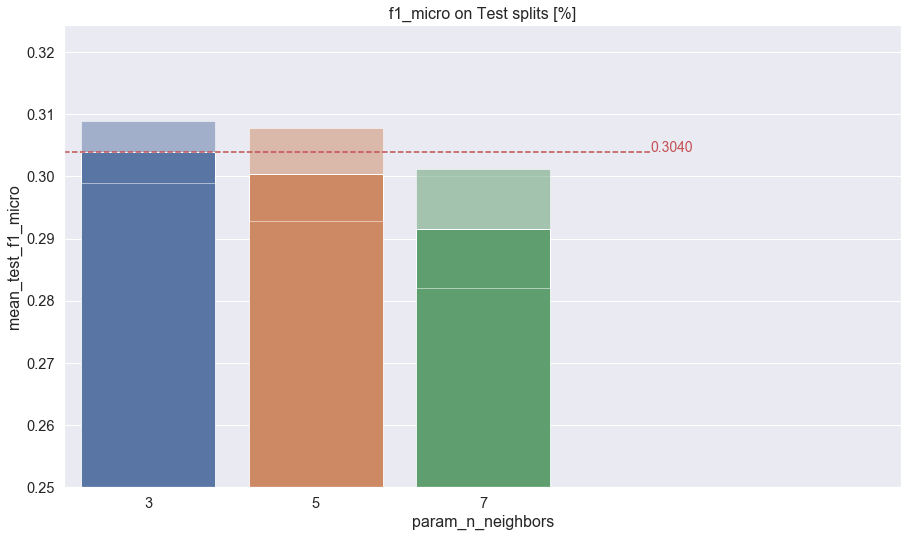

In [818]:
plot_res_test_split(df_res_knn_multi_cv, "f1_micro", "param_n_neighbors", 
                   y_min=0.25)

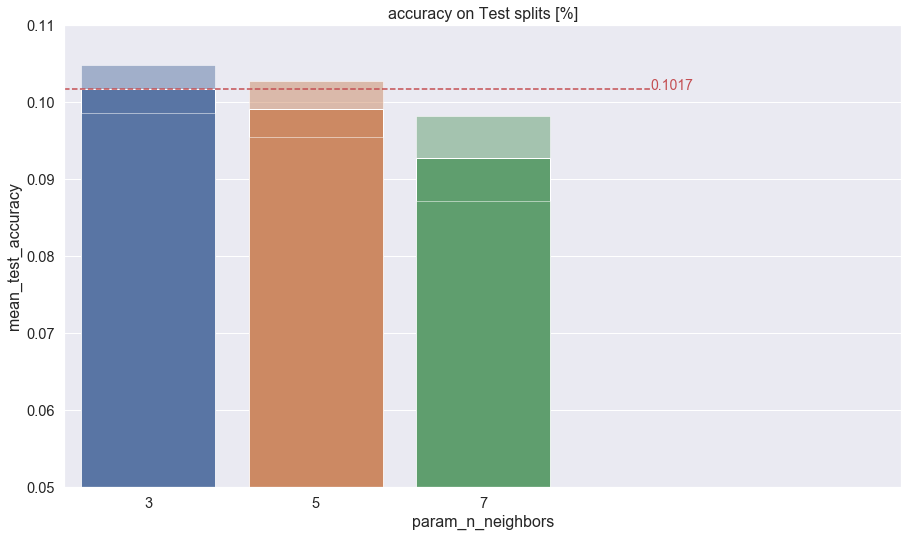

In [820]:
plot_res_test_split(df_res_knn_multi_cv, "accuracy", "param_n_neighbors", 
                   y_min=0.05)

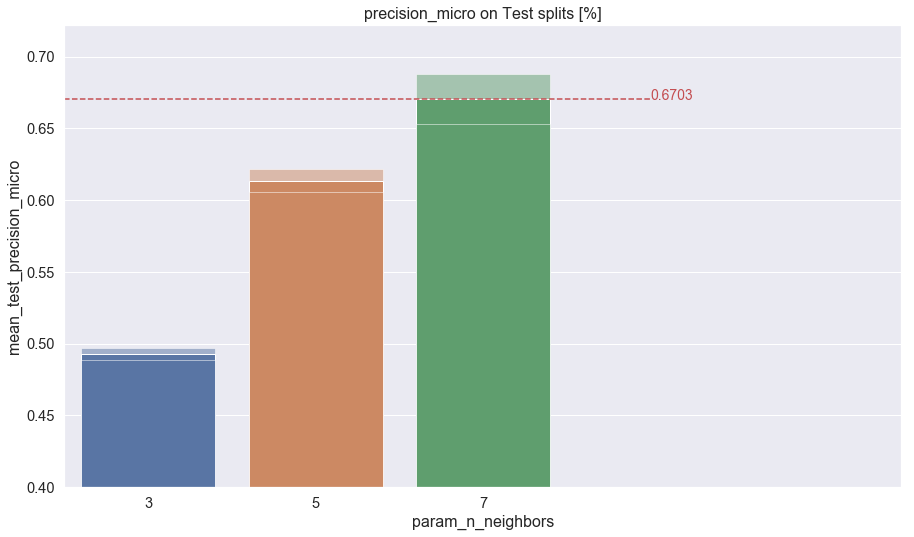

In [821]:
plot_res_test_split(df_res_knn_multi_cv, "precision_micro", "param_n_neighbors", 
                   y_min=0.4)

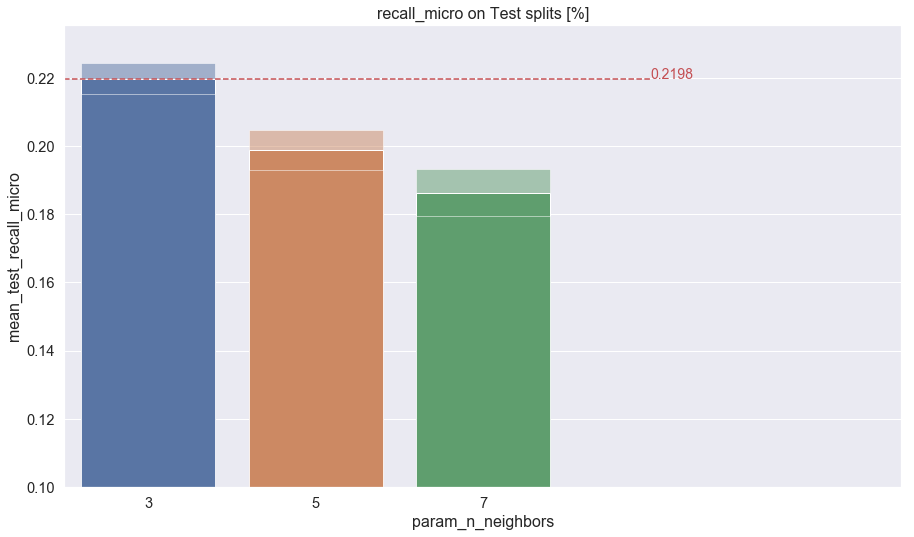

In [823]:
plot_res_test_split(df_res_knn_multi_cv, "recall_micro", "param_n_neighbors", 
                   y_min=0.1)

##### Eval best estimator :

In [824]:
print("Train Score :", 
      g_clf_knn_multi_cv.best_estimator_.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      g_clf_knn_multi_cv.best_estimator_.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.24906865353911656
Test Score :  0.10653104925053533


In [825]:
predicted_train = g_clf_knn_multi_cv.best_estimator_.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
t_pred_0 = time.time()
predicted_test = g_clf_knn_multi_cv.best_estimator_.predict(X_test_tfidf_sup_1)
t_pred_1 = time.time()
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.006448928852279316
Test hamming loss : 0.009393610107918652


In [826]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 5056 over 15032 rows [33.63%]
Nb. no Tags samples : 1401 over 3736 rows [37.50%]


1401

#### Evaluation

In [827]:
precision_score(encoded_y_train, predicted_train, average='micro')

0.8032493558545662

In [828]:
precision_score(encoded_y_test, predicted_test, average='micro')

0.48872180451127817

In [829]:
recall_score(encoded_y_train, predicted_train, average='micro')

0.4014092063378519

In [830]:
recall_score(encoded_y_test, predicted_test, average='micro')

0.22343168146662848

In [831]:
f1_score(encoded_y_train, predicted_train, average='micro')

0.5353080060098733

In [832]:
f1_score(encoded_y_test, predicted_test, average='micro')

0.30666404560644783

##### Get the list of list predicted

In [833]:
list_tuple_ypred_train = mlb.inverse_transform(predicted_train)
list_tuple_ypred_test = mlb.inverse_transform(predicted_test)

In [834]:
len(list_tuple_ypred_train)

15032

In [835]:
predicted_train.shape

(15032, 201)

In [836]:
len(list_tuple_ypred_test)

3736

In [837]:
predicted_test.shape

(3736, 201)

##### Re-encode y pred lists

In [838]:
enc_sup_ypred_train = mlb_lda.transform(list_tuple_ypred_train)
enc_sup_ypred_test = mlb_lda.transform(list_tuple_ypred_test)

##### Create DafaFrames Train and Test using encoded y pred data using index of big dataFrame

Same index reference : 
    df_quest_cleaned.INDEX -> 2 encoded data y pred Dataframes.INDEX


In [839]:
enc_sup_ypred_train.shape

(15032, 8765)

In [840]:
df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(15032, 40)

In [841]:
df_enc_sup_ypred_train = pd.DataFrame(data=enc_sup_ypred_train,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_train.shape)

(15032, 8765)


In [842]:
enc_sup_ypred_test.shape

(3736, 8765)

In [843]:
df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(3736, 40)

In [844]:
df_enc_sup_ypred_test = pd.DataFrame(data=enc_sup_ypred_test,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_test.shape)

(3736, 8765)


##### Extract only flag most used & Train columns 

In [845]:
df_test = df_quest_cleaned.filter(items=[col_flag, "Train"])
print(df_test.shape)

(21208, 2)


##### Add y pred Train encoded data

In [846]:
df_test2 = df_test.join(df_enc_sup_ypred_train)
print(df_test2.shape)

(21208, 8767)


##### Add y pred Test data

In [847]:
df_test2.update(df_enc_sup_ypred_test)
print(df_test2.shape)

(21208, 8767)


##### Assign no Tags to samples/rows without most used tags

In [848]:
df_test2.isnull().sum().sum()

21386600

In [849]:
df_test2[df_test2.isna()] = 0

In [850]:
df_test2.isnull().sum().sum()

0

In [851]:
df_test2[df_test2[0].isna()].shape[0]

0

##### Extract encoded binarized array for y pred Train & Test to be evaluated

In [852]:
enc_sup_all_ypred_train = df_test2.loc[df_quest_cleaned["Train"] == True,
             range(0, enc_sup_ypred_train.shape[1])].values
enc_sup_all_ypred_train.shape

(16966, 8765)

In [853]:
enc_lda_y_train.shape

(16966, 8765)

In [854]:
enc_sup_all_ypred_test = df_test2.loc[df_quest_cleaned["Train"] == False,
             range(0, enc_sup_ypred_test.shape[1])].values
enc_sup_all_ypred_test.shape

(4242, 8765)

In [855]:
enc_lda_y_test.shape

(4242, 8765)

##### Evaluate on all data

In [858]:
t_count_vect_1 - t_count_vect_0

12.42576289176941

In [859]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_sup_all_ypred_train,
    enc_lda_y_test, enc_sup_all_ypred_test, 
    t_1-t_0, 
    t_count_vect_1 - t_count_vect_0 + t_pred_1-t_pred_0)

Nb. no Tags samples : 6990 over 16966 rows [41.20%]
Nb. no Tags samples : 1907 over 4242 rows [44.96%]


In [903]:
df_results = add_score(df_results, series_scores, 
          "KNN_tags{}".format(int(nb_most_used_tags)))

update line


In [904]:
df_results

f1_splits_test  f1_splits_test_std  acc_train  acc_test  \
LDA_top50_tags10         0.141678            0.000771   0.000000  0.000000   
LDA_top50_tags1          0.139635            0.000250   0.016975  0.017445   
LDA_top50_tags2          0.162595            0.000955   0.006955  0.006129   
LDA_top50_tags3          0.171949            0.001617   0.002476  0.002357   
LDA_top50_tags4          0.173857            0.001200   0.000648  0.000236   
LDA_top50_tags5          0.172366            0.001016   0.000000  0.000000   
LDA_top50_tags6          0.165265            0.000587   0.000000  0.000000   
LDA_top25_tags10         0.136579            0.000297   0.000000  0.000000   
LDA_top25_tags1          0.137544            0.001813   0.015325  0.015559   
LDA_top25_tags2          0.161006            0.001770   0.006012  0.006129   
LDA_top25_tags3          0.169592            0.000736   0.002240  0.002593   
LDA_top25_tags4          0.168388            0.000125   0.000589  0.000471   
LDA_top25_tags5          0.164371            0.000361   0.000000  0.000000   
LDA_top25_tags6          0.157607            0.000213   0.000000  0.000000   
LDA_top100_tags10        0.144906            0.000992   0.000000  0.000000   
LDA_top100_tags1         0.144714            0.000586   0.017623  0.017209   
LDA_top100_tags2         0.169057            0.001304   0.007721  0.008722   
LDA_top100_tags3         0.176685            0.000645   0.002358  0.002593   
LDA_top100_tags4         0.178590            0.000106   0.000648  0.000236   
LDA_top100_tags5         0.174328            0.000957   0.000000  0.000000   
LDA_top100_tags6         0.168984            0.000282   0.000000  0.000000   
LDA_top200_tags10        0.145331            0.000695   0.000000  0.000000   
LDA_top200_tags1         0.143983            0.001266   0.018095  0.016502   
LDA_top200_tags2         0.166805            0.001331   0.008605  0.007779   
LDA_top200_tags3         0.173227            0.001203   0.002299  0.002122   
LDA_top200_tags4         0.176421            0.000314   0.000766  0.000471   
LDA_top200_tags5         0.172762            0.000399   0.000000  0.000000   
LDA_top200_tags6         0.167051            0.000280   0.000000  0.000000   
RF_tags51                0.555416            0.001766   0.142344  0.044319   
RF_tags73                0.589274            0.001212   0.163503  0.044790   
RF_tags100               0.603715            0.000460   0.184369  0.045026   
RF_tags201               0.645616            0.002047   0.213604  0.043612   
KNN_tags201              0.350560            0.002557   0.067134  0.030410   

                   pre_train  pre_test  rec_train  rec_test  f1_train  \
LDA_top50_tags10    0.091595  0.089321   0.310732  0.301648  0.141484   
LDA_top50_tags1     0.278793  0.273692   0.094579  0.092429  0.141243   
LDA_top50_tags2     0.201963  0.189769   0.137030  0.128175  0.163277   
LDA_top50_tags3     0.170419  0.161245   0.173442  0.163363  0.171917   
LDA_top50_tags4     0.150802  0.144743   0.204635  0.195526  0.173642   
LDA_top50_tags5     0.136261  0.133145   0.231129  0.224823  0.171446   
LDA_top50_tags6     0.123364  0.121326   0.251105  0.245840  0.165447   
LDA_top25_tags10    0.088023  0.085950   0.298614  0.290264  0.135967   
LDA_top25_tags1     0.275551  0.269213   0.093479  0.090916  0.139600   
LDA_top25_tags2     0.200961  0.196605   0.136350  0.132792  0.162467   
LDA_top25_tags3     0.168160  0.159987   0.171142  0.162089  0.169638   
LDA_top25_tags4     0.145733  0.139026   0.197756  0.187804  0.167805   
LDA_top25_tags5     0.130013  0.124422   0.220531  0.210095  0.163585   
LDA_top25_tags6     0.116989  0.113272   0.238128  0.229520  0.156897   
LDA_top100_tags10   0.093758  0.090806   0.318070  0.306663  0.144826   
LDA_top100_tags1    0.289579  0.279114   0.098238  0.094260  0.146707   
LDA_top100_tags2    0.209772  0.202381   0.142329  0.136693  0.169591   
LDA_top100_tags3    0.174918  0.166667   0.178021  0

##### Save

In [902]:
path_save = PATH_EXPORT_FOLDER + "df_results.csv"
df_results.to_csv(path_or_buf=path_save, sep=',')
print("All Results Saved here:\n{}".format(path_save))

All Results Saved here:
../../data/df_results.csv


### Compare on global training set

This comparison show how the model is well trained on global 

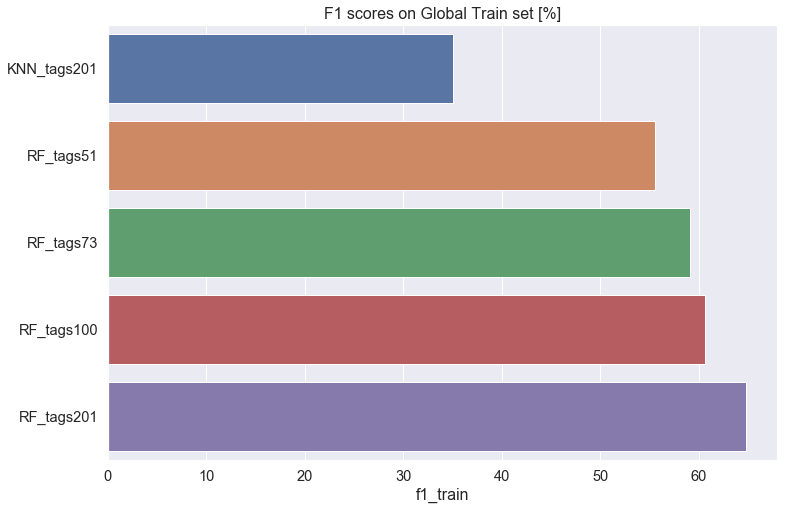

In [888]:
fig = plt.figure(figsize=(12, 8))
plt.title("F1 scores on Global Train set [%]")
ax = sns.barplot(
    y=df_results.filter(regex='(RF)|(KNN)', 
        axis=0).sort_values(by="f1_train").index,
    x=100*df_results.filter(regex='(RF)|(KNN)', 
        axis=0).sort_values(by="f1_train")["f1_train"], orient="h")
#ax.set_xlim(left=10)

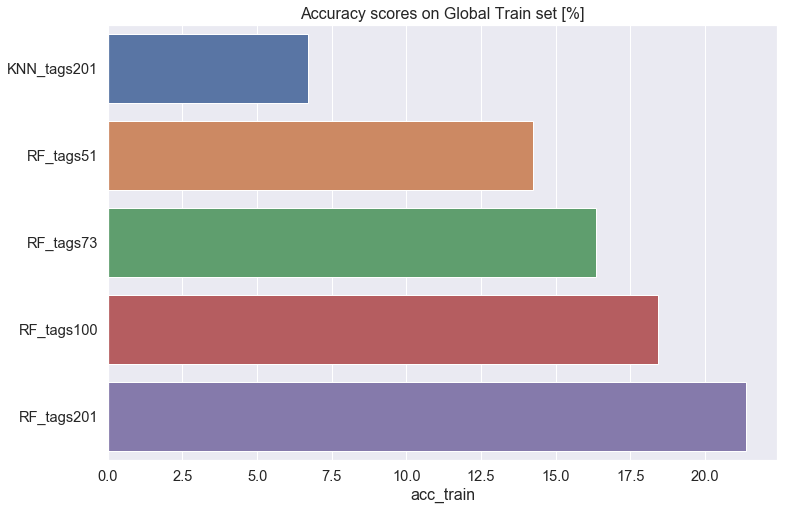

In [889]:
fig = plt.figure(figsize=(12, 8))
plt.title("Accuracy scores on Global Train set [%]")
ax = sns.barplot(
    y=df_results.filter(regex='(RF)|(KNN)', 
        axis=0).sort_values(by="acc_train").index,
    x=100*df_results.filter(regex='(RF)|(KNN)', 
        axis=0).sort_values(by="acc_train")["acc_train"], orient="h")

##### Best trained model

- RF_tags201 for F1 score & accuracy


## Timings

### For Training

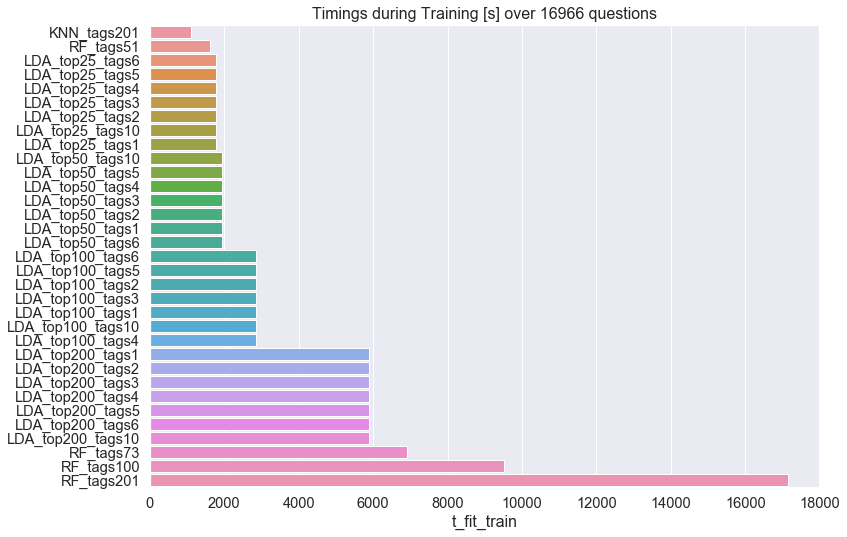

In [907]:
fig = plt.figure(figsize=(12, 8.5))
plt.title("Timings during Training [s] over {} questions".format(
    df_quest_cleaned[df_quest_cleaned["Train"] == True].shape[0]))
ax = sns.barplot(
    y=df_results.sort_values(by="t_fit_train").index,
    x=df_results.sort_values(by="t_fit_train")["t_fit_train"], orient="h")
#ax.set_xlim(left=10)

Optimization is included in Training timing : 
- For LDA models : optimization over 6 differents parameters sets
- For RF models : optimization over 72 differents parameters sets
- For KNN models : optimization over 3 differents parameters sets

### For Prediction

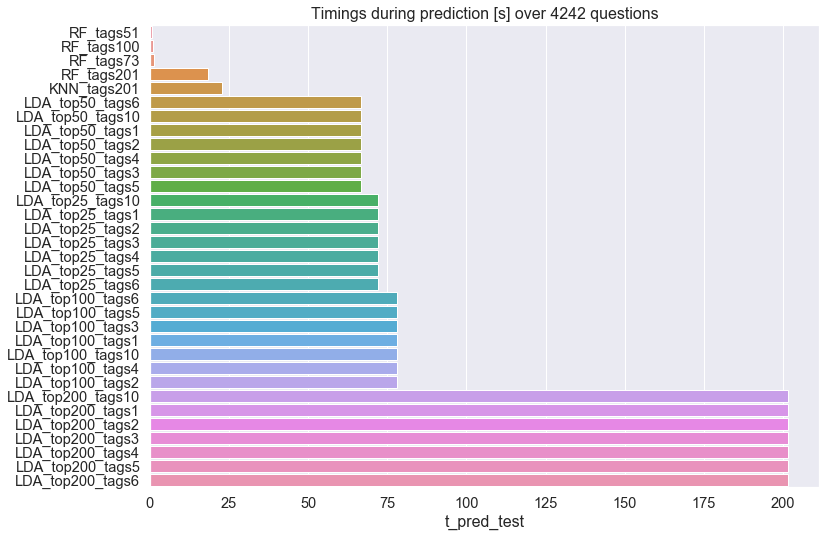

In [908]:
fig = plt.figure(figsize=(12, 8.5))
plt.title("Timings during prediction [s] over {} questions".format(
    df_quest_cleaned[df_quest_cleaned["Train"] == False].shape[0]))
ax = sns.barplot(
    y=df_results.sort_values(by="t_pred_test").index,
    x=df_results.sort_values(by="t_pred_test")["t_pred_test"], orient="h")
#ax.set_xlim(left=10)

## Compare on Test Set

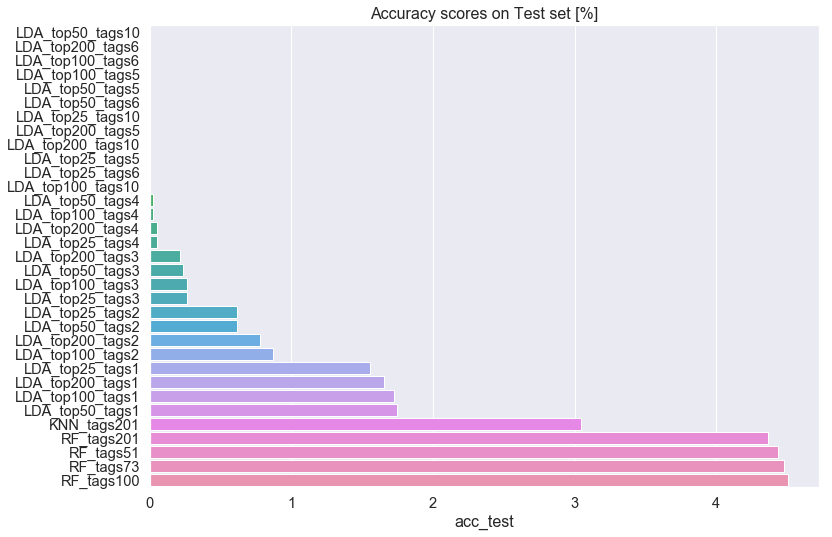

In [879]:
fig = plt.figure(figsize=(12, 8.5))
plt.title("Accuracy scores on Test set [%]")
sns.barplot(y=df_results.sort_values(by="acc_test").index, 
            x=100*df_results.sort_values(by="acc_test")["acc_test"], orient="h")

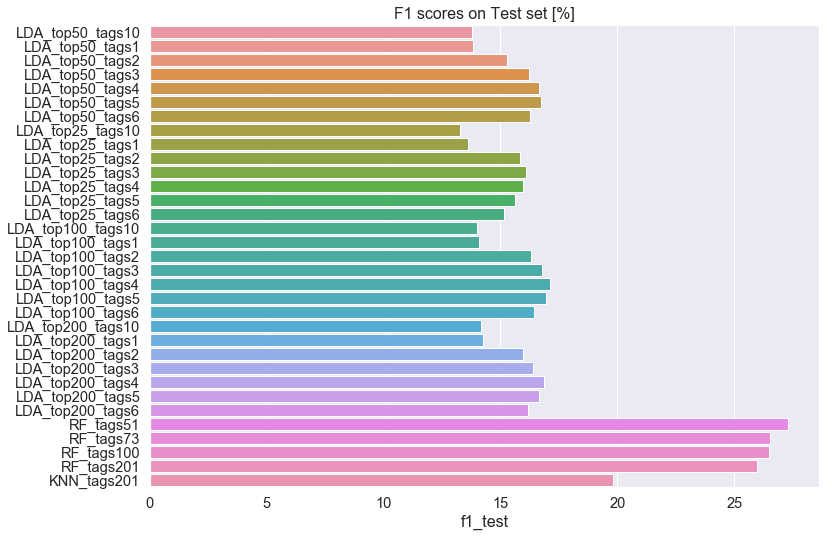

In [882]:
fig = plt.figure(figsize=(12, 8.5))
plt.title("F1 scores on Test set [%]")
sns.barplot(y=df_results.index, x=100*df_results["f1_test"], orient="h")

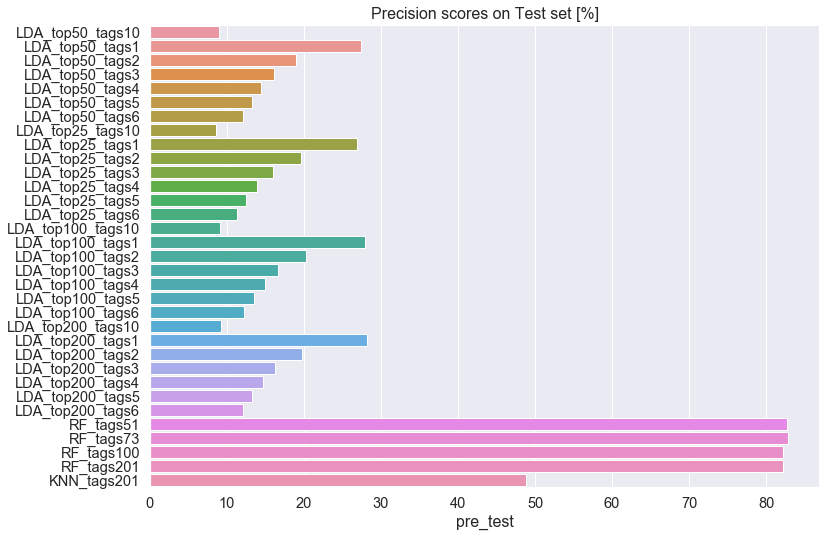

In [880]:
fig = plt.figure(figsize=(12, 8.5))
plt.title("Precision scores on Test set [%]")
sns.barplot(y=df_results.index, x=100*df_results["pre_test"], orient="h")

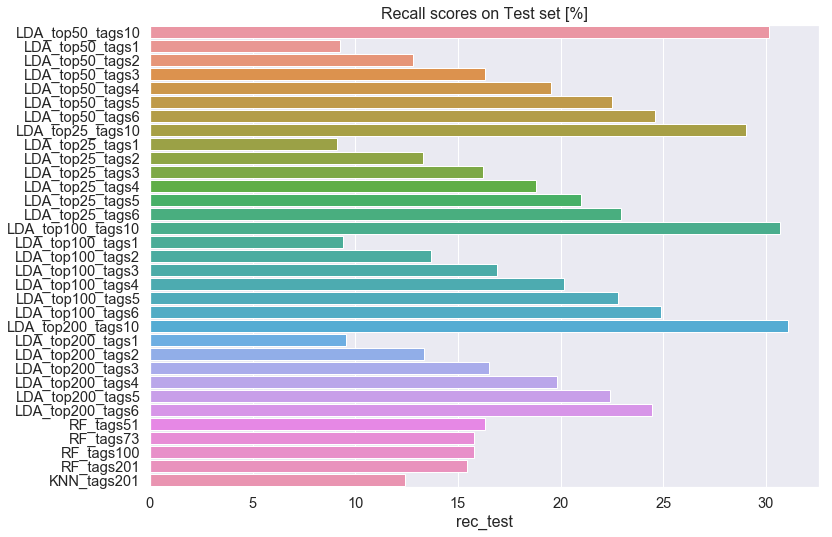

In [881]:
fig = plt.figure(figsize=(12, 8.5))
plt.title("Recall scores on Test set [%]")
sns.barplot(y=df_results.index, x=100*df_results["rec_test"], orient="h")

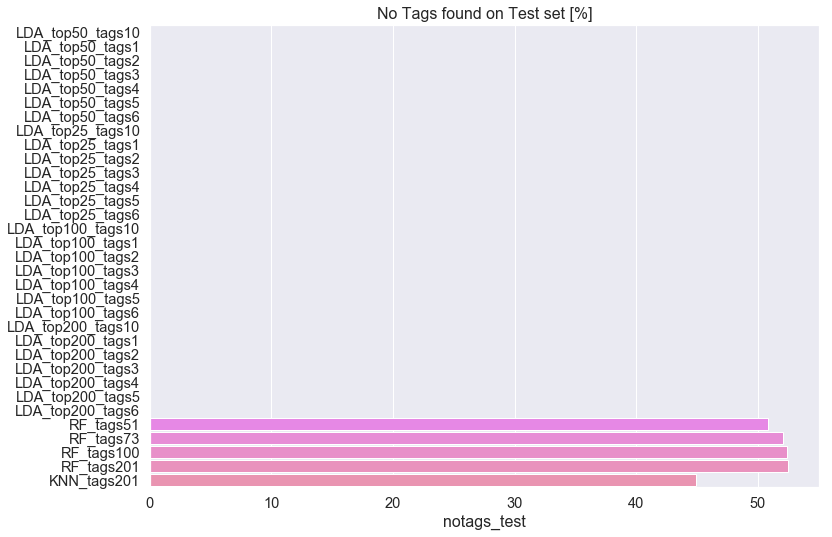

In [883]:
fig = plt.figure(figsize=(12, 8.5))
plt.title("No Tags found on Test set [%]")
sns.barplot(y=df_results.index, x=100*df_results["notags_test"], orient="h")

##### Best model on Test

- All Unsupervised Random Forest models

- If we take the best trained modele, his results are good enough on Test 
    - best F1 score on test : RF_tags51 : 27%
    - RF_tags201 F1 score on test : 26%
 => same "generalization" capabilities on this test data.

## [not relevant] Other comparison & models

### RandomForest nb Most Used Tags choice : not relevant


This comparison is not relevant because we don't compare over the same Splits.

Also, the number of Tags to predicted is not the same for each cases

#### Load best models

In [584]:
# 51 tags
str_path = PATH_EXPORT_FOLDER + \
    'df_res_RF_tags51_max_depthNone_max_features31_min_samples_split2_n_estimators25.csv'
df_res_rf_multi_cv_tags51 = pd.read_csv(str_path, sep=',')
df_res_rf_multi_cv_tags51 = df_res_rf_multi_cv_tags51[\
    df_res_rf_multi_cv_tags51["rank_test_f1_micro"] == 1]
# 73 tags
str_path = PATH_EXPORT_FOLDER + \
    'df_res_RF_tags73_max_depthNone_max_features31_min_samples_split3_n_estimators50.csv'
df_res_rf_multi_cv_tags73 = pd.read_csv(str_path, sep=',')
df_res_rf_multi_cv_tags73 = df_res_rf_multi_cv_tags73[\
    df_res_rf_multi_cv_tags73["rank_test_f1_micro"] == 1]
# 100 tags
str_path = PATH_EXPORT_FOLDER + \
    'df_res_RF_tags100_max_depth150_max_features31_min_samples_split2_n_estimators25.csv'
df_res_rf_multi_cv_tags100 = pd.read_csv(str_path, sep=',')
df_res_rf_multi_cv_tags100 = df_res_rf_multi_cv_tags100[\
    df_res_rf_multi_cv_tags100["rank_test_f1_micro"] == 1]
df_res_rf_multi_cv_best = \
    df_res_rf_multi_cv_tags51.append(df_res_rf_multi_cv_tags73)
df_res_rf_multi_cv_best = \
    df_res_rf_multi_cv_best.append(df_res_rf_multi_cv_tags100)
df_res_rf_multi_cv_best["nb_most_tags"] = [51, 73, 100]
df_res_rf_multi_cv_best.T

0   \
Unnamed: 0                                                                    0   
mean_fit_time                                                           5.41777   
std_fit_time                                                           0.125344   
mean_score_time                                                          1.3229   
std_score_time                                                       0.00541054   
param_max_depth                                                             NaN   
param_max_features                                                           31   
param_min_samples_split                                                       2   
param_n_estimators                                                           25   
params                        {'max_depth': None, 'max_features': 31, 'min_s...   
split0_test_accuracy                                                   0.311324   
split1_test_accuracy                                                   0.317466   
split2_test_accuracy                                                   0.314395   
mean_test_accuracy                                                     0.314395   
std_test_accuracy                                                    0.00250748   
rank_test_accuracy                                                            1   
split0_train_accuracy                                                  0.979845   
split1_train_accuracy                                                  0.980996   
split2_train_accuracy                                                  0.978981   
mean_train_accuracy                                                     0.97994   
std_train_accuracy                                                  0.000825638   
split0_test_f1_micro                                                   0.552798   
split1_test_f1_micro                                                   0.561929   
split2_test_f1_micro                                                   0.563097   
mean_test_f1_micro                                                     0.559275   
std_test_f1_micro                                                    0.00460438   
rank_test_f1_micro                                                            1   
split0_train_f1_micro                                                  0.992256   
split1_train_f1_micro                                                  0.992484   
split2_train_f1_micro                                                  0.991861   
mean_train_f1_micro                                                      0.9922   
std_train_f1_micro                                                  0.000257241   
split0_test_precision_micro                                            0.855856   
split1_test_precision_micro                                            0.852588   
split2_test_precision_micro                                            0.840204   
mean_test_precision_micro                                              0.849549   
std_test_precision_micro                                             0.00674157   
rank_test_precision_micro                                                    49   
split0_train_precision_micro                                           0.999804   
split1_train_precision_micro                                            0.99974   
split2_train_precision_micro                                            0.99987   
mean_train_precision_micro                                             0.999805   
std_train_precision_micro                                           5.29617e-05   
split0_test_recall_micro                                               0.408241   
split1_test_recall_micro                                               0.419065   
split2_test_recall_micro                                               0.423442   
mean_test_recall_micro                                                 0.416916   
std_test_recall_micro                                                0.00638922   
rank_test_

#### Compare

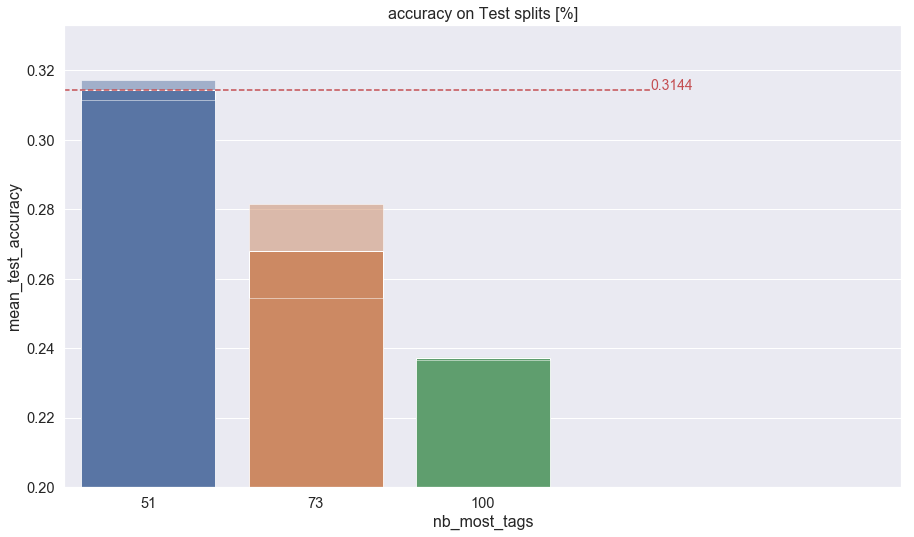

In [585]:
plot_res_test_split(df_res_rf_multi_cv_best, "accuracy", "nb_most_tags",
                   y_min=0.2)

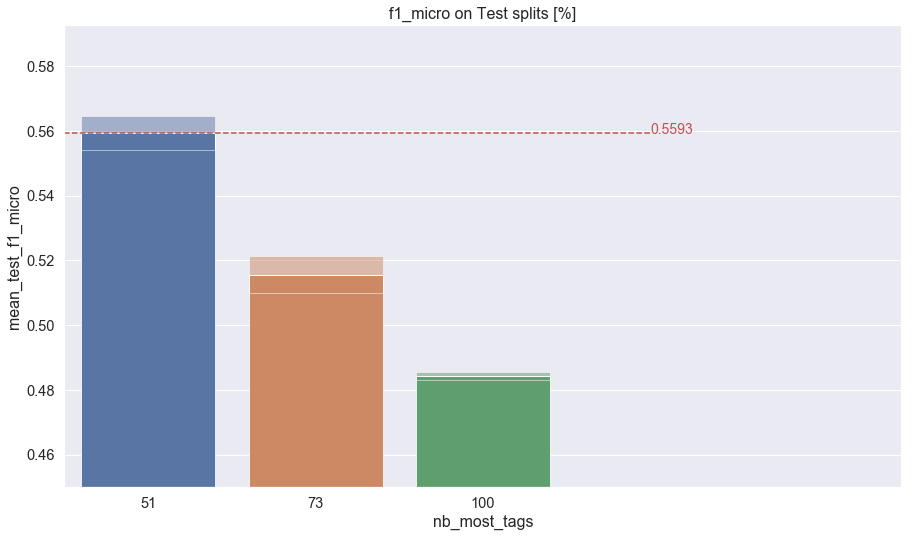

In [586]:
plot_res_test_split(df_res_rf_multi_cv_best, "f1_micro", "nb_most_tags",
                   y_min=0.45)

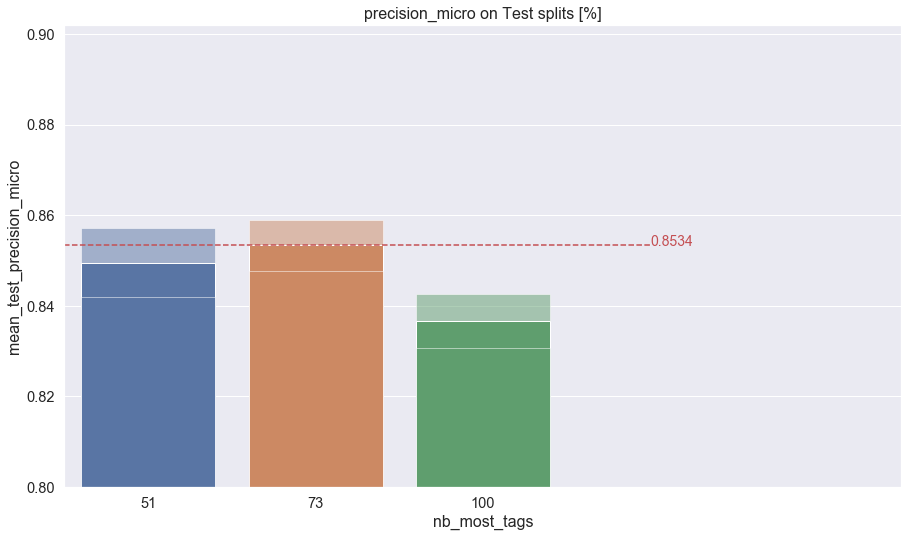

In [587]:
plot_res_test_split(df_res_rf_multi_cv_best, "precision_micro", "nb_most_tags",
                   y_min=0.8)

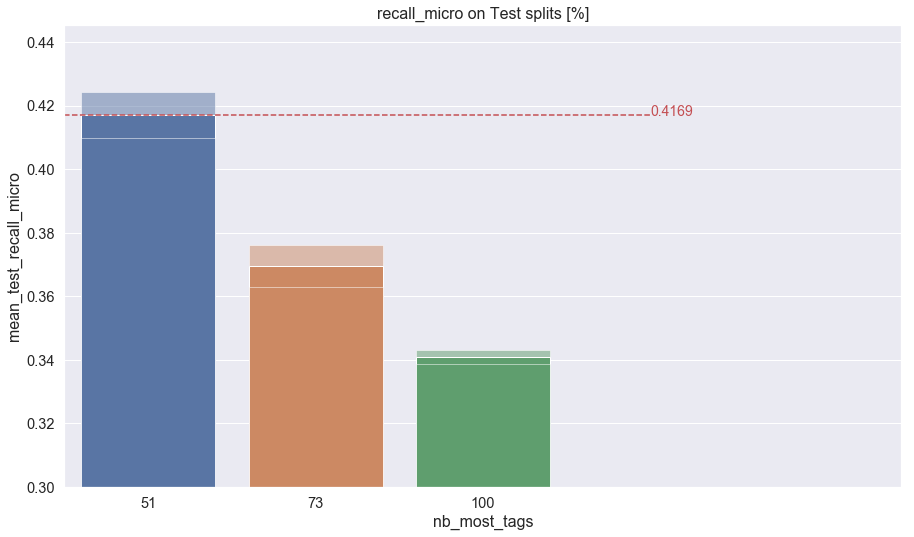

In [588]:
plot_res_test_split(df_res_rf_multi_cv_best, "recall_micro", "nb_most_tags",
                   y_min=0.3)

##### Best model
Best F1 & Accuracy for Splits Test
- Nb most used tags : 51
- n_estimators: 25
- min_samples_split: 2
- max_depth: None


### SGDClassifier OneVsRestClassifier

In [644]:
#clf_sgd_multi_1 = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2',
#                        alpha=1e-3, random_state=0,
#                        max_iter=5, tol=None), n_jobs=-1)
#clf_sgd_multi_1.fit(X_train_tfidf_sup_1, encoded_y_train)

In [645]:
#10.0**-np.arange(1,7)

#### First try

In [646]:
#Train Score :  0.6276808312241907 Test Score :  0.17474693660095897
clf_sgd_multi_1 = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2',
                    alpha=1e-6, 
                    max_iter = np.ceil(10**6 / X_train_tfidf_sup_1.shape[0]),
                    random_state=0, n_jobs=-1), n_jobs=-1)
t_0 = time.time()
clf_sgd_multi_1.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))

timing total: 7.024963140487671 s


In [647]:
print("Train Score :", 
      clf_sgd_multi_1.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      clf_sgd_multi_1.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.6712223587223587
Test Score :  0.30626520681265207


In [648]:
predicted_train = clf_sgd_multi_1.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
    
predicted_test = clf_sgd_multi_1.predict(X_test_tfidf_sup_1)
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.007643505805270511
Test hamming loss : 0.022106531176947664


In [649]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 1284 over 13024 rows [9.86%]
Nb. no Tags samples : 704 over 3288 rows [21.41%]


704

In [650]:
np.nonzero(predicted_test.sum(axis=1))[0].shape[0] / predicted_test.shape[0]

0.7858880778588808

#### Optim OneVsRestClassifier(SGDClassifier)

In [651]:
# Choisir un score à optimiser
#score = 'r2'
#score ='neg_mean_squared_error'
# Choisir des jeux train/test fixe
random_state = 0
n_splits = 3
test_size=0.2

# preparation des splits : choix de splits aléatoires de meme taille
cv = model_selection.ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)


In [652]:
clf_sgd_multi_cv = OneVsRestClassifier(SGDClassifier(random_state=0, n_jobs=-1),
                                       n_jobs=-1)

In [653]:
# Fixer les valeurs des hyperparamètres à tester


'''
nb_iter_ideal = np.ceil(10**6 / X_train_tfidf_sup_1.shape[0])
max_iter_range = [np.ceil(nb_iter_ideal/3), nb_iter_ideal, nb_iter_ideal*3]
alpha_range = 10.0**-np.arange(1,7)
loss_range = ['hinge','log']
penalty_range = ['l2', 'l1', 'elasticnet']
'''
#test 0.245973
#{'estimator__alpha': 1e-05, 'estimator__loss': 'log', 'estimator__max_iter': 23.0, 'estimator__penalty': 'l1'}
#Train Score : 0.4661500528355055
#Test Score :  0.25387433079740773
#Nb. no Tags samples : 2740 over 14195 rows [19.30%]
#Nb. no Tags samples : 982 over 3549 rows [27.67%]

#0.251145
#Train Score : 0.4661500528355055 
#Test Score :  0.25387433079740773
#Nb. no Tags samples : 2740 over 14195 rows [19.30%]
#Nb. no Tags samples : 982 over 3549 rows [27.67%]
    
max_iter_range = [23]
alpha_range = [1e-05]
loss_range = ['log']
penalty_range = ['l1']


# grille de paramètres
param_grid = {'estimator__max_iter': max_iter_range, 
              'estimator__loss': loss_range, 
              'estimator__alpha': alpha_range, 
              'estimator__penalty': penalty_range}
param_grid

{'estimator__max_iter': [23],
 'estimator__loss': ['log'],
 'estimator__alpha': [1e-05],
 'estimator__penalty': ['l1']}

In [654]:
# Créer  avec recherche d'hyperparamètre par validation croisée
g_clf_sgd_multi_cv = model_selection.GridSearchCV(clf_sgd_multi_cv,
param_grid, # hyperparamètres à tester
cv=cv) # nombre de folds de validation croisée
#scoring=score # score à optimiser)


# Optimiser ce classifieur sur le jeu d'entraînement
# clf.fit(X_train, y_train)
t_0 = time.time()
g_clf_sgd_multi_cv.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_clf_sgd_multi_cv.best_params_)

timing total: 10.596118927001953 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'estimator__alpha': 1e-05, 'estimator__loss': 'log', 'estimator__max_iter': 23, 'estimator__penalty': 'l1'}


In [655]:
df_res_sgd_multi_cv = pd.DataFrame(data=g_clf_sgd_multi_cv.cv_results_)
df_res_sgd_multi_cv[df_res_sgd_multi_cv["rank_test_score"]<10].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

0
mean_fit_time                                                        2.42061
std_fit_time                                                       0.0176434
mean_score_time                                                    0.0193535
std_score_time                                                   0.000902826
param_estimator__alpha                                                 1e-05
param_estimator__loss                                                    log
param_estimator__max_iter                                                 23
param_estimator__penalty                                                  l1
params                     {'estimator__alpha': 1e-05, 'estimator__loss':...
split0_test_score                                                   0.330902
split1_test_score                                                   0.327831
split2_test_score                                                   0.316315
mean_test_score                                                     0.325016
std_test_score                                                    0.00627913
rank_test_score                                                            1
split0_train_score                                                  0.615606
split1_train_score                                                  0.612727
split2_train_score                                                  0.617814
mean_train_score                                                    0.615382
std_train_score                                                   0.00208273

In [656]:
g_clf_sgd_multi_cv.best_estimator_.get_params()

{'estimator__alpha': 1e-05,
 'estimator__average': False,
 'estimator__class_weight': None,
 'estimator__early_stopping': False,
 'estimator__epsilon': 0.1,
 'estimator__eta0': 0.0,
 'estimator__fit_intercept': True,
 'estimator__l1_ratio': 0.15,
 'estimator__learning_rate': 'optimal',
 'estimator__loss': 'log',
 'estimator__max_iter': 23,
 'estimator__n_iter': None,
 'estimator__n_iter_no_change': 5,
 'estimator__n_jobs': -1,
 'estimator__penalty': 'l1',
 'estimator__power_t': 0.5,
 'estimator__random_state': 0,
 'estimator__shuffle': True,
 'estimator__tol': None,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': SGDClassifier(alpha=1e-05, average=False, class_weight=None,
        early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
        l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=23,
        n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l1',
        power_t=0.5, random_state=0, shuf

##### Eval best estimator :

In [657]:
print("Train Score :", 
      g_clf_sgd_multi_cv.best_estimator_.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      g_clf_sgd_multi_cv.best_estimator_.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.5535933660933661
Test Score :  0.3451946472019465


In [658]:
predicted_train = g_clf_sgd_multi_cv.best_estimator_.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
    
predicted_test = g_clf_sgd_multi_cv.best_estimator_.predict(X_test_tfidf_sup_1)
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.011306426747603219
Test hamming loss : 0.019739039167978627


In [659]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 2245 over 13024 rows [17.24%]
Nb. no Tags samples : 809 over 3288 rows [24.60%]


809

#### Evaluation
Method : Check if real Tags are into predicted Tags

In [660]:
encoded_y_train[0,:] & predicted_train[0,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0])

In [661]:
encoded_y_train[:3,:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]])

In [662]:
predicted_train[:3,:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]])

In [663]:
precision_score(encoded_y_train[:3,:], predicted_train[:3,:], average='micro')

1.0

In [664]:
4/5

0.8

In [665]:
precision_score(encoded_y_train[0,:], predicted_train[0,:], average='micro')

0.9607843137254902

In [666]:
precision_score(encoded_y_train, predicted_train, average='micro')

0.9008689839572193

In [667]:
precision_score(encoded_y_test, predicted_test, average='micro')

0.7257515598411798

In [668]:
recall_score(encoded_y_train, predicted_train, average='micro')

0.6909864643150123

In [669]:
df_mdl_sup_1[df_mdl_sup_1["Train"] == True]["score_sgd_multi_1"].mean()

KeyError: 'score_sgd_multi_1'

In [ ]:
recall_score(encoded_y_test, predicted_test, average='micro')

In [ ]:
df_mdl_sup_1[df_mdl_sup_1["Train"] == False]["score_sgd_multi_1"].mean()

In [ ]:
t_0 = time.time()

df_mdl_sup_1["score_sgd_multi_1"] = 0

# train part
list_scores_train = []
for i_row in range(0, encoded_y_train.shape[0]):
    nb_tags_curr = np.sum(encoded_y_train[i_row,:])
    nb_good = np.sum(encoded_y_train[i_row,:] & predicted_train[i_row,:])
    list_scores_train.append(nb_good / nb_tags_curr)    

# test part
list_scores_test = []
for i_row in range(0, encoded_y_test.shape[0]):
    nb_tags_curr = np.sum(encoded_y_test[i_row,:])
    nb_good = np.sum(encoded_y_test[i_row,:] & predicted_test[i_row,:])
    list_scores_test.append(nb_good / nb_tags_curr) 
    
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))

df_mdl_sup_1.loc[df_mdl_sup_1["Train"] == True, "score_sgd_multi_1"] =\
    list_scores_train
df_mdl_sup_1.loc[df_mdl_sup_1["Train"] == False, "score_sgd_multi_1"] =\
    list_scores_test

In [ ]:
#fig = plt.figure(figsize=(8, 8))
#plt.title("title")
df_mdl_sup_1["score_sgd_multi_1"].value_counts()

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of Train Scores for SGD OVR [over {} questions]".format(
    df_mdl_sup_1[df_mdl_sup_1.Train == True].shape[0]))
ax = sns.distplot(df_mdl_sup_1[df_model_1.Train == True]["score_sgd_multi_1"], 
                  kde=False)
ax.set_ylabel('nb Tags');

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of Test Scores for SGD OVR [over {} questions]".format(
    df_mdl_sup_1[df_mdl_sup_1.Train == False].shape[0]))
ax = sns.distplot(df_mdl_sup_1[df_model_1.Train == False]["score_sgd_multi_1"], 
                  kde=False)
ax.set_ylabel('nb Tags');

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot Scores for SGD OVR [mean Train = {:.3f} mean Test = {:.3f}]".
          format(df_mdl_sup_1[df_mdl_sup_1.Train == True]\
                 ["score_sgd_multi_1"].mean(),
                 df_mdl_sup_1[df_mdl_sup_1.Train == False]\
                 ["score_sgd_multi_1"].mean()))
ax = sns.boxplot(y="score_sgd_multi_1", x='Train', data=df_mdl_sup_1)

##### At least one Tag ok

In [ ]:
df_mdl_sup_1["score_OK_sgd_1"] = df_mdl_sup_1["score_sgd_multi_1"] > 0

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.title("At least one Tag OK Scores for SGD OVR [mean Train = {:.3f}  mean Test = {:.3f}]".
          format(df_mdl_sup_1[df_mdl_sup_1.Train == True]\
                 ["score_OK_sgd_1"].mean(),
                 df_mdl_sup_1[df_mdl_sup_1.Train == False]\
                 ["score_OK_sgd_1"].mean()))
ax = sns.barplot(y="score_OK_sgd_1", x='Train', data=df_mdl_sup_1)
#ax = sns.barplot(x="day", y="total_bill", data=tips)

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.title("Nb questions at least one Tag OK Scores for SGD OVR")
ax = sns.countplot(x="score_OK_sgd_1", hue="Train", data=df_mdl_sup_1)